In [19]:
# Required imports
import os.path
from typing import Dict, Tuple, Optional, List
import torch as th
import numpy as np
import math

# Import modules from .py files
from equations import SystemEquations, compute_derivative, SecondOrderEquations, simpson_integral, FourthOrderEquations
from model import Configuration, Model
from modules import EquationsModel
from torchinfo import summary


import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [20]:
class KolmogorovNonConsecutive(FourthOrderEquations):

    def __init__(self,
                 domain: Tuple[float, float],
                 initial_conditions: Dict[str, Tuple[float, float]],
                 *,
                 L_scale: float = 4.0):
        super().__init__("x", domain, initial_conditions, boundary_type="dirichlet")
        self.L = L_scale

    # ------------------------------------------------------------------
    #   Physics: RHS of the 4-th-order ODE   x⁽⁴⁾ = 3π z + π sin(π x)
    # ------------------------------------------------------------------
    def equation(self, x, y, z, w, t):
        return 3 * np.pi * z + np.pi * np.sin(np.pi * x)

    # ------------------------------------------------------------------
    #   Trial function  — exact boundary  x(±∞)=±1    (s ∈ (-1,1))
    # ------------------------------------------------------------------
    
    @staticmethod
    def _heteroclinic_trial(s: th.Tensor, net_out: th.Tensor) -> th.Tensor:
        """
        u(s) = s + (1 - s**2) * net_out     so   u(-1)=-1,  u(+1)=+1
        """
        a = 2* ((s+1)/2)**3 - 3* ((s+1)/2)**2 + 1
        b = -2* ((s+1)/2)**3 + 3* ((s+1)/2)**2
        return -3*a + 3*b + ((s+1)**2) * (1-s)**2 * net_out

    # ------------------------------------------------------------------
    #   Chain-rule derivatives  x_t, x_tt, … up to *order*
    # ------------------------------------------------------------------
    @staticmethod
    def _t_derivatives(s: th.Tensor,
                       u: th.Tensor,
                       *,
                       order: int = 4,
                       L: float = 4.0) -> List[th.Tensor]:
        """
        Returns [x_t, x_tt, x_ttt, x_tttt, …] of length *order*.
        """
        ds_dt = (1.0 - s**2) / L
        derivs = []
        f = u
        for _ in range(order):
            f_s = compute_derivative(s, f)   # df/ds
            f   = ds_dt * f_s                # df/dt
            derivs.append(f)
        return derivs

    def calculate_trial_solution(self,
                                 s: th.Tensor,
                                 nn_out: Dict[str, th.Tensor]
                                ) -> Dict[str, th.Tensor]:
        """
        Returns the trial function and its first 3 time-derivatives
        so that Model._save_train() can plot and post-process them.
        """
        x = self._heteroclinic_trial(s, nn_out["x"])
        y, z, w, _ = self._t_derivatives(s, x, order=4, L=self.L)

        return {"x": x, "y": y, "z": z, "w": w}

    # ------------------------------------------------------------------
    #   Loss
    # ------------------------------------------------------------------
    def calculate_loss(self,
                       t: th.Tensor,                # here: t is actually s-grid
                       nn_out: Dict[str, th.Tensor]
                      ) -> Dict[str, th.Tensor]:

        s = t                                     # rename for clarity
        x = self._heteroclinic_trial(s, nn_out["x"])

        y, z, w, x4 = self._t_derivatives(s, x, order=4, L=self.L)

        # ---- dynamics residual ---------------------------------------
        rhs = 3 * np.pi * z + np.pi * th.sin(np.pi * x)
        mse_dyn = th.sum((x4 - rhs)**2)

        # ---- action  (include Jacobian dt/ds) -------------------------
        L_density = 0.5 * z**2 + 1.5 * np.pi * y**2 + 1 + th.cos(np.pi * x)
        jacobian  = self.L / (1.0 - s**2)
        action    = th.trapz((L_density * jacobian).view(-1), s.view(-1))

        # ---- extra penalties -----------------------------------------
        idx0 = (s.abs()).argmin()       # s closest to 0  (t≈0)
        x0_pred = x[idx0]
        target_x0 = th.tensor(0.0, dtype=x.dtype, device=x.device)

        # y(t) must stay non-negative
        y_neg_penalty = th.relu(-y)**2
        L_yneg = y_neg_penalty.sum()

        BIG = 10_000.0
        total = mse_dyn + action + BIG * (x0_pred - target_x0)**2 + BIG * L_yneg

        return {
            "total": total,
            "dynamics": mse_dyn,
            # leave out "hamiltonian" if you aren’t actually computing it:
            "hamiltonian": mse_dyn      # <- placeholder; change if needed
        }

In [21]:
def main():
    lr_grid      = [5e-4]

    for lr in lr_grid:
            cfg = Configuration(
                seed=43365,
                features=[16, 16, 16],
                activation_function=th.nn.Tanh(),
                learning_rate=lr,
                epochs=400_000,
                steps=2_000,
            )

            system = KolmogorovNonConsecutive(
                domain=(-1 + 1e-10, 1 - 1e-10),
                initial_conditions={
                    "x": (-10, -3),   # x(-inf)
                    "y": (-10, 0),   # x'(.inf)
                    "z": (10, 3), # x(+inf)
                    "w": (10, 0), # x(+inf)
               }             # λ in the equation
            )

            model = Model(
                name="KolmogorovNonConsecutiveNewModelIdea",
                configuration=cfg,
                system_equations=system,
            )

            model.train()
            model.test5()


if __name__ == "__main__":
    main()

  0%|                                        | 2/400000 [00:00<6:19:56, 17.55it/s]

14944.935801328626


  0%|                                       | 97/400000 [00:02<3:04:21, 36.15it/s]


KeyboardInterrupt: 

-3.0
Action over [-1000.0,1000.0]:  2.397884e+01


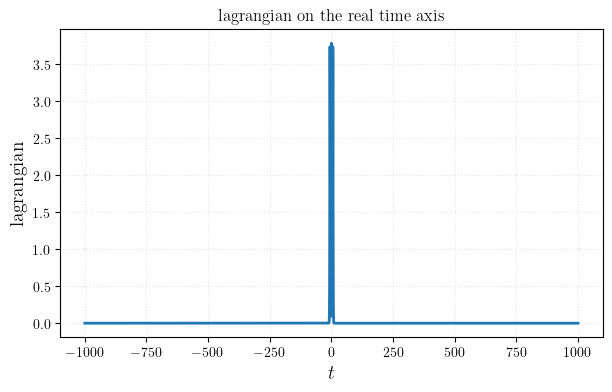

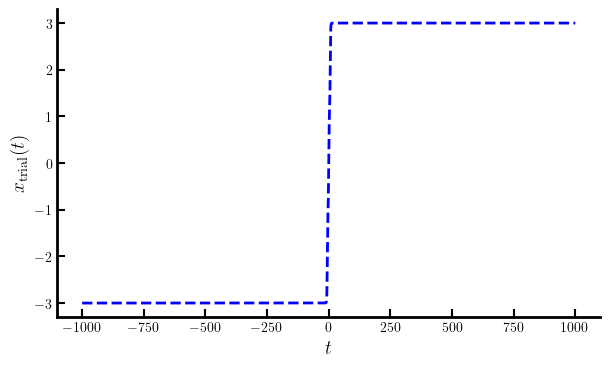

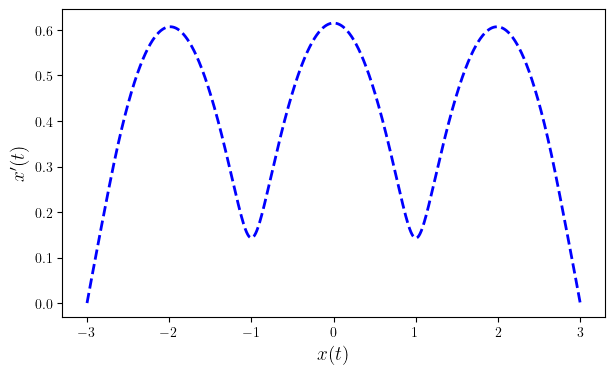

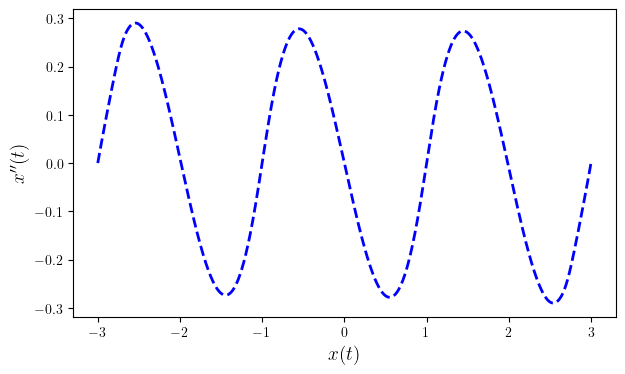

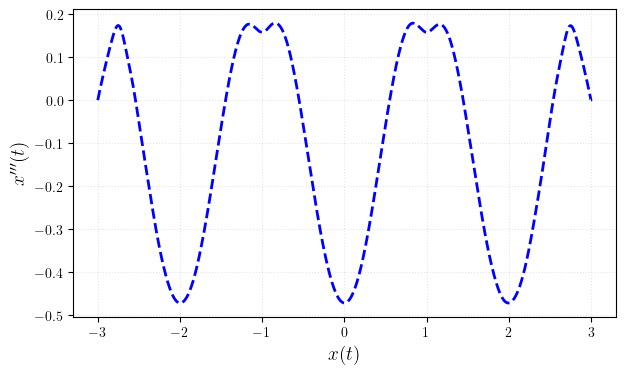

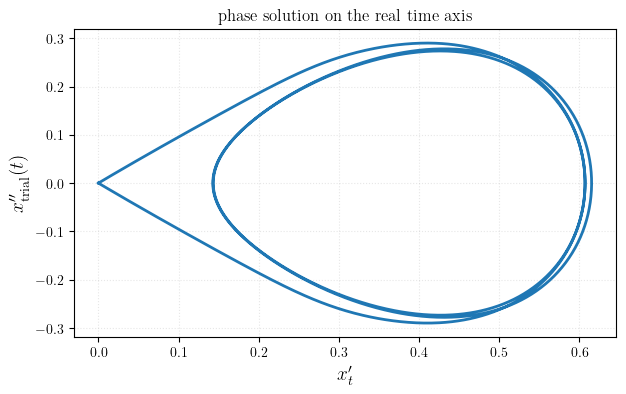

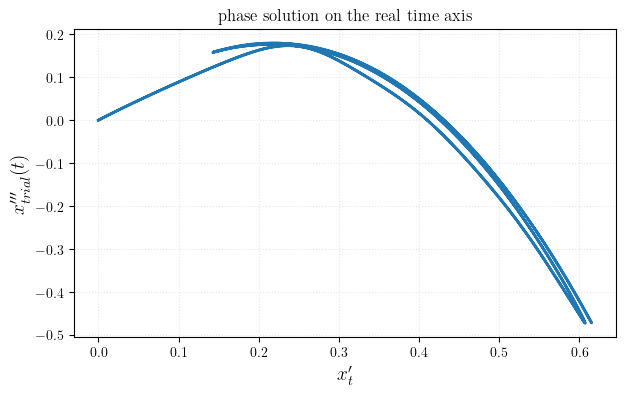

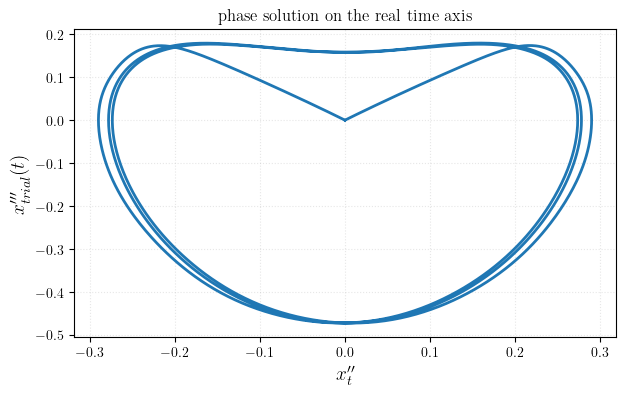

In [25]:
run_dir = r"Resultados_Finais_Considerados/fisher-kolmogorov-3T/2025-06-13_17-35-49"

cfg = Configuration(seed=0, features=[16,16,16], activation_function=th.nn.Tanh(),
                    learning_rate=1e-3, epochs=0, steps=1)   # steps is ignored here
system = KolmogorovNonConsecutive(domain=(-1+1e-10, 1-1e-10), initial_conditions={}, L_scale=4.0)
model  = Model("post_plot", cfg, system)

model.load(os.path.join(run_dir, "model_best.pt"),
           os.path.join(run_dir, "optimizer_best.pt"))
model.model.eval()

L  = 4.0
t_min, t_max = -1000.0, 1000.0
Nplot = 300000

t_grid = np.linspace(t_min, t_max, Nplot)
s_grid = np.tanh(t_grid / L)

pred   = model.eval(s_grid)

x_t = pred["x"].ravel()
y_t = pred["y"].ravel()            # dx/dt
z_t = pred["z"].ravel()
w_t = pred["w"].ravel() 

print(x_t[1000])

lagrangian = 0.5*z_t**2 + 1.5*np.pi*y_t**2 + 1 + np.cos(np.pi*x_t)
action     = np.trapz(lagrangian, t_grid)

print(f"Action over [{t_min},{t_max}]:  {action:.6e}")

plt.figure(figsize=(7,4))
plt.plot(t_grid, lagrangian, lw=2)
plt.xlabel(r"$t$")
plt.ylabel(r"lagrangian")
plt.title("lagrangian on the real time axis")
plt.grid(alpha=0.3, ls=":")
plt.show()

#wfsfwefsefs

fig = plt.figure(figsize=(7,4))
fig.patch.set_facecolor('white')
ax = plt.gca()
ax.plot(t_grid, x_t, linestyle="--", linewidth=2, color="#0000FF")
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$x(t)$")
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for spine in ax.spines.values():
    spine.set_linewidth(2.0)
ax.tick_params(which='both', width=1.5, direction='in', length=6, labelsize='medium')
plt.show()

plt.figure(figsize=(7,4))
plt.plot(x_t, y_t, linestyle="--", linewidth=2, color="#0000FF")
plt.xlabel(r"$x(t)$")
plt.ylabel(r"$x'(t)$")
plt.grid(False)
plt.show()

plt.figure(figsize=(7,4))
plt.plot(x_t, z_t, linestyle="--", linewidth=2, color="#0000FF")
plt.xlabel(r"$x(t)$")
plt.ylabel(r"$x''(t)$")
plt.grid(False)
plt.show()

plt.figure(figsize=(7,4))
plt.plot(x_t, w_t, linestyle="--", linewidth=2, color="#0000FF")
plt.xlabel(r"$x(t)$")
plt.ylabel(r"$x'''(t)$")
plt.grid(alpha=0.3, ls=":")
plt.show()

plt.figure(figsize=(7,4))
plt.plot(y_t, z_t, lw=2)
plt.xlabel(r"$x'_t$")
plt.ylabel(r"$x''_{\mathrm{trial}}(t)$")
plt.title("phase solution on the real time axis")
plt.grid(alpha=0.3, ls=":")
plt.show()

plt.figure(figsize=(7,4))
plt.plot(y_t, w_t, lw=2)
plt.xlabel(r"$x'_t$")
plt.ylabel(r"$x'''_{trial}(t)$")
plt.title("phase solution on the real time axis")
plt.grid(alpha=0.3, ls=":")
plt.show()

plt.figure(figsize=(7,4))
plt.plot(z_t, w_t, lw=2)
plt.xlabel(r"$x''_t$")
plt.ylabel(r"$x'''_{trial}(t)$")
plt.title("phase solution on the real time axis")
plt.grid(alpha=0.3, ls=":")
plt.show()

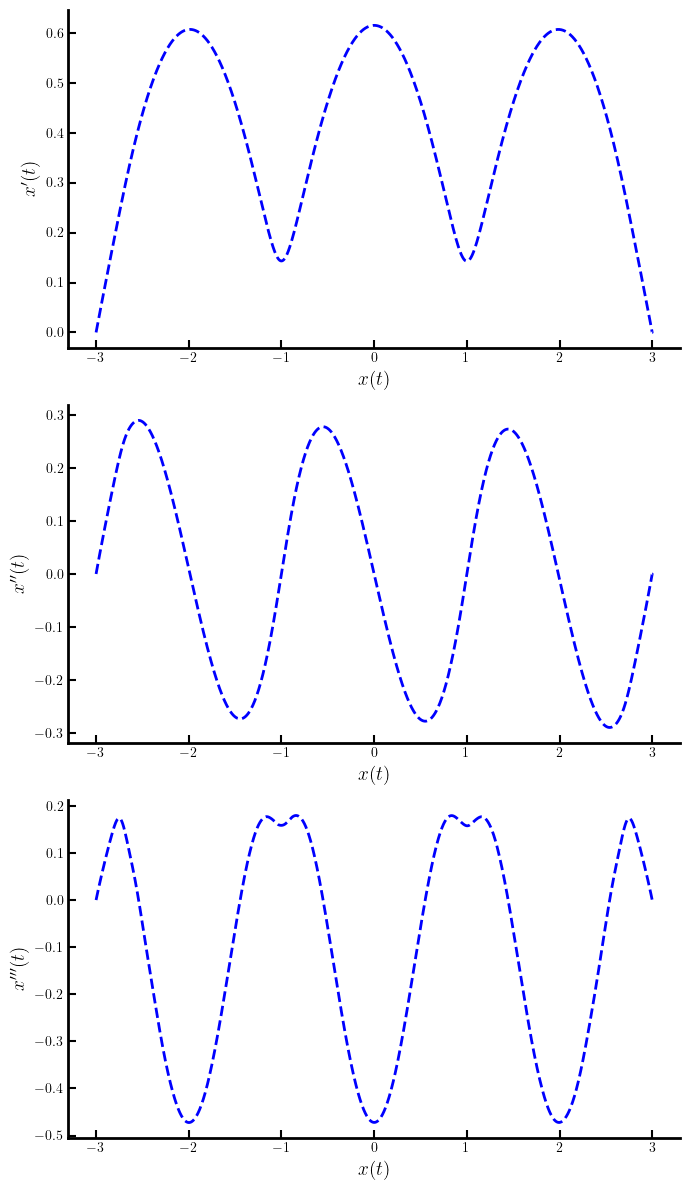

In [28]:
fig, axes = plt.subplots(3, 1, figsize=(7, 12))  # 3 rows, 1 column
fig.patch.set_facecolor('white')  # Set background color

# First subplot: x(t) vs x'(t)
axes[0].plot(x_t, y_t, linestyle="--", linewidth=2, color="#0000FF")
axes[0].set_xlabel(r"$x(t)$")
axes[0].set_ylabel(r"$x'(t)$")
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# Second subplot: x(t) vs x''(t)
axes[1].plot(x_t, z_t, linestyle="--", linewidth=2, color="#0000FF")
axes[1].set_xlabel(r"$x(t)$")
axes[1].set_ylabel(r"$x''(t)$")
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

# Third subplot: x(t) vs x'''(t)
axes[2].plot(x_t, w_t, linestyle="--", linewidth=2, color="#0000FF")
axes[2].set_xlabel(r"$x(t)$")
axes[2].set_ylabel(r"$x'''(t)$")
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)

# Common styling for all subplots
for ax in axes:
    ax.grid(False)
    for spine in ax.spines.values():
        spine.set_linewidth(2.0)
    ax.tick_params(which='both', width=1.5, direction='in', length=6, labelsize='medium')

# Layout and save
plt.tight_layout()
plt.savefig("phase_derivatives.pdf", format="pdf", dpi=300, bbox_inches='tight')
plt.show()

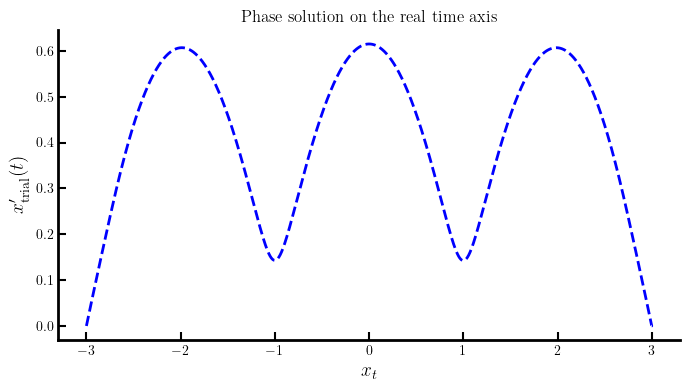

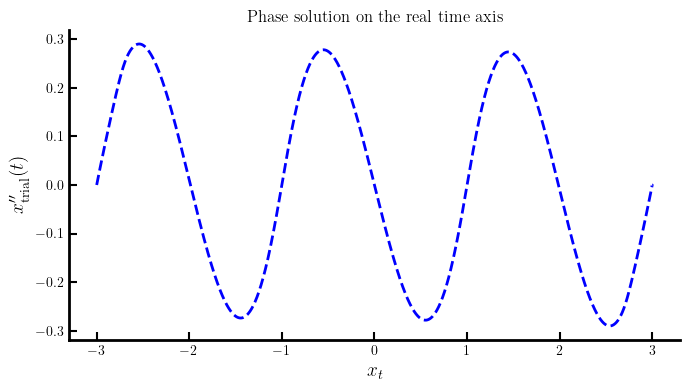

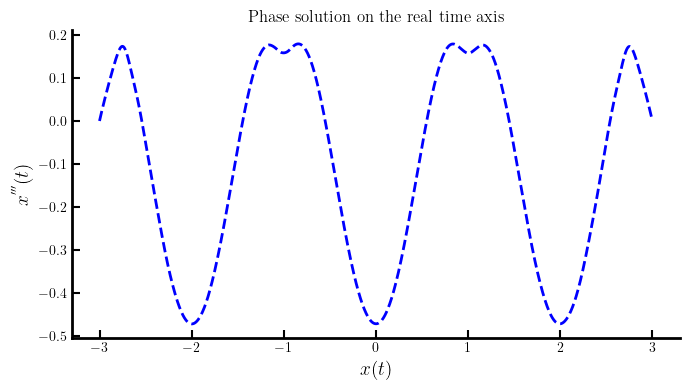

In [17]:
import matplotlib as mpl
mpl.rc('text', usetex=True)        # render all text with LaTeX
mpl.rc('font', family='serif')     # default serif font (Computer Modern via TeX)
mpl.rcParams['axes.labelsize'] = 14

def hones_axes(ax):
    """Give *ax* the same look-&-feel used in `test5`."""
    
    # white backboard and no grid
    ax.set_facecolor("white")
    ax.grid(False)
    
    # hide top/right spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    # thicken the visible spines
    for spine in ax.spines.values():
        spine.set_linewidth(2.0)
    
    # thicker ticks, drawn inward
    ax.tick_params(which="both",
                   direction="in",
                   width=1.5,
                   length=6,
                   labelsize="medium")


# 1st figure ────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(x_t, y_t, lw=2, color="#0000FF", linestyle="--",
        label=r"Trial solution")      # optional colour / style
hones_axes(ax)                        # <- magic line
ax.set_xlabel(r"$x_t$")
ax.set_ylabel(r"$x'_{\mathrm{trial}}(t)$")
ax.set_title(r"Phase solution on the real time axis")
# ax.legend()                        # turn on if you need a legend
plt.tight_layout()
fig.savefig("phase_xprime.pdf", bbox_inches="tight")   # <─ save as PDF
plt.show()

# 2nd figure ────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(x_t, z_t, lw=2, color="#0000FF", linestyle="--")
hones_axes(ax)
ax.set_xlabel(r"$x_t$")
ax.set_ylabel(r"$x''_{\mathrm{trial}}(t)$")
ax.set_title(r"Phase solution on the real time axis")
plt.tight_layout()
plt.show()

# 3rd figure ────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(x_t, w_t, lw=2, color="#0000FF", linestyle="--")
hones_axes(ax)
ax.set_xlabel(r"$x(t)$")
ax.set_ylabel(r"$x^{'''}(t)$")
ax.set_title(r"Phase solution on the real time axis")
plt.tight_layout()
fig.savefig("phase_xprime3.pdf", bbox_inches="tight")   # <─ save as PDF
plt.show()


In [11]:
cfg2 = Configuration(
    seed               = 43365,          # must match the training run
    features           = [16, 16, 16],
    activation_function= th.nn.Tanh(),
    learning_rate      = 1e-4,
    epochs             = 0,              # no training now
    steps              = 2_000             # finer grid for the integral
)

system2 = KolmogorovNonConsecutive(
    domain = (-10 + 1e-7, 10 - 1e-7),
    initial_conditions = {
        "x": (-40, -3),
        "y": (-40,  0),
        "z": ( 40,  3),
        "w": ( 40,  0),
    }
)

model2 = Model("post2", cfg2, system2)

# ------------------------------------------------------------------
# 2)  Load the saved weights ---------------------------------------
# ------------------------------------------------------------------
run_dir = r"data/KolmogorovNonConsecutivevFinal_vlong_newtrey/2025-06-08_16-53-48"   # <-- change!
model2.load(os.path.join(run_dir, "model_best.pt"),
            os.path.join(run_dir, "optimizer_best.pt"))
model2.model.eval()

t_grid = np.linspace(*system2.domain, cfg2.steps)
trial  = model2.eval(t_grid)





# unpack & flatten
x = trial["x"].ravel()
y = trial["y"].ravel()
z = trial["z"].ravel()

lagrangian = 0.5*z**2 + 1.5*np.pi*y**2 + 1 + np.cos(np.pi*x)
action     = np.trapz(lagrangian, t_grid)

print(f"Renormalised action  A[-5,5] = {action:.6e}")

Renormalised action  A[-5,5] = 2.043425e+14


In [4]:
class KolmogorovConsecutive(FourthOrderEquations):

    def __init__(self,
                 domain: Tuple[float, float],
                 initial_conditions: Dict[str, Tuple[float, float]],
                 *,
                 L_scale: float = 4.0):
        super().__init__("x", domain, initial_conditions, boundary_type="dirichlet")
        self.L = L_scale

    # ------------------------------------------------------------------
    #   Physics: RHS of the 4-th-order ODE   x⁽⁴⁾ = 3π z + π sin(π x)
    # ------------------------------------------------------------------
    def equation(self, x, y, z, w, t):
        return 3 * np.pi * z + np.pi * np.sin(np.pi * x)

    # ------------------------------------------------------------------
    #   Trial function  — exact boundary  x(±∞)=±1    (s ∈ (-1,1))
    # ------------------------------------------------------------------
    
    @staticmethod
    def _heteroclinic_trial(s: th.Tensor, net_out: th.Tensor) -> th.Tensor:
        """
        u(s) = s + (1 - s**2) * net_out     so   u(-1)=-1,  u(+1)=+1
        """
        a = 2* ((s+1)/2)**3 - 3* ((s+1)/2)**2 + 1
        b = -2* ((s+1)/2)**3 + 3* ((s+1)/2)**2
        return -1*a + 1*b + ((s+1)**2) * (1-s)**2 * net_out

    # ------------------------------------------------------------------
    #   Chain-rule derivatives  x_t, x_tt, … up to *order*
    # ------------------------------------------------------------------
    @staticmethod
    def _t_derivatives(s: th.Tensor,
                       u: th.Tensor,
                       *,
                       order: int = 4,
                       L: float = 4.0) -> List[th.Tensor]:
        """
        Returns [x_t, x_tt, x_ttt, x_tttt, …] of length *order*.
        """
        ds_dt = (1.0 - s**2) / L
        derivs = []
        f = u
        for _ in range(order):
            f_s = compute_derivative(s, f)   # df/ds
            f   = ds_dt * f_s                # df/dt
            derivs.append(f)
        return derivs

    def calculate_trial_solution(self,
                                 s: th.Tensor,
                                 nn_out: Dict[str, th.Tensor]
                                ) -> Dict[str, th.Tensor]:
        """
        Returns the trial function and its first 3 time-derivatives
        so that Model._save_train() can plot and post-process them.
        """
        x = self._heteroclinic_trial(s, nn_out["x"])
        y, z, w, _ = self._t_derivatives(s, x, order=4, L=self.L)

        return {"x": x, "y": y, "z": z, "w": w}

    # ------------------------------------------------------------------
    #   Loss
    # ------------------------------------------------------------------
    def calculate_loss(self,
                       t: th.Tensor,                # here: t is actually s-grid
                       nn_out: Dict[str, th.Tensor]
                      ) -> Dict[str, th.Tensor]:

        s = t                                     # rename for clarity
        x = self._heteroclinic_trial(s, nn_out["x"])

        y, z, w, x4 = self._t_derivatives(s, x, order=4, L=self.L)

        # ---- dynamics residual ---------------------------------------
        rhs = 3 * np.pi * z + np.pi * th.sin(np.pi * x)
        mse_dyn = th.sum((x4 - rhs)**2)

        # ---- action  (include Jacobian dt/ds) -------------------------
        L_density = 0.5 * z**2 + 1.5 * np.pi * y**2 + 1 + th.cos(np.pi * x)
        jacobian  = self.L / (1.0 - s**2)
        action    = th.trapz((L_density * jacobian).view(-1), s.view(-1))

        # ---- extra penalties -----------------------------------------
        idx0 = (s.abs()).argmin()       # s closest to 0  (t≈0)
        x0_pred = x[idx0]
        target_x0 = th.tensor(0.0, dtype=x.dtype, device=x.device)

        BIG = 10_000.0
        total = mse_dyn + action + BIG * (x0_pred - target_x0)**2

        return {
            "total": total,
            "dynamics": mse_dyn,
            # leave out "hamiltonian" if you aren’t actually computing it:
            "hamiltonian": mse_dyn      # <- placeholder; change if needed
        }

  0%|                                        | 3/400000 [00:00<4:12:42, 26.38it/s]

3525.8780139212276


  0%|                                      | 106/400000 [00:02<3:00:24, 36.94it/s]

604.5652749966581


  0%|                                      | 205/400000 [00:05<2:43:27, 40.77it/s]

446.5200040985139


  0%|                                      | 306/400000 [00:07<2:56:30, 37.74it/s]

52.35428480360563


  0%|                                      | 408/400000 [00:10<2:47:51, 39.67it/s]

13.771504851398241


  0%|                                      | 504/400000 [00:12<2:45:36, 40.21it/s]

12.49299368393795


  0%|                                      | 605/400000 [00:15<2:54:46, 38.09it/s]

11.503831958648627


  0%|                                      | 705/400000 [00:18<2:44:04, 40.56it/s]

10.706176332269592


  0%|                                      | 807/400000 [00:20<2:45:12, 40.27it/s]

10.054795968148392


  0%|                                      | 905/400000 [00:23<2:47:19, 39.75it/s]

9.527101789733148


  0%|                                     | 1005/400000 [00:25<2:46:40, 39.90it/s]

9.107224100619352


  0%|                                     | 1105/400000 [00:28<2:48:21, 39.49it/s]

8.780406892248829


  0%|                                     | 1205/400000 [00:31<2:43:53, 40.56it/s]

8.532026639534322


  0%|                                     | 1304/400000 [00:33<2:43:43, 40.58it/s]

8.34796827988087


  0%|▏                                    | 1404/400000 [00:36<2:54:37, 38.04it/s]

8.215161542054727


  0%|▏                                    | 1508/400000 [00:38<2:44:46, 40.31it/s]

8.121987138431264


  0%|▏                                    | 1608/400000 [00:41<2:44:33, 40.35it/s]

8.058515998879859


  0%|▏                                    | 1707/400000 [00:43<3:06:06, 35.67it/s]

8.016590898809097


  0%|▏                                    | 1805/400000 [00:46<2:47:34, 39.60it/s]

7.989771490564807


  0%|▏                                    | 1904/400000 [00:49<2:52:32, 38.45it/s]

7.973174111967027


  1%|▏                                    | 2007/400000 [00:51<2:46:14, 39.90it/s]

7.963244534049274


  1%|▏                                    | 2108/400000 [00:54<2:48:58, 39.25it/s]

7.9575020593501105


  1%|▏                                    | 2207/400000 [00:56<3:00:05, 36.81it/s]

7.954287605996397


  1%|▏                                    | 2306/400000 [00:59<2:48:29, 39.34it/s]

7.952538917391785


  1%|▏                                    | 2407/400000 [01:01<2:53:51, 38.11it/s]

7.951605543891071


  1%|▏                                    | 2506/400000 [01:04<2:47:40, 39.51it/s]

7.951107020137173


  1%|▏                                    | 2604/400000 [01:06<2:52:25, 38.41it/s]

7.950831042646969


  1%|▎                                    | 2707/400000 [01:09<2:48:21, 39.33it/s]

7.950664764131488


  1%|▎                                    | 2806/400000 [01:12<2:54:07, 38.02it/s]

7.950551138633175


  1%|▎                                    | 2906/400000 [01:14<2:49:37, 39.02it/s]

7.950462779564742


  1%|▎                                    | 3005/400000 [01:17<2:43:59, 40.35it/s]

7.950387205309188


  1%|▎                                    | 3105/400000 [01:19<2:46:36, 39.70it/s]

7.950318996140043


  1%|▎                                    | 3207/400000 [01:22<2:45:24, 39.98it/s]

7.950255872866387


  1%|▎                                    | 3306/400000 [01:24<2:48:16, 39.29it/s]

7.950196856928918


  1%|▎                                    | 3404/400000 [01:27<2:48:44, 39.17it/s]

7.950141463319137


  1%|▎                                    | 3507/400000 [01:30<2:48:54, 39.12it/s]

7.950089372083847


  1%|▎                                    | 3605/400000 [01:32<3:25:34, 32.14it/s]

7.950040306564465


  1%|▎                                    | 3705/400000 [01:35<2:49:00, 39.08it/s]

7.94999399467239


  1%|▎                                    | 3805/400000 [01:37<2:51:36, 38.48it/s]

7.949950161014956


  1%|▎                                    | 3907/400000 [01:40<2:44:31, 40.12it/s]

7.9499085294494645


  1%|▎                                    | 4006/400000 [01:43<2:52:29, 38.26it/s]

7.9498688286133365


  1%|▍                                    | 4104/400000 [01:45<2:46:24, 39.65it/s]

7.949830797845813


  1%|▍                                    | 4207/400000 [01:48<2:47:37, 39.35it/s]

7.949794192601758


  1%|▍                                    | 4308/400000 [01:50<2:49:29, 38.91it/s]

7.949758789009909


  1%|▍                                    | 4405/400000 [01:53<2:50:40, 38.63it/s]

7.9497243874168895


  1%|▍                                    | 4505/400000 [01:55<2:44:17, 40.12it/s]

7.949690814844355


  1%|▍                                    | 4608/400000 [01:58<2:45:58, 39.70it/s]

7.949657926347233


  1%|▍                                    | 4707/400000 [02:01<2:44:46, 39.98it/s]

7.949625605314171


  1%|▍                                    | 4805/400000 [02:03<2:44:58, 39.92it/s]

7.94959376279871


  1%|▍                                    | 4907/400000 [02:06<2:43:47, 40.20it/s]

7.949562336009094


  1%|▍                                    | 5006/400000 [02:08<2:39:30, 41.27it/s]

7.949531286113327


  1%|▍                                    | 5105/400000 [02:11<2:42:16, 40.56it/s]

7.949500595532504


  1%|▍                                    | 5208/400000 [02:13<2:46:44, 39.46it/s]

7.949470264899118


  1%|▍                                    | 5307/400000 [02:16<2:43:49, 40.15it/s]

7.949440309848588


  1%|▌                                    | 5408/400000 [02:18<2:43:47, 40.15it/s]

7.949410757793622


  1%|▌                                    | 5507/400000 [02:21<2:45:10, 39.80it/s]

7.949381644805127


  1%|▌                                    | 5605/400000 [02:23<2:40:23, 40.98it/s]

7.94935301269325


  1%|▌                                    | 5706/400000 [02:26<2:46:06, 39.56it/s]

7.9493249063513325


  1%|▌                                    | 5807/400000 [02:28<2:43:55, 40.08it/s]

7.949297371397057


  1%|▌                                    | 5908/400000 [02:31<2:44:37, 39.90it/s]

7.949329379298172


  2%|▌                                    | 6007/400000 [02:33<2:41:46, 40.59it/s]

7.949244146695755


  2%|▌                                    | 6107/400000 [02:36<2:51:59, 38.17it/s]

7.949219433245604


  2%|▌                                    | 6207/400000 [02:38<2:48:00, 39.07it/s]

7.949195399218418


  2%|▌                                    | 6306/400000 [02:41<2:51:56, 38.16it/s]

7.9491887717418805


  2%|▌                                    | 6408/400000 [02:44<2:54:03, 37.69it/s]

7.949149255044715


  2%|▌                                    | 6508/400000 [02:46<2:45:40, 39.58it/s]

7.949128354793514


  2%|▌                                    | 6605/400000 [02:49<2:46:30, 39.38it/s]

7.955821826185204


  2%|▌                                    | 6707/400000 [02:51<2:43:42, 40.04it/s]

7.949087833554236


  2%|▋                                    | 6804/400000 [02:54<3:10:31, 34.40it/s]

7.949069824362034


  2%|▋                                    | 6906/400000 [02:56<2:44:11, 39.90it/s]

7.949052617534141


  2%|▋                                    | 7006/400000 [02:59<2:47:17, 39.15it/s]

7.94906979448026


  2%|▋                                    | 7108/400000 [03:02<2:45:31, 39.56it/s]

7.949019358223342


  2%|▋                                    | 7206/400000 [03:04<2:47:47, 39.02it/s]

7.949004829674736


  2%|▋                                    | 7307/400000 [03:07<2:44:28, 39.79it/s]

7.95446634945887


  2%|▋                                    | 7408/400000 [03:09<2:45:40, 39.49it/s]

7.948976082581825


  2%|▋                                    | 7508/400000 [03:12<2:42:27, 40.27it/s]

7.948963568670677


  2%|▋                                    | 7605/400000 [03:14<2:42:20, 40.28it/s]

7.948951445064804


  2%|▋                                    | 7707/400000 [03:17<2:43:16, 40.04it/s]

7.94901655521485


  2%|▋                                    | 7808/400000 [03:19<2:45:30, 39.49it/s]

7.9489273352416285


  2%|▋                                    | 7906/400000 [03:22<3:04:20, 35.45it/s]

7.948916834812923


  2%|▋                                    | 8008/400000 [03:24<2:40:54, 40.60it/s]

7.948907590818612


  2%|▋                                    | 8108/400000 [03:27<2:34:34, 42.25it/s]

7.948906211204799


  2%|▊                                    | 8207/400000 [03:29<2:41:56, 40.32it/s]

7.948885373442927


  2%|▊                                    | 8306/400000 [03:32<2:36:35, 41.69it/s]

7.948875830275032


  2%|▊                                    | 8406/400000 [03:34<2:38:50, 41.09it/s]

7.950738110209977


  2%|▊                                    | 8506/400000 [03:36<2:36:22, 41.73it/s]

7.949339866462308


  2%|▊                                    | 8604/400000 [03:39<2:47:43, 38.89it/s]

7.948850169061482


  2%|▊                                    | 8704/400000 [03:41<2:39:34, 40.87it/s]

7.948837779063035


  2%|▊                                    | 8807/400000 [03:44<2:35:56, 41.81it/s]

7.949252097037485


  2%|▊                                    | 8907/400000 [03:46<2:35:47, 41.84it/s]

7.948819286580159


  2%|▊                                    | 9004/400000 [03:49<2:41:05, 40.45it/s]

7.948992190300322


  2%|▊                                    | 9106/400000 [03:51<2:42:11, 40.17it/s]

7.948800606457674


  2%|▊                                    | 9206/400000 [03:54<2:40:14, 40.64it/s]

7.948852822390922


  2%|▊                                    | 9306/400000 [03:56<2:35:05, 41.98it/s]

7.948798027311624


  2%|▊                                    | 9404/400000 [03:58<2:41:30, 40.31it/s]

7.948772947989769


  2%|▉                                    | 9504/400000 [04:01<2:41:25, 40.32it/s]

7.94879525055611


  2%|▉                                    | 9604/400000 [04:03<2:38:58, 40.93it/s]

7.948782646626029


  2%|▉                                    | 9704/400000 [04:06<2:36:04, 41.68it/s]

7.948745169559914


  2%|▉                                    | 9804/400000 [04:08<2:40:33, 40.50it/s]

7.9488767225156325


  2%|▉                                    | 9904/400000 [04:11<2:32:34, 42.61it/s]

7.948768989245358


  3%|▉                                   | 10004/400000 [04:13<2:36:53, 41.43it/s]

7.9490233677044015


  3%|▉                                   | 10105/400000 [04:16<2:51:50, 37.82it/s]

7.9488166734770695


  3%|▉                                   | 10207/400000 [04:18<2:37:14, 41.32it/s]

7.950953115732087


  3%|▉                                   | 10307/400000 [04:20<2:36:07, 41.60it/s]

7.948807397028352


  3%|▉                                   | 10407/400000 [04:23<2:33:37, 42.27it/s]

7.949070252428501


  3%|▉                                   | 10506/400000 [04:25<2:39:26, 40.71it/s]

7.9486872576247904


  3%|▉                                   | 10606/400000 [04:28<2:39:26, 40.70it/s]

7.9496874407562785


  3%|▉                                   | 10704/400000 [04:30<2:40:18, 40.47it/s]

7.948949119401453


  3%|▉                                   | 10804/400000 [04:33<2:37:00, 41.31it/s]

7.95562174730042


  3%|▉                                   | 10908/400000 [04:35<2:34:13, 42.05it/s]

7.948770010269759


  3%|▉                                   | 11008/400000 [04:38<2:39:17, 40.70it/s]

7.953368276967136


  3%|▉                                   | 11108/400000 [04:40<2:35:54, 41.57it/s]

7.961850018782154


  3%|█                                   | 11206/400000 [04:43<2:40:16, 40.43it/s]

7.948719301416224


  3%|█                                   | 11304/400000 [04:45<2:33:45, 42.13it/s]

7.949535998892784


  3%|█                                   | 11407/400000 [04:48<2:40:22, 40.39it/s]

7.94899923065669


  3%|█                                   | 11507/400000 [04:50<2:35:32, 41.63it/s]

7.948727765832398


  3%|█                                   | 11607/400000 [04:52<2:38:31, 40.84it/s]

7.94868502437946


  3%|█                                   | 11702/400000 [04:55<2:35:40, 41.57it/s]

7.981690300601269


  3%|█                                   | 11806/400000 [04:57<2:40:42, 40.26it/s]

7.952849784833026


  3%|█                                   | 11906/400000 [05:00<2:35:23, 41.63it/s]

7.948720076169978


  3%|█                                   | 12006/400000 [05:02<2:37:02, 41.18it/s]

7.948536358510047


  3%|█                                   | 12106/400000 [05:05<2:36:11, 41.39it/s]

7.948557581079123


  3%|█                                   | 12205/400000 [05:07<2:34:39, 41.79it/s]

7.948518231132285


  3%|█                                   | 12305/400000 [05:09<2:33:27, 42.11it/s]

7.949211651967192


  3%|█                                   | 12405/400000 [05:12<2:35:00, 41.67it/s]

7.948505730669699


  3%|█▏                                  | 12505/400000 [05:14<2:39:20, 40.53it/s]

7.9486263371882


  3%|█▏                                  | 12605/400000 [05:17<2:34:56, 41.67it/s]

7.948540737939969


  3%|█▏                                  | 12705/400000 [05:19<2:34:05, 41.89it/s]

7.9484767014238


  3%|█▏                                  | 12805/400000 [05:22<2:38:09, 40.80it/s]

7.95577291854074


  3%|█▏                                  | 12905/400000 [05:24<2:36:39, 41.18it/s]

7.953587812346061


  3%|█▏                                  | 13005/400000 [05:26<2:36:27, 41.22it/s]

7.948629462899621


  3%|█▏                                  | 13107/400000 [05:29<2:48:24, 38.29it/s]

7.9498399220098985


  3%|█▏                                  | 13207/400000 [05:31<2:38:01, 40.79it/s]

7.94854196162807


  3%|█▏                                  | 13307/400000 [05:34<2:33:37, 41.95it/s]

7.9869218114469955


  3%|█▏                                  | 13407/400000 [05:36<2:34:13, 41.78it/s]

7.948541858080295


  3%|█▏                                  | 13507/400000 [05:39<2:38:23, 40.67it/s]

7.948409217672481


  3%|█▏                                  | 13607/400000 [05:41<2:34:27, 41.69it/s]

7.960173676961735


  3%|█▏                                  | 13705/400000 [05:43<2:34:09, 41.76it/s]

7.948390351632578


  3%|█▏                                  | 13804/400000 [05:46<2:36:48, 41.05it/s]

7.948615479191339


  3%|█▎                                  | 13908/400000 [05:49<2:37:23, 40.89it/s]

7.969887674780097


  4%|█▎                                  | 14008/400000 [05:51<2:34:41, 41.59it/s]

7.9487631209398835


  4%|█▎                                  | 14108/400000 [05:53<2:32:49, 42.08it/s]

7.953066737133886


  4%|█▎                                  | 14208/400000 [05:56<2:31:41, 42.39it/s]

7.950438927762118


  4%|█▎                                  | 14308/400000 [05:58<2:34:20, 41.65it/s]

7.948791794555109


  4%|█▎                                  | 14408/400000 [06:01<2:31:10, 42.51it/s]

7.950595538590457


  4%|█▎                                  | 14508/400000 [06:03<2:37:08, 40.89it/s]

7.952249312514392


  4%|█▎                                  | 14608/400000 [06:05<2:33:11, 41.93it/s]

7.954786671790119


  4%|█▎                                  | 14708/400000 [06:08<2:34:37, 41.53it/s]

7.949567662249109


  4%|█▎                                  | 14808/400000 [06:10<2:35:19, 41.33it/s]

7.948988967973442


  4%|█▎                                  | 14908/400000 [06:13<2:32:49, 42.00it/s]

7.950342696193329


  4%|█▎                                  | 15008/400000 [06:15<2:36:00, 41.13it/s]

7.948284893770517


  4%|█▎                                  | 15106/400000 [06:18<2:57:33, 36.13it/s]

7.948587739849769


  4%|█▎                                  | 15204/400000 [06:20<2:35:37, 41.21it/s]

7.948319898043109


  4%|█▍                                  | 15304/400000 [06:22<2:33:20, 41.81it/s]

7.94859286266691


  4%|█▍                                  | 15405/400000 [06:25<2:51:54, 37.29it/s]

7.948828598416744


  4%|█▍                                  | 15504/400000 [06:27<2:37:17, 40.74it/s]

7.951920620976012


  4%|█▍                                  | 15607/400000 [06:30<2:40:05, 40.02it/s]

7.94850319415456


  4%|█▍                                  | 15707/400000 [06:32<2:36:34, 40.91it/s]

7.949433105079508


  4%|█▍                                  | 15807/400000 [06:35<2:34:40, 41.40it/s]

7.949478223599287


  4%|█▍                                  | 15907/400000 [06:37<2:33:26, 41.72it/s]

7.948269289533401


  4%|█▍                                  | 16007/400000 [06:40<2:34:59, 41.29it/s]

7.948424392359637


  4%|█▍                                  | 16107/400000 [06:42<2:40:28, 39.87it/s]

7.948799968252187


  4%|█▍                                  | 16208/400000 [06:45<2:35:40, 41.09it/s]

7.948269911078296


  4%|█▍                                  | 16307/400000 [06:47<2:37:40, 40.56it/s]

7.948354120232556


  4%|█▍                                  | 16405/400000 [06:50<2:35:09, 41.21it/s]

7.960631876802173


  4%|█▍                                  | 16505/400000 [06:52<2:38:21, 40.36it/s]

7.948173360864542


  4%|█▍                                  | 16605/400000 [06:54<2:35:20, 41.13it/s]

7.948199355754129


  4%|█▌                                  | 16704/400000 [06:57<2:41:49, 39.47it/s]

7.948158766797627


  4%|█▌                                  | 16808/400000 [07:00<2:34:27, 41.35it/s]

7.949948829313857


  4%|█▌                                  | 16908/400000 [07:02<2:33:42, 41.54it/s]

7.948251394216798


  4%|█▌                                  | 17008/400000 [07:04<2:32:10, 41.94it/s]

7.94813599830831


  4%|█▌                                  | 17108/400000 [07:07<2:35:37, 41.01it/s]

7.948531744711606


  4%|█▌                                  | 17208/400000 [07:09<2:33:31, 41.56it/s]

7.948121936284609


  4%|█▌                                  | 17308/400000 [07:12<2:34:08, 41.38it/s]

7.961576613418531


  4%|█▌                                  | 17408/400000 [07:14<2:32:12, 41.89it/s]

7.948123334695107


  4%|█▌                                  | 17505/400000 [07:17<2:47:01, 38.17it/s]

7.948254616214593


  4%|█▌                                  | 17608/400000 [07:19<2:35:30, 40.98it/s]

7.9482941503711775


  4%|█▌                                  | 17708/400000 [07:22<2:37:44, 40.39it/s]

7.9480921292304005


  4%|█▌                                  | 17808/400000 [07:24<2:35:53, 40.86it/s]

7.948089695538806


  4%|█▌                                  | 17908/400000 [07:26<2:34:39, 41.18it/s]

7.948085573481979


  5%|█▌                                  | 18005/400000 [07:29<2:46:58, 38.13it/s]

7.9481308953235175


  5%|█▋                                  | 18108/400000 [07:31<2:33:19, 41.51it/s]

7.948079405937805


  5%|█▋                                  | 18207/400000 [07:34<2:36:59, 40.53it/s]

7.949061969863164


  5%|█▋                                  | 18307/400000 [07:36<2:34:21, 41.21it/s]

7.949683720908617


  5%|█▋                                  | 18407/400000 [07:39<2:32:40, 41.66it/s]

7.949567927986811


  5%|█▋                                  | 18507/400000 [07:41<2:34:09, 41.25it/s]

7.948178025279692


  5%|█▋                                  | 18605/400000 [07:44<2:33:22, 41.45it/s]

7.948089160153492


  5%|█▋                                  | 18705/400000 [07:46<2:34:12, 41.21it/s]

7.948053818756583


  5%|█▋                                  | 18806/400000 [07:49<2:39:41, 39.79it/s]

7.962862900894079


  5%|█▋                                  | 18906/400000 [07:51<2:37:59, 40.20it/s]

7.949126785563605


  5%|█▋                                  | 19006/400000 [07:53<2:35:13, 40.91it/s]

7.947999945880066


  5%|█▋                                  | 19106/400000 [07:56<2:33:48, 41.28it/s]

7.948954206021587


  5%|█▋                                  | 19206/400000 [07:58<2:34:36, 41.05it/s]

7.961856199330627


  5%|█▋                                  | 19306/400000 [08:01<2:30:02, 42.29it/s]

7.947980886592491


  5%|█▋                                  | 19406/400000 [08:03<2:32:46, 41.52it/s]

7.9481794593169965


  5%|█▊                                  | 19506/400000 [08:06<2:35:08, 40.87it/s]

7.947972887796637


  5%|█▊                                  | 19606/400000 [08:08<2:35:39, 40.73it/s]

7.9479655075860185


  5%|█▊                                  | 19705/400000 [08:11<2:33:35, 41.27it/s]

7.947955095450035


  5%|█▊                                  | 19805/400000 [08:13<2:38:18, 40.03it/s]

7.948468254266223


  5%|█▊                                  | 19905/400000 [08:15<2:31:06, 41.92it/s]

7.948010872641928


  5%|█▊                                  | 20008/400000 [08:18<2:39:48, 39.63it/s]

7.947945729685192


  5%|█▊                                  | 20106/400000 [08:20<2:31:59, 41.66it/s]

7.947934467301877


  5%|█▊                                  | 20206/400000 [08:23<2:29:51, 42.24it/s]

7.947929756169677


  5%|█▊                                  | 20308/400000 [08:25<2:41:03, 39.29it/s]

7.948457240644611


  5%|█▊                                  | 20407/400000 [08:28<2:33:16, 41.28it/s]

7.947913133154879


  5%|█▊                                  | 20507/400000 [08:30<2:40:14, 39.47it/s]

7.95571215523437


  5%|█▊                                  | 20605/400000 [08:33<2:35:39, 40.62it/s]

7.94795979335386


  5%|█▊                                  | 20705/400000 [08:35<2:33:25, 41.20it/s]

7.948202446844969


  5%|█▊                                  | 20804/400000 [08:38<2:36:42, 40.33it/s]

7.947889689147619


  5%|█▉                                  | 20908/400000 [08:40<2:33:24, 41.19it/s]

7.947888167138306


  5%|█▉                                  | 21006/400000 [08:43<2:37:37, 40.07it/s]

7.9478776321388365


  5%|█▉                                  | 21104/400000 [08:45<2:36:27, 40.36it/s]

7.948017187953382


  5%|█▉                                  | 21205/400000 [08:48<2:42:29, 38.85it/s]

7.953933830185776


  5%|█▉                                  | 21304/400000 [08:51<2:33:35, 41.09it/s]

7.947857754021446


  5%|█▉                                  | 21404/400000 [08:53<2:35:38, 40.54it/s]

7.947849033265674


  5%|█▉                                  | 21505/400000 [08:56<2:43:16, 38.63it/s]

7.961085388559085


  5%|█▉                                  | 21606/400000 [08:58<2:34:23, 40.85it/s]

7.948032904186221


  5%|█▉                                  | 21708/400000 [09:01<2:36:02, 40.41it/s]

7.947832587154676


  5%|█▉                                  | 21808/400000 [09:03<2:33:49, 40.98it/s]

7.948271780550614


  5%|█▉                                  | 21908/400000 [09:06<2:31:34, 41.57it/s]

7.947833190256859


  6%|█▉                                  | 22008/400000 [09:08<2:34:56, 40.66it/s]

7.94849952417273


  6%|█▉                                  | 22104/400000 [09:10<2:34:27, 40.78it/s]

7.950269715052663


  6%|█▉                                  | 22204/400000 [09:13<2:35:00, 40.62it/s]

7.947861135773892


  6%|██                                  | 22304/400000 [09:15<2:34:36, 40.72it/s]

7.947849916055906


  6%|██                                  | 22407/400000 [09:18<2:42:44, 38.67it/s]

7.949470294057733


  6%|██                                  | 22508/400000 [09:20<2:33:54, 40.88it/s]

7.948895706367293


  6%|██                                  | 22607/400000 [09:23<2:35:42, 40.39it/s]

7.953360651033099


  6%|██                                  | 22707/400000 [09:25<2:36:02, 40.30it/s]

7.947785588759195


  6%|██                                  | 22806/400000 [09:28<2:38:51, 39.57it/s]

7.949265171265146


  6%|██                                  | 22908/400000 [09:31<2:37:46, 39.84it/s]

7.947846999065242


  6%|██                                  | 23007/400000 [09:33<2:36:34, 40.13it/s]

7.94933970233558


  6%|██                                  | 23107/400000 [09:36<2:31:44, 41.40it/s]

7.947861865129006


  6%|██                                  | 23206/400000 [09:38<2:35:27, 40.39it/s]

7.947751555201418


  6%|██                                  | 23308/400000 [09:41<2:35:30, 40.37it/s]

7.947792511926314


  6%|██                                  | 23408/400000 [09:43<2:36:04, 40.22it/s]

7.947734028192096


  6%|██                                  | 23508/400000 [09:46<2:35:37, 40.32it/s]

7.948520095558437


  6%|██                                  | 23604/400000 [09:48<2:35:50, 40.25it/s]

7.9477537200213595


  6%|██▏                                 | 23708/400000 [09:51<2:32:21, 41.16it/s]

7.94909490465657


  6%|██▏                                 | 23808/400000 [09:53<2:35:41, 40.27it/s]

7.947861051238871


  6%|██▏                                 | 23905/400000 [09:55<2:45:33, 37.86it/s]

7.948123475522276


  6%|██▏                                 | 24008/400000 [09:58<2:45:06, 37.96it/s]

7.948398006453598


  6%|██▏                                 | 24105/400000 [10:01<2:50:14, 36.80it/s]

7.9482833373774096


  6%|██▏                                 | 24207/400000 [10:03<2:42:49, 38.47it/s]

7.947934208745549


  6%|██▏                                 | 24307/400000 [10:06<2:34:25, 40.55it/s]

7.947692227395482


  6%|██▏                                 | 24407/400000 [10:09<2:32:37, 41.01it/s]

7.947690872273995


  6%|██▏                                 | 24506/400000 [10:11<2:36:05, 40.09it/s]

7.949466694757826


  6%|██▏                                 | 24604/400000 [10:13<2:39:46, 39.16it/s]

7.947676527617923


  6%|██▏                                 | 24704/400000 [10:16<2:31:17, 41.34it/s]

7.949330428338359


  6%|██▏                                 | 24804/400000 [10:18<2:37:05, 39.81it/s]

7.948148858633416


  6%|██▏                                 | 24907/400000 [10:21<2:37:04, 39.80it/s]

7.94811789720439


  6%|██▎                                 | 25008/400000 [10:23<2:33:09, 40.81it/s]

7.947713817995383


  6%|██▎                                 | 25106/400000 [10:26<2:35:17, 40.23it/s]

7.950419087463882


  6%|██▎                                 | 25207/400000 [10:29<2:52:26, 36.22it/s]

7.947629110360491


  6%|██▎                                 | 25308/400000 [10:31<2:39:48, 39.08it/s]

7.950696450454624


  6%|██▎                                 | 25407/400000 [10:34<2:36:35, 39.87it/s]

7.949274326997954


  6%|██▎                                 | 25507/400000 [10:36<2:32:48, 40.85it/s]

7.948573288308561


  6%|██▎                                 | 25606/400000 [10:38<2:38:48, 39.29it/s]

7.9519088915038445


  6%|██▎                                 | 25705/400000 [10:41<2:37:18, 39.66it/s]

7.9494238582092756


  6%|██▎                                 | 25806/400000 [10:44<2:52:42, 36.11it/s]

7.947814392175933


  6%|██▎                                 | 25906/400000 [10:46<2:33:10, 40.71it/s]

7.9478789106084315


  7%|██▎                                 | 26008/400000 [10:49<2:33:55, 40.50it/s]

7.947583533967617


  7%|██▎                                 | 26108/400000 [10:51<2:34:06, 40.44it/s]

7.948162949181609


  7%|██▎                                 | 26206/400000 [10:54<2:32:20, 40.90it/s]

7.947591494129658


  7%|██▎                                 | 26304/400000 [10:56<2:38:06, 39.39it/s]

7.948126613201016


  7%|██▍                                 | 26407/400000 [10:59<2:33:46, 40.49it/s]

7.947564879264661


  7%|██▍                                 | 26506/400000 [11:01<2:34:02, 40.41it/s]

7.948075567758744


  7%|██▍                                 | 26606/400000 [11:04<2:30:57, 41.23it/s]

7.9475467530744925


  7%|██▍                                 | 26706/400000 [11:06<2:31:43, 41.00it/s]

7.94833075044007


  7%|██▍                                 | 26806/400000 [11:09<2:33:29, 40.52it/s]

7.947548100670046


  7%|██▍                                 | 26906/400000 [11:11<2:30:17, 41.38it/s]

7.954366843259735


  7%|██▍                                 | 27006/400000 [11:14<2:30:29, 41.31it/s]

7.9475737378799955


  7%|██▍                                 | 27106/400000 [11:16<2:29:01, 41.70it/s]

7.960093440754631


  7%|██▍                                 | 27208/400000 [11:18<2:35:37, 39.92it/s]

7.949064160471161


  7%|██▍                                 | 27306/400000 [11:21<2:31:56, 40.88it/s]

7.956922901271567


  7%|██▍                                 | 27406/400000 [11:23<2:33:43, 40.40it/s]

7.948192212980066


  7%|██▍                                 | 27506/400000 [11:26<2:30:53, 41.14it/s]

7.996754416647722


  7%|██▍                                 | 27601/400000 [11:28<2:34:30, 40.17it/s]

7.953114224442822


  7%|██▍                                 | 27706/400000 [11:31<2:33:10, 40.51it/s]

7.9474873983719085


  7%|██▌                                 | 27806/400000 [11:34<2:40:47, 38.58it/s]

7.948709937461445


  7%|██▌                                 | 27904/400000 [11:36<2:39:43, 38.83it/s]

7.947803273485652


  7%|██▌                                 | 28006/400000 [11:39<2:36:51, 39.52it/s]

7.947627235434406


  7%|██▌                                 | 28104/400000 [11:41<2:32:06, 40.75it/s]

7.947472353711979


  7%|██▌                                 | 28206/400000 [11:44<2:34:35, 40.08it/s]

7.947476648184327


  7%|██▌                                 | 28306/400000 [11:46<2:31:18, 40.94it/s]

7.947901741760895


  7%|██▌                                 | 28408/400000 [11:49<2:33:42, 40.29it/s]

7.947446168570332


  7%|██▌                                 | 28507/400000 [11:51<2:35:03, 39.93it/s]

7.9474560200876185


  7%|██▌                                 | 28607/400000 [11:54<2:37:06, 39.40it/s]

7.947437313494937


  7%|██▌                                 | 28707/400000 [11:56<2:33:22, 40.35it/s]

7.967423552105158


  7%|██▌                                 | 28806/400000 [11:59<2:35:34, 39.77it/s]

7.9481838198450045


  7%|██▌                                 | 28906/400000 [12:01<2:31:31, 40.82it/s]

7.952504006160396


  7%|██▌                                 | 29005/400000 [12:04<2:27:58, 41.79it/s]

7.967344244290973


  7%|██▌                                 | 29104/400000 [12:06<2:35:46, 39.68it/s]

7.94746542475814


  7%|██▋                                 | 29204/400000 [12:08<2:33:10, 40.35it/s]

7.947431648209267


  7%|██▋                                 | 29304/400000 [12:11<2:30:16, 41.11it/s]

7.947408926902091


  7%|██▋                                 | 29406/400000 [12:13<2:35:47, 39.65it/s]

7.948589536879812


  7%|██▋                                 | 29507/400000 [12:16<2:32:30, 40.49it/s]

7.947526377295907


  7%|██▋                                 | 29608/400000 [12:18<2:37:04, 39.30it/s]

7.948146374846862


  7%|██▋                                 | 29705/400000 [12:21<2:37:02, 39.30it/s]

7.9650125869751065


  7%|██▋                                 | 29804/400000 [12:23<2:37:12, 39.25it/s]

7.956434458450035


  7%|██▋                                 | 29904/400000 [12:26<2:34:03, 40.04it/s]

7.947376677522522


  8%|██▋                                 | 30006/400000 [12:29<2:46:46, 36.97it/s]

7.96610815166952


  8%|██▋                                 | 30108/400000 [12:31<2:30:35, 40.94it/s]

7.947445172997699


  8%|██▋                                 | 30207/400000 [12:34<2:35:21, 39.67it/s]

7.948075042063048


  8%|██▋                                 | 30308/400000 [12:36<2:37:44, 39.06it/s]

7.947810088203245


  8%|██▋                                 | 30405/400000 [12:39<2:35:01, 39.74it/s]

7.988992276884609


  8%|██▋                                 | 30505/400000 [12:41<2:34:02, 39.98it/s]

7.947341440572139


  8%|██▊                                 | 30606/400000 [12:44<2:51:37, 35.87it/s]

7.947338430850857


  8%|██▊                                 | 30707/400000 [12:46<2:42:37, 37.85it/s]

7.954526384643726


  8%|██▊                                 | 30808/400000 [12:49<2:38:43, 38.77it/s]

7.947333705498712


  8%|██▊                                 | 30907/400000 [12:51<2:36:47, 39.24it/s]

7.94760703819581


  8%|██▊                                 | 31007/400000 [12:54<2:33:09, 40.16it/s]

7.949990168908495


  8%|██▊                                 | 31108/400000 [12:57<2:31:37, 40.55it/s]

7.957646366784774


  8%|██▊                                 | 31208/400000 [12:59<2:32:18, 40.35it/s]

7.947498386164622


  8%|██▊                                 | 31308/400000 [13:02<2:33:26, 40.05it/s]

7.948325298203684


  8%|██▊                                 | 31408/400000 [13:04<2:33:43, 39.96it/s]

7.94738213505799


  8%|██▊                                 | 31507/400000 [13:07<2:36:17, 39.29it/s]

7.947448658460231


  8%|██▊                                 | 31604/400000 [13:09<2:33:04, 40.11it/s]

7.947289753822755


  8%|██▊                                 | 31704/400000 [13:11<2:31:18, 40.57it/s]

7.956482658213627


  8%|██▊                                 | 31807/400000 [13:14<2:37:18, 39.01it/s]

7.947273810754338


  8%|██▊                                 | 31904/400000 [13:16<2:33:45, 39.90it/s]

7.948123463941724


  8%|██▉                                 | 32005/400000 [13:19<2:33:48, 39.88it/s]

7.964236232196715


  8%|██▉                                 | 32107/400000 [13:22<2:35:16, 39.49it/s]

7.947260255033677


  8%|██▉                                 | 32206/400000 [13:24<2:35:08, 39.51it/s]

7.950948201508299


  8%|██▉                                 | 32308/400000 [13:27<2:30:40, 40.67it/s]

7.94725637276946


  8%|██▉                                 | 32407/400000 [13:29<2:39:34, 38.39it/s]

7.947247164739377


  8%|██▉                                 | 32506/400000 [13:32<2:33:39, 39.86it/s]

7.9472581786348675


  8%|██▉                                 | 32608/400000 [13:34<2:35:39, 39.34it/s]

7.947255237002209


  8%|██▉                                 | 32705/400000 [13:37<2:36:16, 39.17it/s]

7.947234669922615


  8%|██▉                                 | 32807/400000 [13:39<2:31:39, 40.35it/s]

7.947799858851042


  8%|██▉                                 | 32907/400000 [13:42<2:46:13, 36.81it/s]

7.9602473429391285


  8%|██▉                                 | 33004/400000 [13:44<2:28:44, 41.12it/s]

7.947218493722614


  8%|██▉                                 | 33109/400000 [13:47<2:28:09, 41.27it/s]

7.947867337659603


  8%|██▉                                 | 33206/400000 [13:49<2:32:11, 40.17it/s]

7.955843348596093


  8%|██▉                                 | 33305/400000 [13:52<2:33:25, 39.83it/s]

7.9484862422068545


  8%|███                                 | 33408/400000 [13:54<2:35:39, 39.25it/s]

7.947535341006905


  8%|███                                 | 33506/400000 [13:57<2:32:31, 40.05it/s]

7.947331667471198


  8%|███                                 | 33604/400000 [13:59<2:29:36, 40.82it/s]

7.947300686944755


  8%|███                                 | 33705/400000 [14:02<2:30:18, 40.62it/s]

7.947490451948411


  8%|███                                 | 33806/400000 [14:04<2:33:57, 39.64it/s]

7.947248098816769


  8%|███                                 | 33907/400000 [14:07<2:31:53, 40.17it/s]

7.94731374590282


  9%|███                                 | 34008/400000 [14:10<2:42:48, 37.47it/s]

7.94781442514561


  9%|███                                 | 34108/400000 [14:12<2:35:49, 39.13it/s]

7.967166233519605


  9%|███                                 | 34206/400000 [14:15<2:45:06, 36.92it/s]

7.947500026951418


  9%|███                                 | 34304/400000 [14:17<2:33:43, 39.65it/s]

7.94725868566794


  9%|███                                 | 34407/400000 [14:20<2:31:39, 40.18it/s]

7.947256617434653


  9%|███                                 | 34504/400000 [14:22<2:35:05, 39.28it/s]

7.947305048534703


  9%|███                                 | 34608/400000 [14:25<2:52:29, 35.30it/s]

7.947165738495379


  9%|███                                 | 34707/400000 [14:27<2:41:06, 37.79it/s]

7.947152231333269


  9%|███▏                                | 34805/400000 [14:30<2:37:16, 38.70it/s]

7.9472019027957925


  9%|███▏                                | 34908/400000 [14:33<2:36:56, 38.77it/s]

7.979844464402236


  9%|███▏                                | 35005/400000 [14:35<2:33:40, 39.58it/s]

7.947474386424513


  9%|███▏                                | 35105/400000 [14:38<2:36:48, 38.79it/s]

7.947141790732923


  9%|███▏                                | 35205/400000 [14:40<2:33:46, 39.54it/s]

7.947188334781761


  9%|███▏                                | 35303/400000 [14:43<2:32:00, 39.99it/s]

7.9653312404294185


  9%|███▏                                | 35405/400000 [14:46<2:34:55, 39.22it/s]

7.961747063488523


  9%|███▏                                | 35506/400000 [14:48<2:41:35, 37.59it/s]

7.947118763458727


  9%|███▏                                | 35607/400000 [14:51<2:33:15, 39.63it/s]

7.947125008022444


  9%|███▏                                | 35704/400000 [14:53<2:32:15, 39.88it/s]

7.947114520070529


  9%|███▏                                | 35804/400000 [14:56<2:41:40, 37.54it/s]

7.947494359037408


  9%|███▏                                | 35904/400000 [14:58<2:37:04, 38.63it/s]

7.947122976900822


  9%|███▏                                | 36004/400000 [15:01<2:31:26, 40.06it/s]

7.94730935188853


  9%|███▏                                | 36108/400000 [15:03<2:33:07, 39.61it/s]

7.947124264114455


  9%|███▎                                | 36207/400000 [15:06<2:34:36, 39.22it/s]

7.949492734241626


  9%|███▎                                | 36305/400000 [15:08<2:35:42, 38.93it/s]

7.947094089547659


  9%|███▎                                | 36406/400000 [15:11<2:32:56, 39.62it/s]

7.9471275805006405


  9%|███▎                                | 36506/400000 [15:13<2:30:29, 40.25it/s]

7.947083445685288


  9%|███▎                                | 36608/400000 [15:16<2:30:41, 40.19it/s]

7.947209893831451


  9%|███▎                                | 36708/400000 [15:19<2:34:09, 39.28it/s]

7.9675057364991835


  9%|███▎                                | 36807/400000 [15:21<2:35:29, 38.93it/s]

7.947074596293404


  9%|███▎                                | 36905/400000 [15:24<2:31:59, 39.82it/s]

7.947106929532399


  9%|███▎                                | 37006/400000 [15:26<2:29:19, 40.51it/s]

7.9489302836686235


  9%|███▎                                | 37108/400000 [15:29<2:45:54, 36.46it/s]

7.9798607341122985


  9%|███▎                                | 37206/400000 [15:31<2:37:54, 38.29it/s]

7.947063474098232


  9%|███▎                                | 37304/400000 [15:34<2:31:23, 39.93it/s]

7.94706659588552


  9%|███▎                                | 37407/400000 [15:36<2:31:09, 39.98it/s]

7.947576570436838


  9%|███▍                                | 37505/400000 [15:39<2:31:08, 39.97it/s]

7.949676831300394


  9%|███▍                                | 37603/400000 [15:41<3:03:40, 32.88it/s]

7.956508027244056


  9%|███▍                                | 37706/400000 [15:44<2:31:15, 39.92it/s]

7.947100852500745


  9%|███▍                                | 37807/400000 [15:47<2:31:40, 39.80it/s]

7.952080173373386


  9%|███▍                                | 37908/400000 [15:49<2:32:53, 39.47it/s]

7.950362188115928


 10%|███▍                                | 38006/400000 [15:52<2:34:48, 38.97it/s]

7.948044659069462


 10%|███▍                                | 38108/400000 [15:54<2:31:25, 39.83it/s]

7.949810252019034


 10%|███▍                                | 38204/400000 [15:57<2:28:43, 40.54it/s]

7.947652368269614


 10%|███▍                                | 38307/400000 [15:59<2:30:34, 40.03it/s]

7.951292937152459


 10%|███▍                                | 38407/400000 [16:02<2:30:47, 39.96it/s]

7.952384430086598


 10%|███▍                                | 38504/400000 [16:04<2:32:17, 39.56it/s]

7.947032547494259


 10%|███▍                                | 38608/400000 [16:07<2:33:31, 39.23it/s]

7.964336041495222


 10%|███▍                                | 38707/400000 [16:09<2:35:31, 38.72it/s]

7.947024924985219


 10%|███▍                                | 38806/400000 [16:12<2:32:32, 39.46it/s]

7.9470924365540245


 10%|███▌                                | 38904/400000 [16:14<2:29:35, 40.23it/s]

7.9476508910556865


 10%|███▌                                | 39005/400000 [16:17<2:30:11, 40.06it/s]

7.947270724479608


 10%|███▌                                | 39105/400000 [16:20<2:29:46, 40.16it/s]

7.958224920492702


 10%|███▌                                | 39207/400000 [16:22<2:33:10, 39.26it/s]

7.950179783341358


 10%|███▌                                | 39307/400000 [16:25<3:05:00, 32.49it/s]

7.947010901995038


 10%|███▌                                | 39405/400000 [16:27<2:28:42, 40.42it/s]

7.947705243526665


 10%|███▌                                | 39506/400000 [16:30<2:32:45, 39.33it/s]

7.947354971175764


 10%|███▌                                | 39605/400000 [16:32<2:36:12, 38.45it/s]

7.960448724267914


 10%|███▌                                | 39704/400000 [16:35<2:26:25, 41.01it/s]

7.94716804526029


 10%|███▌                                | 39807/400000 [16:37<2:34:49, 38.78it/s]

7.947041207219061


 10%|███▌                                | 39906/400000 [16:40<2:26:26, 40.98it/s]

7.94701484433014


 10%|███▌                                | 40007/400000 [16:42<2:33:39, 39.05it/s]

7.947190156336971


 10%|███▌                                | 40108/400000 [16:45<2:29:19, 40.17it/s]

7.956588421204903


 10%|███▌                                | 40204/400000 [16:47<2:31:45, 39.52it/s]

7.946993354747137


 10%|███▋                                | 40304/400000 [16:50<2:27:00, 40.78it/s]

7.947335662554676


 10%|███▋                                | 40408/400000 [16:52<2:30:15, 39.89it/s]

7.947015020732932


 10%|███▋                                | 40503/400000 [16:55<3:02:40, 32.80it/s]

7.957802329960713


 10%|███▋                                | 40607/400000 [16:58<2:32:13, 39.35it/s]

7.947179619861774


 10%|███▋                                | 40705/400000 [17:00<2:28:37, 40.29it/s]

7.946985183071905


 10%|███▋                                | 40804/400000 [17:03<2:30:59, 39.65it/s]

7.94714423668708


 10%|███▋                                | 40905/400000 [17:05<2:27:46, 40.50it/s]

7.946982210239857


 10%|███▋                                | 41008/400000 [17:08<2:30:47, 39.68it/s]

7.947202393833578


 10%|███▋                                | 41108/400000 [17:10<2:28:04, 40.40it/s]

7.946986214065584


 10%|███▋                                | 41207/400000 [17:13<2:30:03, 39.85it/s]

7.948226315689389


 10%|███▋                                | 41308/400000 [17:15<2:27:59, 40.40it/s]

7.947606017524118


 10%|███▋                                | 41408/400000 [17:18<2:27:07, 40.62it/s]

7.947642458020527


 10%|███▋                                | 41508/400000 [17:20<2:27:30, 40.51it/s]

7.9470712026818076


 10%|███▋                                | 41605/400000 [17:23<2:32:07, 39.26it/s]

7.946980273667873


 10%|███▊                                | 41704/400000 [17:25<2:27:13, 40.56it/s]

7.947421445860033


 10%|███▊                                | 41804/400000 [17:27<2:28:24, 40.23it/s]

7.9493296395471775


 10%|███▊                                | 41904/400000 [17:30<2:30:47, 39.58it/s]

7.946967547827175


 11%|███▊                                | 42006/400000 [17:33<2:30:37, 39.61it/s]

7.951934771136921


 11%|███▊                                | 42105/400000 [17:35<2:23:59, 41.43it/s]

7.946967763161617


 11%|███▊                                | 42207/400000 [17:38<2:31:00, 39.49it/s]

7.9469651290031695


 11%|███▊                                | 42307/400000 [17:40<2:26:54, 40.58it/s]

7.946999635736169


 11%|███▊                                | 42405/400000 [17:43<2:28:49, 40.05it/s]

7.947455784486462


 11%|███▊                                | 42505/400000 [17:45<2:27:54, 40.28it/s]

7.94923415592354


 11%|███▊                                | 42608/400000 [17:48<2:26:25, 40.68it/s]

7.9488586045490575


 11%|███▊                                | 42706/400000 [17:50<2:26:08, 40.75it/s]

7.946983810896013


 11%|███▊                                | 42805/400000 [17:52<2:40:18, 37.14it/s]

7.946961485957933


 11%|███▊                                | 42904/400000 [17:55<2:28:08, 40.18it/s]

7.946970374922647


 11%|███▊                                | 43008/400000 [17:57<2:26:53, 40.51it/s]

7.946972090159827


 11%|███▉                                | 43106/400000 [18:00<2:26:00, 40.74it/s]

7.947079673865478


 11%|███▉                                | 43202/400000 [18:02<3:13:15, 30.77it/s]

7.951418913327995


 11%|███▉                                | 43304/400000 [18:05<2:45:20, 35.96it/s]

7.9469529590097565


 11%|███▉                                | 43400/400000 [18:08<3:11:25, 31.05it/s]

7.948091595326083


 11%|███▉                                | 43503/400000 [18:12<3:42:32, 26.70it/s]

7.9469592442182355


 11%|███▉                                | 43607/400000 [18:15<2:33:06, 38.79it/s]

7.947150267444618


 11%|███▉                                | 43703/400000 [18:18<3:18:35, 29.90it/s]

7.947566995804611


 11%|███▉                                | 43806/400000 [18:21<2:48:02, 35.33it/s]

7.95462044876479


 11%|███▉                                | 43905/400000 [18:25<3:37:17, 27.31it/s]

7.947601925122955


 11%|███▉                                | 44007/400000 [18:28<2:37:37, 37.64it/s]

7.9469451208257915


 11%|███▉                                | 44103/400000 [18:31<3:52:16, 25.54it/s]

7.946957873274952


 11%|███▉                                | 44204/400000 [18:35<3:13:18, 30.68it/s]

7.946956333551321


 11%|███▉                                | 44304/400000 [18:38<2:47:06, 35.48it/s]

7.948057114564148


 11%|███▉                                | 44404/400000 [18:41<3:08:58, 31.36it/s]

7.946972652141141


 11%|████                                | 44507/400000 [18:44<3:11:08, 31.00it/s]

7.947243558716326


 11%|████                                | 44605/400000 [18:47<2:34:27, 38.35it/s]

7.946941302890316


 11%|████                                | 44707/400000 [18:50<2:36:12, 37.91it/s]

7.947140343468736


 11%|████                                | 44807/400000 [18:53<2:45:43, 35.72it/s]

7.964324486089204


 11%|████                                | 44905/400000 [18:55<2:46:53, 35.46it/s]

7.94693990581716


 11%|████                                | 45006/400000 [18:58<3:17:14, 30.00it/s]

7.946965195643484


 11%|████                                | 45105/400000 [19:03<4:05:34, 24.09it/s]

7.946942226875531


 11%|████                                | 45206/400000 [19:06<3:00:53, 32.69it/s]

7.946957073468835


 11%|████                                | 45306/400000 [19:09<3:07:44, 31.49it/s]

7.946942355238845


 11%|████                                | 45408/400000 [19:12<2:34:17, 38.30it/s]

7.947208903341937


 11%|████                                | 45506/400000 [19:15<2:44:04, 36.01it/s]

7.947013205429337


 11%|████                                | 45604/400000 [19:18<3:07:15, 31.54it/s]

7.94831874370994


 11%|████                                | 45707/400000 [19:20<2:35:29, 37.98it/s]

7.94714097165234


 11%|████                                | 45804/400000 [19:23<2:34:39, 38.17it/s]

7.958522192629668


 11%|████▏                               | 45906/400000 [19:26<2:28:41, 39.69it/s]

7.960173555239795


 12%|████▏                               | 46004/400000 [19:28<2:39:39, 36.95it/s]

7.9469749477128495


 12%|████▏                               | 46105/400000 [19:31<2:34:27, 38.19it/s]

7.953978531554768


 12%|████▏                               | 46205/400000 [19:34<2:34:02, 38.28it/s]

7.946952197384981


 12%|████▏                               | 46307/400000 [19:36<2:41:19, 36.54it/s]

7.9499678379714664


 12%|████▏                               | 46404/400000 [19:39<3:03:16, 32.16it/s]

7.961023858004994


 12%|████▏                               | 46507/400000 [19:42<2:42:21, 36.29it/s]

7.959963624705417


 12%|████▏                               | 46606/400000 [19:45<2:35:08, 37.97it/s]

7.9714977209844955


 12%|████▏                               | 46703/400000 [19:48<2:55:33, 33.54it/s]

7.947434678438361


 12%|████▏                               | 46802/400000 [19:51<3:14:40, 30.24it/s]

7.95183628614918


 12%|████▏                               | 46904/400000 [19:54<2:41:23, 36.46it/s]

7.964304956070318


 12%|████▏                               | 47005/400000 [19:57<2:35:41, 37.79it/s]

7.947211859399264


 12%|████▏                               | 47104/400000 [19:59<2:36:11, 37.66it/s]

7.965139281848772


 12%|████▏                               | 47207/400000 [20:02<2:33:15, 38.37it/s]

7.947697938954612


 12%|████▎                               | 47308/400000 [20:05<2:32:57, 38.43it/s]

7.955400051244934


 12%|████▎                               | 47407/400000 [20:07<2:34:28, 38.04it/s]

7.947032758036112


 12%|████▎                               | 47505/400000 [20:10<2:32:28, 38.53it/s]

7.94727384824453


 12%|████▎                               | 47608/400000 [20:12<2:30:35, 39.00it/s]

7.959284696492814


 12%|████▎                               | 47706/400000 [20:15<2:31:37, 38.72it/s]

7.9469999701732705


 12%|████▎                               | 47806/400000 [20:17<2:37:47, 37.20it/s]

7.947449276759545


 12%|████▎                               | 47906/400000 [20:20<2:28:59, 39.39it/s]

7.946990727752648


 12%|████▎                               | 48007/400000 [20:23<2:26:14, 40.12it/s]

7.947016096204901


 12%|████▎                               | 48108/400000 [20:25<2:41:11, 36.38it/s]

7.946940421687664


 12%|████▎                               | 48207/400000 [20:28<2:29:25, 39.24it/s]

7.948930370336086


 12%|████▎                               | 48306/400000 [20:31<2:33:18, 38.23it/s]

7.946926509465537


 12%|████▎                               | 48405/400000 [20:33<2:32:42, 38.37it/s]

7.947002959931304


 12%|████▎                               | 48508/400000 [20:36<2:30:07, 39.02it/s]

7.9495929377914045


 12%|████▎                               | 48606/400000 [20:39<2:30:35, 38.89it/s]

7.948056893905429


 12%|████▍                               | 48708/400000 [20:41<2:29:03, 39.28it/s]

7.9469238576130605


 12%|████▍                               | 48804/400000 [20:44<3:04:42, 31.69it/s]

7.9469265770475985


 12%|████▍                               | 48908/400000 [20:47<2:28:54, 39.30it/s]

7.946932221054379


 12%|████▍                               | 49005/400000 [20:49<2:36:16, 37.43it/s]

7.946916241084952


 12%|████▍                               | 49105/400000 [20:52<2:30:55, 38.75it/s]

7.947703885378853


 12%|████▍                               | 49208/400000 [20:54<2:34:53, 37.75it/s]

7.94868118648621


 12%|████▍                               | 49307/400000 [20:57<2:34:45, 37.77it/s]

7.946912993612401


 12%|████▍                               | 49407/400000 [21:00<2:29:28, 39.09it/s]

7.947085117252598


 12%|████▍                               | 49507/400000 [21:02<2:37:00, 37.21it/s]

7.946969039433005


 12%|████▍                               | 49608/400000 [21:05<2:26:50, 39.77it/s]

7.948121874305458


 12%|████▍                               | 49706/400000 [21:08<2:31:41, 38.49it/s]

7.94778317238596


 12%|████▍                               | 49808/400000 [21:10<2:30:26, 38.80it/s]

7.946914568476294


 12%|████▍                               | 49906/400000 [21:13<2:31:58, 38.39it/s]

7.946946753101542


 13%|████▌                               | 50005/400000 [21:15<2:30:18, 38.81it/s]

7.947004442817299


 13%|████▌                               | 50106/400000 [21:18<2:31:51, 38.40it/s]

7.946952971512198


 13%|████▌                               | 50208/400000 [21:21<2:25:26, 40.08it/s]

7.947263548925284


 13%|████▌                               | 50305/400000 [21:23<2:24:41, 40.28it/s]

7.947042380403226


 13%|████▌                               | 50404/400000 [21:26<2:55:29, 33.20it/s]

7.946915219736274


 13%|████▌                               | 50504/400000 [21:29<3:06:46, 31.19it/s]

7.946913711777521


 13%|████▌                               | 50605/400000 [21:31<2:29:19, 39.00it/s]

7.9469125263122065


 13%|████▌                               | 50707/400000 [21:34<2:34:57, 37.57it/s]

7.946915215411226


 13%|████▌                               | 50804/400000 [21:37<2:48:32, 34.53it/s]

7.961181593931782


 13%|████▌                               | 50905/400000 [21:39<2:35:14, 37.48it/s]

7.947557900583195


 13%|████▌                               | 51006/400000 [21:42<2:45:19, 35.18it/s]

7.946908773006631


 13%|████▌                               | 51107/400000 [21:45<2:31:23, 38.41it/s]

7.9469379055679665


 13%|████▌                               | 51206/400000 [21:47<2:28:19, 39.19it/s]

7.947099535644055


 13%|████▌                               | 51304/400000 [21:50<2:25:31, 39.93it/s]

7.946927381391496


 13%|████▋                               | 51405/400000 [21:52<2:31:57, 38.23it/s]

7.9469070083573214


 13%|████▋                               | 51508/400000 [21:55<2:26:28, 39.65it/s]

7.94693593033332


 13%|████▋                               | 51606/400000 [21:58<2:39:32, 36.39it/s]

7.946906348347851


 13%|████▋                               | 51708/400000 [22:01<2:28:59, 38.96it/s]

7.947301010176908


 13%|████▋                               | 51806/400000 [22:03<2:25:11, 39.97it/s]

7.9485467266731495


 13%|████▋                               | 51905/400000 [22:06<2:29:09, 38.89it/s]

7.946907652621229


 13%|████▋                               | 52005/400000 [22:09<2:31:15, 38.35it/s]

7.952400719769688


 13%|████▋                               | 52107/400000 [22:11<2:27:11, 39.39it/s]

7.946906847073974


 13%|████▋                               | 52204/400000 [22:14<2:27:12, 39.38it/s]

7.947067189424417


 13%|████▋                               | 52305/400000 [22:16<2:27:24, 39.31it/s]

7.946936126915937


 13%|████▋                               | 52405/400000 [22:19<2:31:33, 38.23it/s]

7.9598229754693985


 13%|████▋                               | 52507/400000 [22:21<2:27:12, 39.34it/s]

7.946925469754535


 13%|████▋                               | 52608/400000 [22:24<2:35:43, 37.18it/s]

7.947334118902163


 13%|████▋                               | 52706/400000 [22:27<2:31:29, 38.21it/s]

7.9475525179252395


 13%|████▊                               | 52805/400000 [22:29<2:33:41, 37.65it/s]

7.947164562035152


 13%|████▊                               | 52907/400000 [22:32<2:33:23, 37.71it/s]

7.946928615409449


 13%|████▊                               | 53003/400000 [22:35<2:24:32, 40.01it/s]

7.946935587110551


 13%|████▊                               | 53105/400000 [22:37<2:28:26, 38.95it/s]

7.947255249410285


 13%|████▊                               | 53208/400000 [22:40<2:27:31, 39.18it/s]

7.947300332191735


 13%|████▊                               | 53305/400000 [22:43<2:31:08, 38.23it/s]

7.9473038870174335


 13%|████▊                               | 53406/400000 [22:45<2:26:57, 39.31it/s]

7.950507476836381


 13%|████▊                               | 53504/400000 [22:48<2:43:29, 35.32it/s]

7.946964031777957


 13%|████▊                               | 53604/400000 [22:50<2:27:24, 39.16it/s]

7.955800142359877


 13%|████▊                               | 53707/400000 [22:53<2:32:17, 37.90it/s]

7.947730987759695


 13%|████▊                               | 53806/400000 [22:56<2:35:08, 37.19it/s]

7.949757302878688


 13%|████▊                               | 53907/400000 [22:58<2:29:09, 38.67it/s]

7.958596870919728


 14%|████▊                               | 54007/400000 [23:01<2:28:48, 38.75it/s]

7.946902019855808


 14%|████▊                               | 54108/400000 [23:04<2:25:23, 39.65it/s]

7.947833733837888


 14%|████▉                               | 54208/400000 [23:06<2:28:14, 38.87it/s]

7.946902689230549


 14%|████▉                               | 54304/400000 [23:09<2:26:54, 39.22it/s]

7.956327957917176


 14%|████▉                               | 54405/400000 [23:11<2:30:07, 38.37it/s]

7.948661148654233


 14%|████▉                               | 54508/400000 [23:14<2:28:49, 38.69it/s]

7.946951769502049


 14%|████▉                               | 54605/400000 [23:16<2:31:37, 37.97it/s]

7.949532195226902


 14%|████▉                               | 54707/400000 [23:19<2:28:16, 38.81it/s]

7.946989512926869


 14%|████▉                               | 54804/400000 [23:21<2:25:28, 39.55it/s]

7.946913659843507


 14%|████▉                               | 54907/400000 [23:24<2:26:46, 39.19it/s]

7.949408562257841


 14%|████▉                               | 55006/400000 [23:27<2:28:16, 38.78it/s]

7.961398896401024


 14%|████▉                               | 55105/400000 [23:29<2:41:32, 35.58it/s]

7.946931384558186


 14%|████▉                               | 55208/400000 [23:32<2:27:48, 38.88it/s]

7.946972226966127


 14%|████▉                               | 55305/400000 [23:35<2:31:14, 37.98it/s]

7.947010358500402


 14%|████▉                               | 55405/400000 [23:37<2:30:28, 38.17it/s]

7.946946748316813


 14%|████▉                               | 55505/400000 [23:40<2:28:14, 38.73it/s]

7.9470822415296025


 14%|█████                               | 55606/400000 [23:43<2:30:20, 38.18it/s]

7.9469041218566465


 14%|█████                               | 55705/400000 [23:45<2:28:33, 38.63it/s]

7.947055926544376


 14%|█████                               | 55808/400000 [23:48<2:29:10, 38.46it/s]

7.946950963746121


 14%|█████                               | 55905/400000 [23:50<2:25:37, 39.38it/s]

7.952005891123813


 14%|█████                               | 56007/400000 [23:53<2:29:09, 38.44it/s]

7.9598114283642545


 14%|█████                               | 56107/400000 [23:56<2:29:37, 38.31it/s]

7.9471480663287934


 14%|█████                               | 56208/400000 [23:58<2:29:31, 38.32it/s]

7.946939345051558


 14%|█████                               | 56304/400000 [24:01<2:48:04, 34.08it/s]

7.94692269897269


 14%|█████                               | 56406/400000 [24:04<2:23:51, 39.81it/s]

7.9469820702342995


 14%|█████                               | 56505/400000 [24:06<2:34:34, 37.03it/s]

7.946910244662612


 14%|█████                               | 56607/400000 [24:09<2:31:50, 37.69it/s]

7.947659589408754


 14%|█████                               | 56705/400000 [24:12<2:26:11, 39.14it/s]

7.9488295704605205


 14%|█████                               | 56804/400000 [24:14<2:32:02, 37.62it/s]

7.947246270166764


 14%|█████                               | 56907/400000 [24:17<2:25:23, 39.33it/s]

7.9567894419886125


 14%|█████▏                              | 57006/400000 [24:19<2:27:30, 38.75it/s]

7.9481842990552085


 14%|█████▏                              | 57106/400000 [24:22<2:29:24, 38.25it/s]

7.9823716884190326


 14%|█████▏                              | 57206/400000 [24:25<3:24:23, 27.95it/s]

7.962480871530397


 14%|█████▏                              | 57305/400000 [24:28<2:27:22, 38.76it/s]

7.946897843213925


 14%|█████▏                              | 57404/400000 [24:30<2:26:15, 39.04it/s]

7.946986626369929


 14%|█████▏                              | 57508/400000 [24:33<2:24:45, 39.43it/s]

7.946901585200346


 14%|█████▏                              | 57606/400000 [24:35<2:28:17, 38.48it/s]

7.947291418985415


 14%|█████▏                              | 57708/400000 [24:38<2:26:03, 39.06it/s]

7.946900723828669


 14%|█████▏                              | 57806/400000 [24:41<2:25:44, 39.13it/s]

7.946909827222229


 14%|█████▏                              | 57906/400000 [24:43<2:26:15, 38.98it/s]

7.948773524065085


 15%|█████▏                              | 58005/400000 [24:46<2:25:52, 39.08it/s]

7.95678513932332


 15%|█████▏                              | 58104/400000 [24:48<2:21:27, 40.28it/s]

7.946896361601438


 15%|█████▏                              | 58206/400000 [24:51<2:27:36, 38.59it/s]

7.9468966592097665


 15%|█████▏                              | 58306/400000 [24:54<2:27:40, 38.56it/s]

7.946908970766279


 15%|█████▎                              | 58404/400000 [24:56<2:27:13, 38.67it/s]

7.95693971177684


 15%|█████▎                              | 58506/400000 [24:59<2:30:28, 37.82it/s]

7.956683159656605


 15%|█████▎                              | 58606/400000 [25:02<2:31:08, 37.65it/s]

7.946898337869108


 15%|█████▎                              | 58705/400000 [25:04<2:25:23, 39.12it/s]

7.9469013131293105


 15%|█████▎                              | 58808/400000 [25:07<2:24:35, 39.33it/s]

7.946912301877335


 15%|█████▎                              | 58905/400000 [25:09<2:28:10, 38.37it/s]

7.94808892068304


 15%|█████▎                              | 59007/400000 [25:12<2:27:54, 38.43it/s]

7.947387271659503


 15%|█████▎                              | 59107/400000 [25:15<2:27:57, 38.40it/s]

7.976756184759926


 15%|█████▎                              | 59208/400000 [25:17<2:21:15, 40.21it/s]

7.948606052611082


 15%|█████▎                              | 59304/400000 [25:20<2:25:22, 39.06it/s]

7.947195619128498


 15%|█████▎                              | 59405/400000 [25:22<2:26:27, 38.76it/s]

7.947028119870188


 15%|█████▎                              | 59508/400000 [25:25<2:24:33, 39.25it/s]

7.947005378615293


 15%|█████▎                              | 59606/400000 [25:27<2:27:52, 38.37it/s]

7.94693608123903


 15%|█████▎                              | 59705/400000 [25:30<2:29:25, 37.96it/s]

7.9469005544847615


 15%|█████▍                              | 59805/400000 [25:33<2:26:57, 38.58it/s]

7.9469346483393055


 15%|█████▍                              | 59906/400000 [25:35<2:28:01, 38.29it/s]

7.94689481915474


 15%|█████▍                              | 60008/400000 [25:38<2:29:09, 37.99it/s]

7.947288716963647


 15%|█████▍                              | 60108/400000 [25:41<2:25:39, 38.89it/s]

7.946916391813197


 15%|█████▍                              | 60206/400000 [25:43<2:26:21, 38.70it/s]

7.9488130471771195


 15%|█████▍                              | 60305/400000 [25:46<2:22:48, 39.65it/s]

7.94941226054249


 15%|█████▍                              | 60405/400000 [25:48<2:24:29, 39.17it/s]

7.94772846023349


 15%|█████▍                              | 60508/400000 [25:51<2:27:21, 38.40it/s]

7.947264641629205


 15%|█████▍                              | 60607/400000 [25:54<2:27:35, 38.32it/s]

7.9469010985225745


 15%|█████▍                              | 60708/400000 [25:56<2:24:18, 39.19it/s]

7.947977886077958


 15%|█████▍                              | 60806/400000 [25:59<2:30:50, 37.48it/s]

7.949975033657645


 15%|█████▍                              | 60905/400000 [26:01<2:21:20, 39.99it/s]

7.946910657453569


 15%|█████▍                              | 61006/400000 [26:04<2:27:29, 38.31it/s]

7.947248203602806


 15%|█████▍                              | 61108/400000 [26:07<2:24:26, 39.10it/s]

7.946894666710217


 15%|█████▌                              | 61207/400000 [26:09<2:24:41, 39.03it/s]

7.947397439888572


 15%|█████▌                              | 61305/400000 [26:12<2:35:02, 36.41it/s]

7.947015541929859


 15%|█████▌                              | 61404/400000 [26:14<2:32:07, 37.10it/s]

7.946953253123532


 15%|█████▌                              | 61507/400000 [26:17<2:31:40, 37.20it/s]

7.9472990405612425


 15%|█████▌                              | 61608/400000 [26:20<2:25:00, 38.89it/s]

7.946897561237307


 15%|█████▌                              | 61708/400000 [26:22<2:23:21, 39.33it/s]

7.946920376607038


 15%|█████▌                              | 61804/400000 [26:25<3:10:19, 29.62it/s]

7.947003371435483


 15%|█████▌                              | 61907/400000 [26:28<2:21:33, 39.81it/s]

7.947578172700771


 16%|█████▌                              | 62006/400000 [26:30<2:34:53, 36.37it/s]

7.946995377245511


 16%|█████▌                              | 62106/400000 [26:33<2:24:22, 39.01it/s]

7.962980286063724


 16%|█████▌                              | 62204/400000 [26:36<2:26:21, 38.47it/s]

7.946894931596057


 16%|█████▌                              | 62308/400000 [26:38<2:24:31, 38.94it/s]

7.946896877981363


 16%|█████▌                              | 62404/400000 [26:41<2:29:15, 37.70it/s]

7.946908413358772


 16%|█████▋                              | 62505/400000 [26:44<2:26:40, 38.35it/s]

7.948272077638343


 16%|█████▋                              | 62607/400000 [26:46<2:25:03, 38.77it/s]

7.948861974735247


 16%|█████▋                              | 62705/400000 [26:49<2:24:48, 38.82it/s]

7.948604583735322


 16%|█████▋                              | 62807/400000 [26:51<2:21:15, 39.78it/s]

7.953484504156964


 16%|█████▋                              | 62906/400000 [26:54<2:23:39, 39.11it/s]

7.946908534043519


 16%|█████▋                              | 63006/400000 [26:57<2:26:24, 38.36it/s]

7.949621799836179


 16%|█████▋                              | 63104/400000 [26:59<2:24:59, 38.72it/s]

7.947012513781657


 16%|█████▋                              | 63208/400000 [27:02<2:24:41, 38.79it/s]

7.946919314430681


 16%|█████▋                              | 63307/400000 [27:04<2:23:43, 39.04it/s]

7.94950305760438


 16%|█████▋                              | 63406/400000 [27:07<2:26:58, 38.17it/s]

7.946990433570765


 16%|█████▋                              | 63507/400000 [27:10<2:21:54, 39.52it/s]

7.946935600263687


 16%|█████▋                              | 63607/400000 [27:12<2:23:34, 39.05it/s]

7.946909132829678


 16%|█████▋                              | 63707/400000 [27:15<2:21:18, 39.66it/s]

7.947404747818134


 16%|█████▋                              | 63804/400000 [27:17<2:29:45, 37.41it/s]

7.946974741704653


 16%|█████▊                              | 63907/400000 [27:20<2:25:18, 38.55it/s]

7.947896832796578


 16%|█████▊                              | 64006/400000 [27:22<2:23:03, 39.14it/s]

7.946913568680343


 16%|█████▊                              | 64107/400000 [27:25<2:24:14, 38.81it/s]

7.950930856847373


 16%|█████▊                              | 64205/400000 [27:27<2:21:23, 39.58it/s]

7.94730206485967


 16%|█████▊                              | 64307/400000 [27:30<2:24:47, 38.64it/s]

7.948756859191272


 16%|█████▊                              | 64407/400000 [27:33<2:25:57, 38.32it/s]

7.946997044369856


 16%|█████▊                              | 64505/400000 [27:35<2:24:40, 38.65it/s]

7.948737331265626


 16%|█████▊                              | 64608/400000 [27:38<2:24:51, 38.59it/s]

7.946924384981584


 16%|█████▊                              | 64706/400000 [27:41<2:22:26, 39.23it/s]

7.946895369507074


 16%|█████▊                              | 64807/400000 [27:43<2:21:33, 39.46it/s]

7.946925374007359


 16%|█████▊                              | 64904/400000 [27:46<2:23:37, 38.89it/s]

7.94702003813543


 16%|█████▊                              | 65005/400000 [27:48<2:22:46, 39.11it/s]

7.960863487728771


 16%|█████▊                              | 65106/400000 [27:51<2:22:44, 39.10it/s]

7.947035939144033


 16%|█████▊                              | 65206/400000 [27:54<2:28:08, 37.67it/s]

7.951504085779125


 16%|█████▉                              | 65307/400000 [27:57<2:50:51, 32.65it/s]

7.946893172105738


 16%|█████▉                              | 65405/400000 [27:59<2:31:25, 36.83it/s]

7.946908847548169


 16%|█████▉                              | 65506/400000 [28:02<2:23:16, 38.91it/s]

7.9472511820847584


 16%|█████▉                              | 65607/400000 [28:04<2:30:46, 36.96it/s]

7.946900459858193


 16%|█████▉                              | 65708/400000 [28:07<2:21:52, 39.27it/s]

7.947975303635342


 16%|█████▉                              | 65806/400000 [28:09<2:22:39, 39.05it/s]

7.946988515677474


 16%|█████▉                              | 65908/400000 [28:12<2:22:01, 39.20it/s]

7.947770530270837


 17%|█████▉                              | 66006/400000 [28:15<2:23:18, 38.84it/s]

7.947097071796287


 17%|█████▉                              | 66106/400000 [28:17<2:25:26, 38.26it/s]

7.947509284170167


 17%|█████▉                              | 66208/400000 [28:20<2:22:48, 38.96it/s]

7.948216473211796


 17%|█████▉                              | 66308/400000 [28:22<2:18:19, 40.21it/s]

7.947468206468245


 17%|█████▉                              | 66406/400000 [28:25<2:54:34, 31.85it/s]

7.949527597237489


 17%|█████▉                              | 66507/400000 [28:28<2:27:42, 37.63it/s]

7.951104430210548


 17%|█████▉                              | 66604/400000 [28:30<2:25:28, 38.20it/s]

7.956603451241507


 17%|██████                              | 66705/400000 [28:33<2:35:16, 35.78it/s]

7.947959182461709


 17%|██████                              | 66805/400000 [28:36<2:22:52, 38.87it/s]

7.947105718342712


 17%|██████                              | 66906/400000 [28:38<2:22:37, 38.92it/s]

7.946897774933788


 17%|██████                              | 67007/400000 [28:41<2:19:54, 39.67it/s]

7.946895924598778


 17%|██████                              | 67106/400000 [28:44<2:24:12, 38.48it/s]

7.9470228763288935


 17%|██████                              | 67208/400000 [28:46<2:24:17, 38.44it/s]

7.9501063843138855


 17%|██████                              | 67306/400000 [28:49<2:20:41, 39.41it/s]

7.952179613129986


 17%|██████                              | 67407/400000 [28:52<2:23:15, 38.69it/s]

7.946888857675009


 17%|██████                              | 67507/400000 [28:54<2:20:51, 39.34it/s]

7.946980540115081


 17%|██████                              | 67608/400000 [28:57<2:23:56, 38.49it/s]

7.951183712329175


 17%|██████                              | 67706/400000 [28:59<2:28:13, 37.36it/s]

7.946888094089114


 17%|██████                              | 67807/400000 [29:02<2:17:57, 40.13it/s]

7.946930179155297


 17%|██████                              | 67904/400000 [29:04<2:19:21, 39.72it/s]

7.946891657876271


 17%|██████                              | 68006/400000 [29:07<2:18:39, 39.91it/s]

7.949714685816913


 17%|██████▏                             | 68104/400000 [29:10<2:20:54, 39.26it/s]

7.9469382406019005


 17%|██████▏                             | 68208/400000 [29:12<2:22:35, 38.78it/s]

7.947226789329652


 17%|██████▏                             | 68305/400000 [29:15<2:24:32, 38.25it/s]

7.9492829037485


 17%|██████▏                             | 68408/400000 [29:17<2:24:14, 38.31it/s]

7.953889494155828


 17%|██████▏                             | 68508/400000 [29:20<2:20:37, 39.29it/s]

7.946889503340317


 17%|██████▏                             | 68605/400000 [29:23<2:21:32, 39.02it/s]

7.946909192443882


 17%|██████▏                             | 68705/400000 [29:25<2:18:22, 39.90it/s]

7.946892185191015


 17%|██████▏                             | 68807/400000 [29:28<2:23:32, 38.46it/s]

7.946983792722135


 17%|██████▏                             | 68907/400000 [29:30<2:22:14, 38.79it/s]

7.946938169006791


 17%|██████▏                             | 69006/400000 [29:33<2:23:50, 38.35it/s]

7.949207114968166


 17%|██████▏                             | 69106/400000 [29:36<2:24:50, 38.08it/s]

7.946894930745271


 17%|██████▏                             | 69206/400000 [29:38<2:18:33, 39.79it/s]

7.946888209985861


 17%|██████▏                             | 69304/400000 [29:41<2:18:17, 39.85it/s]

7.947028555700763


 17%|██████▏                             | 69407/400000 [29:43<2:23:02, 38.52it/s]

7.9473590691209


 17%|██████▎                             | 69506/400000 [29:46<2:24:36, 38.09it/s]

7.94696234697825


 17%|██████▎                             | 69605/400000 [29:49<2:23:51, 38.28it/s]

7.956978516167319


 17%|██████▎                             | 69708/400000 [29:51<2:22:36, 38.60it/s]

7.947054318574124


 17%|██████▎                             | 69805/400000 [29:54<2:25:23, 37.85it/s]

7.946910977106788


 17%|██████▎                             | 69908/400000 [29:56<2:23:44, 38.27it/s]

7.948013269053644


 18%|██████▎                             | 70008/400000 [29:59<2:20:58, 39.01it/s]

7.946887032820989


 18%|██████▎                             | 70105/400000 [30:01<2:23:53, 38.21it/s]

7.946981038566043


 18%|██████▎                             | 70208/400000 [30:04<2:20:50, 39.03it/s]

7.946889478095263


 18%|██████▎                             | 70308/400000 [30:07<2:19:58, 39.26it/s]

7.946896975011723


 18%|██████▎                             | 70406/400000 [30:09<2:26:00, 37.62it/s]

7.959545718941005


 18%|██████▎                             | 70508/400000 [30:12<2:20:35, 39.06it/s]

7.946888117202192


 18%|██████▎                             | 70607/400000 [30:15<2:30:48, 36.40it/s]

7.946910460908664


 18%|██████▎                             | 70704/400000 [30:17<2:29:05, 36.81it/s]

7.946918095627805


 18%|██████▎                             | 70806/400000 [30:20<2:24:20, 38.01it/s]

7.97878830050951


 18%|██████▍                             | 70906/400000 [30:22<2:22:50, 38.40it/s]

7.9468864710315605


 18%|██████▍                             | 71006/400000 [30:25<2:45:51, 33.06it/s]

7.94688631536132


 18%|██████▍                             | 71104/400000 [30:28<2:30:21, 36.46it/s]

7.946909908101079


 18%|██████▍                             | 71205/400000 [30:31<2:27:08, 37.24it/s]

7.952036874358114


 18%|██████▍                             | 71307/400000 [30:34<2:28:48, 36.82it/s]

7.9469867485892225


 18%|██████▍                             | 71406/400000 [30:36<2:21:02, 38.83it/s]

7.974922051269808


 18%|██████▍                             | 71505/400000 [30:39<2:25:12, 37.70it/s]

7.946940789497529


 18%|██████▍                             | 71603/400000 [30:42<3:12:20, 28.46it/s]

7.94688536845581


 18%|██████▍                             | 71705/400000 [30:45<2:52:47, 31.67it/s]

7.946910477770097


 18%|██████▍                             | 71806/400000 [30:47<2:24:59, 37.72it/s]

7.946910458577475


 18%|██████▍                             | 71906/400000 [30:50<2:19:54, 39.08it/s]

7.949349092111884


 18%|██████▍                             | 72005/400000 [30:53<2:18:15, 39.54it/s]

7.947086993942053


 18%|██████▍                             | 72107/400000 [30:55<2:34:55, 35.27it/s]

7.959418680451872


 18%|██████▍                             | 72207/400000 [30:58<2:24:03, 37.92it/s]

7.968851544081723


 18%|██████▌                             | 72308/400000 [31:01<2:22:58, 38.20it/s]

7.947002770065939


 18%|██████▌                             | 72407/400000 [31:03<2:22:56, 38.20it/s]

7.946935629569586


 18%|██████▌                             | 72507/400000 [31:06<2:21:57, 38.45it/s]

7.9500192425637115


 18%|██████▌                             | 72606/400000 [31:08<2:26:30, 37.25it/s]

7.94745100172806


 18%|██████▌                             | 72704/400000 [31:11<2:33:09, 35.61it/s]

7.946887588462333


 18%|██████▌                             | 72807/400000 [31:14<2:19:07, 39.20it/s]

7.946982095685918


 18%|██████▌                             | 72904/400000 [31:16<2:20:18, 38.85it/s]

7.946910565394692


 18%|██████▌                             | 73008/400000 [31:19<2:20:43, 38.73it/s]

7.946887347535874


 18%|██████▌                             | 73105/400000 [31:21<2:20:48, 38.69it/s]

7.954339900028953


 18%|██████▌                             | 73204/400000 [31:24<2:21:59, 38.36it/s]

7.954949158624995


 18%|██████▌                             | 73308/400000 [31:27<2:23:33, 37.93it/s]

7.946884005071663


 18%|██████▌                             | 73406/400000 [31:29<2:31:05, 36.02it/s]

7.948023554535664


 18%|██████▌                             | 73507/400000 [31:32<2:20:27, 38.74it/s]

7.947763160842173


 18%|██████▌                             | 73605/400000 [31:35<2:22:17, 38.23it/s]

7.947012794075464


 18%|██████▋                             | 73706/400000 [31:37<2:18:25, 39.28it/s]

7.946888812273604


 18%|██████▋                             | 73807/400000 [31:40<2:19:07, 39.08it/s]

7.946887617663715


 18%|██████▋                             | 73904/400000 [31:43<2:28:02, 36.71it/s]

7.946908083598027


 19%|██████▋                             | 74007/400000 [31:45<2:19:53, 38.84it/s]

7.947376081236663


 19%|██████▋                             | 74106/400000 [31:48<2:23:02, 37.97it/s]

7.947010812121064


 19%|██████▋                             | 74207/400000 [31:51<2:23:11, 37.92it/s]

7.94757398167241


 19%|██████▋                             | 74305/400000 [31:53<2:24:38, 37.53it/s]

7.946988719364345


 19%|██████▋                             | 74407/400000 [31:56<2:21:11, 38.43it/s]

7.9468828203329265


 19%|██████▋                             | 74506/400000 [31:58<2:24:57, 37.43it/s]

7.9470006754058575


 19%|██████▋                             | 74607/400000 [32:01<2:21:58, 38.20it/s]

7.9468848365467135


 19%|██████▋                             | 74705/400000 [32:04<2:18:23, 39.17it/s]

7.94696420997861


 19%|██████▋                             | 74808/400000 [32:06<2:22:13, 38.11it/s]

7.947108754863112


 19%|██████▋                             | 74907/400000 [32:09<2:23:54, 37.65it/s]

7.947345693274977


 19%|██████▊                             | 75004/400000 [32:12<2:29:12, 36.30it/s]

7.9469064352829974


 19%|██████▊                             | 75105/400000 [32:14<2:21:54, 38.16it/s]

7.94864357250429


 19%|██████▊                             | 75206/400000 [32:17<2:22:06, 38.09it/s]

7.948743852051987


 19%|██████▊                             | 75306/400000 [32:19<2:17:25, 39.38it/s]

7.946882932654202


 19%|██████▊                             | 75408/400000 [32:22<2:18:37, 39.03it/s]

7.946963369050739


 19%|██████▊                             | 75504/400000 [32:25<2:59:46, 30.08it/s]

7.946898810996708


 19%|██████▊                             | 75605/400000 [32:27<2:25:06, 37.26it/s]

7.94902779760809


 19%|██████▊                             | 75707/400000 [32:30<2:20:53, 38.36it/s]

7.947121982681895


 19%|██████▊                             | 75808/400000 [32:33<2:22:48, 37.84it/s]

7.946921960646853


 19%|██████▊                             | 75907/400000 [32:36<2:19:54, 38.61it/s]

7.9471937948215885


 19%|██████▊                             | 76004/400000 [32:38<2:17:17, 39.33it/s]

7.948247272603016


 19%|██████▊                             | 76106/400000 [32:41<2:21:36, 38.12it/s]

7.9636814424325735


 19%|██████▊                             | 76205/400000 [32:44<2:25:31, 37.08it/s]

7.961424136262169


 19%|██████▊                             | 76307/400000 [32:46<2:29:37, 36.05it/s]

7.947004742686883


 19%|██████▉                             | 76404/400000 [32:49<2:17:35, 39.20it/s]

7.947102450898842


 19%|██████▉                             | 76506/400000 [32:51<2:18:37, 38.89it/s]

7.947765106845687


 19%|██████▉                             | 76608/400000 [32:54<2:20:54, 38.25it/s]

7.9472488630506275


 19%|██████▉                             | 76704/400000 [32:57<2:20:25, 38.37it/s]

7.96906357060276


 19%|██████▉                             | 76805/400000 [33:00<2:20:06, 38.45it/s]

7.956133501703401


 19%|██████▉                             | 76908/400000 [33:02<2:19:00, 38.74it/s]

7.946929463411277


 19%|██████▉                             | 77006/400000 [33:05<2:21:14, 38.12it/s]

7.950399491507081


 19%|██████▉                             | 77107/400000 [33:07<2:21:49, 37.95it/s]

7.946930099847474


 19%|██████▉                             | 77204/400000 [33:10<2:33:47, 34.98it/s]

7.9510999794901975


 19%|██████▉                             | 77304/400000 [33:13<2:31:01, 35.61it/s]

7.956743215362207


 19%|██████▉                             | 77404/400000 [33:16<2:28:30, 36.21it/s]

7.947665497100007


 19%|██████▉                             | 77505/400000 [33:18<2:34:29, 34.79it/s]

7.948908408274276


 19%|██████▉                             | 77606/400000 [33:21<2:32:50, 35.16it/s]

7.95175709148164


 19%|██████▉                             | 77707/400000 [33:24<2:32:49, 35.15it/s]

7.956016790609319


 19%|███████                             | 77807/400000 [33:27<2:31:00, 35.56it/s]

7.946880395010999


 19%|███████                             | 77907/400000 [33:30<2:35:08, 34.60it/s]

7.946947533516004


 20%|███████                             | 78007/400000 [33:33<2:31:20, 35.46it/s]

7.946893088891826


 20%|███████                             | 78105/400000 [33:35<2:26:13, 36.69it/s]

7.947302362166228


 20%|███████                             | 78205/400000 [33:38<2:31:16, 35.45it/s]

7.946909336861168


 20%|███████                             | 78305/400000 [33:41<2:33:21, 34.96it/s]

7.947056572394649


 20%|███████                             | 78405/400000 [33:44<2:27:35, 36.32it/s]

7.9553915251471


 20%|███████                             | 78505/400000 [33:47<2:35:01, 34.56it/s]

7.946889759458137


 20%|███████                             | 78605/400000 [33:49<2:24:36, 37.04it/s]

7.946896944529129


 20%|███████                             | 78706/400000 [33:52<2:35:16, 34.49it/s]

7.946973612140542


 20%|███████                             | 78807/400000 [33:55<2:32:24, 35.13it/s]

7.946881836166454


 20%|███████                             | 78907/400000 [33:58<2:34:49, 34.57it/s]

7.946914657357919


 20%|███████                             | 79007/400000 [34:01<2:28:01, 36.14it/s]

7.946884746010205


 20%|███████                             | 79107/400000 [34:04<2:26:34, 36.49it/s]

7.946972649110153


 20%|███████▏                            | 79207/400000 [34:07<2:31:51, 35.21it/s]

7.946880559369646


 20%|███████▏                            | 79307/400000 [34:09<2:27:00, 36.36it/s]

7.947098247792835


 20%|███████▏                            | 79407/400000 [34:12<2:26:36, 36.45it/s]

7.949197730267421


 20%|███████▏                            | 79507/400000 [34:15<2:31:46, 35.19it/s]

7.94687926536483


 20%|███████▏                            | 79607/400000 [34:18<2:29:33, 35.70it/s]

7.94831141591247


 20%|███████▏                            | 79704/400000 [34:20<2:24:30, 36.94it/s]

7.946903180890803


 20%|███████▏                            | 79806/400000 [34:23<2:28:57, 35.83it/s]

7.946950951142167


 20%|███████▏                            | 79906/400000 [34:26<2:48:46, 31.61it/s]

7.946905551415821


 20%|███████▏                            | 80007/400000 [34:29<2:32:04, 35.07it/s]

7.9468789462457305


 20%|███████▏                            | 80107/400000 [34:32<2:28:35, 35.88it/s]

7.947455335923488


 20%|███████▏                            | 80207/400000 [34:35<2:31:37, 35.15it/s]

7.946891230169324


 20%|███████▏                            | 80304/400000 [34:38<2:23:25, 37.15it/s]

7.9469028461566475


 20%|███████▏                            | 80404/400000 [34:40<2:24:21, 36.90it/s]

7.947937736359099


 20%|███████▏                            | 80505/400000 [34:43<2:30:54, 35.29it/s]

7.953004431668516


 20%|███████▎                            | 80605/400000 [34:46<2:33:57, 34.58it/s]

7.9492839630978525


 20%|███████▎                            | 80705/400000 [34:49<2:21:58, 37.48it/s]

7.946882208310544


 20%|███████▎                            | 80805/400000 [34:52<2:34:38, 34.40it/s]

7.949794427283474


 20%|███████▎                            | 80906/400000 [34:55<2:25:07, 36.64it/s]

7.946887921072206


 20%|███████▎                            | 81006/400000 [34:58<2:37:02, 33.85it/s]

7.949026204305641


 20%|███████▎                            | 81106/400000 [35:00<2:24:29, 36.78it/s]

7.948749009375606


 20%|███████▎                            | 81206/400000 [35:03<2:24:46, 36.70it/s]

7.947656913461181


 20%|███████▎                            | 81306/400000 [35:06<2:29:15, 35.59it/s]

7.947420400477978


 20%|███████▎                            | 81406/400000 [35:09<2:26:51, 36.16it/s]

7.947188028390691


 20%|███████▎                            | 81507/400000 [35:12<2:27:15, 36.05it/s]

7.9475433080957085


 20%|███████▎                            | 81608/400000 [35:14<2:23:12, 37.06it/s]

7.952463383863299


 20%|███████▎                            | 81704/400000 [35:17<2:30:52, 35.16it/s]

7.9468779708572574


 20%|███████▎                            | 81804/400000 [35:20<2:29:07, 35.56it/s]

7.946964990616394


 20%|███████▎                            | 81904/400000 [35:23<2:25:56, 36.33it/s]

7.946883331429771


 21%|███████▍                            | 82006/400000 [35:26<2:32:38, 34.72it/s]

7.950490310576971


 21%|███████▍                            | 82102/400000 [35:28<2:31:25, 34.99it/s]

7.946888615230993


 21%|███████▍                            | 82206/400000 [35:31<2:29:05, 35.53it/s]

7.94698305364169


 21%|███████▍                            | 82307/400000 [35:34<2:25:42, 36.34it/s]

7.946925067508386


 21%|███████▍                            | 82407/400000 [35:37<2:31:06, 35.03it/s]

7.953359998582798


 21%|███████▍                            | 82508/400000 [35:40<2:20:59, 37.53it/s]

7.9569361529218074


 21%|███████▍                            | 82604/400000 [35:42<2:32:29, 34.69it/s]

7.946918189972241


 21%|███████▍                            | 82704/400000 [35:45<2:28:54, 35.51it/s]

7.951788186622069


 21%|███████▍                            | 82804/400000 [35:48<2:34:27, 34.23it/s]

7.946882859147004


 21%|███████▍                            | 82904/400000 [35:51<2:22:29, 37.09it/s]

7.946889598721901


 21%|███████▍                            | 83004/400000 [35:54<2:21:59, 37.21it/s]

7.947030268688018


 21%|███████▍                            | 83104/400000 [35:56<2:26:05, 36.15it/s]

7.946878940429783


 21%|███████▍                            | 83204/400000 [35:59<2:24:24, 36.56it/s]

7.9473971672089325


 21%|███████▍                            | 83304/400000 [36:02<2:30:54, 34.98it/s]

7.947730024865909


 21%|███████▌                            | 83404/400000 [36:05<2:26:24, 36.04it/s]

7.9469075791587604


 21%|███████▌                            | 83506/400000 [36:08<2:30:03, 35.15it/s]

7.9488501100064255


 21%|███████▌                            | 83606/400000 [36:10<2:25:34, 36.22it/s]

7.946903648472822


 21%|███████▌                            | 83706/400000 [36:13<2:30:21, 35.06it/s]

7.947423249701141


 21%|███████▌                            | 83806/400000 [36:16<2:23:53, 36.63it/s]

7.947238946743276


 21%|███████▌                            | 83906/400000 [36:19<2:25:46, 36.14it/s]

7.94694223740879


 21%|███████▌                            | 84006/400000 [36:22<2:21:40, 37.17it/s]

7.948251159063736


 21%|███████▌                            | 84107/400000 [36:24<2:26:00, 36.06it/s]

7.949324205242858


 21%|███████▌                            | 84207/400000 [36:27<2:32:09, 34.59it/s]

7.946881376568052


 21%|███████▌                            | 84307/400000 [36:30<2:26:34, 35.90it/s]

7.948097639044281


 21%|███████▌                            | 84407/400000 [36:33<2:25:23, 36.18it/s]

7.946878350720351


 21%|███████▌                            | 84504/400000 [36:36<2:26:50, 35.81it/s]

7.946882810504573


 21%|███████▌                            | 84604/400000 [36:39<2:30:09, 35.01it/s]

7.947360767231948


 21%|███████▌                            | 84700/400000 [36:41<2:33:06, 34.32it/s]

7.948416462154961


 21%|███████▋                            | 84804/400000 [36:44<2:31:30, 34.67it/s]

7.949165076677631


 21%|███████▋                            | 84908/400000 [36:47<2:19:28, 37.65it/s]

7.9469196466900565


 21%|███████▋                            | 85008/400000 [36:50<2:18:00, 38.04it/s]

7.946879593437368


 21%|███████▋                            | 85104/400000 [36:53<2:31:56, 34.54it/s]

7.946883287315221


 21%|███████▋                            | 85204/400000 [36:56<2:43:54, 32.01it/s]

7.946897095559839


 21%|███████▋                            | 85304/400000 [36:59<2:28:22, 35.35it/s]

7.958316440111342


 21%|███████▋                            | 85404/400000 [37:01<2:34:17, 33.98it/s]

7.946881185212145


 21%|███████▋                            | 85504/400000 [37:04<2:28:54, 35.20it/s]

7.9600000137135645


 21%|███████▋                            | 85605/400000 [37:07<2:30:53, 34.72it/s]

7.9499092701397505


 21%|███████▋                            | 85705/400000 [37:10<2:23:13, 36.57it/s]

7.953560043015384


 21%|███████▋                            | 85806/400000 [37:13<2:20:32, 37.26it/s]

7.956663690993073


 21%|███████▋                            | 85906/400000 [37:15<2:24:32, 36.22it/s]

7.9468759782172835


 22%|███████▋                            | 86006/400000 [37:18<2:25:30, 35.97it/s]

7.946947928803663


 22%|███████▋                            | 86107/400000 [37:21<2:20:58, 37.11it/s]

7.9470775927489115


 22%|███████▊                            | 86207/400000 [37:24<2:31:36, 34.49it/s]

7.947106297523801


 22%|███████▊                            | 86304/400000 [37:26<2:24:57, 36.07it/s]

7.949591458881956


 22%|███████▊                            | 86404/400000 [37:29<2:30:01, 34.84it/s]

7.947074146971916


 22%|███████▊                            | 86504/400000 [37:32<2:26:43, 35.61it/s]

7.9474947792028265


 22%|███████▊                            | 86604/400000 [37:35<2:30:13, 34.77it/s]

7.9598729789184475


 22%|███████▊                            | 86705/400000 [37:38<2:22:25, 36.66it/s]

7.94701493986594


 22%|███████▊                            | 86805/400000 [37:41<2:25:37, 35.85it/s]

7.946948917641745


 22%|███████▊                            | 86905/400000 [37:44<2:30:15, 34.73it/s]

7.946884192283778


 22%|███████▊                            | 87005/400000 [37:46<2:26:42, 35.56it/s]

7.9469221731290975


 22%|███████▊                            | 87106/400000 [37:49<2:22:11, 36.68it/s]

7.946876622507633


 22%|███████▊                            | 87207/400000 [37:52<2:19:21, 37.41it/s]

7.946896350623118


 22%|███████▊                            | 87307/400000 [37:55<2:28:44, 35.04it/s]

7.946880491073204


 22%|███████▊                            | 87407/400000 [37:58<2:23:40, 36.26it/s]

7.946969760607768


 22%|███████▉                            | 87508/400000 [38:00<2:20:51, 36.98it/s]

7.946875709390019


 22%|███████▉                            | 87605/400000 [38:03<2:28:15, 35.12it/s]

7.947232185329434


 22%|███████▉                            | 87705/400000 [38:06<2:33:48, 33.84it/s]

7.946882311492163


 22%|███████▉                            | 87805/400000 [38:09<2:20:58, 36.91it/s]

7.947331684864128


 22%|███████▉                            | 87905/400000 [38:12<2:25:07, 35.84it/s]

7.946884670897272


 22%|███████▉                            | 88006/400000 [38:14<2:23:07, 36.33it/s]

7.947004681924106


 22%|███████▉                            | 88107/400000 [38:17<2:27:54, 35.15it/s]

7.946877599648678


 22%|███████▉                            | 88207/400000 [38:20<2:21:14, 36.79it/s]

7.952399474605937


 22%|███████▉                            | 88307/400000 [38:23<2:26:59, 35.34it/s]

7.946920655349927


 22%|███████▉                            | 88404/400000 [38:26<2:30:02, 34.61it/s]

7.946896248776287


 22%|███████▉                            | 88504/400000 [38:29<2:58:56, 29.01it/s]

7.9475637006929505


 22%|███████▉                            | 88605/400000 [38:31<2:32:59, 33.92it/s]

7.946875533688316


 22%|███████▉                            | 88705/400000 [38:34<2:29:21, 34.74it/s]

7.9503154760559855


 22%|███████▉                            | 88805/400000 [38:37<2:23:51, 36.05it/s]

7.946937222261778


 22%|████████                            | 88905/400000 [38:40<2:21:52, 36.55it/s]

7.947002580856994


 22%|████████                            | 89005/400000 [38:43<2:24:10, 35.95it/s]

7.947075268872178


 22%|████████                            | 89105/400000 [38:46<2:24:56, 35.75it/s]

7.94866635750474


 22%|████████                            | 89205/400000 [38:49<2:26:36, 35.33it/s]

7.947210710075183


 22%|████████                            | 89306/400000 [38:51<2:19:12, 37.20it/s]

7.946933001594917


 22%|████████                            | 89407/400000 [38:54<2:25:42, 35.53it/s]

7.947078116558163


 22%|████████                            | 89504/400000 [38:57<2:20:58, 36.71it/s]

7.946900861114821


 22%|████████                            | 89604/400000 [39:00<2:22:27, 36.31it/s]

7.947435397164806


 22%|████████                            | 89704/400000 [39:03<2:23:26, 36.05it/s]

7.947025879729321


 22%|████████                            | 89808/400000 [39:05<2:20:24, 36.82it/s]

7.94794257882722


 22%|████████                            | 89904/400000 [39:08<2:25:26, 35.54it/s]

7.946920906283239


 23%|████████                            | 90004/400000 [39:11<2:21:07, 36.61it/s]

7.9469451738100325


 23%|████████                            | 90104/400000 [39:14<2:26:51, 35.17it/s]

7.94687712082462


 23%|████████                            | 90204/400000 [39:17<2:24:11, 35.81it/s]

7.947220340827152


 23%|████████▏                           | 90304/400000 [39:19<2:29:09, 34.61it/s]

7.951184872472964


 23%|████████▏                           | 90404/400000 [39:22<2:27:32, 34.97it/s]

7.947075058095464


 23%|████████▏                           | 90504/400000 [39:25<2:26:54, 35.11it/s]

7.955907538100093


 23%|████████▏                           | 90604/400000 [39:28<2:23:23, 35.96it/s]

7.946951411699209


 23%|████████▏                           | 90704/400000 [39:31<2:25:13, 35.50it/s]

7.946878380132546


 23%|████████▏                           | 90804/400000 [39:34<2:21:32, 36.41it/s]

7.947000348699055


 23%|████████▏                           | 90904/400000 [39:36<2:22:46, 36.08it/s]

7.947057870214065


 23%|████████▏                           | 91005/400000 [39:39<2:24:30, 35.64it/s]

7.947835600572968


 23%|████████▏                           | 91106/400000 [39:42<2:29:38, 34.40it/s]

7.947028604440351


 23%|████████▏                           | 91206/400000 [39:45<2:28:40, 34.62it/s]

7.951494562238644


 23%|████████▏                           | 91306/400000 [39:48<2:21:59, 36.23it/s]

7.9470721449064845


 23%|████████▏                           | 91406/400000 [39:51<2:25:21, 35.38it/s]

7.947771326298605


 23%|████████▏                           | 91506/400000 [39:54<2:23:29, 35.83it/s]

7.946966237169835


 23%|████████▏                           | 91606/400000 [39:56<2:26:18, 35.13it/s]

7.9468853551314105


 23%|████████▎                           | 91706/400000 [39:59<2:26:56, 34.97it/s]

7.946933167845985


 23%|████████▎                           | 91806/400000 [40:02<2:27:47, 34.76it/s]

7.946879188979247


 23%|████████▎                           | 91906/400000 [40:05<2:21:10, 36.37it/s]

7.946874794863283


 23%|████████▎                           | 92006/400000 [40:08<2:43:09, 31.46it/s]

7.946885552801595


 23%|████████▎                           | 92106/400000 [40:11<2:26:51, 34.94it/s]

7.946907176664609


 23%|████████▎                           | 92206/400000 [40:14<2:19:34, 36.75it/s]

7.948462412514041


 23%|████████▎                           | 92307/400000 [40:17<2:24:20, 35.53it/s]

7.947108539126674


 23%|████████▎                           | 92405/400000 [40:19<2:19:06, 36.85it/s]

7.966908755492382


 23%|████████▎                           | 92505/400000 [40:22<2:30:11, 34.12it/s]

7.9519737360675595


 23%|████████▎                           | 92605/400000 [40:25<2:38:16, 32.37it/s]

7.949570442941185


 23%|████████▎                           | 92705/400000 [40:28<2:28:52, 34.40it/s]

7.946873718241313


 23%|████████▎                           | 92805/400000 [40:31<2:18:15, 37.03it/s]

7.946909199636425


 23%|████████▎                           | 92907/400000 [40:34<2:22:23, 35.94it/s]

7.946878805487524


 23%|████████▎                           | 93005/400000 [40:36<2:18:22, 36.97it/s]

7.9477259155571085


 23%|████████▍                           | 93105/400000 [40:39<2:25:37, 35.13it/s]

7.946872356019189


 23%|████████▍                           | 93207/400000 [40:42<2:28:29, 34.43it/s]

7.947040068888943


 23%|████████▍                           | 93304/400000 [40:45<2:41:10, 31.72it/s]

7.946871577671168


 23%|████████▍                           | 93404/400000 [40:48<2:24:47, 35.29it/s]

7.976031614500158


 23%|████████▍                           | 93504/400000 [40:51<2:32:16, 33.55it/s]

7.946871571415875


 23%|████████▍                           | 93604/400000 [40:53<2:25:39, 35.06it/s]

7.9478561442884725


 23%|████████▍                           | 93704/400000 [40:56<2:23:38, 35.54it/s]

7.947041225636375


 23%|████████▍                           | 93805/400000 [40:59<2:20:45, 36.26it/s]

7.947830861163196


 23%|████████▍                           | 93905/400000 [41:02<2:20:44, 36.25it/s]

7.948565008895318


 24%|████████▍                           | 94006/400000 [41:05<2:23:57, 35.43it/s]

7.946934507004575


 24%|████████▍                           | 94107/400000 [41:07<2:18:50, 36.72it/s]

7.954763273152106


 24%|████████▍                           | 94204/400000 [41:10<2:20:43, 36.22it/s]

7.946925302920718


 24%|████████▍                           | 94304/400000 [41:13<2:27:09, 34.62it/s]

7.947142352417236


 24%|████████▍                           | 94405/400000 [41:16<2:20:22, 36.28it/s]

7.946882414646585


 24%|████████▌                           | 94505/400000 [41:19<2:19:30, 36.50it/s]

7.948005750521911


 24%|████████▌                           | 94605/400000 [41:21<2:24:20, 35.26it/s]

7.9478753974603995


 24%|████████▌                           | 94705/400000 [41:24<2:22:10, 35.79it/s]

7.946872829391757


 24%|████████▌                           | 94805/400000 [41:27<2:23:08, 35.54it/s]

7.946899964428428


 24%|████████▌                           | 94905/400000 [41:30<2:28:42, 34.20it/s]

7.946881167662684


 24%|████████▌                           | 95005/400000 [41:33<2:27:35, 34.44it/s]

7.946882935002708


 24%|████████▌                           | 95105/400000 [41:36<2:21:06, 36.01it/s]

7.947659343862946


 24%|████████▌                           | 95205/400000 [41:38<2:22:53, 35.55it/s]

7.946897532544396


 24%|████████▌                           | 95306/400000 [41:41<2:27:04, 34.53it/s]

7.946876196766302


 24%|████████▌                           | 95406/400000 [41:44<2:19:06, 36.49it/s]

7.94984616325354


 24%|████████▌                           | 95506/400000 [41:47<2:27:23, 34.43it/s]

7.94687198737367


 24%|████████▌                           | 95604/400000 [41:50<2:18:33, 36.62it/s]

7.947116124587127


 24%|████████▌                           | 95704/400000 [41:52<2:19:23, 36.38it/s]

7.946880762928234


 24%|████████▌                           | 95804/400000 [41:55<2:19:02, 36.47it/s]

7.947299683166675


 24%|████████▋                           | 95905/400000 [41:58<2:12:33, 38.23it/s]

7.946882399746136


 24%|████████▋                           | 96005/400000 [42:01<2:15:11, 37.48it/s]

7.952229126651658


 24%|████████▋                           | 96105/400000 [42:04<2:24:59, 34.93it/s]

7.94739605116398


 24%|████████▋                           | 96205/400000 [42:06<2:25:14, 34.86it/s]

7.9542686968427


 24%|████████▋                           | 96306/400000 [42:10<2:22:08, 35.61it/s]

7.946886633869897


 24%|████████▋                           | 96406/400000 [42:13<2:32:42, 33.13it/s]

7.947066369450939


 24%|████████▋                           | 96506/400000 [42:16<2:28:52, 33.98it/s]

7.946875014241954


 24%|████████▋                           | 96606/400000 [42:18<2:19:53, 36.14it/s]

7.9469410519937425


 24%|████████▋                           | 96706/400000 [42:22<2:40:52, 31.42it/s]

7.946940311421974


 24%|████████▋                           | 96803/400000 [42:25<3:08:40, 26.78it/s]

7.947140405100147


 24%|████████▋                           | 96903/400000 [42:28<2:48:37, 29.96it/s]

7.94687102685668


 24%|████████▋                           | 97006/400000 [42:31<2:35:17, 32.52it/s]

7.947783464326351


 24%|████████▋                           | 97106/400000 [42:34<2:29:58, 33.66it/s]

7.946871854886205


 24%|████████▋                           | 97206/400000 [42:37<2:25:17, 34.74it/s]

7.94703160800253


 24%|████████▊                           | 97306/400000 [42:40<2:26:56, 34.33it/s]

7.9469946801394995


 24%|████████▊                           | 97405/400000 [42:44<2:37:30, 32.02it/s]

7.947299294114563


 24%|████████▊                           | 97504/400000 [42:47<2:31:38, 33.25it/s]

7.947274682641591


 24%|████████▊                           | 97604/400000 [42:50<2:30:15, 33.54it/s]

7.9724534133201175


 24%|████████▊                           | 97704/400000 [42:53<2:33:15, 32.88it/s]

7.947407507735357


 24%|████████▊                           | 97803/400000 [42:56<2:35:58, 32.29it/s]

7.948268620990179


 24%|████████▊                           | 97907/400000 [42:59<2:28:27, 33.91it/s]

7.946897131500637


 25%|████████▊                           | 98007/400000 [43:02<2:31:32, 33.21it/s]

7.946943781793258


 25%|████████▊                           | 98103/400000 [43:05<2:32:54, 32.91it/s]

7.946870462334295


 25%|████████▊                           | 98203/400000 [43:08<2:30:21, 33.45it/s]

7.949134075707726


 25%|████████▊                           | 98307/400000 [43:11<2:26:55, 34.22it/s]

7.9468695144196655


 25%|████████▊                           | 98407/400000 [43:14<2:28:41, 33.81it/s]

7.947061350409016


 25%|████████▊                           | 98507/400000 [43:17<2:27:42, 34.02it/s]

7.946880980826701


 25%|████████▊                           | 98607/400000 [43:20<2:26:50, 34.21it/s]

7.955371391725471


 25%|████████▉                           | 98703/400000 [43:23<2:32:44, 32.88it/s]

7.946878188223388


 25%|████████▉                           | 98807/400000 [43:26<2:31:09, 33.21it/s]

7.948357447397434


 25%|████████▉                           | 98906/400000 [43:29<2:37:09, 31.93it/s]

7.946926245585973


 25%|████████▉                           | 99006/400000 [43:32<2:26:54, 34.15it/s]

7.946925643692158


 25%|████████▉                           | 99106/400000 [43:35<2:31:47, 33.04it/s]

7.946868652573184


 25%|████████▉                           | 99206/400000 [43:38<2:29:20, 33.57it/s]

7.947026859165798


 25%|████████▉                           | 99306/400000 [43:41<2:28:02, 33.85it/s]

7.9472680143556875


 25%|████████▉                           | 99405/400000 [43:44<2:25:03, 34.54it/s]

7.946869942406674


 25%|████████▉                           | 99505/400000 [43:47<2:34:57, 32.32it/s]

7.970617086520898


 25%|████████▉                           | 99605/400000 [43:50<2:24:57, 34.54it/s]

7.951372881642219


 25%|████████▉                           | 99705/400000 [43:53<2:32:06, 32.90it/s]

7.968120136242223


 25%|████████▉                           | 99805/400000 [43:56<2:32:32, 32.80it/s]

7.948850778341107


 25%|████████▉                           | 99905/400000 [43:59<2:33:20, 32.62it/s]

7.9615946270785845


 25%|████████▊                          | 100005/400000 [44:02<2:32:12, 32.85it/s]

7.947180928297666


 25%|████████▊                          | 100105/400000 [44:05<2:27:27, 33.90it/s]

7.949817709735652


 25%|████████▊                          | 100205/400000 [44:08<2:27:53, 33.78it/s]

7.947428197553577


 25%|████████▊                          | 100305/400000 [44:11<2:35:16, 32.17it/s]

7.946867755231758


 25%|████████▊                          | 100405/400000 [44:14<2:26:05, 34.18it/s]

7.946919156989639


 25%|████████▊                          | 100505/400000 [44:17<2:25:42, 34.26it/s]

7.946869715931306


 25%|████████▊                          | 100605/400000 [44:20<2:29:07, 33.46it/s]

7.951034946195004


 25%|████████▊                          | 100704/400000 [44:23<2:32:02, 32.81it/s]

7.950965981155481


 25%|████████▊                          | 100806/400000 [44:27<2:31:34, 32.90it/s]

7.950419445141972


 25%|████████▊                          | 100904/400000 [44:30<2:32:50, 32.61it/s]

7.948016162634593


 25%|████████▊                          | 101004/400000 [44:33<2:27:48, 33.71it/s]

7.947217285725302


 25%|████████▊                          | 101104/400000 [44:36<2:34:25, 32.26it/s]

7.946966356687545


 25%|████████▊                          | 101204/400000 [44:39<2:32:04, 32.75it/s]

7.9468705709552125


 25%|████████▊                          | 101307/400000 [44:42<2:36:07, 31.89it/s]

7.951933959010439


 25%|████████▊                          | 101407/400000 [44:45<2:47:18, 29.74it/s]

7.947301372212667


 25%|████████▉                          | 101507/400000 [44:48<2:25:24, 34.21it/s]

7.947226311351024


 25%|████████▉                          | 101607/400000 [44:51<2:29:09, 33.34it/s]

7.946946982808918


 25%|████████▉                          | 101707/400000 [44:54<2:28:24, 33.50it/s]

7.946895993974251


 25%|████████▉                          | 101807/400000 [44:57<2:26:11, 34.00it/s]

7.947191595218818


 25%|████████▉                          | 101907/400000 [45:00<2:29:47, 33.17it/s]

7.946867787027963


 26%|████████▉                          | 102007/400000 [45:03<2:27:02, 33.78it/s]

7.946907309669814


 26%|████████▉                          | 102107/400000 [45:07<2:25:46, 34.06it/s]

7.946875954735788


 26%|████████▉                          | 102207/400000 [45:10<2:26:52, 33.79it/s]

7.9469636579700635


 26%|████████▉                          | 102307/400000 [45:13<2:24:47, 34.27it/s]

7.94687446899129


 26%|████████▉                          | 102407/400000 [45:16<2:31:22, 32.77it/s]

7.946968817452863


 26%|████████▉                          | 102507/400000 [45:19<2:26:50, 33.77it/s]

7.946951494904482


 26%|████████▉                          | 102607/400000 [45:22<2:22:39, 34.75it/s]

7.947494525515208


 26%|████████▉                          | 102707/400000 [45:25<2:24:58, 34.18it/s]

7.947533290056934


 26%|████████▉                          | 102807/400000 [45:28<2:27:14, 33.64it/s]

7.946890242029289


 26%|█████████                          | 102906/400000 [45:31<2:29:04, 33.22it/s]

7.9478572879913205


 26%|█████████                          | 103006/400000 [45:34<2:30:06, 32.98it/s]

7.94686834012008


 26%|█████████                          | 103106/400000 [45:37<2:31:07, 32.74it/s]

7.946922846253491


 26%|█████████                          | 103206/400000 [45:40<2:25:58, 33.89it/s]

7.946876523996538


 26%|█████████                          | 103307/400000 [45:43<2:29:57, 32.98it/s]

7.951329851786329


 26%|█████████                          | 103407/400000 [45:46<2:25:41, 33.93it/s]

7.948610378988587


 26%|█████████                          | 103507/400000 [45:49<2:29:05, 33.14it/s]

7.950296776554597


 26%|█████████                          | 103603/400000 [45:52<2:24:54, 34.09it/s]

7.9471663440326346


 26%|█████████                          | 103707/400000 [45:55<2:25:41, 33.90it/s]

7.954250235810154


 26%|█████████                          | 103807/400000 [45:58<2:26:44, 33.64it/s]

7.946866891509848


 26%|█████████                          | 103907/400000 [46:01<2:21:50, 34.79it/s]

7.9486580857721


 26%|█████████                          | 104007/400000 [46:04<2:24:33, 34.12it/s]

7.946989315895943


 26%|█████████                          | 104107/400000 [46:07<2:24:50, 34.05it/s]

7.958886087128993


 26%|█████████                          | 104207/400000 [46:10<2:27:28, 33.43it/s]

7.94719498279722


 26%|█████████▏                         | 104307/400000 [46:13<2:23:16, 34.40it/s]

7.949948189160067


 26%|█████████▏                         | 104407/400000 [46:16<2:25:40, 33.82it/s]

7.946874199997907


 26%|█████████▏                         | 104507/400000 [46:19<2:25:57, 33.74it/s]

7.95395022021429


 26%|█████████▏                         | 104607/400000 [46:22<2:26:51, 33.52it/s]

7.946955337778053


 26%|█████████▏                         | 104703/400000 [46:25<2:53:07, 28.43it/s]

7.947695621174698


 26%|█████████▏                         | 104807/400000 [46:28<2:27:38, 33.32it/s]

7.947014262398164


 26%|█████████▏                         | 104906/400000 [46:31<2:24:24, 34.06it/s]

7.946939132599506


 26%|█████████▏                         | 105006/400000 [46:34<2:30:59, 32.56it/s]

7.946867842482694


 26%|█████████▏                         | 105106/400000 [46:37<2:33:53, 31.94it/s]

7.946907443395425


 26%|█████████▏                         | 105206/400000 [46:40<2:23:49, 34.16it/s]

7.947479353617616


 26%|█████████▏                         | 105305/400000 [46:43<2:29:45, 32.80it/s]

7.946865758167123


 26%|█████████▏                         | 105405/400000 [46:47<2:30:42, 32.58it/s]

7.94689639892151


 26%|█████████▏                         | 105505/400000 [46:50<2:27:46, 33.21it/s]

7.980775952485408


 26%|█████████▏                         | 105605/400000 [46:53<2:23:03, 34.30it/s]

7.9472105772078105


 26%|█████████▏                         | 105704/400000 [46:56<2:32:40, 32.13it/s]

7.947037264472262


 26%|█████████▎                         | 105804/400000 [46:59<2:28:01, 33.13it/s]

7.948667989702987


 26%|█████████▎                         | 105904/400000 [47:02<2:23:31, 34.15it/s]

7.946880403836433


 27%|█████████▎                         | 106004/400000 [47:05<2:32:30, 32.13it/s]

7.951889174428128


 27%|█████████▎                         | 106104/400000 [47:08<2:21:05, 34.72it/s]

7.946908484185008


 27%|█████████▎                         | 106204/400000 [47:10<2:22:23, 34.39it/s]

7.946910873548852


 27%|█████████▎                         | 106304/400000 [47:13<2:23:47, 34.04it/s]

7.946892862144968


 27%|█████████▎                         | 106404/400000 [47:16<2:32:28, 32.09it/s]

7.947331094410915


 27%|█████████▎                         | 106504/400000 [47:19<2:30:16, 32.55it/s]

7.946865697952491


 27%|█████████▎                         | 106604/400000 [47:22<2:24:23, 33.87it/s]

7.946973562233896


 27%|█████████▎                         | 106704/400000 [47:25<2:33:33, 31.83it/s]

7.946891665186083


 27%|█████████▎                         | 106804/400000 [47:29<2:46:50, 29.29it/s]

7.947083049926433


 27%|█████████▎                         | 106904/400000 [47:32<2:27:01, 33.23it/s]

7.9470104778389485


 27%|█████████▎                         | 107004/400000 [47:35<2:28:01, 32.99it/s]

7.9473064707087895


 27%|█████████▎                         | 107104/400000 [47:38<2:24:59, 33.67it/s]

7.949326301222611


 27%|█████████▍                         | 107204/400000 [47:41<2:26:04, 33.41it/s]

7.946940112379456


 27%|█████████▍                         | 107305/400000 [47:44<2:21:12, 34.55it/s]

7.951164078481241


 27%|█████████▍                         | 107405/400000 [47:47<2:30:08, 32.48it/s]

7.951572772600955


 27%|█████████▍                         | 107505/400000 [47:50<2:28:21, 32.86it/s]

7.946865013435141


 27%|█████████▍                         | 107605/400000 [47:53<2:25:50, 33.42it/s]

7.946976053720003


 27%|█████████▍                         | 107705/400000 [47:56<2:26:00, 33.36it/s]

7.946871200441098


 27%|█████████▍                         | 107805/400000 [47:59<2:20:25, 34.68it/s]

7.949921976922882


 27%|█████████▍                         | 107905/400000 [48:02<2:25:19, 33.50it/s]

7.9469481525781305


 27%|█████████▍                         | 108005/400000 [48:05<2:23:52, 33.83it/s]

7.948723162746275


 27%|█████████▍                         | 108105/400000 [48:08<2:24:16, 33.72it/s]

7.9472205866094106


 27%|█████████▍                         | 108205/400000 [48:11<2:19:54, 34.76it/s]

7.9477481307920215


 27%|█████████▍                         | 108305/400000 [48:14<2:26:00, 33.30it/s]

7.947013320727916


 27%|█████████▍                         | 108405/400000 [48:17<2:24:36, 33.61it/s]

7.946878579706593


 27%|█████████▍                         | 108505/400000 [48:20<2:33:07, 31.73it/s]

7.947621069604492


 27%|█████████▌                         | 108605/400000 [48:23<2:28:16, 32.75it/s]

7.946916734085127


 27%|█████████▌                         | 108704/400000 [48:26<2:31:35, 32.03it/s]

7.949232930574825


 27%|█████████▌                         | 108800/400000 [48:29<2:41:50, 29.99it/s]

7.949130789968294


 27%|█████████▌                         | 108906/400000 [48:32<2:25:56, 33.24it/s]

7.94686340340762


 27%|█████████▌                         | 109006/400000 [48:35<2:26:22, 33.13it/s]

7.947276783403461


 27%|█████████▌                         | 109106/400000 [48:38<2:26:55, 33.00it/s]

7.946867258106864


 27%|█████████▌                         | 109206/400000 [48:41<2:22:35, 33.99it/s]

7.946876248841471


 27%|█████████▌                         | 109306/400000 [48:44<2:30:38, 32.16it/s]

7.947029643562022


 27%|█████████▌                         | 109406/400000 [48:47<2:31:30, 31.97it/s]

7.952059569350874


 27%|█████████▌                         | 109506/400000 [48:50<2:23:13, 33.80it/s]

7.946894462651748


 27%|█████████▌                         | 109606/400000 [48:53<2:22:55, 33.86it/s]

7.94688115996701


 27%|█████████▌                         | 109706/400000 [48:56<2:29:14, 32.42it/s]

7.946863329852918


 27%|█████████▌                         | 109806/400000 [48:59<2:24:27, 33.48it/s]

7.951018898746136


 27%|█████████▌                         | 109906/400000 [49:02<2:17:39, 35.12it/s]

7.946864433033339


 28%|█████████▋                         | 110006/400000 [49:05<2:21:39, 34.12it/s]

7.9468980358151295


 28%|█████████▋                         | 110106/400000 [49:08<2:27:48, 32.69it/s]

7.946875336828724


 28%|█████████▋                         | 110206/400000 [49:11<2:22:26, 33.91it/s]

7.947193436201454


 28%|█████████▋                         | 110306/400000 [49:14<2:24:22, 33.44it/s]

7.9504680617916


 28%|█████████▋                         | 110406/400000 [49:17<2:22:07, 33.96it/s]

7.946888927008825


 28%|█████████▋                         | 110506/400000 [49:20<2:27:38, 32.68it/s]

7.94698774528587


 28%|█████████▋                         | 110606/400000 [49:23<2:23:41, 33.57it/s]

7.946885251357785


 28%|█████████▋                         | 110706/400000 [49:26<2:27:11, 32.76it/s]

7.94695434400083


 28%|█████████▋                         | 110805/400000 [49:29<2:28:53, 32.37it/s]

7.959340301698949


 28%|█████████▋                         | 110905/400000 [49:32<2:22:01, 33.93it/s]

7.9470025639004085


 28%|█████████▋                         | 111005/400000 [49:35<2:30:29, 32.01it/s]

7.947867543783638


 28%|█████████▋                         | 111105/400000 [49:38<2:24:27, 33.33it/s]

7.946907237076065


 28%|█████████▋                         | 111205/400000 [49:41<2:22:44, 33.72it/s]

7.947072520949048


 28%|█████████▋                         | 111307/400000 [49:45<2:23:27, 33.54it/s]

7.958943597931408


 28%|█████████▋                         | 111403/400000 [49:48<2:30:03, 32.05it/s]

7.946914984758177


 28%|█████████▊                         | 111507/400000 [49:51<2:30:27, 31.96it/s]

7.947129736844667


 28%|█████████▊                         | 111607/400000 [49:54<2:24:54, 33.17it/s]

7.946941245066296


 28%|█████████▊                         | 111707/400000 [49:57<2:23:06, 33.58it/s]

7.951205065693339


 28%|█████████▊                         | 111807/400000 [50:00<2:24:17, 33.29it/s]

7.946877563654578


 28%|█████████▊                         | 111907/400000 [50:03<2:24:51, 33.15it/s]

7.946862567776576


 28%|█████████▊                         | 112003/400000 [50:06<2:27:33, 32.53it/s]

7.947263798844863


 28%|█████████▊                         | 112107/400000 [50:09<2:24:57, 33.10it/s]

7.946868163808183


 28%|█████████▊                         | 112207/400000 [50:12<2:27:49, 32.45it/s]

7.946862067877072


 28%|█████████▊                         | 112307/400000 [50:15<2:26:24, 32.75it/s]

7.9469948518909135


 28%|█████████▊                         | 112407/400000 [50:18<2:16:52, 35.02it/s]

7.951155048779795


 28%|█████████▊                         | 112507/400000 [50:21<2:25:35, 32.91it/s]

7.946893279812994


 28%|█████████▊                         | 112607/400000 [50:24<2:25:04, 33.02it/s]

7.946864043994276


 28%|█████████▊                         | 112706/400000 [50:27<2:22:36, 33.58it/s]

7.952074802961045


 28%|█████████▊                         | 112803/400000 [50:30<2:33:44, 31.13it/s]

7.946864601286398


 28%|█████████▉                         | 112907/400000 [50:33<2:19:51, 34.21it/s]

7.947935974372852


 28%|█████████▉                         | 113003/400000 [50:36<2:31:17, 31.62it/s]

7.946864046047738


 28%|█████████▉                         | 113107/400000 [50:39<2:22:03, 33.66it/s]

7.946879928895134


 28%|█████████▉                         | 113207/400000 [50:42<2:24:47, 33.01it/s]

7.946898652276042


 28%|█████████▉                         | 113307/400000 [50:45<2:22:30, 33.53it/s]

7.946905658249388


 28%|█████████▉                         | 113407/400000 [50:48<2:23:42, 33.24it/s]

7.946864702535366


 28%|█████████▉                         | 113507/400000 [50:51<2:20:27, 34.00it/s]

7.947367032445113


 28%|█████████▉                         | 113607/400000 [50:54<2:16:58, 34.85it/s]

7.946866475548185


 28%|█████████▉                         | 113706/400000 [50:57<2:23:01, 33.36it/s]

7.9468650875399085


 28%|█████████▉                         | 113806/400000 [51:00<2:20:21, 33.98it/s]

7.9468709130183655


 28%|█████████▉                         | 113906/400000 [51:03<2:22:40, 33.42it/s]

7.955368119334993


 29%|█████████▉                         | 114006/400000 [51:06<2:21:04, 33.79it/s]

7.958113964578771


 29%|█████████▉                         | 114106/400000 [51:09<2:21:47, 33.61it/s]

7.9469466562713516


 29%|█████████▉                         | 114206/400000 [51:12<2:25:04, 32.83it/s]

7.947994041399616


 29%|██████████                         | 114306/400000 [51:15<2:21:39, 33.61it/s]

7.947009829582285


 29%|██████████                         | 114406/400000 [51:18<2:21:00, 33.76it/s]

7.948105794293925


 29%|██████████                         | 114506/400000 [51:21<2:20:20, 33.90it/s]

7.960719539902926


 29%|██████████                         | 114606/400000 [51:24<2:25:08, 32.77it/s]

7.946860792730795


 29%|██████████                         | 114706/400000 [51:27<2:19:44, 34.02it/s]

7.947229954537788


 29%|██████████                         | 114806/400000 [51:30<2:27:19, 32.26it/s]

7.946923381856196


 29%|██████████                         | 114906/400000 [51:33<2:19:07, 34.15it/s]

7.946864499964698


 29%|██████████                         | 115006/400000 [51:36<2:21:51, 33.48it/s]

7.946865585697188


 29%|██████████                         | 115106/400000 [51:39<2:20:41, 33.75it/s]

7.946879093716411


 29%|██████████                         | 115205/400000 [51:42<2:42:47, 29.16it/s]

7.946862924930389


 29%|██████████                         | 115305/400000 [51:45<2:21:15, 33.59it/s]

7.946865707116388


 29%|██████████                         | 115405/400000 [51:48<2:21:28, 33.53it/s]

7.946863787375727


 29%|██████████                         | 115505/400000 [51:51<2:22:42, 33.23it/s]

7.9694854631526155


 29%|██████████                         | 115605/400000 [51:54<2:17:45, 34.41it/s]

7.946877056697617


 29%|██████████                         | 115705/400000 [51:57<2:19:24, 33.99it/s]

7.946861799442882


 29%|██████████▏                        | 115805/400000 [52:00<2:20:46, 33.65it/s]

7.94795729004952


 29%|██████████▏                        | 115905/400000 [52:03<2:20:35, 33.68it/s]

7.9468698359456145


 29%|██████████▏                        | 116005/400000 [52:06<2:20:33, 33.67it/s]

7.946890272022311


 29%|██████████▏                        | 116105/400000 [52:09<2:21:38, 33.40it/s]

7.9468855084380445


 29%|██████████▏                        | 116205/400000 [52:12<2:16:42, 34.60it/s]

7.946861960182456


 29%|██████████▏                        | 116305/400000 [52:15<2:21:04, 33.51it/s]

7.94876129663408


 29%|██████████▏                        | 116405/400000 [52:18<2:18:49, 34.05it/s]

7.962095026458122


 29%|██████████▏                        | 116505/400000 [52:21<2:22:21, 33.19it/s]

7.946860285527031


 29%|██████████▏                        | 116605/400000 [52:23<2:23:05, 33.01it/s]

7.946922122669149


 29%|██████████▏                        | 116707/400000 [52:27<2:18:10, 34.17it/s]

7.9468634303607395


 29%|██████████▏                        | 116807/400000 [52:30<2:20:36, 33.57it/s]

7.9501644318611895


 29%|██████████▏                        | 116907/400000 [52:33<2:18:14, 34.13it/s]

7.950005676895706


 29%|██████████▏                        | 117007/400000 [52:36<2:21:39, 33.30it/s]

7.9468602844587535


 29%|██████████▏                        | 117107/400000 [52:39<2:19:23, 33.83it/s]

7.9469215062165635


 29%|██████████▎                        | 117207/400000 [52:42<2:28:47, 31.68it/s]

7.946862765590997


 29%|██████████▎                        | 117307/400000 [52:45<2:20:41, 33.49it/s]

7.946879730591771


 29%|██████████▎                        | 117407/400000 [52:48<2:22:31, 33.04it/s]

7.9468795707278295


 29%|██████████▎                        | 117507/400000 [52:51<2:16:04, 34.60it/s]

7.947718900957784


 29%|██████████▎                        | 117607/400000 [52:54<2:15:55, 34.62it/s]

7.946882034638069


 29%|██████████▎                        | 117706/400000 [52:57<2:22:40, 32.98it/s]

7.947253886750625


 29%|██████████▎                        | 117806/400000 [53:00<2:18:22, 33.99it/s]

7.946993462267247


 29%|██████████▎                        | 117906/400000 [53:03<2:20:03, 33.57it/s]

7.946896268114947


 30%|██████████▎                        | 118006/400000 [53:06<2:19:19, 33.73it/s]

7.947652841077452


 30%|██████████▎                        | 118106/400000 [53:09<2:21:34, 33.19it/s]

7.946861043947033


 30%|██████████▎                        | 118206/400000 [53:12<2:18:37, 33.88it/s]

7.946874111840591


 30%|██████████▎                        | 118306/400000 [53:15<2:27:33, 31.82it/s]

7.946860349550553


 30%|██████████▎                        | 118406/400000 [53:18<2:17:54, 34.03it/s]

7.951351770089919


 30%|██████████▎                        | 118506/400000 [53:21<2:27:11, 31.87it/s]

7.946909402008796


 30%|██████████▍                        | 118606/400000 [53:24<2:23:36, 32.66it/s]

7.946859372584758


 30%|██████████▍                        | 118706/400000 [53:27<2:19:48, 33.53it/s]

7.946886272037711


 30%|██████████▍                        | 118805/400000 [53:30<2:24:51, 32.35it/s]

7.946990604519948


 30%|██████████▍                        | 118905/400000 [53:33<2:20:31, 33.34it/s]

7.948553758621874


 30%|██████████▍                        | 119005/400000 [53:36<2:13:36, 35.05it/s]

7.9468783718515725


 30%|██████████▍                        | 119105/400000 [53:39<2:25:01, 32.28it/s]

7.946899380979677


 30%|██████████▍                        | 119204/400000 [53:42<2:39:33, 29.33it/s]

7.94686666085926


 30%|██████████▍                        | 119304/400000 [53:45<2:21:28, 33.07it/s]

7.946863897835562


 30%|██████████▍                        | 119404/400000 [53:48<2:20:48, 33.21it/s]

7.946861831726641


 30%|██████████▍                        | 119504/400000 [53:51<2:17:33, 33.99it/s]

7.946889430415399


 30%|██████████▍                        | 119604/400000 [53:54<2:18:32, 33.73it/s]

7.949683597257746


 30%|██████████▍                        | 119704/400000 [53:57<2:19:04, 33.59it/s]

7.948848616788804


 30%|██████████▍                        | 119804/400000 [54:00<2:24:32, 32.31it/s]

7.9468607145318835


 30%|██████████▍                        | 119904/400000 [54:03<2:18:20, 33.75it/s]

7.946874753823124


 30%|██████████▌                        | 120004/400000 [54:06<2:17:33, 33.92it/s]

7.946859732815483


 30%|██████████▌                        | 120104/400000 [54:09<2:18:02, 33.80it/s]

7.947341936515887


 30%|██████████▌                        | 120204/400000 [54:12<2:21:36, 32.93it/s]

7.955037933904195


 30%|██████████▌                        | 120304/400000 [54:15<2:14:17, 34.71it/s]

7.950208501881397


 30%|██████████▌                        | 120404/400000 [54:18<2:22:50, 32.62it/s]

7.947008657052179


 30%|██████████▌                        | 120504/400000 [54:21<2:14:46, 34.56it/s]

7.954451895178639


 30%|██████████▌                        | 120604/400000 [54:24<2:22:41, 32.63it/s]

7.947517035682613


 30%|██████████▌                        | 120707/400000 [54:27<2:18:14, 33.67it/s]

7.946859483062136


 30%|██████████▌                        | 120807/400000 [54:30<2:19:45, 33.29it/s]

7.94686359388726


 30%|██████████▌                        | 120907/400000 [54:33<2:17:50, 33.75it/s]

7.946875104732078


 30%|██████████▌                        | 121007/400000 [54:36<2:19:59, 33.21it/s]

7.946862470052985


 30%|██████████▌                        | 121107/400000 [54:39<2:19:09, 33.40it/s]

7.947066264092356


 30%|██████████▌                        | 121206/400000 [54:42<2:26:47, 31.65it/s]

7.946938139499492


 30%|██████████▌                        | 121306/400000 [54:45<2:16:17, 34.08it/s]

7.947036465383302


 30%|██████████▌                        | 121406/400000 [54:48<2:19:53, 33.19it/s]

7.961211841713027


 30%|██████████▋                        | 121506/400000 [54:51<2:16:58, 33.89it/s]

7.947223901029824


 30%|██████████▋                        | 121606/400000 [54:54<2:14:20, 34.54it/s]

7.952501252390801


 30%|██████████▋                        | 121705/400000 [54:57<2:18:25, 33.51it/s]

7.947653140096708


 30%|██████████▋                        | 121805/400000 [55:00<2:19:14, 33.30it/s]

7.947033577619498


 30%|██████████▋                        | 121905/400000 [55:03<2:20:03, 33.09it/s]

7.9469378119574205


 31%|██████████▋                        | 122005/400000 [55:06<2:21:42, 32.70it/s]

7.947074732262848


 31%|██████████▋                        | 122105/400000 [55:09<2:19:37, 33.17it/s]

7.946858853093708


 31%|██████████▋                        | 122205/400000 [55:12<2:17:45, 33.61it/s]

7.949814092381933


 31%|██████████▋                        | 122305/400000 [55:15<2:18:35, 33.40it/s]

7.948894075536423


 31%|██████████▋                        | 122405/400000 [55:18<2:19:39, 33.13it/s]

7.946967650613304


 31%|██████████▋                        | 122505/400000 [55:21<2:15:06, 34.23it/s]

7.958104762916476


 31%|██████████▋                        | 122605/400000 [55:24<2:15:50, 34.04it/s]

7.946909070644582


 31%|██████████▋                        | 122705/400000 [55:27<2:10:21, 35.45it/s]

7.946856636373995


 31%|██████████▋                        | 122804/400000 [55:30<2:15:44, 34.04it/s]

7.947837276171928


 31%|██████████▊                        | 122904/400000 [55:33<2:16:38, 33.80it/s]

7.948777967511392


 31%|██████████▊                        | 123004/400000 [55:36<2:20:22, 32.89it/s]

7.947471041933745


 31%|██████████▊                        | 123104/400000 [55:39<2:11:42, 35.04it/s]

7.947330385616114


 31%|██████████▊                        | 123207/400000 [55:42<2:30:39, 30.62it/s]

7.952394208301257


 31%|██████████▊                        | 123307/400000 [55:45<2:17:51, 33.45it/s]

7.946856577728513


 31%|██████████▊                        | 123407/400000 [55:48<2:19:01, 33.16it/s]

7.946930709878344


 31%|██████████▊                        | 123507/400000 [55:51<2:14:47, 34.19it/s]

7.9498440661946415


 31%|██████████▊                        | 123607/400000 [55:54<2:14:14, 34.32it/s]

7.956673309971803


 31%|██████████▊                        | 123707/400000 [55:57<2:15:08, 34.07it/s]

7.946855837112728


 31%|██████████▊                        | 123807/400000 [56:00<2:14:56, 34.11it/s]

7.946883608514678


 31%|██████████▊                        | 123907/400000 [56:03<2:18:30, 33.22it/s]

7.946858635320268


 31%|██████████▊                        | 124003/400000 [56:06<2:15:04, 34.06it/s]

7.946857710833701


 31%|██████████▊                        | 124107/400000 [56:09<2:15:23, 33.96it/s]

7.9468820169929915


 31%|██████████▊                        | 124203/400000 [56:11<2:22:29, 32.26it/s]

7.948685141952807


 31%|██████████▉                        | 124307/400000 [56:15<2:17:06, 33.51it/s]

7.946901434133519


 31%|██████████▉                        | 124407/400000 [56:18<2:17:40, 33.36it/s]

7.980679897291362


 31%|██████████▉                        | 124507/400000 [56:21<2:18:33, 33.14it/s]

7.947483492112914


 31%|██████████▉                        | 124607/400000 [56:24<2:19:33, 32.89it/s]

7.946855895189731


 31%|██████████▉                        | 124706/400000 [56:27<2:16:22, 33.64it/s]

7.946998569467565


 31%|██████████▉                        | 124806/400000 [56:30<2:21:49, 32.34it/s]

7.94693366159085


 31%|██████████▉                        | 124906/400000 [56:33<2:14:52, 34.00it/s]

7.946861047639245


 31%|██████████▉                        | 125006/400000 [56:36<2:18:30, 33.09it/s]

7.9488218304451825


 31%|██████████▉                        | 125106/400000 [56:39<2:12:08, 34.67it/s]

7.946879187009724


 31%|██████████▉                        | 125205/400000 [56:42<2:36:27, 29.27it/s]

7.951921898243532


 31%|██████████▉                        | 125305/400000 [56:45<2:17:15, 33.36it/s]

7.952990270165081


 31%|██████████▉                        | 125405/400000 [56:48<2:19:14, 32.87it/s]

7.947004609623736


 31%|██████████▉                        | 125505/400000 [56:51<2:15:41, 33.72it/s]

7.952451152172269


 31%|██████████▉                        | 125605/400000 [56:54<2:16:34, 33.49it/s]

7.947162429400436


 31%|██████████▉                        | 125705/400000 [56:57<2:20:47, 32.47it/s]

7.946973720093206


 31%|███████████                        | 125805/400000 [57:00<2:20:12, 32.60it/s]

7.947521310115277


 31%|███████████                        | 125905/400000 [57:03<2:14:58, 33.85it/s]

7.957541791030573


 32%|███████████                        | 126005/400000 [57:06<2:18:49, 32.90it/s]

7.9469963122879275


 32%|███████████                        | 126105/400000 [57:09<2:13:32, 34.18it/s]

7.965985854683384


 32%|███████████                        | 126205/400000 [57:12<2:15:56, 33.57it/s]

7.948786226594627


 32%|███████████                        | 126305/400000 [57:15<2:18:45, 32.88it/s]

7.946854520846115


 32%|███████████                        | 126405/400000 [57:18<2:13:55, 34.05it/s]

7.946932010617916


 32%|███████████                        | 126505/400000 [57:20<2:15:44, 33.58it/s]

7.947539747014635


 32%|███████████                        | 126605/400000 [57:23<2:13:21, 34.17it/s]

7.946951318559135


 32%|███████████                        | 126705/400000 [57:26<2:22:45, 31.91it/s]

7.97101772372396


 32%|███████████                        | 126804/400000 [57:30<2:17:37, 33.08it/s]

7.947069324232021


 32%|███████████                        | 126904/400000 [57:33<2:21:13, 32.23it/s]

7.965793271058898


 32%|███████████                        | 127004/400000 [57:36<2:12:50, 34.25it/s]

7.948832069458944


 32%|███████████                        | 127104/400000 [57:38<2:16:41, 33.28it/s]

7.961820060565506


 32%|███████████▏                       | 127204/400000 [57:42<2:39:46, 28.46it/s]

7.951105714861134


 32%|███████████▏                       | 127307/400000 [57:45<2:09:05, 35.21it/s]

7.947312099261352


 32%|███████████▏                       | 127407/400000 [57:48<2:12:16, 34.35it/s]

7.946971272436211


 32%|███████████▏                       | 127507/400000 [57:50<2:12:12, 34.35it/s]

7.946871665648967


 32%|███████████▏                       | 127607/400000 [57:53<2:11:06, 34.63it/s]

7.9470806424403335


 32%|███████████▏                       | 127707/400000 [57:56<2:14:25, 33.76it/s]

7.946961299119349


 32%|███████████▏                       | 127803/400000 [57:59<2:12:06, 34.34it/s]

7.9491051422560375


 32%|███████████▏                       | 127907/400000 [58:02<2:09:24, 35.04it/s]

7.947718820287256


 32%|███████████▏                       | 128005/400000 [58:05<2:15:58, 33.34it/s]

7.947084734858265


 32%|███████████▏                       | 128105/400000 [58:08<2:15:41, 33.39it/s]

7.9468631844419635


 32%|███████████▏                       | 128205/400000 [58:11<2:10:27, 34.72it/s]

7.946853942315502


 32%|███████████▏                       | 128305/400000 [58:14<2:10:50, 34.61it/s]

7.9469130505924515


 32%|███████████▏                       | 128405/400000 [58:17<2:11:42, 34.37it/s]

7.946878408823164


 32%|███████████▏                       | 128505/400000 [58:20<2:14:14, 33.71it/s]

7.946924519887037


 32%|███████████▎                       | 128605/400000 [58:23<2:11:13, 34.47it/s]

7.94686144710016


 32%|███████████▎                       | 128705/400000 [58:26<2:12:00, 34.25it/s]

7.946862642747828


 32%|███████████▎                       | 128804/400000 [58:29<2:18:28, 32.64it/s]

7.946882544714989


 32%|███████████▎                       | 128903/400000 [58:33<2:47:31, 26.97it/s]

7.947758427436391


 32%|███████████▎                       | 129005/400000 [58:36<2:22:39, 31.66it/s]

7.94685441631008


 32%|███████████▎                       | 129105/400000 [58:39<2:13:11, 33.90it/s]

7.947698508366389


 32%|███████████▎                       | 129205/400000 [58:42<2:18:21, 32.62it/s]

7.954457968765432


 32%|███████████▎                       | 129305/400000 [58:45<2:07:35, 35.36it/s]

7.947401338325325


 32%|███████████▎                       | 129406/400000 [58:48<2:14:10, 33.61it/s]

7.948121948368587


 32%|███████████▎                       | 129506/400000 [58:51<2:06:21, 35.68it/s]

7.9474677002934575


 32%|███████████▎                       | 129606/400000 [58:54<2:08:51, 34.97it/s]

7.9473312299297145


 32%|███████████▎                       | 129706/400000 [58:56<2:05:43, 35.83it/s]

7.947097322779296


 32%|███████████▎                       | 129806/400000 [58:59<2:06:41, 35.55it/s]

7.947148357086924


 32%|███████████▎                       | 129906/400000 [59:02<2:11:24, 34.26it/s]

7.9471319203129855


 33%|███████████▍                       | 130006/400000 [59:05<2:10:20, 34.52it/s]

7.94695687499301


 33%|███████████▍                       | 130106/400000 [59:08<2:08:49, 34.92it/s]

7.947364230254038


 33%|███████████▍                       | 130206/400000 [59:11<2:07:20, 35.31it/s]

7.946872940288901


 33%|███████████▍                       | 130306/400000 [59:13<2:06:32, 35.52it/s]

7.94722856734168


 33%|███████████▍                       | 130406/400000 [59:16<2:09:45, 34.63it/s]

7.948547322672093


 33%|███████████▍                       | 130507/400000 [59:19<2:08:36, 34.92it/s]

7.947064827687355


 33%|███████████▍                       | 130607/400000 [59:22<2:11:24, 34.17it/s]

7.946852084190211


 33%|███████████▍                       | 130707/400000 [59:25<2:07:55, 35.08it/s]

7.946902272584138


 33%|███████████▍                       | 130807/400000 [59:28<2:09:43, 34.58it/s]

7.946960780296065


 33%|███████████▍                       | 130903/400000 [59:31<2:17:10, 32.69it/s]

7.946981301806472


 33%|███████████▍                       | 131007/400000 [59:34<2:08:32, 34.88it/s]

7.9470899290025585


 33%|███████████▍                       | 131107/400000 [59:36<2:06:03, 35.55it/s]

7.946865689342485


 33%|███████████▍                       | 131207/400000 [59:39<2:01:46, 36.79it/s]

7.947133092431084


 33%|███████████▍                       | 131307/400000 [59:42<2:09:09, 34.67it/s]

7.946859752192235


 33%|███████████▍                       | 131404/400000 [59:45<2:05:08, 35.77it/s]

7.94991349547565


 33%|███████████▌                       | 131504/400000 [59:48<2:07:37, 35.06it/s]

7.946852469279539


 33%|███████████▌                       | 131604/400000 [59:51<2:05:56, 35.52it/s]

7.946853884586154


 33%|███████████▌                       | 131704/400000 [59:54<2:05:40, 35.58it/s]

7.946911907168306


 33%|███████████▌                       | 131804/400000 [59:56<2:06:31, 35.33it/s]

7.94703666921575


 33%|███████████▌                       | 131908/400000 [59:59<1:58:29, 37.71it/s]

7.9468518971636755


 33%|██████████▉                      | 132004/400000 [1:00:02<2:05:13, 35.67it/s]

7.9468591255175385


 33%|██████████▉                      | 132104/400000 [1:00:05<2:09:21, 34.51it/s]

7.957499759950814


 33%|██████████▉                      | 132204/400000 [1:00:08<2:10:55, 34.09it/s]

7.946883138046126


 33%|██████████▉                      | 132304/400000 [1:00:11<2:10:36, 34.16it/s]

7.9468503999221465


 33%|██████████▉                      | 132404/400000 [1:00:13<2:08:01, 34.84it/s]

7.946877511967181


 33%|██████████▉                      | 132505/400000 [1:00:16<2:09:08, 34.52it/s]

7.947310892108697


 33%|██████████▉                      | 132605/400000 [1:00:19<2:03:34, 36.06it/s]

7.946918210978912


 33%|██████████▉                      | 132705/400000 [1:00:22<2:07:32, 34.93it/s]

7.94847173000676


 33%|██████████▉                      | 132805/400000 [1:00:25<2:14:50, 33.03it/s]

7.946881291285557


 33%|██████████▉                      | 132905/400000 [1:00:28<2:08:51, 34.55it/s]

7.947704787004418


 33%|██████████▉                      | 133005/400000 [1:00:31<2:03:00, 36.18it/s]

7.946856365721545


 33%|██████████▉                      | 133105/400000 [1:00:33<2:02:09, 36.41it/s]

7.946868149649541


 33%|██████████▉                      | 133205/400000 [1:00:36<2:07:46, 34.80it/s]

7.946854579965608


 33%|██████████▉                      | 133305/400000 [1:00:39<2:03:17, 36.05it/s]

7.947046832107403


 33%|███████████                      | 133405/400000 [1:00:42<2:18:13, 32.14it/s]

7.947055207942011


 33%|███████████                      | 133505/400000 [1:00:45<2:02:15, 36.33it/s]

7.952078378234388


 33%|███████████                      | 133605/400000 [1:00:47<2:02:48, 36.15it/s]

7.959038649762926


 33%|███████████                      | 133706/400000 [1:00:50<2:03:57, 35.81it/s]

7.946850829954487


 33%|███████████                      | 133806/400000 [1:00:53<2:04:33, 35.62it/s]

7.946862175658172


 33%|███████████                      | 133906/400000 [1:00:56<2:04:50, 35.52it/s]

7.946855906506485


 34%|███████████                      | 134006/400000 [1:00:59<2:04:23, 35.64it/s]

7.947852689480603


 34%|███████████                      | 134106/400000 [1:01:02<2:01:12, 36.56it/s]

7.94810056345494


 34%|███████████                      | 134206/400000 [1:01:04<2:02:09, 36.26it/s]

7.95864068807875


 34%|███████████                      | 134306/400000 [1:01:07<2:03:57, 35.73it/s]

7.946849365932212


 34%|███████████                      | 134406/400000 [1:01:10<2:06:15, 35.06it/s]

7.946961582218978


 34%|███████████                      | 134506/400000 [1:01:13<2:04:26, 35.56it/s]

7.9512577696148625


 34%|███████████                      | 134606/400000 [1:01:16<2:01:36, 36.37it/s]

7.95356945323883


 34%|███████████                      | 134706/400000 [1:01:18<2:09:03, 34.26it/s]

7.9487451325642855


 34%|███████████                      | 134807/400000 [1:01:21<2:04:19, 35.55it/s]

7.946997803762949


 34%|███████████▏                     | 134907/400000 [1:01:24<2:03:57, 35.64it/s]

7.948241558293544


 34%|███████████▏                     | 135007/400000 [1:01:27<1:59:59, 36.81it/s]

7.947441191489355


 34%|███████████▏                     | 135107/400000 [1:01:30<2:03:01, 35.89it/s]

7.947714329291183


 34%|███████████▏                     | 135207/400000 [1:01:33<2:09:27, 34.09it/s]

7.94686222909778


 34%|███████████▏                     | 135307/400000 [1:01:36<2:05:56, 35.03it/s]

7.953719358338794


 34%|███████████▏                     | 135407/400000 [1:01:39<2:06:22, 34.89it/s]

7.947974303090225


 34%|███████████▏                     | 135507/400000 [1:01:41<2:04:55, 35.29it/s]

7.959567608599859


 34%|███████████▏                     | 135606/400000 [1:01:44<2:01:50, 36.17it/s]

7.947381163559593


 34%|███████████▏                     | 135706/400000 [1:01:47<2:05:57, 34.97it/s]

7.947639288777719


 34%|███████████▏                     | 135806/400000 [1:01:50<2:06:42, 34.75it/s]

7.9468840065652335


 34%|███████████▏                     | 135906/400000 [1:01:53<2:07:24, 34.55it/s]

7.94940442190143


 34%|███████████▏                     | 136007/400000 [1:01:56<2:03:09, 35.72it/s]

7.946927893449437


 34%|███████████▏                     | 136107/400000 [1:01:59<2:02:49, 35.81it/s]

7.9472616534989715


 34%|███████████▏                     | 136207/400000 [1:02:01<2:04:48, 35.23it/s]

7.949199346593364


 34%|███████████▏                     | 136307/400000 [1:02:04<2:00:25, 36.49it/s]

7.947086655629388


 34%|███████████▎                     | 136407/400000 [1:02:07<2:05:09, 35.10it/s]

7.947150200435866


 34%|███████████▎                     | 136507/400000 [1:02:10<2:01:52, 36.03it/s]

7.946883315725758


 34%|███████████▎                     | 136607/400000 [1:02:13<2:03:08, 35.65it/s]

7.947516860445793


 34%|███████████▎                     | 136707/400000 [1:02:15<2:03:54, 35.42it/s]

7.9477851518581675


 34%|███████████▎                     | 136807/400000 [1:02:18<2:01:58, 35.96it/s]

7.947188485243137


 34%|███████████▎                     | 136907/400000 [1:02:21<2:04:58, 35.09it/s]

7.947771481439929


 34%|███████████▎                     | 137007/400000 [1:02:24<2:03:47, 35.41it/s]

7.948775625943828


 34%|███████████▎                     | 137107/400000 [1:02:27<2:02:32, 35.76it/s]

7.94699663109984


 34%|███████████▎                     | 137207/400000 [1:02:30<2:05:22, 34.93it/s]

7.947376580453587


 34%|███████████▎                     | 137307/400000 [1:02:32<2:00:37, 36.30it/s]

7.947119813664123


 34%|███████████▎                     | 137407/400000 [1:02:35<1:58:22, 36.97it/s]

7.947045015178011


 34%|███████████▎                     | 137507/400000 [1:02:38<2:02:48, 35.62it/s]

7.947278365183234


 34%|███████████▎                     | 137607/400000 [1:02:41<2:00:38, 36.25it/s]

7.9469418255973565


 34%|███████████▎                     | 137707/400000 [1:02:44<2:05:18, 34.89it/s]

7.947409323018679


 34%|███████████▎                     | 137804/400000 [1:02:47<2:04:16, 35.16it/s]

7.946992940585253


 34%|███████████▍                     | 137904/400000 [1:02:49<2:02:42, 35.60it/s]

7.946885414334409


 35%|███████████▍                     | 138004/400000 [1:02:52<2:00:07, 36.35it/s]

7.951385949835735


 35%|███████████▍                     | 138104/400000 [1:02:55<2:09:24, 33.73it/s]

7.946961508176727


 35%|███████████▍                     | 138204/400000 [1:02:58<2:06:18, 34.54it/s]

7.949123945123749


 35%|███████████▍                     | 138304/400000 [1:03:01<2:05:51, 34.65it/s]

7.947365894741267


 35%|███████████▍                     | 138404/400000 [1:03:04<2:09:00, 33.80it/s]

7.946853816288789


 35%|███████████▍                     | 138504/400000 [1:03:07<2:05:42, 34.67it/s]

7.946877941333416


 35%|███████████▍                     | 138604/400000 [1:03:10<2:02:24, 35.59it/s]

7.9468486183268645


 35%|███████████▍                     | 138704/400000 [1:03:12<2:05:08, 34.80it/s]

7.947020335855888


 35%|███████████▍                     | 138805/400000 [1:03:16<2:10:13, 33.43it/s]

7.946852426309334


 35%|███████████▍                     | 138905/400000 [1:03:19<2:07:46, 34.06it/s]

7.94689743170578


 35%|███████████▍                     | 139005/400000 [1:03:22<2:05:07, 34.76it/s]

7.946850887741297


 35%|███████████▍                     | 139105/400000 [1:03:24<2:04:31, 34.92it/s]

7.9654321104235155


 35%|███████████▍                     | 139205/400000 [1:03:27<2:03:30, 35.19it/s]

7.94684609669549


 35%|███████████▍                     | 139305/400000 [1:03:30<2:03:01, 35.32it/s]

7.9468736787707295


 35%|███████████▌                     | 139405/400000 [1:03:33<2:03:21, 35.21it/s]

7.947823179272378


 35%|███████████▌                     | 139505/400000 [1:03:36<2:03:35, 35.13it/s]

7.946845420405053


 35%|███████████▌                     | 139605/400000 [1:03:39<2:05:46, 34.50it/s]

7.946854449816838


 35%|███████████▌                     | 139705/400000 [1:03:42<2:10:49, 33.16it/s]

7.946845742020843


 35%|███████████▌                     | 139805/400000 [1:03:45<2:08:14, 33.82it/s]

7.949122768477093


 35%|███████████▌                     | 139905/400000 [1:03:48<2:09:34, 33.45it/s]

7.947023068400154


 35%|███████████▌                     | 140005/400000 [1:03:50<2:09:24, 33.48it/s]

7.958806311969113


 35%|███████████▌                     | 140105/400000 [1:03:53<2:12:13, 32.76it/s]

7.9472672735540355


 35%|███████████▌                     | 140205/400000 [1:03:56<2:01:04, 35.76it/s]

7.95412618336627


 35%|███████████▌                     | 140305/400000 [1:03:59<2:07:28, 33.95it/s]

7.946910782361904


 35%|███████████▌                     | 140405/400000 [1:04:02<2:03:10, 35.12it/s]

7.951041173355951


 35%|███████████▌                     | 140505/400000 [1:04:05<2:04:36, 34.71it/s]

7.947114596640308


 35%|███████████▌                     | 140605/400000 [1:04:08<1:59:59, 36.03it/s]

7.946860501356472


 35%|███████████▌                     | 140705/400000 [1:04:11<2:05:44, 34.37it/s]

7.946847296182162


 35%|███████████▌                     | 140805/400000 [1:04:14<2:11:11, 32.93it/s]

7.94709400052793


 35%|███████████▌                     | 140905/400000 [1:04:17<2:06:21, 34.18it/s]

7.946847663284139


 35%|███████████▋                     | 141005/400000 [1:04:20<2:05:05, 34.51it/s]

7.946913535386225


 35%|███████████▋                     | 141105/400000 [1:04:22<2:06:37, 34.08it/s]

7.947607870650873


 35%|███████████▋                     | 141205/400000 [1:04:25<2:12:02, 32.67it/s]

7.946957757971711


 35%|███████████▋                     | 141305/400000 [1:04:28<2:11:56, 32.68it/s]

7.946994853637461


 35%|███████████▋                     | 141405/400000 [1:04:31<2:03:22, 34.93it/s]

7.949211787200257


 35%|███████████▋                     | 141505/400000 [1:04:34<2:05:47, 34.25it/s]

7.946871751612327


 35%|███████████▋                     | 141605/400000 [1:04:37<2:07:53, 33.68it/s]

7.946893184432292


 35%|███████████▋                     | 141705/400000 [1:04:40<2:07:11, 33.85it/s]

7.946850667917755


 35%|███████████▋                     | 141805/400000 [1:04:43<2:06:21, 34.05it/s]

7.946910781132885


 35%|███████████▋                     | 141905/400000 [1:04:46<2:21:06, 30.49it/s]

7.946851583473304


 36%|███████████▋                     | 142005/400000 [1:04:49<2:02:59, 34.96it/s]

7.946987187325976


 36%|███████████▋                     | 142105/400000 [1:04:52<2:06:51, 33.88it/s]

7.947142959536635


 36%|███████████▋                     | 142205/400000 [1:04:55<2:10:08, 33.02it/s]

7.947042673286093


 36%|███████████▋                     | 142305/400000 [1:04:58<2:16:52, 31.38it/s]

7.946970116372606


 36%|███████████▋                     | 142405/400000 [1:05:01<2:02:03, 35.17it/s]

7.947288771408703


 36%|███████████▊                     | 142505/400000 [1:05:03<2:03:10, 34.84it/s]

7.94741542849356


 36%|███████████▊                     | 142605/400000 [1:05:06<2:08:16, 33.44it/s]

7.946846673984629


 36%|███████████▊                     | 142705/400000 [1:05:09<2:03:18, 34.78it/s]

7.94702587012846


 36%|███████████▊                     | 142805/400000 [1:05:12<2:00:55, 35.45it/s]

7.961636607041265


 36%|███████████▊                     | 142905/400000 [1:05:15<2:01:12, 35.35it/s]

7.946960202792926


 36%|███████████▊                     | 143005/400000 [1:05:18<2:03:09, 34.78it/s]

7.946912305853333


 36%|███████████▊                     | 143105/400000 [1:05:21<2:05:29, 34.12it/s]

7.946861595568715


 36%|███████████▊                     | 143205/400000 [1:05:24<2:07:27, 33.58it/s]

7.952647459590138


 36%|███████████▊                     | 143305/400000 [1:05:27<2:01:45, 35.14it/s]

7.949293403506191


 36%|███████████▊                     | 143405/400000 [1:05:30<2:02:24, 34.94it/s]

7.946869461505479


 36%|███████████▊                     | 143505/400000 [1:05:32<2:03:02, 34.75it/s]

7.9470164527662766


 36%|███████████▊                     | 143605/400000 [1:05:35<2:02:14, 34.96it/s]

7.946844044480935


 36%|███████████▊                     | 143705/400000 [1:05:38<2:00:51, 35.34it/s]

7.946852392133223


 36%|███████████▊                     | 143805/400000 [1:05:41<1:59:19, 35.79it/s]

7.947014864092541


 36%|███████████▊                     | 143905/400000 [1:05:44<2:04:28, 34.29it/s]

7.946918616819778


 36%|███████████▉                     | 144005/400000 [1:05:47<2:02:26, 34.85it/s]

7.949567476924484


 36%|███████████▉                     | 144105/400000 [1:05:50<2:00:39, 35.35it/s]

7.946924670001809


 36%|███████████▉                     | 144205/400000 [1:05:53<2:04:06, 34.35it/s]

7.947236131104041


 36%|███████████▉                     | 144305/400000 [1:05:56<2:03:05, 34.62it/s]

7.9468417838071055


 36%|███████████▉                     | 144405/400000 [1:05:59<2:04:15, 34.28it/s]

7.947034726409039


 36%|███████████▉                     | 144505/400000 [1:06:02<2:01:40, 35.00it/s]

7.946853409486923


 36%|███████████▉                     | 144605/400000 [1:06:05<2:03:34, 34.44it/s]

7.947007120326852


 36%|███████████▉                     | 144705/400000 [1:06:07<2:01:57, 34.89it/s]

7.947256726246746


 36%|███████████▉                     | 144805/400000 [1:06:10<2:03:06, 34.55it/s]

7.946951808495191


 36%|███████████▉                     | 144905/400000 [1:06:13<2:01:58, 34.86it/s]

7.946938029413207


 36%|███████████▉                     | 145005/400000 [1:06:16<2:00:42, 35.21it/s]

7.946842813627182


 36%|███████████▉                     | 145105/400000 [1:06:19<2:02:37, 34.64it/s]

7.94693657632382


 36%|███████████▉                     | 145205/400000 [1:06:22<1:57:41, 36.08it/s]

7.94794712891125


 36%|███████████▉                     | 145305/400000 [1:06:25<2:20:18, 30.25it/s]

7.948124375695558


 36%|███████████▉                     | 145405/400000 [1:06:28<2:00:23, 35.24it/s]

7.947547946571203


 36%|████████████                     | 145505/400000 [1:06:30<2:05:11, 33.88it/s]

7.947053501551152


 36%|████████████                     | 145605/400000 [1:06:33<2:07:10, 33.34it/s]

7.946900862384483


 36%|████████████                     | 145705/400000 [1:06:36<2:00:49, 35.08it/s]

7.946925712300723


 36%|████████████                     | 145805/400000 [1:06:39<2:03:06, 34.42it/s]

7.947238712099714


 36%|████████████                     | 145905/400000 [1:06:42<2:05:22, 33.78it/s]

7.946891851217074


 37%|████████████                     | 146005/400000 [1:06:45<1:59:04, 35.55it/s]

7.946857965234533


 37%|████████████                     | 146105/400000 [1:06:48<1:57:06, 36.13it/s]

7.948416877847706


 37%|████████████                     | 146205/400000 [1:06:51<2:03:50, 34.15it/s]

7.946957279170382


 37%|████████████                     | 146305/400000 [1:06:54<2:00:23, 35.12it/s]

7.946871347793461


 37%|████████████                     | 146405/400000 [1:06:57<1:58:04, 35.80it/s]

7.946992556844778


 37%|████████████                     | 146505/400000 [1:07:00<2:05:54, 33.55it/s]

7.9472112182784365


 37%|████████████                     | 146605/400000 [1:07:03<2:01:40, 34.71it/s]

7.9469405872666465


 37%|████████████                     | 146705/400000 [1:07:06<2:02:48, 34.38it/s]

7.946910334123613


 37%|████████████                     | 146805/400000 [1:07:09<2:04:20, 33.94it/s]

7.951615916237994


 37%|████████████                     | 146905/400000 [1:07:12<2:01:55, 34.60it/s]

7.950834329874517


 37%|████████████▏                    | 147005/400000 [1:07:14<2:07:12, 33.15it/s]

7.953504860885338


 37%|████████████▏                    | 147105/400000 [1:07:17<1:59:58, 35.13it/s]

7.946841148179399


 37%|████████████▏                    | 147205/400000 [1:07:20<2:03:08, 34.22it/s]

7.9495756616550475


 37%|████████████▏                    | 147305/400000 [1:07:23<2:02:49, 34.29it/s]

7.94879677442775


 37%|████████████▏                    | 147405/400000 [1:07:26<1:56:41, 36.08it/s]

7.947756779656114


 37%|████████████▏                    | 147505/400000 [1:07:29<2:08:31, 32.74it/s]

7.947133408704806


 37%|████████████▏                    | 147605/400000 [1:07:32<1:59:29, 35.20it/s]

7.947043734676823


 37%|████████████▏                    | 147705/400000 [1:07:35<1:59:49, 35.09it/s]

7.946917968632986


 37%|████████████▏                    | 147805/400000 [1:07:38<2:00:47, 34.80it/s]

7.9645778920101495


 37%|████████████▏                    | 147905/400000 [1:07:41<1:59:10, 35.25it/s]

7.949617685877077


 37%|████████████▏                    | 148005/400000 [1:07:44<2:01:30, 34.57it/s]

7.947428812357514


 37%|████████████▏                    | 148105/400000 [1:07:47<1:59:23, 35.16it/s]

7.949113485197978


 37%|████████████▏                    | 148205/400000 [1:07:49<2:00:18, 34.88it/s]

7.946872475228651


 37%|████████████▏                    | 148305/400000 [1:07:52<2:04:23, 33.72it/s]

7.946898557057353


 37%|████████████▏                    | 148405/400000 [1:07:55<2:10:27, 32.14it/s]

7.946932282487267


 37%|████████████▎                    | 148505/400000 [1:07:58<1:56:24, 36.01it/s]

7.9484528378438535


 37%|████████████▎                    | 148605/400000 [1:08:01<2:02:32, 34.19it/s]

7.946926655017334


 37%|████████████▎                    | 148705/400000 [1:08:04<2:04:33, 33.62it/s]

7.959604326244828


 37%|████████████▎                    | 148805/400000 [1:08:07<2:02:27, 34.19it/s]

7.946838165989347


 37%|████████████▎                    | 148905/400000 [1:08:10<2:04:37, 33.58it/s]

7.947033921099629


 37%|████████████▎                    | 149005/400000 [1:08:13<2:05:29, 33.34it/s]

7.953395564653021


 37%|████████████▎                    | 149105/400000 [1:08:16<1:58:04, 35.41it/s]

7.948648021941028


 37%|████████████▎                    | 149205/400000 [1:08:19<2:03:28, 33.85it/s]

7.9498596791137786


 37%|████████████▎                    | 149305/400000 [1:08:22<2:01:18, 34.44it/s]

7.94686301179614


 37%|████████████▎                    | 149404/400000 [1:08:25<2:00:01, 34.80it/s]

7.948283718994495


 37%|████████████▎                    | 149504/400000 [1:08:28<2:01:31, 34.35it/s]

7.947856566265998


 37%|████████████▎                    | 149604/400000 [1:08:31<2:08:48, 32.40it/s]

7.9475760109718045


 37%|████████████▎                    | 149704/400000 [1:08:33<1:59:45, 34.83it/s]

7.946848656496019


 37%|████████████▎                    | 149804/400000 [1:08:36<1:57:22, 35.53it/s]

7.946899214897157


 37%|████████████▎                    | 149904/400000 [1:08:39<1:58:12, 35.26it/s]

7.947034210889858


 38%|████████████▍                    | 150004/400000 [1:08:42<2:06:48, 32.86it/s]

7.946889176661481


 38%|████████████▍                    | 150104/400000 [1:08:45<2:02:57, 33.87it/s]

7.946838015494072


 38%|████████████▍                    | 150201/400000 [1:08:49<5:25:06, 12.81it/s]

7.946846362103814


 38%|████████████▍                    | 150303/400000 [1:08:54<2:51:12, 24.31it/s]

7.9482436386216575


 38%|████████████▍                    | 150404/400000 [1:08:58<2:05:22, 33.18it/s]

7.947794103491985


 38%|████████████▍                    | 150505/400000 [1:09:01<2:05:25, 33.15it/s]

7.946842401302464


 38%|████████████▍                    | 150605/400000 [1:09:04<2:06:36, 32.83it/s]

7.9473924283038375


 38%|████████████▍                    | 150705/400000 [1:09:07<2:05:51, 33.01it/s]

7.959978680691955


 38%|████████████▍                    | 150805/400000 [1:09:10<2:05:06, 33.20it/s]

7.946937743995175


 38%|████████████▍                    | 150905/400000 [1:09:13<2:01:06, 34.28it/s]

7.946947818572237


 38%|████████████▍                    | 151005/400000 [1:09:16<2:00:24, 34.47it/s]

7.952542786416858


 38%|████████████▍                    | 151105/400000 [1:09:20<2:04:16, 33.38it/s]

7.9468358278118165


 38%|████████████▍                    | 151205/400000 [1:09:23<2:07:07, 32.62it/s]

7.9513751429311315


 38%|████████████▍                    | 151305/400000 [1:09:27<3:32:33, 19.50it/s]

7.946836894209443


 38%|████████████▍                    | 151407/400000 [1:09:31<2:08:35, 32.22it/s]

7.947064101423039


 38%|████████████▍                    | 151507/400000 [1:09:34<2:06:47, 32.66it/s]

7.9468488557464285


 38%|████████████▌                    | 151606/400000 [1:09:37<2:08:31, 32.21it/s]

7.946907540303379


 38%|████████████▌                    | 151706/400000 [1:09:40<2:07:35, 32.43it/s]

7.948495571664648


 38%|████████████▌                    | 151803/400000 [1:09:43<2:08:20, 32.23it/s]

7.946835039087422


 38%|████████████▌                    | 151907/400000 [1:09:46<2:00:50, 34.22it/s]

7.949353136444059


 38%|████████████▌                    | 152007/400000 [1:09:49<2:00:11, 34.39it/s]

7.946835395787973


 38%|████████████▌                    | 152107/400000 [1:09:52<2:00:59, 34.15it/s]

7.946843266058364


 38%|████████████▌                    | 152207/400000 [1:09:55<2:07:06, 32.49it/s]

7.950908207706531


 38%|████████████▌                    | 152307/400000 [1:09:58<1:59:18, 34.60it/s]

7.94683414223767


 38%|████████████▌                    | 152406/400000 [1:10:02<2:01:40, 33.92it/s]

7.96638180657407


 38%|████████████▌                    | 152506/400000 [1:10:05<1:59:12, 34.60it/s]

7.947500985481521


 38%|████████████▌                    | 152606/400000 [1:10:08<2:02:23, 33.69it/s]

7.9468336267367485


 38%|████████████▌                    | 152706/400000 [1:10:11<2:04:23, 33.13it/s]

7.946960960930776


 38%|████████████▌                    | 152806/400000 [1:10:14<2:14:30, 30.63it/s]

7.946833990288947


 38%|████████████▌                    | 152906/400000 [1:10:17<1:55:19, 35.71it/s]

7.946929461729393


 38%|████████████▌                    | 153006/400000 [1:10:20<2:06:33, 32.53it/s]

7.946839252392882


 38%|████████████▋                    | 153106/400000 [1:10:23<1:52:52, 36.46it/s]

7.946898804422275


 38%|████████████▋                    | 153206/400000 [1:10:26<2:08:30, 32.01it/s]

7.946846170987832


 38%|████████████▋                    | 153306/400000 [1:10:29<2:03:14, 33.36it/s]

7.954681055109102


 38%|████████████▋                    | 153406/400000 [1:10:32<2:03:15, 33.34it/s]

7.948386727034924


 38%|████████████▋                    | 153504/400000 [1:10:35<2:42:16, 25.32it/s]

7.947189571179784


 38%|████████████▋                    | 153604/400000 [1:10:38<2:04:49, 32.90it/s]

7.950242424206822


 38%|████████████▋                    | 153704/400000 [1:10:41<1:59:04, 34.47it/s]

7.946835039266436


 38%|████████████▋                    | 153804/400000 [1:10:44<1:58:27, 34.64it/s]

7.94684533513393


 38%|████████████▋                    | 153904/400000 [1:10:47<2:00:50, 33.94it/s]

7.946834164696418


 39%|████████████▋                    | 154004/400000 [1:10:50<2:00:32, 34.01it/s]

7.947054634836929


 39%|████████████▋                    | 154104/400000 [1:10:53<2:00:10, 34.10it/s]

7.946889828631739


 39%|████████████▋                    | 154204/400000 [1:10:56<2:03:16, 33.23it/s]

7.9511751271683835


 39%|████████████▋                    | 154304/400000 [1:10:59<1:55:21, 35.50it/s]

7.946937142052301


 39%|████████████▋                    | 154404/400000 [1:11:02<1:57:18, 34.90it/s]

7.947297587350923


 39%|████████████▋                    | 154504/400000 [1:11:05<1:56:21, 35.17it/s]

7.946840773711074


 39%|████████████▊                    | 154604/400000 [1:11:08<2:03:02, 33.24it/s]

7.947358878147798


 39%|████████████▊                    | 154706/400000 [1:11:11<1:52:52, 36.22it/s]

7.947352664969926


 39%|████████████▊                    | 154806/400000 [1:11:14<1:56:21, 35.12it/s]

7.94925445314247


 39%|████████████▊                    | 154906/400000 [1:11:17<1:56:48, 34.97it/s]

7.946903174933619


 39%|████████████▊                    | 155006/400000 [1:11:20<1:55:43, 35.28it/s]

7.947737855848391


 39%|████████████▊                    | 155106/400000 [1:11:22<1:58:59, 34.30it/s]

7.946831053554234


 39%|████████████▊                    | 155206/400000 [1:11:25<2:02:07, 33.41it/s]

7.946871355030272


 39%|████████████▊                    | 155306/400000 [1:11:28<1:59:44, 34.06it/s]

7.946831681384302


 39%|████████████▊                    | 155405/400000 [1:11:31<2:07:53, 31.87it/s]

7.947174529802621


 39%|████████████▊                    | 155505/400000 [1:11:34<2:01:29, 33.54it/s]

7.954504745077553


 39%|████████████▊                    | 155605/400000 [1:11:37<2:03:03, 33.10it/s]

7.948653655704298


 39%|████████████▊                    | 155706/400000 [1:11:40<2:00:02, 33.92it/s]

7.947207396372455


 39%|████████████▊                    | 155806/400000 [1:11:43<2:00:44, 33.71it/s]

7.947017319508221


 39%|████████████▊                    | 155906/400000 [1:11:46<2:05:43, 32.36it/s]

7.946833405305532


 39%|████████████▊                    | 156006/400000 [1:11:49<2:02:13, 33.27it/s]

7.950658428671576


 39%|████████████▉                    | 156106/400000 [1:11:52<1:56:32, 34.88it/s]

7.946834750950917


 39%|████████████▉                    | 156206/400000 [1:11:55<2:01:18, 33.49it/s]

7.947153187688309


 39%|████████████▉                    | 156306/400000 [1:11:58<1:53:27, 35.80it/s]

7.946924637738553


 39%|████████████▉                    | 156406/400000 [1:12:01<1:57:30, 34.55it/s]

7.946840831622119


 39%|████████████▉                    | 156506/400000 [1:12:04<1:57:19, 34.59it/s]

7.951233019148154


 39%|████████████▉                    | 156606/400000 [1:12:07<1:57:17, 34.58it/s]

7.948016640728542


 39%|████████████▉                    | 156706/400000 [1:12:09<1:56:30, 34.81it/s]

7.948197668076648


 39%|████████████▉                    | 156806/400000 [1:12:12<1:56:44, 34.72it/s]

7.946878018934924


 39%|████████████▉                    | 156906/400000 [1:12:15<1:56:44, 34.70it/s]

7.946829081358241


 39%|████████████▉                    | 157006/400000 [1:12:18<1:58:47, 34.09it/s]

7.9468370775197865


 39%|████████████▉                    | 157104/400000 [1:12:21<1:56:54, 34.63it/s]

7.946830618494725


 39%|████████████▉                    | 157204/400000 [1:12:24<1:59:05, 33.98it/s]

7.94687588598945


 39%|████████████▉                    | 157307/400000 [1:12:27<1:56:04, 34.85it/s]

7.94683080055389


 39%|████████████▉                    | 157403/400000 [1:12:30<1:58:50, 34.02it/s]

7.946883492401274


 39%|████████████▉                    | 157507/400000 [1:12:33<1:53:24, 35.64it/s]

7.946831119345246


 39%|█████████████                    | 157607/400000 [1:12:36<1:57:07, 34.49it/s]

7.946946994305821


 39%|█████████████                    | 157707/400000 [1:12:39<1:55:36, 34.93it/s]

7.946846592450541


 39%|█████████████                    | 157807/400000 [1:12:42<2:04:14, 32.49it/s]

7.949122014006727


 39%|█████████████                    | 157907/400000 [1:12:45<1:53:00, 35.70it/s]

7.947851163867298


 40%|█████████████                    | 158005/400000 [1:12:48<1:54:44, 35.15it/s]

7.94945126929085


 40%|█████████████                    | 158105/400000 [1:12:51<1:54:17, 35.28it/s]

7.946881201830702


 40%|█████████████                    | 158205/400000 [1:12:54<1:58:43, 33.94it/s]

7.947392985634014


 40%|█████████████                    | 158305/400000 [1:12:57<2:00:58, 33.30it/s]

7.9468307293644225


 40%|█████████████                    | 158405/400000 [1:13:00<1:55:21, 34.90it/s]

7.957714204270038


 40%|█████████████                    | 158505/400000 [1:13:03<1:57:21, 34.30it/s]

7.9468755523082


 40%|█████████████                    | 158605/400000 [1:13:06<1:59:25, 33.69it/s]

7.947079932506203


 40%|█████████████                    | 158705/400000 [1:13:09<2:01:26, 33.11it/s]

7.946913605675564


 40%|█████████████                    | 158805/400000 [1:13:12<1:59:16, 33.70it/s]

7.949524215836158


 40%|█████████████                    | 158905/400000 [1:13:15<1:55:04, 34.92it/s]

7.947487494117395


 40%|█████████████                    | 159005/400000 [1:13:17<2:00:51, 33.23it/s]

7.9471204740415295


 40%|█████████████▏                   | 159105/400000 [1:13:20<1:56:19, 34.51it/s]

7.947252481284526


 40%|█████████████▏                   | 159205/400000 [1:13:23<1:55:42, 34.69it/s]

7.94919133646782


 40%|█████████████▏                   | 159304/400000 [1:13:26<1:54:33, 35.02it/s]

7.947412548070574


 40%|█████████████▏                   | 159404/400000 [1:13:29<2:01:39, 32.96it/s]

7.9468269983237105


 40%|█████████████▏                   | 159504/400000 [1:13:32<1:53:47, 35.22it/s]

7.947023055468753


 40%|█████████████▏                   | 159604/400000 [1:13:35<1:54:12, 35.08it/s]

7.946827080803118


 40%|█████████████▏                   | 159704/400000 [1:13:38<1:55:15, 34.75it/s]

7.94737442217341


 40%|█████████████▏                   | 159804/400000 [1:13:41<1:52:22, 35.62it/s]

7.946832971364497


 40%|█████████████▏                   | 159904/400000 [1:13:44<1:52:05, 35.70it/s]

7.948250347139009


 40%|█████████████▏                   | 160004/400000 [1:13:47<1:56:37, 34.30it/s]

7.94720351899888


 40%|█████████████▏                   | 160104/400000 [1:13:50<1:54:49, 34.82it/s]

7.948847206649344


 40%|█████████████▏                   | 160204/400000 [1:13:53<2:01:44, 32.83it/s]

7.948082197622141


 40%|█████████████▏                   | 160304/400000 [1:13:56<1:54:06, 35.01it/s]

7.947819901314966


 40%|█████████████▏                   | 160408/400000 [1:13:59<1:53:38, 35.14it/s]

7.94683893852779


 40%|█████████████▏                   | 160504/400000 [1:14:02<2:00:41, 33.07it/s]

7.962059601673447


 40%|█████████████▏                   | 160604/400000 [1:14:04<2:01:22, 32.87it/s]

7.946911588729296


 40%|█████████████▎                   | 160704/400000 [1:14:07<1:54:48, 34.74it/s]

7.946968091467505


 40%|█████████████▎                   | 160804/400000 [1:14:10<1:56:55, 34.09it/s]

7.950387732133918


 40%|█████████████▎                   | 160904/400000 [1:14:13<1:55:35, 34.48it/s]

7.947228320960321


 40%|█████████████▎                   | 161004/400000 [1:14:16<2:01:18, 32.84it/s]

7.95342638770575


 40%|█████████████▎                   | 161104/400000 [1:14:19<1:57:43, 33.82it/s]

7.960578682696676


 40%|█████████████▎                   | 161204/400000 [1:14:22<1:50:55, 35.88it/s]

7.9497153788350845


 40%|█████████████▎                   | 161304/400000 [1:14:25<2:13:33, 29.79it/s]

7.9501162695131455


 40%|█████████████▎                   | 161404/400000 [1:14:28<1:58:17, 33.61it/s]

7.947045156051885


 40%|█████████████▎                   | 161504/400000 [1:14:31<1:53:08, 35.13it/s]

7.948843003516723


 40%|█████████████▎                   | 161604/400000 [1:14:34<1:52:23, 35.35it/s]

7.94701054960421


 40%|█████████████▎                   | 161704/400000 [1:14:37<1:55:05, 34.51it/s]

7.957441613668549


 40%|█████████████▎                   | 161804/400000 [1:14:40<2:07:06, 31.23it/s]

7.946826231008866


 40%|█████████████▎                   | 161904/400000 [1:14:43<1:59:54, 33.09it/s]

7.973583209626904


 41%|█████████████▎                   | 162004/400000 [1:14:46<1:57:53, 33.65it/s]

7.948531809504368


 41%|█████████████▎                   | 162107/400000 [1:14:49<1:51:16, 35.63it/s]

7.946827134259085


 41%|█████████████▍                   | 162207/400000 [1:14:51<1:52:18, 35.29it/s]

7.946922765512971


 41%|█████████████▍                   | 162307/400000 [1:14:54<1:55:43, 34.23it/s]

7.946824416466734


 41%|█████████████▍                   | 162404/400000 [1:14:57<1:52:40, 35.15it/s]

7.946826884527106


 41%|█████████████▍                   | 162504/400000 [1:15:00<1:54:13, 34.65it/s]

7.947093236142261


 41%|█████████████▍                   | 162607/400000 [1:15:03<1:53:43, 34.79it/s]

7.946887815474477


 41%|█████████████▍                   | 162707/400000 [1:15:06<1:56:35, 33.92it/s]

7.947571087514875


 41%|█████████████▍                   | 162807/400000 [1:15:09<1:51:21, 35.50it/s]

7.946926814870321


 41%|█████████████▍                   | 162907/400000 [1:15:12<1:54:09, 34.62it/s]

7.948612723178163


 41%|█████████████▍                   | 163007/400000 [1:15:15<1:52:27, 35.12it/s]

7.9468751722965045


 41%|█████████████▍                   | 163107/400000 [1:15:18<1:51:59, 35.25it/s]

7.948309464312794


 41%|█████████████▍                   | 163207/400000 [1:15:21<1:52:22, 35.12it/s]

7.946909253260536


 41%|█████████████▍                   | 163307/400000 [1:15:24<1:54:39, 34.41it/s]

7.9485539233527795


 41%|█████████████▍                   | 163407/400000 [1:15:27<1:57:17, 33.62it/s]

7.947690131413755


 41%|█████████████▍                   | 163507/400000 [1:15:30<1:59:06, 33.09it/s]

7.9469952607833045


 41%|█████████████▍                   | 163607/400000 [1:15:33<1:57:35, 33.50it/s]

7.946852741170636


 41%|█████████████▌                   | 163707/400000 [1:15:36<1:53:34, 34.67it/s]

7.946840366029164


 41%|█████████████▌                   | 163803/400000 [1:15:38<1:54:46, 34.30it/s]

7.947109413230681


 41%|█████████████▌                   | 163903/400000 [1:15:41<2:08:00, 30.74it/s]

7.957583413801705


 41%|█████████████▌                   | 164007/400000 [1:15:44<1:49:56, 35.78it/s]

7.9496054291666125


 41%|█████████████▌                   | 164103/400000 [1:15:47<1:57:17, 33.52it/s]

7.9499147508942425


 41%|█████████████▌                   | 164207/400000 [1:15:50<1:52:52, 34.81it/s]

7.946967688977548


 41%|█████████████▌                   | 164307/400000 [1:15:53<1:55:52, 33.90it/s]

7.946823939476725


 41%|█████████████▌                   | 164407/400000 [1:15:56<1:49:07, 35.98it/s]

7.947133159884517


 41%|█████████████▌                   | 164507/400000 [1:15:59<1:53:52, 34.46it/s]

7.946828550849769


 41%|█████████████▌                   | 164607/400000 [1:16:02<1:54:57, 34.13it/s]

7.946899858687282


 41%|█████████████▌                   | 164703/400000 [1:16:05<1:55:43, 33.89it/s]

7.948464994700584


 41%|█████████████▌                   | 164807/400000 [1:16:08<1:54:14, 34.31it/s]

7.947882028461239


 41%|█████████████▌                   | 164907/400000 [1:16:11<1:53:44, 34.45it/s]

7.947489364421513


 41%|█████████████▌                   | 165007/400000 [1:16:14<1:56:08, 33.72it/s]

7.947634639790479


 41%|█████████████▌                   | 165107/400000 [1:16:17<1:55:07, 34.01it/s]

7.947069709226735


 41%|█████████████▋                   | 165203/400000 [1:16:20<1:53:52, 34.36it/s]

7.947306929934765


 41%|█████████████▋                   | 165307/400000 [1:16:23<1:55:49, 33.77it/s]

7.946998767255959


 41%|█████████████▋                   | 165403/400000 [1:16:26<1:59:09, 32.82it/s]

7.946844492235769


 41%|█████████████▋                   | 165507/400000 [1:16:29<2:02:05, 32.01it/s]

7.947924573205886


 41%|█████████████▋                   | 165607/400000 [1:16:31<1:55:30, 33.82it/s]

7.9475185552455505


 41%|█████████████▋                   | 165707/400000 [1:16:34<1:52:01, 34.86it/s]

7.9471463189504155


 41%|█████████████▋                   | 165807/400000 [1:16:37<1:51:27, 35.02it/s]

7.9483947746336225


 41%|█████████████▋                   | 165906/400000 [1:16:40<1:53:53, 34.26it/s]

7.947469616701106


 42%|█████████████▋                   | 166006/400000 [1:16:43<1:49:05, 35.75it/s]

7.947747709145601


 42%|█████████████▋                   | 166106/400000 [1:16:46<1:53:39, 34.30it/s]

7.947157346455892


 42%|█████████████▋                   | 166206/400000 [1:16:49<1:54:16, 34.10it/s]

7.946901095111578


 42%|█████████████▋                   | 166306/400000 [1:16:52<1:50:48, 35.15it/s]

7.947382928930112


 42%|█████████████▋                   | 166405/400000 [1:16:55<2:18:56, 28.02it/s]

7.947215489405253


 42%|█████████████▋                   | 166504/400000 [1:16:58<1:51:28, 34.91it/s]

7.94704128093182


 42%|█████████████▋                   | 166604/400000 [1:17:01<1:55:50, 33.58it/s]

7.949863726102958


 42%|█████████████▊                   | 166704/400000 [1:17:04<1:49:29, 35.51it/s]

7.949613781708026


 42%|█████████████▊                   | 166804/400000 [1:17:07<1:49:42, 35.42it/s]

7.946837164157178


 42%|█████████████▊                   | 166904/400000 [1:17:10<1:54:36, 33.90it/s]

7.951675032488123


 42%|█████████████▊                   | 167004/400000 [1:17:13<1:50:30, 35.14it/s]

7.951698897366081


 42%|█████████████▊                   | 167104/400000 [1:17:16<1:53:07, 34.31it/s]

7.94704588854061


 42%|█████████████▊                   | 167204/400000 [1:17:18<1:50:49, 35.01it/s]

7.94697377929995


 42%|█████████████▊                   | 167304/400000 [1:17:21<1:54:49, 33.77it/s]

7.947481545832787


 42%|█████████████▊                   | 167404/400000 [1:17:24<1:51:22, 34.80it/s]

7.946923744555834


 42%|█████████████▊                   | 167504/400000 [1:17:27<1:56:25, 33.28it/s]

7.947009921909231


 42%|█████████████▊                   | 167604/400000 [1:17:30<1:51:55, 34.61it/s]

7.948794011805101


 42%|█████████████▊                   | 167704/400000 [1:17:33<1:51:41, 34.66it/s]

7.946817321284127


 42%|█████████████▊                   | 167804/400000 [1:17:36<1:51:41, 34.65it/s]

7.946865365782051


 42%|█████████████▊                   | 167904/400000 [1:17:39<1:53:09, 34.18it/s]

7.9468213586346526


 42%|█████████████▊                   | 168004/400000 [1:17:42<2:05:53, 30.71it/s]

7.951212585621799


 42%|█████████████▊                   | 168104/400000 [1:17:45<1:52:48, 34.26it/s]

7.947859751396127


 42%|█████████████▉                   | 168204/400000 [1:17:48<1:52:18, 34.40it/s]

7.946837575689908


 42%|█████████████▉                   | 168304/400000 [1:17:51<1:53:47, 33.94it/s]

7.946818705637926


 42%|█████████████▉                   | 168404/400000 [1:17:54<1:55:46, 33.34it/s]

7.947217196685788


 42%|█████████████▉                   | 168504/400000 [1:17:57<1:54:52, 33.59it/s]

7.946952422019896


 42%|█████████████▉                   | 168604/400000 [1:17:59<1:53:59, 33.83it/s]

7.9503845872597445


 42%|█████████████▉                   | 168704/400000 [1:18:02<1:48:37, 35.49it/s]

7.946817671560776


 42%|█████████████▉                   | 168804/400000 [1:18:05<1:47:35, 35.82it/s]

7.947130458084667


 42%|█████████████▉                   | 168904/400000 [1:18:08<1:53:11, 34.03it/s]

7.950188355905557


 42%|█████████████▉                   | 169004/400000 [1:18:11<1:46:44, 36.07it/s]

7.952239710344945


 42%|█████████████▉                   | 169104/400000 [1:18:14<1:55:31, 33.31it/s]

7.946987899158021


 42%|█████████████▉                   | 169207/400000 [1:18:17<2:10:53, 29.39it/s]

7.947908611680643


 42%|█████████████▉                   | 169307/400000 [1:18:20<1:51:48, 34.39it/s]

7.947379982958323


 42%|█████████████▉                   | 169407/400000 [1:18:23<1:55:39, 33.23it/s]

7.94783670972522


 42%|█████████████▉                   | 169507/400000 [1:18:26<1:52:35, 34.12it/s]

7.946958562518656


 42%|█████████████▉                   | 169607/400000 [1:18:29<1:56:02, 33.09it/s]

7.947494573191876


 42%|██████████████                   | 169703/400000 [1:18:32<1:53:03, 33.95it/s]

7.94793659520959


 42%|██████████████                   | 169807/400000 [1:18:35<1:53:25, 33.83it/s]

7.947361526586973


 42%|██████████████                   | 169907/400000 [1:18:38<1:55:08, 33.31it/s]

7.946821564795413


 43%|██████████████                   | 170007/400000 [1:18:41<1:49:23, 35.04it/s]

7.9468188478422


 43%|██████████████                   | 170107/400000 [1:18:44<1:47:44, 35.56it/s]

7.94681755479955


 43%|██████████████                   | 170207/400000 [1:18:47<2:02:11, 31.34it/s]

7.94683259168673


 43%|██████████████                   | 170307/400000 [1:18:50<1:51:36, 34.30it/s]

7.946818751563857


 43%|██████████████                   | 170407/400000 [1:18:53<1:50:25, 34.65it/s]

7.94803366059958


 43%|██████████████                   | 170507/400000 [1:18:56<1:54:56, 33.28it/s]

7.94692380707501


 43%|██████████████                   | 170607/400000 [1:18:59<1:47:57, 35.42it/s]

7.9531286588525045


 43%|██████████████                   | 170703/400000 [1:19:01<1:49:37, 34.86it/s]

7.950020618201996


 43%|██████████████                   | 170803/400000 [1:19:04<1:53:23, 33.69it/s]

7.946813815364552


 43%|██████████████                   | 170907/400000 [1:19:07<1:51:03, 34.38it/s]

7.9545681240770945


 43%|██████████████                   | 171007/400000 [1:19:10<1:49:47, 34.76it/s]

7.955241086369119


 43%|██████████████                   | 171107/400000 [1:19:13<1:52:11, 34.00it/s]

7.947390558058855


 43%|██████████████                   | 171203/400000 [1:19:16<1:52:59, 33.75it/s]

7.95182472011473


 43%|██████████████▏                  | 171307/400000 [1:19:19<1:49:02, 34.96it/s]

7.95686993810961


 43%|██████████████▏                  | 171407/400000 [1:19:22<1:51:44, 34.10it/s]

7.949513288837114


 43%|██████████████▏                  | 171507/400000 [1:19:25<1:48:22, 35.14it/s]

7.962403525261707


 43%|██████████████▏                  | 171607/400000 [1:19:28<1:52:31, 33.83it/s]

7.949002528197792


 43%|██████████████▏                  | 171707/400000 [1:19:31<1:51:36, 34.09it/s]

7.947329852609509


 43%|██████████████▏                  | 171807/400000 [1:19:34<1:51:38, 34.06it/s]

7.9468787021315


 43%|██████████████▏                  | 171907/400000 [1:19:37<1:51:42, 34.03it/s]

7.9468740123611115


 43%|██████████████▏                  | 172007/400000 [1:19:40<1:52:27, 33.79it/s]

7.94685393324846


 43%|██████████████▏                  | 172107/400000 [1:19:43<1:49:22, 34.73it/s]

7.9468218150138386


 43%|██████████████▏                  | 172207/400000 [1:19:46<1:49:29, 34.67it/s]

7.9469880752452875


 43%|██████████████▏                  | 172307/400000 [1:19:49<1:49:12, 34.75it/s]

7.946825531460075


 43%|██████████████▏                  | 172407/400000 [1:19:52<2:07:14, 29.81it/s]

7.947567906614721


 43%|██████████████▏                  | 172507/400000 [1:19:55<1:49:29, 34.63it/s]

7.947412698145993


 43%|██████████████▏                  | 172603/400000 [1:19:57<1:50:49, 34.20it/s]

7.946859443833124


 43%|██████████████▏                  | 172707/400000 [1:20:00<1:50:14, 34.37it/s]

7.947080581238116


 43%|██████████████▎                  | 172807/400000 [1:20:03<1:47:19, 35.28it/s]

7.946850708831572


 43%|██████████████▎                  | 172907/400000 [1:20:06<1:51:48, 33.85it/s]

7.947775148535598


 43%|██████████████▎                  | 173007/400000 [1:20:09<1:52:25, 33.65it/s]

7.946817321296968


 43%|██████████████▎                  | 173107/400000 [1:20:12<1:54:39, 32.98it/s]

7.947252143582444


 43%|██████████████▎                  | 173207/400000 [1:20:15<1:49:27, 34.53it/s]

7.9468688023675735


 43%|██████████████▎                  | 173307/400000 [1:20:18<1:53:40, 33.24it/s]

7.94703281075043


 43%|██████████████▎                  | 173407/400000 [1:20:21<1:49:59, 34.33it/s]

7.946863428521602


 43%|██████████████▎                  | 173507/400000 [1:20:24<1:46:08, 35.56it/s]

7.9479348095443125


 43%|██████████████▎                  | 173607/400000 [1:20:27<1:44:56, 35.96it/s]

7.946859697660297


 43%|██████████████▎                  | 173707/400000 [1:20:30<1:47:20, 35.13it/s]

7.946830449408937


 43%|██████████████▎                  | 173807/400000 [1:20:33<1:49:28, 34.43it/s]

7.9468095315849006


 43%|██████████████▎                  | 173907/400000 [1:20:36<1:45:02, 35.87it/s]

7.94773792660514


 44%|██████████████▎                  | 174007/400000 [1:20:39<1:49:54, 34.27it/s]

7.946829256447365


 44%|██████████████▎                  | 174103/400000 [1:20:42<2:16:51, 27.51it/s]

7.946813445885206


 44%|██████████████▎                  | 174207/400000 [1:20:45<1:43:44, 36.27it/s]

7.9506222999736496


 44%|██████████████▍                  | 174307/400000 [1:20:48<1:49:03, 34.49it/s]

7.947150801183625


 44%|██████████████▍                  | 174407/400000 [1:20:51<1:49:12, 34.43it/s]

7.946809750571146


 44%|██████████████▍                  | 174507/400000 [1:20:54<1:51:05, 33.83it/s]

7.947611090451259


 44%|██████████████▍                  | 174605/400000 [1:20:56<1:48:47, 34.53it/s]

7.947152127475246


 44%|██████████████▍                  | 174705/400000 [1:20:59<1:49:54, 34.16it/s]

7.946809954702822


 44%|██████████████▍                  | 174805/400000 [1:21:02<1:48:31, 34.58it/s]

7.955443240892198


 44%|██████████████▍                  | 174905/400000 [1:21:05<1:49:30, 34.26it/s]

7.947121320851131


 44%|██████████████▍                  | 175005/400000 [1:21:08<1:52:02, 33.47it/s]

7.946811278874036


 44%|██████████████▍                  | 175105/400000 [1:21:11<1:48:52, 34.43it/s]

7.9522983895578205


 44%|██████████████▍                  | 175205/400000 [1:21:14<1:46:10, 35.29it/s]

7.946808132497977


 44%|██████████████▍                  | 175305/400000 [1:21:17<1:48:07, 34.64it/s]

7.948081139030629


 44%|██████████████▍                  | 175405/400000 [1:21:20<1:48:28, 34.51it/s]

7.947374200779234


 44%|██████████████▍                  | 175505/400000 [1:21:23<1:51:21, 33.60it/s]

7.947635802666034


 44%|██████████████▍                  | 175605/400000 [1:21:26<1:52:25, 33.27it/s]

7.946879383935381


 44%|██████████████▍                  | 175705/400000 [1:21:29<1:59:41, 31.23it/s]

7.946865606823734


 44%|██████████████▌                  | 175805/400000 [1:21:32<1:51:09, 33.61it/s]

7.947305342576184


 44%|██████████████▌                  | 175905/400000 [1:21:35<1:47:50, 34.63it/s]

7.946808561973746


 44%|██████████████▌                  | 176005/400000 [1:21:38<1:46:21, 35.10it/s]

7.94685330829319


 44%|██████████████▌                  | 176105/400000 [1:21:40<1:48:48, 34.30it/s]

7.946811177516528


 44%|██████████████▌                  | 176204/400000 [1:21:43<1:48:55, 34.24it/s]

7.946877488204757


 44%|██████████████▌                  | 176304/400000 [1:21:46<1:47:55, 34.55it/s]

7.946918922172923


 44%|██████████████▌                  | 176404/400000 [1:21:49<1:42:58, 36.19it/s]

7.946827740607682


 44%|██████████████▌                  | 176504/400000 [1:21:52<1:45:23, 35.35it/s]

7.947371650188783


 44%|██████████████▌                  | 176604/400000 [1:21:55<1:49:00, 34.16it/s]

7.946817343138407


 44%|██████████████▌                  | 176704/400000 [1:21:58<1:48:06, 34.43it/s]

7.947072030282023


 44%|██████████████▌                  | 176804/400000 [1:22:01<1:42:37, 36.25it/s]

7.946824655704087


 44%|██████████████▌                  | 176904/400000 [1:22:04<1:50:26, 33.67it/s]

7.946845699964568


 44%|██████████████▌                  | 177004/400000 [1:22:07<1:56:23, 31.93it/s]

7.950778283298946


 44%|██████████████▌                  | 177104/400000 [1:22:10<1:55:02, 32.29it/s]

7.946857354140301


 44%|██████████████▌                  | 177204/400000 [1:22:13<1:41:35, 36.55it/s]

7.948219812578409


 44%|██████████████▋                  | 177304/400000 [1:22:16<1:45:52, 35.06it/s]

7.947023716412129


 44%|██████████████▋                  | 177404/400000 [1:22:19<1:44:34, 35.47it/s]

7.949195019135712


 44%|██████████████▋                  | 177504/400000 [1:22:22<1:47:03, 34.64it/s]

7.9469311336018125


 44%|██████████████▋                  | 177604/400000 [1:22:25<1:50:31, 33.53it/s]

7.946824256200391


 44%|██████████████▋                  | 177704/400000 [1:22:28<1:45:50, 35.00it/s]

7.947707806615345


 44%|██████████████▋                  | 177804/400000 [1:22:31<1:49:05, 33.94it/s]

7.9468427075953025


 44%|██████████████▋                  | 177904/400000 [1:22:34<1:46:11, 34.86it/s]

7.947003184935486


 45%|██████████████▋                  | 178004/400000 [1:22:37<1:49:00, 33.94it/s]

7.946806839007397


 45%|██████████████▋                  | 178104/400000 [1:22:40<1:44:47, 35.29it/s]

7.95594913069677


 45%|██████████████▋                  | 178204/400000 [1:22:43<1:49:07, 33.88it/s]

7.946805512320561


 45%|██████████████▋                  | 178304/400000 [1:22:45<1:47:26, 34.39it/s]

7.946892586946871


 45%|██████████████▋                  | 178404/400000 [1:22:48<1:48:14, 34.12it/s]

7.947112303367488


 45%|██████████████▋                  | 178505/400000 [1:22:51<1:43:12, 35.77it/s]

7.947283392684468


 45%|██████████████▋                  | 178605/400000 [1:22:54<1:55:30, 31.94it/s]

7.947732341817794


 45%|██████████████▋                  | 178704/400000 [1:22:57<1:57:24, 31.41it/s]

7.946844313014076


 45%|██████████████▊                  | 178804/400000 [1:23:00<1:51:15, 33.13it/s]

7.947349623367323


 45%|██████████████▊                  | 178904/400000 [1:23:03<1:45:49, 34.82it/s]

7.946811656762069


 45%|██████████████▊                  | 179004/400000 [1:23:06<1:47:02, 34.41it/s]

7.950523226977752


 45%|██████████████▊                  | 179104/400000 [1:23:09<1:50:58, 33.17it/s]

7.946807787512295


 45%|██████████████▊                  | 179204/400000 [1:23:12<1:46:56, 34.41it/s]

7.9468911293226165


 45%|██████████████▊                  | 179304/400000 [1:23:15<1:47:31, 34.21it/s]

7.947071733265805


 45%|██████████████▊                  | 179404/400000 [1:23:18<1:47:03, 34.34it/s]

7.946805627912277


 45%|██████████████▊                  | 179504/400000 [1:23:21<1:48:50, 33.76it/s]

7.946928944166652


 45%|██████████████▊                  | 179604/400000 [1:23:24<1:44:54, 35.01it/s]

7.9468143328688114


 45%|██████████████▊                  | 179704/400000 [1:23:27<1:48:15, 33.92it/s]

7.950656997290935


 45%|██████████████▊                  | 179804/400000 [1:23:30<1:51:41, 32.86it/s]

7.946812631461987


 45%|██████████████▊                  | 179904/400000 [1:23:33<1:50:51, 33.09it/s]

7.9498786143028


 45%|██████████████▊                  | 180004/400000 [1:23:36<1:48:50, 33.69it/s]

7.946802391477243


 45%|██████████████▊                  | 180104/400000 [1:23:39<1:49:14, 33.55it/s]

7.946847109043112


 45%|██████████████▊                  | 180207/400000 [1:23:42<1:56:18, 31.50it/s]

7.946806410865841


 45%|██████████████▉                  | 180307/400000 [1:23:45<1:47:01, 34.21it/s]

7.946868084978379


 45%|██████████████▉                  | 180407/400000 [1:23:48<1:47:52, 33.93it/s]

7.9468056260592475


 45%|██████████████▉                  | 180507/400000 [1:23:51<1:47:38, 33.99it/s]

7.946804690904427


 45%|██████████████▉                  | 180607/400000 [1:23:54<1:40:29, 36.39it/s]

7.9468064802481395


 45%|██████████████▉                  | 180707/400000 [1:23:56<1:42:55, 35.51it/s]

7.947033917180081


 45%|██████████████▉                  | 180807/400000 [1:23:59<1:49:10, 33.46it/s]

7.946828562501226


 45%|██████████████▉                  | 180907/400000 [1:24:02<1:45:19, 34.67it/s]

7.9579683463833275


 45%|██████████████▉                  | 181007/400000 [1:24:05<1:44:17, 35.00it/s]

7.947324199969471


 45%|██████████████▉                  | 181107/400000 [1:24:08<1:42:38, 35.54it/s]

7.946801964623994


 45%|██████████████▉                  | 181207/400000 [1:24:11<1:42:38, 35.52it/s]

7.94842858893878


 45%|██████████████▉                  | 181307/400000 [1:24:14<1:45:37, 34.51it/s]

7.9471368724523215


 45%|██████████████▉                  | 181407/400000 [1:24:17<1:49:16, 33.34it/s]

7.946814697656571


 45%|██████████████▉                  | 181507/400000 [1:24:20<1:46:57, 34.04it/s]

7.946802155422172


 45%|██████████████▉                  | 181607/400000 [1:24:23<1:49:01, 33.39it/s]

7.946826121064132


 45%|██████████████▉                  | 181706/400000 [1:24:26<1:47:56, 33.71it/s]

7.946851658587825


 45%|██████████████▉                  | 181806/400000 [1:24:29<1:57:32, 30.94it/s]

7.946802335912021


 45%|███████████████                  | 181906/400000 [1:24:32<1:56:23, 31.23it/s]

7.948013351236802


 46%|███████████████                  | 182006/400000 [1:24:35<1:46:51, 34.00it/s]

7.956116530625303


 46%|███████████████                  | 182106/400000 [1:24:38<1:42:05, 35.57it/s]

7.951346511744865


 46%|███████████████                  | 182206/400000 [1:24:41<1:48:11, 33.55it/s]

7.946801284176824


 46%|███████████████                  | 182306/400000 [1:24:44<1:44:10, 34.83it/s]

7.9472726133993135


 46%|███████████████                  | 182406/400000 [1:24:46<1:46:10, 34.15it/s]

7.94858409326733


 46%|███████████████                  | 182504/400000 [1:24:49<1:47:24, 33.75it/s]

7.9469826440069165


 46%|███████████████                  | 182604/400000 [1:24:52<1:46:39, 33.97it/s]

7.946814110456934


 46%|███████████████                  | 182704/400000 [1:24:55<1:54:52, 31.53it/s]

7.94685900509297


 46%|███████████████                  | 182804/400000 [1:24:58<1:45:38, 34.27it/s]

7.948249287066864


 46%|███████████████                  | 182904/400000 [1:25:01<1:48:06, 33.47it/s]

7.946990034241096


 46%|███████████████                  | 183004/400000 [1:25:04<1:47:19, 33.70it/s]

7.947690964781908


 46%|███████████████                  | 183104/400000 [1:25:07<1:46:39, 33.89it/s]

7.946937515775182


 46%|███████████████                  | 183204/400000 [1:25:10<1:46:14, 34.01it/s]

7.946799349784896


 46%|███████████████                  | 183304/400000 [1:25:13<1:43:12, 35.00it/s]

7.94722874041623


 46%|███████████████▏                 | 183404/400000 [1:25:16<1:50:57, 32.54it/s]

7.946848053229256


 46%|███████████████▏                 | 183504/400000 [1:25:19<1:46:46, 33.79it/s]

7.946919692747657


 46%|███████████████▏                 | 183604/400000 [1:25:22<1:41:14, 35.62it/s]

7.946800557825135


 46%|███████████████▏                 | 183704/400000 [1:25:25<1:41:50, 35.40it/s]

7.946928580867288


 46%|███████████████▏                 | 183804/400000 [1:25:28<1:46:52, 33.71it/s]

7.951316397676163


 46%|███████████████▏                 | 183905/400000 [1:25:31<1:44:56, 34.32it/s]

7.953053156315255


 46%|███████████████▏                 | 184005/400000 [1:25:34<1:45:36, 34.09it/s]

7.946871328180256


 46%|███████████████▏                 | 184105/400000 [1:25:36<1:43:42, 34.70it/s]

7.951016124581778


 46%|███████████████▏                 | 184205/400000 [1:25:39<1:47:07, 33.58it/s]

7.9467962942573545


 46%|███████████████▏                 | 184305/400000 [1:25:42<1:45:29, 34.08it/s]

7.946965859499185


 46%|███████████████▏                 | 184405/400000 [1:25:45<1:42:17, 35.13it/s]

7.946881402790926


 46%|███████████████▏                 | 184505/400000 [1:25:48<1:48:02, 33.24it/s]

7.949334385578382


 46%|███████████████▏                 | 184605/400000 [1:25:51<1:44:24, 34.38it/s]

7.946890777978414


 46%|███████████████▏                 | 184705/400000 [1:25:54<1:41:32, 35.34it/s]

7.946838134122393


 46%|███████████████▏                 | 184805/400000 [1:25:57<1:45:11, 34.09it/s]

7.946817568113514


 46%|███████████████▎                 | 184905/400000 [1:26:00<1:43:28, 34.64it/s]

7.946939842385596


 46%|███████████████▎                 | 185005/400000 [1:26:03<1:46:02, 33.79it/s]

7.946847455690852


 46%|███████████████▎                 | 185105/400000 [1:26:06<1:45:55, 33.81it/s]

7.946812171634466


 46%|███████████████▎                 | 185205/400000 [1:26:09<1:45:22, 33.97it/s]

7.946813267572242


 46%|███████████████▎                 | 185305/400000 [1:26:12<1:44:21, 34.29it/s]

7.947440259037993


 46%|███████████████▎                 | 185405/400000 [1:26:15<1:49:56, 32.53it/s]

7.947774207822591


 46%|███████████████▎                 | 185505/400000 [1:26:18<1:43:00, 34.70it/s]

7.946794635939366


 46%|███████████████▎                 | 185605/400000 [1:26:20<1:40:25, 35.58it/s]

7.94907147978293


 46%|███████████████▎                 | 185705/400000 [1:26:23<1:43:34, 34.48it/s]

7.949447734552974


 46%|███████████████▎                 | 185804/400000 [1:26:26<1:45:19, 33.90it/s]

7.946907409179344


 46%|███████████████▎                 | 185904/400000 [1:26:29<1:44:20, 34.20it/s]

7.9468017065418834


 47%|███████████████▎                 | 186004/400000 [1:26:32<1:42:14, 34.88it/s]

7.946870412743275


 47%|███████████████▎                 | 186104/400000 [1:26:35<1:52:12, 31.77it/s]

7.946797689642456


 47%|███████████████▎                 | 186204/400000 [1:26:38<1:44:01, 34.25it/s]

7.9468230434675


 47%|███████████████▎                 | 186304/400000 [1:26:41<1:43:47, 34.31it/s]

7.946815882257079


 47%|███████████████▍                 | 186404/400000 [1:26:44<1:43:17, 34.47it/s]

7.94680031778302


 47%|███████████████▍                 | 186504/400000 [1:26:47<1:51:03, 32.04it/s]

7.946862734364758


 47%|███████████████▍                 | 186604/400000 [1:26:50<1:45:04, 33.85it/s]

7.94757561892085


 47%|███████████████▍                 | 186704/400000 [1:26:53<1:44:20, 34.07it/s]

7.946873237224863


 47%|███████████████▍                 | 186807/400000 [1:26:56<1:44:38, 33.95it/s]

7.946809350218112


 47%|███████████████▍                 | 186907/400000 [1:26:59<1:44:08, 34.10it/s]

7.947004159249096


 47%|███████████████▍                 | 187007/400000 [1:27:02<1:45:53, 33.52it/s]

7.94901578645651


 47%|███████████████▍                 | 187107/400000 [1:27:05<1:46:36, 33.28it/s]

7.948462485158077


 47%|███████████████▍                 | 187207/400000 [1:27:08<1:41:38, 34.89it/s]

7.94687310830466


 47%|███████████████▍                 | 187307/400000 [1:27:11<1:43:17, 34.32it/s]

7.955351809956685


 47%|███████████████▍                 | 187407/400000 [1:27:14<1:41:34, 34.88it/s]

7.948229174707022


 47%|███████████████▍                 | 187503/400000 [1:27:17<1:46:39, 33.21it/s]

7.947306136699989


 47%|███████████████▍                 | 187607/400000 [1:27:20<1:42:00, 34.70it/s]

7.946811893940624


 47%|███████████████▍                 | 187707/400000 [1:27:22<1:41:50, 34.74it/s]

7.947293606833894


 47%|███████████████▍                 | 187807/400000 [1:27:25<1:45:15, 33.60it/s]

7.946898198130828


 47%|███████████████▌                 | 187903/400000 [1:27:28<1:44:36, 33.79it/s]

7.947037433079573


 47%|███████████████▌                 | 188006/400000 [1:27:32<1:59:17, 29.62it/s]

7.948605881960359


 47%|███████████████▌                 | 188106/400000 [1:27:34<1:42:32, 34.44it/s]

7.947639475455257


 47%|███████████████▌                 | 188206/400000 [1:27:37<1:41:52, 34.65it/s]

7.947936186763511


 47%|███████████████▌                 | 188306/400000 [1:27:40<1:44:53, 33.64it/s]

7.947108033289658


 47%|███████████████▌                 | 188406/400000 [1:27:43<1:39:59, 35.27it/s]

7.95016900473481


 47%|███████████████▌                 | 188506/400000 [1:27:46<1:44:25, 33.76it/s]

7.9469395152599125


 47%|███████████████▌                 | 188606/400000 [1:27:49<1:42:55, 34.23it/s]

7.946927723783325


 47%|███████████████▌                 | 188706/400000 [1:27:52<1:42:56, 34.21it/s]

7.946823066603531


 47%|███████████████▌                 | 188806/400000 [1:27:55<1:40:57, 34.86it/s]

7.946853751705794


 47%|███████████████▌                 | 188906/400000 [1:27:58<1:41:41, 34.60it/s]

7.946809319363375


 47%|███████████████▌                 | 189006/400000 [1:28:01<1:37:44, 35.98it/s]

7.953112548310669


 47%|███████████████▌                 | 189106/400000 [1:28:04<1:45:39, 33.26it/s]

7.946843626214372


 47%|███████████████▌                 | 189206/400000 [1:28:07<1:45:25, 33.32it/s]

7.946919991731045


 47%|███████████████▌                 | 189306/400000 [1:28:10<1:41:33, 34.58it/s]

7.947699874050735


 47%|███████████████▋                 | 189406/400000 [1:28:13<1:45:56, 33.13it/s]

7.948931315788893


 47%|███████████████▋                 | 189506/400000 [1:28:15<1:41:00, 34.73it/s]

7.946919390758855


 47%|███████████████▋                 | 189606/400000 [1:28:18<1:42:26, 34.23it/s]

7.9468900772336895


 47%|███████████████▋                 | 189706/400000 [1:28:21<1:43:34, 33.84it/s]

7.94689157320072


 47%|███████████████▋                 | 189806/400000 [1:28:24<1:41:02, 34.67it/s]

7.946798066837123


 47%|███████████████▋                 | 189906/400000 [1:28:27<1:40:35, 34.81it/s]

7.947061900866686


 48%|███████████████▋                 | 190006/400000 [1:28:30<1:43:46, 33.73it/s]

7.946791792405903


 48%|███████████████▋                 | 190106/400000 [1:28:33<1:39:54, 35.01it/s]

7.947008219084591


 48%|███████████████▋                 | 190206/400000 [1:28:36<1:42:21, 34.16it/s]

7.947121497475286


 48%|███████████████▋                 | 190306/400000 [1:28:39<1:45:23, 33.16it/s]

7.946993555083818


 48%|███████████████▋                 | 190403/400000 [1:28:43<2:17:10, 25.47it/s]

7.9476267070303575


 48%|███████████████▋                 | 190504/400000 [1:28:46<2:02:07, 28.59it/s]

7.946800951770944


 48%|███████████████▋                 | 190604/400000 [1:28:49<1:48:13, 32.25it/s]

7.957065168164197


 48%|███████████████▋                 | 190705/400000 [1:28:52<1:36:01, 36.33it/s]

7.946800180230919


 48%|███████████████▋                 | 190805/400000 [1:28:55<1:49:42, 31.78it/s]

7.948574511373077


 48%|███████████████▋                 | 190906/400000 [1:28:58<1:35:37, 36.44it/s]

7.946821177262781


 48%|███████████████▊                 | 191007/400000 [1:29:01<1:39:17, 35.08it/s]

7.9476787770148665


 48%|███████████████▊                 | 191107/400000 [1:29:04<1:36:09, 36.20it/s]

7.946919881976935


 48%|███████████████▊                 | 191207/400000 [1:29:07<1:36:05, 36.21it/s]

7.946789346689186


 48%|███████████████▊                 | 191307/400000 [1:29:09<1:36:03, 36.21it/s]

7.946794981984966


 48%|███████████████▊                 | 191407/400000 [1:29:12<1:40:42, 34.52it/s]

7.952322877145239


 48%|███████████████▊                 | 191507/400000 [1:29:15<1:49:08, 31.84it/s]

7.946802967736894


 48%|███████████████▊                 | 191607/400000 [1:29:18<1:32:47, 37.43it/s]

7.947093223805762


 48%|███████████████▊                 | 191707/400000 [1:29:21<1:34:35, 36.70it/s]

7.947438133772258


 48%|███████████████▊                 | 191804/400000 [1:29:23<1:34:35, 36.68it/s]

7.946833069561511


 48%|███████████████▊                 | 191904/400000 [1:29:26<1:37:57, 35.41it/s]

7.947151531472831


 48%|███████████████▊                 | 192004/400000 [1:29:29<1:38:06, 35.33it/s]

7.947704377087943


 48%|███████████████▊                 | 192104/400000 [1:29:32<1:43:55, 33.34it/s]

7.950102141330135


 48%|███████████████▊                 | 192206/400000 [1:29:35<1:37:41, 35.45it/s]

7.946784941151175


 48%|███████████████▊                 | 192306/400000 [1:29:38<1:37:52, 35.37it/s]

7.946823210963972


 48%|███████████████▊                 | 192407/400000 [1:29:40<1:34:19, 36.68it/s]

7.946784790844687


 48%|███████████████▉                 | 192507/400000 [1:29:43<1:34:42, 36.51it/s]

7.947109756258335


 48%|███████████████▉                 | 192607/400000 [1:29:46<1:38:23, 35.13it/s]

7.948944508282157


 48%|███████████████▉                 | 192707/400000 [1:29:49<1:36:24, 35.83it/s]

7.950983445253762


 48%|███████████████▉                 | 192804/400000 [1:29:52<1:32:16, 37.42it/s]

7.946812330575024


 48%|███████████████▉                 | 192906/400000 [1:29:55<1:36:45, 35.67it/s]

7.949450183599433


 48%|███████████████▉                 | 193007/400000 [1:29:57<1:36:13, 35.85it/s]

7.946883143706478


 48%|███████████████▉                 | 193104/400000 [1:30:00<1:34:03, 36.66it/s]

7.94708181367712


 48%|███████████████▉                 | 193205/400000 [1:30:03<1:34:47, 36.36it/s]

7.947317685638862


 48%|███████████████▉                 | 193306/400000 [1:30:06<1:33:02, 37.03it/s]

7.946816133257948


 48%|███████████████▉                 | 193404/400000 [1:30:08<1:34:33, 36.42it/s]

7.950076844499014


 48%|███████████████▉                 | 193505/400000 [1:30:11<1:31:34, 37.59it/s]

7.951245567940647


 48%|███████████████▉                 | 193605/400000 [1:30:14<1:35:27, 36.03it/s]

7.947070845935289


 48%|███████████████▉                 | 193707/400000 [1:30:17<1:34:14, 36.48it/s]

7.947337550549599


 48%|███████████████▉                 | 193804/400000 [1:30:19<1:33:18, 36.83it/s]

7.9504971201375385


 48%|███████████████▉                 | 193904/400000 [1:30:22<1:47:39, 31.90it/s]

7.946783113159625


 49%|████████████████                 | 194004/400000 [1:30:25<1:47:01, 32.08it/s]

7.9539433283096255


 49%|████████████████                 | 194108/400000 [1:30:28<1:30:58, 37.72it/s]

7.94686725734976


 49%|████████████████                 | 194204/400000 [1:30:31<1:36:07, 35.68it/s]

7.948252072616848


 49%|████████████████                 | 194305/400000 [1:30:33<1:33:26, 36.69it/s]

7.947417353922094


 49%|████████████████                 | 194406/400000 [1:30:36<1:32:08, 37.19it/s]

7.946859407351658


 49%|████████████████                 | 194506/400000 [1:30:39<1:33:53, 36.48it/s]

7.946820686611107


 49%|████████████████                 | 194606/400000 [1:30:42<1:39:28, 34.42it/s]

7.946783983174867


 49%|████████████████                 | 194707/400000 [1:30:45<1:33:52, 36.45it/s]

7.946814816125788


 49%|████████████████                 | 194806/400000 [1:30:48<1:43:13, 33.13it/s]

7.947284487822779


 49%|████████████████                 | 194907/400000 [1:30:51<1:34:29, 36.17it/s]

7.946973686570336


 49%|████████████████                 | 195003/400000 [1:30:53<1:38:46, 34.59it/s]

7.955522379918714


 49%|████████████████                 | 195105/400000 [1:30:56<1:36:06, 35.53it/s]

7.947747563521592


 49%|████████████████                 | 195205/400000 [1:30:59<1:38:23, 34.69it/s]

7.947364423068057


 49%|████████████████                 | 195305/400000 [1:31:02<1:34:26, 36.12it/s]

7.946782020327118


 49%|████████████████                 | 195405/400000 [1:31:05<1:36:10, 35.45it/s]

7.946805528882273


 49%|████████████████▏                | 195506/400000 [1:31:07<1:32:15, 36.94it/s]

7.946785931376988


 49%|████████████████▏                | 195606/400000 [1:31:10<1:37:13, 35.04it/s]

7.9468848266112735


 49%|████████████████▏                | 195704/400000 [1:31:13<1:34:46, 35.93it/s]

7.946787970074648


 49%|████████████████▏                | 195807/400000 [1:31:16<1:47:35, 31.63it/s]

7.946951981298718


 49%|████████████████▏                | 195903/400000 [1:31:19<1:37:19, 34.95it/s]

7.947690331767432


 49%|████████████████▏                | 196008/400000 [1:31:22<1:30:07, 37.72it/s]

7.946782056373488


 49%|████████████████▏                | 196104/400000 [1:31:24<1:34:54, 35.80it/s]

7.946954427739718


 49%|████████████████▏                | 196204/400000 [1:31:27<1:36:34, 35.17it/s]

7.950090943886481


 49%|████████████████▏                | 196305/400000 [1:31:30<1:34:54, 35.77it/s]

7.946882805627691


 49%|████████████████▏                | 196406/400000 [1:31:33<1:31:28, 37.10it/s]

7.946779301864438


 49%|████████████████▏                | 196506/400000 [1:31:36<1:35:57, 35.34it/s]

7.946802709705008


 49%|████████████████▏                | 196607/400000 [1:31:38<1:34:48, 35.75it/s]

7.946797836124439


 49%|████████████████▏                | 196707/400000 [1:31:41<1:32:53, 36.47it/s]

7.949529446126283


 49%|████████████████▏                | 196804/400000 [1:31:44<1:31:54, 36.84it/s]

7.950380489343315


 49%|████████████████▏                | 196906/400000 [1:31:47<1:33:27, 36.22it/s]

7.947400663148668


 49%|████████████████▎                | 197007/400000 [1:31:50<1:33:50, 36.05it/s]

7.946792168872861


 49%|████████████████▎                | 197104/400000 [1:31:52<1:32:44, 36.46it/s]

7.9469582058052906


 49%|████████████████▎                | 197205/400000 [1:31:55<1:31:26, 36.96it/s]

7.948047779081639


 49%|████████████████▎                | 197305/400000 [1:31:58<1:35:30, 35.37it/s]

7.950611193211674


 49%|████████████████▎                | 197405/400000 [1:32:01<1:34:01, 35.91it/s]

7.9468368136806875


 49%|████████████████▎                | 197505/400000 [1:32:03<1:32:16, 36.57it/s]

7.946779661923672


 49%|████████████████▎                | 197607/400000 [1:32:06<1:33:15, 36.17it/s]

7.94738653750693


 49%|████████████████▎                | 197707/400000 [1:32:09<1:34:07, 35.82it/s]

7.946907435443689


 49%|████████████████▎                | 197807/400000 [1:32:12<1:32:52, 36.29it/s]

7.946784679015694


 49%|████████████████▎                | 197907/400000 [1:32:15<1:32:00, 36.61it/s]

7.946789951912103


 50%|████████████████▎                | 198004/400000 [1:32:17<1:34:33, 35.60it/s]

7.946788881962049


 50%|████████████████▎                | 198104/400000 [1:32:20<1:34:16, 35.69it/s]

7.9467868815991825


 50%|████████████████▎                | 198205/400000 [1:32:23<1:33:13, 36.07it/s]

7.947569115271944


 50%|████████████████▎                | 198305/400000 [1:32:26<1:35:39, 35.14it/s]

7.947024230712147


 50%|████████████████▎                | 198405/400000 [1:32:29<1:36:38, 34.77it/s]

7.9469170092828865


 50%|████████████████▍                | 198505/400000 [1:32:31<1:30:59, 36.91it/s]

7.946808868868931


 50%|████████████████▍                | 198605/400000 [1:32:34<1:30:52, 36.93it/s]

7.946958010467923


 50%|████████████████▍                | 198707/400000 [1:32:37<1:34:11, 35.62it/s]

7.950037861166068


 50%|████████████████▍                | 198804/400000 [1:32:40<1:32:47, 36.14it/s]

7.946818512869292


 50%|████████████████▍                | 198905/400000 [1:32:43<1:46:29, 31.47it/s]

7.946792181081722


 50%|████████████████▍                | 199005/400000 [1:32:46<1:33:51, 35.69it/s]

7.946796190849981


 50%|████████████████▍                | 199105/400000 [1:32:49<1:36:32, 34.68it/s]

7.946778133634675


 50%|████████████████▍                | 199205/400000 [1:32:51<1:39:28, 33.64it/s]

7.9478925557864315


 50%|████████████████▍                | 199306/400000 [1:32:54<1:31:21, 36.61it/s]

7.952562847765565


 50%|████████████████▍                | 199406/400000 [1:32:57<1:29:04, 37.53it/s]

7.946852216481158


 50%|████████████████▍                | 199505/400000 [1:33:00<1:36:07, 34.76it/s]

7.947069277323798


 50%|████████████████▍                | 199605/400000 [1:33:03<1:31:47, 36.39it/s]

7.9471584191322995


 50%|████████████████▍                | 199705/400000 [1:33:05<1:33:49, 35.58it/s]

7.948369366824167


 50%|████████████████▍                | 199805/400000 [1:33:08<1:37:14, 34.31it/s]

7.949675404216545


 50%|████████████████▍                | 199905/400000 [1:33:11<1:33:36, 35.62it/s]

7.947011945992435


 50%|████████████████▌                | 200005/400000 [1:33:14<1:33:01, 35.83it/s]

7.948853034042304


 50%|████████████████▌                | 200105/400000 [1:33:17<1:31:46, 36.30it/s]

7.947933224394811


 50%|████████████████▌                | 200206/400000 [1:33:20<1:32:37, 35.95it/s]

7.9467870814539925


 50%|████████████████▌                | 200307/400000 [1:33:22<1:35:50, 34.72it/s]

7.946855956453347


 50%|████████████████▌                | 200404/400000 [1:33:25<1:32:45, 35.86it/s]

7.9468314445467225


 50%|████████████████▌                | 200504/400000 [1:33:28<1:31:33, 36.32it/s]

7.947318836390121


 50%|████████████████▌                | 200604/400000 [1:33:31<1:34:22, 35.21it/s]

7.9496456237414606


 50%|████████████████▌                | 200705/400000 [1:33:34<1:31:54, 36.14it/s]

7.947377729904835


 50%|████████████████▌                | 200806/400000 [1:33:37<1:32:52, 35.75it/s]

7.94702193666686


 50%|████████████████▌                | 200907/400000 [1:33:39<1:33:54, 35.33it/s]

7.949568514786577


 50%|████████████████▌                | 201007/400000 [1:33:42<1:31:43, 36.16it/s]

7.947760076955138


 50%|████████████████▌                | 201107/400000 [1:33:45<1:33:41, 35.38it/s]

7.947293565537554


 50%|████████████████▌                | 201207/400000 [1:33:48<1:35:20, 34.75it/s]

7.947900023367095


 50%|████████████████▌                | 201305/400000 [1:33:51<1:28:18, 37.50it/s]

7.9476769794028765


 50%|████████████████▌                | 201406/400000 [1:33:54<1:42:37, 32.25it/s]

7.946845828180329


 50%|████████████████▌                | 201506/400000 [1:33:56<1:36:17, 34.35it/s]

7.946961584026098


 50%|████████████████▋                | 201606/400000 [1:33:59<1:33:30, 35.36it/s]

7.946987626137445


 50%|████████████████▋                | 201707/400000 [1:34:02<1:30:29, 36.52it/s]

7.946779665523429


 50%|████████████████▋                | 201808/400000 [1:34:05<1:28:31, 37.31it/s]

7.947154828286962


 50%|████████████████▋                | 201906/400000 [1:34:08<1:28:29, 37.31it/s]

7.946771772671116


 51%|████████████████▋                | 202006/400000 [1:34:11<1:32:46, 35.57it/s]

7.949241245075277


 51%|████████████████▋                | 202106/400000 [1:34:13<1:31:24, 36.08it/s]

7.946787939011708


 51%|████████████████▋                | 202207/400000 [1:34:16<1:32:42, 35.56it/s]

7.9538138034398385


 51%|████████████████▋                | 202307/400000 [1:34:19<1:35:22, 34.55it/s]

7.953015431522161


 51%|████████████████▋                | 202407/400000 [1:34:22<1:33:35, 35.19it/s]

7.948739611193395


 51%|████████████████▋                | 202504/400000 [1:34:25<1:53:39, 28.96it/s]

7.9481361667981965


 51%|████████████████▋                | 202604/400000 [1:34:28<1:30:45, 36.25it/s]

7.946789672482854


 51%|████████████████▋                | 202704/400000 [1:34:30<1:29:07, 36.89it/s]

7.947077436011291


 51%|████████████████▋                | 202804/400000 [1:34:33<1:31:44, 35.82it/s]

7.946770443063603


 51%|████████████████▋                | 202904/400000 [1:34:36<1:35:01, 34.57it/s]

7.947424204206412


 51%|████████████████▋                | 203005/400000 [1:34:39<1:36:33, 34.00it/s]

7.946864390092833


 51%|████████████████▊                | 203107/400000 [1:34:42<1:35:22, 34.41it/s]

7.9468010649531715


 51%|████████████████▊                | 203203/400000 [1:34:45<1:43:21, 31.74it/s]

7.946788269686007


 51%|████████████████▊                | 203303/400000 [1:34:47<1:38:40, 33.23it/s]

7.946770860533729


 51%|████████████████▊                | 203407/400000 [1:34:51<1:31:29, 35.82it/s]

7.958951749551209


 51%|████████████████▊                | 203506/400000 [1:34:54<1:30:07, 36.33it/s]

7.9482550236346805


 51%|████████████████▊                | 203606/400000 [1:34:57<1:28:57, 36.79it/s]

7.946781274613391


 51%|████████████████▊                | 203706/400000 [1:35:00<1:29:51, 36.41it/s]

7.947881554327921


 51%|████████████████▊                | 203806/400000 [1:35:02<1:34:59, 34.42it/s]

7.947264977692465


 51%|████████████████▊                | 203906/400000 [1:35:05<1:31:05, 35.88it/s]

7.95284219527035


 51%|████████████████▊                | 204006/400000 [1:35:08<1:33:00, 35.12it/s]

7.946770100086875


 51%|████████████████▊                | 204106/400000 [1:35:11<1:33:41, 34.85it/s]

7.946782751093247


 51%|████████████████▊                | 204207/400000 [1:35:14<1:29:17, 36.54it/s]

7.948542039594142


 51%|████████████████▊                | 204307/400000 [1:35:17<1:32:15, 35.35it/s]

7.948048243107685


 51%|████████████████▊                | 204407/400000 [1:35:20<1:31:41, 35.55it/s]

7.946901689916003


 51%|████████████████▊                | 204507/400000 [1:35:22<1:34:38, 34.42it/s]

7.946775882127422


 51%|████████████████▉                | 204604/400000 [1:35:25<1:34:19, 34.53it/s]

7.9467708236197465


 51%|████████████████▉                | 204704/400000 [1:35:28<1:32:51, 35.06it/s]

7.946790481806334


 51%|████████████████▉                | 204804/400000 [1:35:31<1:29:49, 36.22it/s]

7.947174265345386


 51%|████████████████▉                | 204905/400000 [1:35:34<1:32:48, 35.04it/s]

7.947127844242061


 51%|████████████████▉                | 205005/400000 [1:35:37<1:33:53, 34.61it/s]

7.946988241031905


 51%|████████████████▉                | 205105/400000 [1:35:39<1:30:44, 35.79it/s]

7.948567515219781


 51%|████████████████▉                | 205205/400000 [1:35:42<1:31:32, 35.46it/s]

7.947262572887573


 51%|████████████████▉                | 205305/400000 [1:35:45<1:34:48, 34.22it/s]

7.947257693432776


 51%|████████████████▉                | 205403/400000 [1:35:48<1:49:45, 29.55it/s]

7.95298298300061


 51%|████████████████▉                | 205507/400000 [1:35:51<1:33:12, 34.78it/s]

7.946981568379574


 51%|████████████████▉                | 205604/400000 [1:35:54<1:28:46, 36.49it/s]

7.950872446938111


 51%|████████████████▉                | 205704/400000 [1:35:57<1:31:02, 35.57it/s]

7.947144835684726


 51%|████████████████▉                | 205805/400000 [1:35:59<1:29:13, 36.28it/s]

7.946830748635349


 51%|████████████████▉                | 205905/400000 [1:36:02<1:27:22, 37.02it/s]

7.949443915407628


 52%|████████████████▉                | 206006/400000 [1:36:05<1:30:33, 35.70it/s]

7.946766720061881


 52%|█████████████████                | 206106/400000 [1:36:08<1:31:42, 35.24it/s]

7.947540876625107


 52%|█████████████████                | 206204/400000 [1:36:11<1:29:19, 36.16it/s]

7.947005335745187


 52%|█████████████████                | 206304/400000 [1:36:13<1:30:17, 35.76it/s]

7.946876570180194


 52%|█████████████████                | 206405/400000 [1:36:16<1:29:17, 36.13it/s]

7.9484519495131885


 52%|█████████████████                | 206506/400000 [1:36:19<1:28:57, 36.25it/s]

7.949874795426842


 52%|█████████████████                | 206606/400000 [1:36:22<1:33:43, 34.39it/s]

7.946817150181551


 52%|█████████████████                | 206703/400000 [1:36:25<1:31:14, 35.31it/s]

7.947979968123445


 52%|█████████████████                | 206807/400000 [1:36:28<1:29:43, 35.88it/s]

7.946791347792054


 52%|█████████████████                | 206907/400000 [1:36:30<1:28:24, 36.40it/s]

7.950753604554474


 52%|█████████████████                | 207007/400000 [1:36:33<1:29:51, 35.80it/s]

7.9471351909476144


 52%|█████████████████                | 207107/400000 [1:36:36<1:29:21, 35.98it/s]

7.9469109600239545


 52%|█████████████████                | 207207/400000 [1:36:39<1:33:43, 34.28it/s]

7.94706710363623


 52%|█████████████████                | 207307/400000 [1:36:42<1:39:50, 32.17it/s]

7.946830514519239


 52%|█████████████████                | 207407/400000 [1:36:45<1:31:23, 35.12it/s]

7.946766968434351


 52%|█████████████████                | 207507/400000 [1:36:48<1:36:57, 33.09it/s]

7.9502826257157055


 52%|█████████████████▏               | 207607/400000 [1:36:51<1:27:26, 36.67it/s]

7.946997078421667


 52%|█████████████████▏               | 207707/400000 [1:36:53<1:30:28, 35.42it/s]

7.946765293798711


 52%|█████████████████▏               | 207807/400000 [1:36:56<1:32:14, 34.73it/s]

7.952770587367505


 52%|█████████████████▏               | 207905/400000 [1:36:59<1:34:50, 33.76it/s]

7.946764836873833


 52%|█████████████████▏               | 208006/400000 [1:37:02<1:30:23, 35.40it/s]

7.948016601399228


 52%|█████████████████▏               | 208107/400000 [1:37:05<1:31:51, 34.82it/s]

7.948287735385751


 52%|█████████████████▏               | 208204/400000 [1:37:07<1:29:24, 35.75it/s]

7.947661423317801


 52%|█████████████████▏               | 208308/400000 [1:37:10<1:27:16, 36.61it/s]

7.9468475037064845


 52%|█████████████████▏               | 208404/400000 [1:37:13<1:29:43, 35.59it/s]

7.947539998757126


 52%|█████████████████▏               | 208504/400000 [1:37:16<1:37:47, 32.63it/s]

7.950866397762076


 52%|█████████████████▏               | 208608/400000 [1:37:19<1:26:33, 36.85it/s]

7.947039002062358


 52%|█████████████████▏               | 208704/400000 [1:37:22<1:29:40, 35.55it/s]

7.94676732837979


 52%|█████████████████▏               | 208805/400000 [1:37:25<1:28:29, 36.01it/s]

7.953856681783819


 52%|█████████████████▏               | 208905/400000 [1:37:27<1:30:51, 35.05it/s]

7.947354127320734


 52%|█████████████████▏               | 209006/400000 [1:37:30<1:27:56, 36.20it/s]

7.947171642222435


 52%|█████████████████▎               | 209107/400000 [1:37:33<1:30:01, 35.34it/s]

7.94834399966412


 52%|█████████████████▎               | 209207/400000 [1:37:36<1:30:21, 35.19it/s]

7.946809222559177


 52%|█████████████████▎               | 209307/400000 [1:37:39<1:30:10, 35.25it/s]

7.954121878020766


 52%|█████████████████▎               | 209403/400000 [1:37:42<1:50:40, 28.70it/s]

7.946877614805765


 52%|█████████████████▎               | 209508/400000 [1:37:44<1:24:27, 37.59it/s]

7.947062812232293


 52%|█████████████████▎               | 209604/400000 [1:37:47<1:28:31, 35.85it/s]

7.9468501664776765


 52%|█████████████████▎               | 209704/400000 [1:37:50<1:28:51, 35.69it/s]

7.946786732825738


 52%|█████████████████▎               | 209805/400000 [1:37:53<1:29:06, 35.57it/s]

7.946997585416008


 52%|█████████████████▎               | 209905/400000 [1:37:56<1:30:51, 34.87it/s]

7.946857841494395


 53%|█████████████████▎               | 210007/400000 [1:37:58<1:27:19, 36.27it/s]

7.948753277375931


 53%|█████████████████▎               | 210105/400000 [1:38:01<1:27:24, 36.21it/s]

7.9468081736218235


 53%|█████████████████▎               | 210205/400000 [1:38:04<1:32:56, 34.04it/s]

7.947974727324988


 53%|█████████████████▎               | 210305/400000 [1:38:07<1:29:08, 35.46it/s]

7.946960959510677


 53%|█████████████████▎               | 210406/400000 [1:38:10<1:24:41, 37.31it/s]

7.948490627946099


 53%|█████████████████▎               | 210506/400000 [1:38:13<1:31:41, 34.44it/s]

7.946826415035091


 53%|█████████████████▎               | 210606/400000 [1:38:16<1:29:09, 35.41it/s]

7.9536938716400725


 53%|█████████████████▍               | 210706/400000 [1:38:18<1:25:03, 37.09it/s]

7.947993449795073


 53%|█████████████████▍               | 210806/400000 [1:38:21<1:30:28, 34.85it/s]

7.9469914153939065


 53%|█████████████████▍               | 210906/400000 [1:38:24<1:27:47, 35.90it/s]

7.946916951199944


 53%|█████████████████▍               | 211006/400000 [1:38:27<1:26:47, 36.29it/s]

7.94973091697551


 53%|█████████████████▍               | 211107/400000 [1:38:30<1:29:14, 35.28it/s]

7.950071478705231


 53%|█████████████████▍               | 211207/400000 [1:38:33<1:27:22, 36.01it/s]

7.947422023324448


 53%|█████████████████▍               | 211305/400000 [1:38:35<1:29:10, 35.26it/s]

7.946760883591593


 53%|█████████████████▍               | 211405/400000 [1:38:38<1:28:56, 35.34it/s]

7.946760644934452


 53%|█████████████████▍               | 211505/400000 [1:38:41<1:30:41, 34.64it/s]

7.946817776569161


 53%|█████████████████▍               | 211604/400000 [1:38:44<1:29:26, 35.11it/s]

7.947134381400951


 53%|█████████████████▍               | 211704/400000 [1:38:47<1:31:53, 34.15it/s]

7.948220043892005


 53%|█████████████████▍               | 211804/400000 [1:38:50<1:28:07, 35.59it/s]

7.946764170122237


 53%|█████████████████▍               | 211904/400000 [1:38:53<1:31:45, 34.17it/s]

7.946847854724368


 53%|█████████████████▍               | 212005/400000 [1:38:56<1:32:12, 33.98it/s]

7.946788017463366


 53%|█████████████████▍               | 212105/400000 [1:38:58<1:28:25, 35.42it/s]

7.946807895242933


 53%|█████████████████▌               | 212205/400000 [1:39:01<1:24:58, 36.83it/s]

7.946779108179312


 53%|█████████████████▌               | 212305/400000 [1:39:04<1:25:44, 36.49it/s]

7.947108389012626


 53%|█████████████████▌               | 212405/400000 [1:39:07<1:31:56, 34.01it/s]

7.946834945019315


 53%|█████████████████▌               | 212505/400000 [1:39:10<1:27:50, 35.58it/s]

7.946757458504172


 53%|█████████████████▌               | 212605/400000 [1:39:12<1:29:04, 35.07it/s]

7.946876742469833


 53%|█████████████████▌               | 212706/400000 [1:39:15<1:33:28, 33.40it/s]

7.946757908512804


 53%|█████████████████▌               | 212806/400000 [1:39:18<1:29:15, 34.96it/s]

7.9487489818889205


 53%|█████████████████▌               | 212906/400000 [1:39:21<1:28:35, 35.20it/s]

7.947164011979987


 53%|█████████████████▌               | 213006/400000 [1:39:24<1:26:33, 36.00it/s]

7.949908560569556


 53%|█████████████████▌               | 213106/400000 [1:39:27<1:25:34, 36.40it/s]

7.957710575370545


 53%|█████████████████▌               | 213206/400000 [1:39:30<1:32:36, 33.62it/s]

7.959272720842846


 53%|█████████████████▌               | 213306/400000 [1:39:32<1:27:17, 35.65it/s]

7.946757155509715


 53%|█████████████████▌               | 213407/400000 [1:39:35<1:40:56, 30.81it/s]

7.948471651042454


 53%|█████████████████▌               | 213507/400000 [1:39:38<1:27:26, 35.55it/s]

7.946757628572716


 53%|█████████████████▌               | 213607/400000 [1:39:41<1:27:19, 35.57it/s]

7.946850311533389


 53%|█████████████████▋               | 213707/400000 [1:39:44<1:25:05, 36.49it/s]

7.94675960744947


 53%|█████████████████▋               | 213807/400000 [1:39:47<1:28:35, 35.03it/s]

7.9468857263365695


 53%|█████████████████▋               | 213907/400000 [1:39:50<1:30:03, 34.44it/s]

7.94677417740954


 54%|█████████████████▋               | 214003/400000 [1:39:52<1:26:56, 35.66it/s]

7.947076128680584


 54%|█████████████████▋               | 214107/400000 [1:39:55<1:28:47, 34.89it/s]

7.948915800510133


 54%|█████████████████▋               | 214207/400000 [1:39:58<1:27:41, 35.31it/s]

7.954551331224039


 54%|█████████████████▋               | 214307/400000 [1:40:01<1:29:51, 34.44it/s]

7.9468119241589


 54%|█████████████████▋               | 214403/400000 [1:40:04<1:35:00, 32.56it/s]

7.954430192189785


 54%|█████████████████▋               | 214507/400000 [1:40:07<1:28:45, 34.83it/s]

7.946755991994671


 54%|█████████████████▋               | 214607/400000 [1:40:10<1:24:55, 36.39it/s]

7.946798245963596


 54%|█████████████████▋               | 214707/400000 [1:40:12<1:25:31, 36.11it/s]

7.9468115792039535


 54%|█████████████████▋               | 214807/400000 [1:40:15<1:27:41, 35.20it/s]

7.94681283786282


 54%|█████████████████▋               | 214907/400000 [1:40:18<1:27:16, 35.35it/s]

7.947283792603909


 54%|█████████████████▋               | 215007/400000 [1:40:21<1:25:17, 36.15it/s]

7.946761622682748


 54%|█████████████████▋               | 215103/400000 [1:40:24<1:31:27, 33.69it/s]

7.946974576996086


 54%|█████████████████▊               | 215207/400000 [1:40:27<1:24:39, 36.38it/s]

7.952262602886667


 54%|█████████████████▊               | 215307/400000 [1:40:30<1:25:53, 35.84it/s]

7.951323962611654


 54%|█████████████████▊               | 215403/400000 [1:40:32<1:26:12, 35.69it/s]

7.946958031898772


 54%|█████████████████▊               | 215505/400000 [1:40:35<1:24:08, 36.54it/s]

7.946833563327436


 54%|█████████████████▊               | 215605/400000 [1:40:38<1:26:09, 35.67it/s]

7.947649865778558


 54%|█████████████████▊               | 215705/400000 [1:40:41<1:23:57, 36.59it/s]

7.946978115876593


 54%|█████████████████▊               | 215805/400000 [1:40:44<1:25:36, 35.86it/s]

7.946763786879325


 54%|█████████████████▊               | 215905/400000 [1:40:47<1:27:57, 34.88it/s]

7.948794032892142


 54%|█████████████████▊               | 216005/400000 [1:40:50<1:24:18, 36.37it/s]

7.946813882558369


 54%|█████████████████▊               | 216105/400000 [1:40:52<1:25:58, 35.65it/s]

7.946812287272956


 54%|█████████████████▊               | 216206/400000 [1:40:55<1:30:13, 33.95it/s]

7.946773248532298


 54%|█████████████████▊               | 216306/400000 [1:40:58<1:25:50, 35.66it/s]

7.9468440006685865


 54%|█████████████████▊               | 216406/400000 [1:41:01<1:25:38, 35.73it/s]

7.947298577997934


 54%|█████████████████▊               | 216506/400000 [1:41:04<1:29:00, 34.36it/s]

7.946768922586952


 54%|█████████████████▊               | 216606/400000 [1:41:07<1:24:38, 36.11it/s]

7.946770269190655


 54%|█████████████████▉               | 216706/400000 [1:41:10<1:24:49, 36.01it/s]

7.947094741969442


 54%|█████████████████▉               | 216806/400000 [1:41:13<1:24:37, 36.08it/s]

7.946806999621843


 54%|█████████████████▉               | 216906/400000 [1:41:15<1:27:42, 34.79it/s]

7.946757961094202


 54%|█████████████████▉               | 217006/400000 [1:41:18<1:28:29, 34.47it/s]

7.946771963927909


 54%|█████████████████▉               | 217103/400000 [1:41:21<1:25:09, 35.80it/s]

7.946939438129836


 54%|█████████████████▉               | 217207/400000 [1:41:24<1:27:06, 34.97it/s]

7.9467601112693975


 54%|█████████████████▉               | 217307/400000 [1:41:27<1:26:25, 35.23it/s]

7.9468288398740645


 54%|█████████████████▉               | 217403/400000 [1:41:30<1:30:56, 33.46it/s]

7.947139680764754


 54%|█████████████████▉               | 217504/400000 [1:41:33<1:25:51, 35.43it/s]

7.95140155676937


 54%|█████████████████▉               | 217604/400000 [1:41:35<1:29:01, 34.15it/s]

7.948520800038876


 54%|█████████████████▉               | 217705/400000 [1:41:38<1:24:10, 36.10it/s]

7.947343631458447


 54%|█████████████████▉               | 217805/400000 [1:41:41<1:25:55, 35.34it/s]

7.947272500929113


 54%|█████████████████▉               | 217905/400000 [1:41:44<1:24:00, 36.13it/s]

7.946921115511594


 55%|█████████████████▉               | 218006/400000 [1:41:47<1:23:00, 36.54it/s]

7.946767080517789


 55%|█████████████████▉               | 218103/400000 [1:41:49<1:29:22, 33.92it/s]

7.946808679096311


 55%|██████████████████               | 218207/400000 [1:41:52<1:25:11, 35.57it/s]

7.946765834966681


 55%|██████████████████               | 218307/400000 [1:41:55<1:23:02, 36.47it/s]

7.946857754267972


 55%|██████████████████               | 218407/400000 [1:41:58<1:25:39, 35.33it/s]

7.946762691257615


 55%|██████████████████               | 218507/400000 [1:42:01<1:26:23, 35.01it/s]

7.946837345122676


 55%|██████████████████               | 218607/400000 [1:42:04<1:26:08, 35.10it/s]

7.946828397908157


 55%|██████████████████               | 218708/400000 [1:42:07<1:20:01, 37.75it/s]

7.946778367837496


 55%|██████████████████               | 218804/400000 [1:42:09<1:25:14, 35.43it/s]

7.9473448175074735


 55%|██████████████████               | 218905/400000 [1:42:12<1:22:43, 36.48it/s]

7.951665547176848


 55%|██████████████████               | 219005/400000 [1:42:15<1:22:15, 36.67it/s]

7.946806805838413


 55%|██████████████████               | 219105/400000 [1:42:18<1:26:16, 34.94it/s]

7.946819727938136


 55%|██████████████████               | 219205/400000 [1:42:21<1:25:09, 35.38it/s]

7.951287382305048


 55%|██████████████████               | 219306/400000 [1:42:24<1:22:38, 36.44it/s]

7.94840437257711


 55%|██████████████████               | 219406/400000 [1:42:27<1:24:39, 35.55it/s]

7.946750361408712


 55%|██████████████████               | 219506/400000 [1:42:29<1:25:18, 35.26it/s]

7.946751110231805


 55%|██████████████████               | 219606/400000 [1:42:32<1:25:43, 35.07it/s]

7.947697431223448


 55%|██████████████████▏              | 219706/400000 [1:42:35<1:23:11, 36.12it/s]

7.949693098130114


 55%|██████████████████▏              | 219806/400000 [1:42:38<1:26:05, 34.89it/s]

7.96677321578349


 55%|██████████████████▏              | 219904/400000 [1:42:40<1:24:31, 35.51it/s]

7.946748877521795


 55%|██████████████████▏              | 220006/400000 [1:42:44<1:27:25, 34.32it/s]

7.946752843554796


 55%|██████████████████▏              | 220107/400000 [1:42:46<1:25:31, 35.06it/s]

7.946797284655288


 55%|██████████████████▏              | 220206/400000 [1:42:49<1:37:30, 30.73it/s]

7.946748544796492


 55%|██████████████████▏              | 220306/400000 [1:42:52<1:22:18, 36.39it/s]

7.951138435166406


 55%|██████████████████▏              | 220403/400000 [1:42:55<1:40:33, 29.76it/s]

7.946748666536307


 55%|██████████████████▏              | 220507/400000 [1:42:58<1:22:27, 36.28it/s]

7.946844550507637


 55%|██████████████████▏              | 220604/400000 [1:43:01<1:24:37, 35.33it/s]

7.9467948936210036


 55%|██████████████████▏              | 220706/400000 [1:43:04<1:28:25, 33.79it/s]

7.946749356631201


 55%|██████████████████▏              | 220806/400000 [1:43:07<1:24:16, 35.44it/s]

7.946750965293773


 55%|██████████████████▏              | 220904/400000 [1:43:09<1:23:02, 35.95it/s]

7.946757063806157


 55%|██████████████████▏              | 221004/400000 [1:43:12<1:27:03, 34.27it/s]

7.956539110618167


 55%|██████████████████▏              | 221104/400000 [1:43:15<1:22:16, 36.24it/s]

7.946766320313716


 55%|██████████████████▏              | 221204/400000 [1:43:18<1:39:27, 29.96it/s]

7.946747451329356


 55%|██████████████████▎              | 221304/400000 [1:43:21<1:23:57, 35.47it/s]

7.946772085384713


 55%|██████████████████▎              | 221404/400000 [1:43:24<1:22:56, 35.89it/s]

7.94689434202536


 55%|██████████████████▎              | 221504/400000 [1:43:27<1:23:37, 35.57it/s]

7.946822411821407


 55%|██████████████████▎              | 221604/400000 [1:43:29<1:22:47, 35.92it/s]

7.946752178870054


 55%|██████████████████▎              | 221704/400000 [1:43:32<1:25:51, 34.61it/s]

7.9467496960967825


 55%|██████████████████▎              | 221804/400000 [1:43:35<1:23:38, 35.50it/s]

7.946925831491594


 55%|██████████████████▎              | 221904/400000 [1:43:38<1:20:56, 36.67it/s]

7.947010103075133


 56%|██████████████████▎              | 222005/400000 [1:43:41<1:21:23, 36.45it/s]

7.947458597312847


 56%|██████████████████▎              | 222105/400000 [1:43:44<1:23:50, 35.36it/s]

7.9473205473428745


 56%|██████████████████▎              | 222205/400000 [1:43:47<1:27:32, 33.85it/s]

7.946814635121033


 56%|██████████████████▎              | 222305/400000 [1:43:50<1:25:14, 34.74it/s]

7.947827017931343


 56%|██████████████████▎              | 222405/400000 [1:43:52<1:24:46, 34.91it/s]

7.946827436514566


 56%|██████████████████▎              | 222505/400000 [1:43:55<1:24:42, 34.92it/s]

7.947142695215878


 56%|██████████████████▎              | 222606/400000 [1:43:58<1:20:49, 36.58it/s]

7.94799283282893


 56%|██████████████████▎              | 222707/400000 [1:44:01<1:23:37, 35.33it/s]

7.946812802221362


 56%|██████████████████▍              | 222807/400000 [1:44:04<1:25:54, 34.38it/s]

7.947015463189138


 56%|██████████████████▍              | 222907/400000 [1:44:07<1:22:26, 35.80it/s]

7.946746282788806


 56%|██████████████████▍              | 223007/400000 [1:44:09<1:25:56, 34.32it/s]

7.946818787943811


 56%|██████████████████▍              | 223107/400000 [1:44:12<1:23:42, 35.22it/s]

7.9467496213940265


 56%|██████████████████▍              | 223207/400000 [1:44:15<1:23:21, 35.35it/s]

7.946924881179537


 56%|██████████████████▍              | 223307/400000 [1:44:18<1:25:29, 34.45it/s]

7.946941985677394


 56%|██████████████████▍              | 223407/400000 [1:44:21<1:22:07, 35.84it/s]

7.946748756513794


 56%|██████████████████▍              | 223507/400000 [1:44:24<1:24:38, 34.75it/s]

7.946765178268769


 56%|██████████████████▍              | 223607/400000 [1:44:27<1:22:42, 35.55it/s]

7.946745559420718


 56%|██████████████████▍              | 223707/400000 [1:44:29<1:25:08, 34.51it/s]

7.9467664023158555


 56%|██████████████████▍              | 223807/400000 [1:44:32<1:18:24, 37.45it/s]

7.946748303265407


 56%|██████████████████▍              | 223907/400000 [1:44:35<1:22:13, 35.70it/s]

7.946759465741723


 56%|██████████████████▍              | 224004/400000 [1:44:38<1:22:36, 35.51it/s]

7.946762020460499


 56%|██████████████████▍              | 224105/400000 [1:44:41<1:19:55, 36.68it/s]

7.947342280377403


 56%|██████████████████▍              | 224207/400000 [1:44:44<1:21:26, 35.98it/s]

7.948040381490529


 56%|██████████████████▌              | 224307/400000 [1:44:46<1:24:10, 34.79it/s]

7.948886061502941


 56%|██████████████████▌              | 224407/400000 [1:44:49<1:21:10, 36.05it/s]

7.948371562015323


 56%|██████████████████▌              | 224507/400000 [1:44:52<1:21:00, 36.11it/s]

7.947223606178253


 56%|██████████████████▌              | 224603/400000 [1:44:55<1:41:08, 28.90it/s]

7.947120339883843


 56%|██████████████████▌              | 224704/400000 [1:44:58<1:25:42, 34.09it/s]

7.947449357637462


 56%|██████████████████▌              | 224804/400000 [1:45:01<1:20:43, 36.17it/s]

7.948023539122752


 56%|██████████████████▌              | 224905/400000 [1:45:04<1:22:49, 35.23it/s]

7.949370281962943


 56%|██████████████████▌              | 225005/400000 [1:45:06<1:20:05, 36.42it/s]

7.9549010986837665


 56%|██████████████████▌              | 225105/400000 [1:45:09<1:23:00, 35.12it/s]

7.960890622884145


 56%|██████████████████▌              | 225205/400000 [1:45:12<1:21:20, 35.81it/s]

7.94748750197358


 56%|██████████████████▌              | 225305/400000 [1:45:15<1:23:15, 34.97it/s]

7.947790436343348


 56%|██████████████████▌              | 225405/400000 [1:45:18<1:21:58, 35.50it/s]

7.946856935129989


 56%|██████████████████▌              | 225506/400000 [1:45:20<1:21:55, 35.50it/s]

7.946787755323546


 56%|██████████████████▌              | 225606/400000 [1:45:23<1:24:09, 34.54it/s]

7.959276991720866


 56%|██████████████████▌              | 225704/400000 [1:45:26<1:18:58, 36.78it/s]

7.958116508086248


 56%|██████████████████▋              | 225804/400000 [1:45:29<1:28:20, 32.86it/s]

7.946742858382052


 56%|██████████████████▋              | 225904/400000 [1:45:32<1:20:08, 36.20it/s]

7.94691907256206


 57%|██████████████████▋              | 226005/400000 [1:45:35<1:20:21, 36.09it/s]

7.947519230526137


 57%|██████████████████▋              | 226105/400000 [1:45:38<1:22:18, 35.21it/s]

7.946751489147391


 57%|██████████████████▋              | 226205/400000 [1:45:40<1:22:05, 35.29it/s]

7.946742597057256


 57%|██████████████████▋              | 226305/400000 [1:45:43<1:20:01, 36.18it/s]

7.947281841388619


 57%|██████████████████▋              | 226406/400000 [1:45:46<1:21:54, 35.32it/s]

7.94750676922331


 57%|██████████████████▋              | 226507/400000 [1:45:49<1:18:56, 36.63it/s]

7.950144488823212


 57%|██████████████████▋              | 226604/400000 [1:45:52<1:23:57, 34.42it/s]

7.94911926774402


 57%|██████████████████▋              | 226705/400000 [1:45:54<1:21:32, 35.42it/s]

7.94674194992965


 57%|██████████████████▋              | 226805/400000 [1:45:57<1:19:20, 36.38it/s]

7.946764377968438


 57%|██████████████████▋              | 226906/400000 [1:46:00<1:32:32, 31.18it/s]

7.946774908744556


 57%|██████████████████▋              | 227006/400000 [1:46:03<1:20:56, 35.62it/s]

7.947035665309035


 57%|██████████████████▋              | 227106/400000 [1:46:06<1:20:39, 35.73it/s]

7.9474889585981385


 57%|██████████████████▋              | 227206/400000 [1:46:09<1:21:15, 35.44it/s]

7.9479598177676145


 57%|██████████████████▊              | 227306/400000 [1:46:11<1:23:58, 34.27it/s]

7.955894642620479


 57%|██████████████████▊              | 227406/400000 [1:46:14<1:22:28, 34.88it/s]

7.947699260904843


 57%|██████████████████▊              | 227506/400000 [1:46:17<1:21:55, 35.09it/s]

7.946741777593216


 57%|██████████████████▊              | 227606/400000 [1:46:20<1:22:30, 34.82it/s]

7.946748272084128


 57%|██████████████████▊              | 227706/400000 [1:46:23<1:21:41, 35.15it/s]

7.946744895559414


 57%|██████████████████▊              | 227807/400000 [1:46:26<1:24:54, 33.80it/s]

7.9480191385277195


 57%|██████████████████▊              | 227907/400000 [1:46:29<1:27:23, 32.82it/s]

7.947620950192476


 57%|██████████████████▊              | 228004/400000 [1:46:32<1:17:20, 37.06it/s]

7.948996802421629


 57%|██████████████████▊              | 228104/400000 [1:46:34<1:22:31, 34.72it/s]

7.956158409674163


 57%|██████████████████▊              | 228208/400000 [1:46:37<1:18:00, 36.70it/s]

7.946769552554044


 57%|██████████████████▊              | 228304/400000 [1:46:40<1:19:01, 36.21it/s]

7.946765885175006


 57%|██████████████████▊              | 228404/400000 [1:46:43<1:18:14, 36.56it/s]

7.946762608080624


 57%|██████████████████▊              | 228504/400000 [1:46:46<1:20:32, 35.49it/s]

7.947566088121503


 57%|██████████████████▊              | 228604/400000 [1:46:49<1:21:44, 34.95it/s]

7.963751460383728


 57%|██████████████████▊              | 228705/400000 [1:46:51<1:21:25, 35.06it/s]

7.946813129879456


 57%|██████████████████▉              | 228805/400000 [1:46:54<1:18:40, 36.27it/s]

7.958243983862951


 57%|██████████████████▉              | 228906/400000 [1:46:57<1:18:00, 36.55it/s]

7.946943175657122


 57%|██████████████████▉              | 229006/400000 [1:47:00<1:19:21, 35.91it/s]

7.952146959569164


 57%|██████████████████▉              | 229106/400000 [1:47:03<1:19:27, 35.85it/s]

7.948448450898188


 57%|██████████████████▉              | 229206/400000 [1:47:06<1:23:59, 33.89it/s]

7.946740295936256


 57%|██████████████████▉              | 229306/400000 [1:47:09<1:18:53, 36.06it/s]

7.946815007920003


 57%|██████████████████▉              | 229406/400000 [1:47:11<1:18:55, 36.03it/s]

7.946739682473695


 57%|██████████████████▉              | 229504/400000 [1:47:14<1:19:55, 35.55it/s]

7.94674154547338


 57%|██████████████████▉              | 229604/400000 [1:47:17<1:21:36, 34.80it/s]

7.946742048837331


 57%|██████████████████▉              | 229704/400000 [1:47:20<1:28:44, 31.98it/s]

7.946959790102525


 57%|██████████████████▉              | 229805/400000 [1:47:23<1:19:40, 35.60it/s]

7.946803922375838


 57%|██████████████████▉              | 229906/400000 [1:47:26<1:19:36, 35.61it/s]

7.946960205338503


 58%|██████████████████▉              | 230006/400000 [1:47:28<1:22:17, 34.43it/s]

7.946898931212073


 58%|██████████████████▉              | 230106/400000 [1:47:31<1:22:28, 34.33it/s]

7.947280220286563


 58%|██████████████████▉              | 230206/400000 [1:47:34<1:16:00, 37.23it/s]

7.946768490620045


 58%|███████████████████              | 230306/400000 [1:47:37<1:19:30, 35.57it/s]

7.955254854652717


 58%|███████████████████              | 230407/400000 [1:47:40<1:16:54, 36.75it/s]

7.960084393450936


 58%|███████████████████              | 230503/400000 [1:47:42<1:23:33, 33.81it/s]

7.9467376051107275


 58%|███████████████████              | 230607/400000 [1:47:45<1:18:40, 35.89it/s]

7.946763849154473


 58%|███████████████████              | 230707/400000 [1:47:48<1:20:25, 35.08it/s]

7.94700026283356


 58%|███████████████████              | 230807/400000 [1:47:51<1:20:31, 35.02it/s]

7.958799561239224


 58%|███████████████████              | 230907/400000 [1:47:54<1:17:44, 36.25it/s]

7.946737165764907


 58%|███████████████████              | 231004/400000 [1:47:56<1:18:12, 36.01it/s]

7.947048284128817


 58%|███████████████████              | 231104/400000 [1:47:59<1:16:58, 36.57it/s]

7.947550241917964


 58%|███████████████████              | 231205/400000 [1:48:02<1:17:31, 36.29it/s]

7.946736470979248


 58%|███████████████████              | 231305/400000 [1:48:05<1:23:03, 33.85it/s]

7.949233248478707


 58%|███████████████████              | 231405/400000 [1:48:08<1:19:11, 35.48it/s]

7.954890474092195


 58%|███████████████████              | 231505/400000 [1:48:11<1:17:36, 36.18it/s]

7.946797134090726


 58%|███████████████████              | 231605/400000 [1:48:13<1:19:28, 35.31it/s]

7.946767557760583


 58%|███████████████████              | 231705/400000 [1:48:16<1:20:08, 35.00it/s]

7.949063053498644


 58%|███████████████████              | 231805/400000 [1:48:19<1:17:11, 36.32it/s]

7.946750216743426


 58%|███████████████████▏             | 231905/400000 [1:48:22<1:16:05, 36.82it/s]

7.946754734459395


 58%|███████████████████▏             | 232005/400000 [1:48:25<1:17:26, 36.16it/s]

7.946739474441312


 58%|███████████████████▏             | 232105/400000 [1:48:28<1:18:12, 35.78it/s]

7.946740113071411


 58%|███████████████████▏             | 232206/400000 [1:48:31<1:21:19, 34.39it/s]

7.946779558347988


 58%|███████████████████▏             | 232307/400000 [1:48:33<1:14:53, 37.32it/s]

7.946742356461594


 58%|███████████████████▏             | 232407/400000 [1:48:36<1:18:53, 35.40it/s]

7.9467395896015915


 58%|███████████████████▏             | 232504/400000 [1:48:39<1:18:46, 35.44it/s]

7.9467411174405065


 58%|███████████████████▏             | 232604/400000 [1:48:42<1:35:26, 29.23it/s]

7.946747941628678


 58%|███████████████████▏             | 232706/400000 [1:48:45<1:19:49, 34.93it/s]

7.946833289529593


 58%|███████████████████▏             | 232806/400000 [1:48:48<1:17:42, 35.86it/s]

7.946782687790926


 58%|███████████████████▏             | 232907/400000 [1:48:51<1:16:49, 36.25it/s]

7.9478240174345895


 58%|███████████████████▏             | 233007/400000 [1:48:53<1:18:51, 35.29it/s]

7.946742178188183


 58%|███████████████████▏             | 233107/400000 [1:48:56<1:16:53, 36.18it/s]

7.949201845011728


 58%|███████████████████▏             | 233204/400000 [1:48:59<1:20:00, 34.75it/s]

7.947136933900447


 58%|███████████████████▏             | 233308/400000 [1:49:02<1:14:26, 37.32it/s]

7.946734469899064


 58%|███████████████████▎             | 233404/400000 [1:49:05<1:25:46, 32.37it/s]

7.9467959483273125


 58%|███████████████████▎             | 233504/400000 [1:49:08<1:19:55, 34.72it/s]

7.946735559820158


 58%|███████████████████▎             | 233604/400000 [1:49:10<1:18:13, 35.45it/s]

7.9469644853572685


 58%|███████████████████▎             | 233704/400000 [1:49:13<1:16:24, 36.27it/s]

7.947613818827861


 58%|███████████████████▎             | 233808/400000 [1:49:16<1:15:42, 36.59it/s]

7.946734012989636


 58%|███████████████████▎             | 233905/400000 [1:49:19<1:19:30, 34.81it/s]

7.946738065392806


 59%|███████████████████▎             | 234005/400000 [1:49:22<1:18:14, 35.36it/s]

7.946755659985169


 59%|███████████████████▎             | 234105/400000 [1:49:25<1:19:07, 34.95it/s]

7.9492664362659085


 59%|███████████████████▎             | 234206/400000 [1:49:27<1:15:30, 36.60it/s]

7.946964672602669


 59%|███████████████████▎             | 234306/400000 [1:49:30<1:18:24, 35.22it/s]

7.9467334089620465


 59%|███████████████████▎             | 234406/400000 [1:49:33<1:17:09, 35.77it/s]

7.946778145959001


 59%|███████████████████▎             | 234506/400000 [1:49:36<1:19:27, 34.71it/s]

7.9467336393318515


 59%|███████████████████▎             | 234606/400000 [1:49:39<1:15:49, 36.36it/s]

7.947112955964781


 59%|███████████████████▎             | 234703/400000 [1:49:42<1:41:12, 27.22it/s]

7.946735380133608


 59%|███████████████████▎             | 234804/400000 [1:49:44<1:16:04, 36.19it/s]

7.950465616632362


 59%|███████████████████▍             | 234904/400000 [1:49:47<1:21:16, 33.85it/s]

7.946795155874653


 59%|███████████████████▍             | 235004/400000 [1:49:50<1:18:20, 35.10it/s]

7.946780939733


 59%|███████████████████▍             | 235105/400000 [1:49:53<1:17:15, 35.57it/s]

7.949197496393318


 59%|███████████████████▍             | 235206/400000 [1:49:56<1:16:49, 35.75it/s]

7.947039303055668


 59%|███████████████████▍             | 235303/400000 [1:49:58<1:22:02, 33.46it/s]

7.946831220207712


 59%|███████████████████▍             | 235407/400000 [1:50:01<1:18:58, 34.73it/s]

7.948358988468931


 59%|███████████████████▍             | 235507/400000 [1:50:04<1:17:57, 35.17it/s]

7.946789530248886


 59%|███████████████████▍             | 235607/400000 [1:50:07<1:19:09, 34.61it/s]

7.947260039726554


 59%|███████████████████▍             | 235707/400000 [1:50:10<1:17:35, 35.29it/s]

7.946734959447755


 59%|███████████████████▍             | 235807/400000 [1:50:13<1:15:53, 36.06it/s]

7.946737145625453


 59%|███████████████████▍             | 235908/400000 [1:50:16<1:14:58, 36.47it/s]

7.9467324851279635


 59%|███████████████████▍             | 236004/400000 [1:50:18<1:15:52, 36.02it/s]

7.946820948109604


 59%|███████████████████▍             | 236104/400000 [1:50:21<1:18:35, 34.76it/s]

7.947439978307674


 59%|███████████████████▍             | 236206/400000 [1:50:24<1:16:51, 35.52it/s]

7.95049827528197


 59%|███████████████████▍             | 236307/400000 [1:50:27<1:19:29, 34.32it/s]

7.961686009226288


 59%|███████████████████▌             | 236407/400000 [1:50:30<1:14:50, 36.43it/s]

7.946732366189323


 59%|███████████████████▌             | 236504/400000 [1:50:33<1:15:48, 35.94it/s]

7.96065510055547


 59%|███████████████████▌             | 236604/400000 [1:50:35<1:17:33, 35.11it/s]

7.946731954061003


 59%|███████████████████▌             | 236704/400000 [1:50:38<1:16:09, 35.74it/s]

7.947063847924439


 59%|███████████████████▌             | 236804/400000 [1:50:41<1:17:45, 34.98it/s]

7.94728456565222


 59%|███████████████████▌             | 236904/400000 [1:50:44<1:14:35, 36.44it/s]

7.948086979733524


 59%|███████████████████▌             | 237004/400000 [1:50:47<1:17:30, 35.05it/s]

7.947055815092463


 59%|███████████████████▌             | 237104/400000 [1:50:50<1:17:33, 35.01it/s]

7.9506076444886595


 59%|███████████████████▌             | 237205/400000 [1:50:53<1:18:06, 34.74it/s]

7.946804235505702


 59%|███████████████████▌             | 237305/400000 [1:50:56<1:23:24, 32.51it/s]

7.946992282959007


 59%|███████████████████▌             | 237407/400000 [1:50:59<1:14:29, 36.37it/s]

7.949222542032908


 59%|███████████████████▌             | 237507/400000 [1:51:01<1:18:47, 34.37it/s]

7.959721352089027


 59%|███████████████████▌             | 237604/400000 [1:51:04<1:18:34, 34.45it/s]

7.94680655523401


 59%|███████████████████▌             | 237704/400000 [1:51:07<1:13:09, 36.97it/s]

7.947532857821801


 59%|███████████████████▌             | 237804/400000 [1:51:10<1:14:45, 36.16it/s]

7.946752899600269


 59%|███████████████████▋             | 237904/400000 [1:51:13<1:14:41, 36.17it/s]

7.947068363878875


 60%|███████████████████▋             | 238004/400000 [1:51:15<1:17:03, 35.04it/s]

7.946827962348639


 60%|███████████████████▋             | 238105/400000 [1:51:18<1:17:06, 34.99it/s]

7.946735458031987


 60%|███████████████████▋             | 238205/400000 [1:51:21<1:15:10, 35.87it/s]

7.946768513958631


 60%|███████████████████▋             | 238305/400000 [1:51:24<1:14:00, 36.42it/s]

7.950194301745136


 60%|███████████████████▋             | 238405/400000 [1:51:27<1:12:57, 36.91it/s]

7.956687069199349


 60%|███████████████████▋             | 238505/400000 [1:51:30<1:15:50, 35.49it/s]

7.946730089863182


 60%|███████████████████▋             | 238605/400000 [1:51:33<1:16:47, 35.03it/s]

7.946876334896995


 60%|███████████████████▋             | 238705/400000 [1:51:35<1:14:00, 36.32it/s]

7.946735552976938


 60%|███████████████████▋             | 238805/400000 [1:51:38<1:14:21, 36.13it/s]

7.946777647441952


 60%|███████████████████▋             | 238905/400000 [1:51:41<1:14:30, 36.03it/s]

7.947892424256128


 60%|███████████████████▋             | 239005/400000 [1:51:44<1:16:27, 35.09it/s]

7.946814620940959


 60%|███████████████████▋             | 239106/400000 [1:51:47<1:15:13, 35.65it/s]

7.946729766880333


 60%|███████████████████▋             | 239206/400000 [1:51:50<1:13:43, 36.35it/s]

7.9467371100965405


 60%|███████████████████▋             | 239307/400000 [1:51:52<1:13:28, 36.45it/s]

7.94679520209601


 60%|███████████████████▊             | 239407/400000 [1:51:55<1:16:11, 35.13it/s]

7.946741672095816


 60%|███████████████████▊             | 239507/400000 [1:51:58<1:12:50, 36.73it/s]

7.946730533125678


 60%|███████████████████▊             | 239607/400000 [1:52:01<1:16:44, 34.83it/s]

7.946770580870037


 60%|███████████████████▊             | 239707/400000 [1:52:04<1:15:54, 35.19it/s]

7.946740170144183


 60%|███████████████████▊             | 239804/400000 [1:52:06<1:13:18, 36.42it/s]

7.946759283901721


 60%|███████████████████▊             | 239906/400000 [1:52:09<1:11:41, 37.21it/s]

7.946746301255063


 60%|███████████████████▊             | 240006/400000 [1:52:12<1:15:18, 35.41it/s]

7.947295518568056


 60%|███████████████████▊             | 240107/400000 [1:52:15<1:15:27, 35.32it/s]

7.946754705419122


 60%|███████████████████▊             | 240204/400000 [1:52:18<1:13:15, 36.35it/s]

7.946763200288835


 60%|███████████████████▊             | 240305/400000 [1:52:20<1:16:20, 34.86it/s]

7.946811541983904


 60%|███████████████████▊             | 240405/400000 [1:52:23<1:15:39, 35.16it/s]

7.946744224687253


 60%|███████████████████▊             | 240505/400000 [1:52:26<1:17:48, 34.16it/s]

7.947155157088919


 60%|███████████████████▊             | 240605/400000 [1:52:29<1:15:23, 35.24it/s]

7.946729864711576


 60%|███████████████████▊             | 240706/400000 [1:52:32<1:14:47, 35.50it/s]

7.9467727514719


 60%|███████████████████▊             | 240807/400000 [1:52:35<1:12:23, 36.65it/s]

7.946745429829607


 60%|███████████████████▊             | 240904/400000 [1:52:38<1:12:38, 36.50it/s]

7.946823502862215


 60%|███████████████████▉             | 241004/400000 [1:52:40<1:13:25, 36.09it/s]

7.947177190892823


 60%|███████████████████▉             | 241105/400000 [1:52:43<1:11:30, 37.03it/s]

7.9493401922127385


 60%|███████████████████▉             | 241207/400000 [1:52:46<1:09:21, 38.15it/s]

7.9467713068906045


 60%|███████████████████▉             | 241303/400000 [1:52:49<1:18:58, 33.49it/s]

7.94677884862452


 60%|███████████████████▉             | 241407/400000 [1:52:52<1:11:44, 36.85it/s]

7.9473829360110715


 60%|███████████████████▉             | 241507/400000 [1:52:55<1:14:34, 35.42it/s]

7.9467374481690145


 60%|███████████████████▉             | 241607/400000 [1:52:57<1:11:30, 36.92it/s]

7.947457226885226


 60%|███████████████████▉             | 241707/400000 [1:53:00<1:10:59, 37.17it/s]

7.947228225348263


 60%|███████████████████▉             | 241807/400000 [1:53:03<1:14:12, 35.53it/s]

7.947127204829208


 60%|███████████████████▉             | 241905/400000 [1:53:06<1:12:09, 36.52it/s]

7.946762570229794


 61%|███████████████████▉             | 242006/400000 [1:53:09<1:16:55, 34.23it/s]

7.94673713422336


 61%|███████████████████▉             | 242106/400000 [1:53:11<1:13:58, 35.57it/s]

7.946737834306727


 61%|███████████████████▉             | 242206/400000 [1:53:14<1:15:15, 34.94it/s]

7.946739694436164


 61%|███████████████████▉             | 242307/400000 [1:53:17<1:13:43, 35.65it/s]

7.949361746280926


 61%|███████████████████▉             | 242407/400000 [1:53:20<1:14:14, 35.38it/s]

7.949581674059316


 61%|████████████████████             | 242504/400000 [1:53:23<1:12:41, 36.11it/s]

7.946726753842501


 61%|████████████████████             | 242607/400000 [1:53:26<1:13:34, 35.66it/s]

7.948959749364061


 61%|████████████████████             | 242703/400000 [1:53:28<1:12:20, 36.24it/s]

7.949441535874725


 61%|████████████████████             | 242804/400000 [1:53:31<1:10:38, 37.09it/s]

7.950997302109462


 61%|████████████████████             | 242905/400000 [1:53:34<1:12:44, 35.99it/s]

7.961175016810029


 61%|████████████████████             | 243005/400000 [1:53:37<1:15:33, 34.63it/s]

7.946726072977305


 61%|████████████████████             | 243105/400000 [1:53:40<1:11:23, 36.62it/s]

7.947093986139611


 61%|████████████████████             | 243205/400000 [1:53:43<1:12:29, 36.05it/s]

7.948253470033357


 61%|████████████████████             | 243305/400000 [1:53:45<1:12:47, 35.88it/s]

7.947196063858227


 61%|████████████████████             | 243406/400000 [1:53:48<1:12:34, 35.96it/s]

7.9493064556502535


 61%|████████████████████             | 243505/400000 [1:53:51<1:20:53, 32.24it/s]

7.946845424105424


 61%|████████████████████             | 243605/400000 [1:53:54<1:15:44, 34.41it/s]

7.955380417837397


 61%|████████████████████             | 243705/400000 [1:53:57<1:10:31, 36.93it/s]

7.946755300294306


 61%|████████████████████             | 243806/400000 [1:54:00<1:14:08, 35.11it/s]

7.946818478946558


 61%|████████████████████             | 243906/400000 [1:54:03<1:15:26, 34.48it/s]

7.947344314097293


 61%|████████████████████▏            | 244006/400000 [1:54:05<1:12:43, 35.75it/s]

7.946742007936765


 61%|████████████████████▏            | 244106/400000 [1:54:08<1:10:23, 36.91it/s]

7.9490209372764715


 61%|████████████████████▏            | 244207/400000 [1:54:11<1:12:33, 35.79it/s]

7.9467246142055545


 61%|████████████████████▏            | 244307/400000 [1:54:14<1:13:27, 35.32it/s]

7.946739550191315


 61%|████████████████████▏            | 244405/400000 [1:54:16<1:17:01, 33.67it/s]

7.947194501118515


 61%|████████████████████▏            | 244505/400000 [1:54:19<1:15:22, 34.38it/s]

7.946723746534589


 61%|████████████████████▏            | 244605/400000 [1:54:22<1:09:40, 37.17it/s]

7.946831963136395


 61%|████████████████████▏            | 244702/400000 [1:54:25<1:11:57, 35.97it/s]

7.946792841210207


 61%|████████████████████▏            | 244806/400000 [1:54:28<1:14:59, 34.49it/s]

7.9467551594828265


 61%|████████████████████▏            | 244907/400000 [1:54:31<1:07:43, 38.17it/s]

7.9467237833120015


 61%|████████████████████▏            | 245007/400000 [1:54:34<1:15:17, 34.31it/s]

7.946990572185292


 61%|████████████████████▏            | 245107/400000 [1:54:36<1:13:08, 35.29it/s]

7.946795896214744


 61%|████████████████████▏            | 245204/400000 [1:54:39<1:09:52, 36.92it/s]

7.949251463682892


 61%|████████████████████▏            | 245304/400000 [1:54:42<1:18:09, 32.99it/s]

7.954934810267929


 61%|████████████████████▏            | 245405/400000 [1:54:45<1:13:12, 35.20it/s]

7.947053167053743


 61%|████████████████████▎            | 245505/400000 [1:54:48<1:13:27, 35.06it/s]

7.946723046483027


 61%|████████████████████▎            | 245605/400000 [1:54:51<1:10:20, 36.58it/s]

7.946747910526006


 61%|████████████████████▎            | 245706/400000 [1:54:53<1:12:36, 35.42it/s]

7.948746449124051


 61%|████████████████████▎            | 245807/400000 [1:54:56<1:10:17, 36.56it/s]

7.946722692807166


 61%|████████████████████▎            | 245907/400000 [1:54:59<1:13:01, 35.17it/s]

7.946733604896874


 62%|████████████████████▎            | 246007/400000 [1:55:02<1:09:08, 37.12it/s]

7.946731643823436


 62%|████████████████████▎            | 246104/400000 [1:55:04<1:09:27, 36.92it/s]

7.947101921521001


 62%|████████████████████▎            | 246204/400000 [1:55:07<1:11:40, 35.76it/s]

7.947001485823347


 62%|████████████████████▎            | 246304/400000 [1:55:10<1:12:08, 35.51it/s]

7.946753374168072


 62%|████████████████████▎            | 246405/400000 [1:55:13<1:09:07, 37.04it/s]

7.949523108783044


 62%|████████████████████▎            | 246505/400000 [1:55:16<1:13:06, 34.99it/s]

7.946852186236109


 62%|████████████████████▎            | 246605/400000 [1:55:19<1:11:16, 35.87it/s]

7.946936908577274


 62%|████████████████████▎            | 246705/400000 [1:55:21<1:10:14, 36.37it/s]

7.947404525253997


 62%|████████████████████▎            | 246805/400000 [1:55:24<1:11:52, 35.52it/s]

7.946770340508578


 62%|████████████████████▎            | 246905/400000 [1:55:27<1:13:12, 34.85it/s]

7.948232820936554


 62%|████████████████████▍            | 247005/400000 [1:55:30<1:11:05, 35.87it/s]

7.946725728127847


 62%|████████████████████▍            | 247105/400000 [1:55:33<1:11:54, 35.44it/s]

7.946845681836621


 62%|████████████████████▍            | 247205/400000 [1:55:36<1:14:09, 34.34it/s]

7.95095515798653


 62%|████████████████████▍            | 247306/400000 [1:55:39<1:11:52, 35.41it/s]

7.947234844657588


 62%|████████████████████▍            | 247402/400000 [1:55:41<1:12:56, 34.87it/s]

7.9515742875846955


 62%|████████████████████▍            | 247505/400000 [1:55:44<1:09:00, 36.83it/s]

7.9490955663523755


 62%|████████████████████▍            | 247605/400000 [1:55:47<1:12:02, 35.25it/s]

7.950205668722119


 62%|████████████████████▍            | 247705/400000 [1:55:50<1:10:28, 36.02it/s]

7.946722394816491


 62%|████████████████████▍            | 247805/400000 [1:55:53<1:13:29, 34.51it/s]

7.948402591301545


 62%|████████████████████▍            | 247906/400000 [1:55:56<1:09:22, 36.54it/s]

7.94784524667726


 62%|████████████████████▍            | 248006/400000 [1:55:59<1:15:34, 33.52it/s]

7.947220684471981


 62%|████████████████████▍            | 248106/400000 [1:56:01<1:11:16, 35.52it/s]

7.94766251904788


 62%|████████████████████▍            | 248206/400000 [1:56:04<1:11:36, 35.33it/s]

7.947015462626781


 62%|████████████████████▍            | 248306/400000 [1:56:07<1:10:04, 36.08it/s]

7.948252905802981


 62%|████████████████████▍            | 248406/400000 [1:56:10<1:10:06, 36.04it/s]

7.9494184854451815


 62%|████████████████████▌            | 248507/400000 [1:56:13<1:10:30, 35.81it/s]

7.9470386109464775


 62%|████████████████████▌            | 248604/400000 [1:56:15<1:08:56, 36.60it/s]

7.9467892320668


 62%|████████████████████▌            | 248704/400000 [1:56:18<1:11:57, 35.04it/s]

7.946724593283776


 62%|████████████████████▌            | 248804/400000 [1:56:21<1:09:46, 36.11it/s]

7.95087762831078


 62%|████████████████████▌            | 248904/400000 [1:56:24<1:18:26, 32.10it/s]

7.955779841866878


 62%|████████████████████▌            | 249005/400000 [1:56:27<1:09:53, 36.01it/s]

7.946739257571789


 62%|████████████████████▌            | 249105/400000 [1:56:30<1:11:54, 34.97it/s]

7.9467393062669744


 62%|████████████████████▌            | 249205/400000 [1:56:32<1:11:02, 35.37it/s]

7.957631287556615


 62%|████████████████████▌            | 249305/400000 [1:56:35<1:09:00, 36.40it/s]

7.946720011308932


 62%|████████████████████▌            | 249405/400000 [1:56:38<1:09:56, 35.89it/s]

7.9480914170852115


 62%|████████████████████▌            | 249506/400000 [1:56:41<1:10:48, 35.42it/s]

7.9470340208983306


 62%|████████████████████▌            | 249606/400000 [1:56:44<1:09:02, 36.30it/s]

7.946768129911657


 62%|████████████████████▌            | 249707/400000 [1:56:46<1:09:16, 36.16it/s]

7.946845147603235


 62%|████████████████████▌            | 249807/400000 [1:56:49<1:12:01, 34.75it/s]

7.948904886820317


 62%|████████████████████▌            | 249906/400000 [1:56:52<1:09:54, 35.79it/s]

7.947121335695456


 63%|████████████████████▋            | 250006/400000 [1:56:55<1:20:44, 30.96it/s]

7.946813247033602


 63%|████████████████████▋            | 250106/400000 [1:56:58<1:10:22, 35.50it/s]

7.94834724744625


 63%|████████████████████▋            | 250207/400000 [1:57:01<1:11:12, 35.06it/s]

7.949312875726193


 63%|████████████████████▋            | 250304/400000 [1:57:04<1:09:42, 35.80it/s]

7.946981481146853


 63%|████████████████████▋            | 250405/400000 [1:57:06<1:12:11, 34.53it/s]

7.949525887782122


 63%|████████████████████▋            | 250505/400000 [1:57:09<1:08:31, 36.36it/s]

7.946740514405979


 63%|████████████████████▋            | 250603/400000 [1:57:12<1:20:28, 30.94it/s]

7.9469819064286975


 63%|████████████████████▋            | 250705/400000 [1:57:15<1:09:09, 35.97it/s]

7.948861585920595


 63%|████████████████████▋            | 250805/400000 [1:57:18<1:13:54, 33.64it/s]

7.947845524994117


 63%|████████████████████▋            | 250906/400000 [1:57:21<1:10:23, 35.30it/s]

7.946790552572432


 63%|████████████████████▋            | 251007/400000 [1:57:23<1:07:52, 36.58it/s]

7.94780022689151


 63%|████████████████████▋            | 251104/400000 [1:57:26<1:09:21, 35.78it/s]

7.947014292609496


 63%|████████████████████▋            | 251204/400000 [1:57:29<1:16:13, 32.54it/s]

7.947279415644598


 63%|████████████████████▋            | 251304/400000 [1:57:32<1:06:58, 37.01it/s]

7.946776137682305


 63%|████████████████████▋            | 251404/400000 [1:57:35<1:07:59, 36.43it/s]

7.94750332656522


 63%|████████████████████▋            | 251505/400000 [1:57:38<1:21:15, 30.46it/s]

7.946979509868109


 63%|████████████████████▊            | 251606/400000 [1:57:40<1:06:51, 36.99it/s]

7.949814132295652


 63%|████████████████████▊            | 251706/400000 [1:57:43<1:06:53, 36.95it/s]

7.956501124634184


 63%|████████████████████▊            | 251806/400000 [1:57:46<1:06:54, 36.92it/s]

7.946851838742228


 63%|████████████████████▊            | 251907/400000 [1:57:49<1:09:37, 35.45it/s]

7.946730278257301


 63%|████████████████████▊            | 252007/400000 [1:57:52<1:10:37, 34.92it/s]

7.9507294710806535


 63%|████████████████████▊            | 252107/400000 [1:57:55<1:08:39, 35.90it/s]

7.946732772820068


 63%|████████████████████▊            | 252207/400000 [1:57:57<1:08:12, 36.12it/s]

7.948400620984464


 63%|████████████████████▊            | 252307/400000 [1:58:00<1:08:57, 35.70it/s]

7.946797366827011


 63%|████████████████████▊            | 252404/400000 [1:58:03<1:07:42, 36.33it/s]

7.9467725563434355


 63%|████████████████████▊            | 252504/400000 [1:58:06<1:07:16, 36.54it/s]

7.946923073853345


 63%|████████████████████▊            | 252605/400000 [1:58:09<1:05:36, 37.45it/s]

7.947663704334714


 63%|████████████████████▊            | 252705/400000 [1:58:12<1:10:34, 34.78it/s]

7.946716765509256


 63%|████████████████████▊            | 252806/400000 [1:58:14<1:07:59, 36.08it/s]

7.946737913305494


 63%|████████████████████▊            | 252907/400000 [1:58:17<1:09:00, 35.53it/s]

7.946718999194567


 63%|████████████████████▊            | 253003/400000 [1:58:20<1:10:07, 34.93it/s]

7.947817384253032


 63%|████████████████████▉            | 253107/400000 [1:58:23<1:09:55, 35.02it/s]

7.946751685797603


 63%|████████████████████▉            | 253207/400000 [1:58:26<1:10:43, 34.60it/s]

7.947473321915396


 63%|████████████████████▉            | 253307/400000 [1:58:29<1:08:37, 35.63it/s]

7.946736105969697


 63%|████████████████████▉            | 253406/400000 [1:58:32<1:10:06, 34.85it/s]

7.946804739809739


 63%|████████████████████▉            | 253506/400000 [1:58:35<1:08:15, 35.77it/s]

7.946842760676771


 63%|████████████████████▉            | 253606/400000 [1:58:37<1:14:17, 32.84it/s]

7.947154206264773


 63%|████████████████████▉            | 253707/400000 [1:58:40<1:09:44, 34.96it/s]

7.946715505387293


 63%|████████████████████▉            | 253807/400000 [1:58:43<1:09:57, 34.83it/s]

7.947960543318674


 63%|████████████████████▉            | 253904/400000 [1:58:46<1:08:53, 35.35it/s]

7.946716154960223


 64%|████████████████████▉            | 254004/400000 [1:58:49<1:15:29, 32.24it/s]

7.947504095062541


 64%|████████████████████▉            | 254105/400000 [1:58:52<1:07:12, 36.18it/s]

7.946793807792505


 64%|████████████████████▉            | 254207/400000 [1:58:55<1:09:53, 34.77it/s]

7.949070497180872


 64%|████████████████████▉            | 254307/400000 [1:58:58<1:09:12, 35.09it/s]

7.96111766791414


 64%|████████████████████▉            | 254407/400000 [1:59:00<1:09:03, 35.14it/s]

7.94672166911995


 64%|████████████████████▉            | 254507/400000 [1:59:03<1:07:27, 35.95it/s]

7.946736490342261


 64%|█████████████████████            | 254607/400000 [1:59:06<1:06:12, 36.60it/s]

7.946716720148301


 64%|█████████████████████            | 254704/400000 [1:59:09<1:10:14, 34.48it/s]

7.947304018228844


 64%|█████████████████████            | 254805/400000 [1:59:12<1:12:00, 33.61it/s]

7.9467158835622875


 64%|█████████████████████            | 254905/400000 [1:59:14<1:09:50, 34.63it/s]

7.94731981564242


 64%|█████████████████████            | 255005/400000 [1:59:17<1:10:31, 34.27it/s]

7.946758992283549


 64%|█████████████████████            | 255105/400000 [1:59:20<1:07:38, 35.70it/s]

7.950765166274043


 64%|█████████████████████            | 255205/400000 [1:59:23<1:08:24, 35.28it/s]

7.946730271010054


 64%|█████████████████████            | 255305/400000 [1:59:26<1:08:43, 35.09it/s]

7.949607851666969


 64%|█████████████████████            | 255405/400000 [1:59:29<1:15:13, 32.04it/s]

7.957639260543933


 64%|█████████████████████            | 255504/400000 [1:59:31<1:04:26, 37.37it/s]

7.946716749121597


 64%|█████████████████████            | 255604/400000 [1:59:34<1:06:52, 35.99it/s]

7.946828144614065


 64%|█████████████████████            | 255704/400000 [1:59:37<1:04:42, 37.16it/s]

7.94723018383258


 64%|█████████████████████            | 255805/400000 [1:59:40<1:08:45, 34.95it/s]

7.946766319054513


 64%|█████████████████████            | 255906/400000 [1:59:43<1:05:31, 36.65it/s]

7.94674676115711


 64%|█████████████████████            | 256006/400000 [1:59:46<1:06:29, 36.10it/s]

7.946735171004479


 64%|█████████████████████▏           | 256106/400000 [1:59:49<1:09:26, 34.53it/s]

7.946721329437876


 64%|█████████████████████▏           | 256206/400000 [1:59:51<1:06:34, 36.00it/s]

7.946995551360618


 64%|█████████████████████▏           | 256306/400000 [1:59:54<1:03:49, 37.52it/s]

7.946717734722364


 64%|█████████████████████▏           | 256406/400000 [1:59:57<1:04:59, 36.83it/s]

7.947369301718479


 64%|█████████████████████▏           | 256506/400000 [2:00:00<1:08:01, 35.16it/s]

7.947072733331375


 64%|█████████████████████▏           | 256606/400000 [2:00:03<1:06:04, 36.17it/s]

7.946715979733769


 64%|█████████████████████▏           | 256706/400000 [2:00:05<1:07:31, 35.37it/s]

7.946971292738359


 64%|█████████████████████▏           | 256807/400000 [2:00:08<1:08:03, 35.06it/s]

7.946718164734427


 64%|█████████████████████▏           | 256907/400000 [2:00:11<1:07:20, 35.41it/s]

7.9467337839131265


 64%|█████████████████████▏           | 257004/400000 [2:00:14<1:05:58, 36.12it/s]

7.946713452064324


 64%|█████████████████████▏           | 257105/400000 [2:00:17<1:07:02, 35.53it/s]

7.94674426742123


 64%|█████████████████████▏           | 257205/400000 [2:00:20<1:06:08, 35.98it/s]

7.946740103292624


 64%|█████████████████████▏           | 257305/400000 [2:00:22<1:06:33, 35.73it/s]

7.947108388822631


 64%|█████████████████████▏           | 257405/400000 [2:00:25<1:14:42, 31.82it/s]

7.947071779724672


 64%|█████████████████████▏           | 257506/400000 [2:00:28<1:08:46, 34.53it/s]

7.947434174406313


 64%|█████████████████████▎           | 257606/400000 [2:00:31<1:06:56, 35.45it/s]

7.946714041671721


 64%|█████████████████████▎           | 257706/400000 [2:00:34<1:03:48, 37.16it/s]

7.946728896587019


 64%|█████████████████████▎           | 257806/400000 [2:00:37<1:04:42, 36.62it/s]

7.946837157306212


 64%|█████████████████████▎           | 257906/400000 [2:00:39<1:07:34, 35.05it/s]

7.951406061162975


 65%|█████████████████████▎           | 258006/400000 [2:00:42<1:10:17, 33.67it/s]

7.950442913296311


 65%|█████████████████████▎           | 258104/400000 [2:00:45<1:04:52, 36.45it/s]

7.946819112964238


 65%|█████████████████████▎           | 258204/400000 [2:00:48<1:05:20, 36.17it/s]

7.948409080810418


 65%|█████████████████████▎           | 258304/400000 [2:00:51<1:09:43, 33.87it/s]

7.95816474597613


 65%|█████████████████████▎           | 258404/400000 [2:00:53<1:08:32, 34.43it/s]

7.949920884983681


 65%|█████████████████████▎           | 258505/400000 [2:00:56<1:03:50, 36.94it/s]

7.94691473189516


 65%|█████████████████████▎           | 258606/400000 [2:00:59<1:07:29, 34.92it/s]

7.947860745801297


 65%|█████████████████████▎           | 258706/400000 [2:01:02<1:04:58, 36.25it/s]

7.948176194256301


 65%|█████████████████████▎           | 258807/400000 [2:01:05<1:04:48, 36.31it/s]

7.946848027960977


 65%|█████████████████████▎           | 258907/400000 [2:01:08<1:05:40, 35.81it/s]

7.946711437654881


 65%|█████████████████████▎           | 259004/400000 [2:01:10<1:08:53, 34.11it/s]

7.946763057552721


 65%|█████████████████████▍           | 259105/400000 [2:01:13<1:06:29, 35.31it/s]

7.946727864123655


 65%|█████████████████████▍           | 259205/400000 [2:01:16<1:04:33, 36.35it/s]

7.948807176304267


 65%|█████████████████████▍           | 259305/400000 [2:01:19<1:07:53, 34.54it/s]

7.951919939115944


 65%|█████████████████████▍           | 259405/400000 [2:01:22<1:06:41, 35.13it/s]

7.946711333258872


 65%|█████████████████████▍           | 259505/400000 [2:01:25<1:04:05, 36.53it/s]

7.946725296435791


 65%|█████████████████████▍           | 259607/400000 [2:01:27<1:02:12, 37.62it/s]

7.946744878333781


 65%|█████████████████████▍           | 259707/400000 [2:01:30<1:07:45, 34.51it/s]

7.9469490777120235


 65%|█████████████████████▍           | 259807/400000 [2:01:33<1:05:21, 35.75it/s]

7.946710733319776


 65%|█████████████████████▍           | 259907/400000 [2:01:36<1:06:08, 35.30it/s]

7.946741133772942


 65%|█████████████████████▍           | 260004/400000 [2:01:39<1:05:08, 35.82it/s]

7.94671710213473


 65%|█████████████████████▍           | 260105/400000 [2:01:41<1:03:40, 36.61it/s]

7.947052518118128


 65%|█████████████████████▍           | 260205/400000 [2:01:44<1:07:38, 34.45it/s]

7.94673973199475


 65%|█████████████████████▍           | 260305/400000 [2:01:47<1:05:59, 35.28it/s]

7.946709796576708


 65%|█████████████████████▍           | 260405/400000 [2:01:50<1:06:18, 35.09it/s]

7.94672996568929


 65%|█████████████████████▍           | 260506/400000 [2:01:53<1:04:25, 36.09it/s]

7.946928016332165


 65%|█████████████████████▌           | 260607/400000 [2:01:56<1:02:25, 37.21it/s]

7.946717772175372


 65%|█████████████████████▌           | 260707/400000 [2:01:58<1:03:18, 36.67it/s]

7.9484387718156535


 65%|█████████████████████▌           | 260807/400000 [2:02:01<1:03:47, 36.36it/s]

7.947053037312562


 65%|█████████████████████▌           | 260905/400000 [2:02:04<1:05:00, 35.66it/s]

7.952321597514818


 65%|█████████████████████▌           | 261005/400000 [2:02:07<1:07:45, 34.19it/s]

7.948312511858682


 65%|█████████████████████▌           | 261105/400000 [2:02:09<1:04:57, 35.64it/s]

7.947603887506092


 65%|█████████████████████▌           | 261206/400000 [2:02:12<1:05:45, 35.18it/s]

7.9467135200190615


 65%|█████████████████████▌           | 261307/400000 [2:02:15<1:06:50, 34.59it/s]

7.949753080075332


 65%|█████████████████████▌           | 261404/400000 [2:02:18<1:03:33, 36.34it/s]

7.946709398893029


 65%|█████████████████████▌           | 261504/400000 [2:02:21<1:07:20, 34.28it/s]

7.946726363634251


 65%|█████████████████████▌           | 261604/400000 [2:02:24<1:04:58, 35.50it/s]

7.946714401691838


 65%|█████████████████████▌           | 261705/400000 [2:02:26<1:03:59, 36.02it/s]

7.946708693852098


 65%|█████████████████████▌           | 261805/400000 [2:02:29<1:03:40, 36.17it/s]

7.946715971866339


 65%|█████████████████████▌           | 261905/400000 [2:02:32<1:03:31, 36.23it/s]

7.946720978497088


 66%|█████████████████████▌           | 262006/400000 [2:02:35<1:03:29, 36.23it/s]

7.952842989774145


 66%|█████████████████████▌           | 262107/400000 [2:02:38<1:05:07, 35.29it/s]

7.9482825659607155


 66%|█████████████████████▋           | 262207/400000 [2:02:41<1:04:44, 35.47it/s]

7.946709218996944


 66%|█████████████████████▋           | 262307/400000 [2:02:43<1:04:43, 35.46it/s]

7.94670981502682


 66%|█████████████████████▋           | 262404/400000 [2:02:46<1:02:29, 36.70it/s]

7.9467153076161345


 66%|█████████████████████▋           | 262504/400000 [2:02:49<1:13:41, 31.10it/s]

7.9467730057449


 66%|█████████████████████▋           | 262604/400000 [2:02:52<1:04:33, 35.47it/s]

7.946802776312068


 66%|█████████████████████▋           | 262704/400000 [2:02:55<1:04:18, 35.59it/s]

7.946908347930702


 66%|█████████████████████▋           | 262805/400000 [2:02:58<1:03:42, 35.89it/s]

7.946708826557793


 66%|█████████████████████▋           | 262905/400000 [2:03:00<1:03:16, 36.11it/s]

7.946769290164279


 66%|█████████████████████▋           | 263005/400000 [2:03:03<1:06:16, 34.45it/s]

7.946751718114007


 66%|█████████████████████▋           | 263105/400000 [2:03:06<1:03:36, 35.87it/s]

7.946797818823636


 66%|█████████████████████▋           | 263206/400000 [2:03:09<1:02:02, 36.75it/s]

7.946742907836511


 66%|█████████████████████▋           | 263306/400000 [2:03:12<1:02:54, 36.22it/s]

7.947657809687986


 66%|█████████████████████▋           | 263407/400000 [2:03:14<1:02:07, 36.65it/s]

7.951106242114962


 66%|█████████████████████▋           | 263507/400000 [2:03:17<1:03:34, 35.79it/s]

7.946776237311461


 66%|█████████████████████▋           | 263605/400000 [2:03:20<1:11:01, 32.00it/s]

7.955204057695276


 66%|█████████████████████▊           | 263706/400000 [2:03:23<1:01:30, 36.93it/s]

7.94771916190364


 66%|█████████████████████▊           | 263806/400000 [2:03:26<1:02:01, 36.59it/s]

7.947850517148699


 66%|█████████████████████▊           | 263906/400000 [2:03:29<1:07:26, 33.63it/s]

7.9469355565668724


 66%|█████████████████████▊           | 264006/400000 [2:03:32<1:02:29, 36.27it/s]

7.946762930221846


 66%|█████████████████████▊           | 264106/400000 [2:03:34<1:02:02, 36.50it/s]

7.952422368726372


 66%|█████████████████████▊           | 264206/400000 [2:03:37<1:02:33, 36.17it/s]

7.948895335102523


 66%|█████████████████████▊           | 264306/400000 [2:03:40<1:03:47, 35.45it/s]

7.946940911554323


 66%|█████████████████████▊           | 264406/400000 [2:03:43<1:03:33, 35.55it/s]

7.9467339474031515


 66%|█████████████████████▊           | 264507/400000 [2:03:46<1:02:51, 35.93it/s]

7.953242866569666


 66%|█████████████████████▊           | 264604/400000 [2:03:48<1:01:59, 36.40it/s]

7.947965412412632


 66%|█████████████████████▊           | 264707/400000 [2:03:51<1:03:23, 35.57it/s]

7.946713215245295


 66%|███████████████████████▏           | 264808/400000 [2:03:54<59:22, 37.95it/s]

7.954638225183431


 66%|█████████████████████▊           | 264904/400000 [2:03:57<1:01:48, 36.43it/s]

7.947397963381589


 66%|█████████████████████▊           | 265004/400000 [2:04:00<1:03:36, 35.38it/s]

7.946740502635785


 66%|█████████████████████▊           | 265107/400000 [2:04:03<1:03:41, 35.30it/s]

7.946973348127935


 66%|█████████████████████▉           | 265207/400000 [2:04:05<1:04:17, 34.94it/s]

7.949829647191528


 66%|█████████████████████▉           | 265307/400000 [2:04:08<1:01:23, 36.56it/s]

7.9508815058504965


 66%|█████████████████████▉           | 265407/400000 [2:04:11<1:01:11, 36.66it/s]

7.946742395782332


 66%|█████████████████████▉           | 265507/400000 [2:04:14<1:01:56, 36.19it/s]

7.947070268966265


 66%|█████████████████████▉           | 265607/400000 [2:04:17<1:02:15, 35.98it/s]

7.946815746243964


 66%|█████████████████████▉           | 265704/400000 [2:04:19<1:02:32, 35.79it/s]

7.946721470217386


 66%|█████████████████████▉           | 265804/400000 [2:04:22<1:03:01, 35.49it/s]

7.946707129017332


 66%|███████████████████████▎           | 265904/400000 [2:04:25<58:20, 38.31it/s]

7.946910066403987


 67%|███████████████████████▎           | 266005/400000 [2:04:28<59:19, 37.64it/s]

7.946707193286336


 67%|█████████████████████▉           | 266106/400000 [2:04:31<1:00:26, 36.92it/s]

7.946779539497673


 67%|█████████████████████▉           | 266206/400000 [2:04:33<1:00:35, 36.80it/s]

7.946711195936918


 67%|█████████████████████▉           | 266306/400000 [2:04:36<1:03:24, 35.14it/s]

7.946711435846845


 67%|███████████████████████▎           | 266407/400000 [2:04:39<59:43, 37.28it/s]

7.946712338957809


 67%|█████████████████████▉           | 266508/400000 [2:04:42<1:02:34, 35.55it/s]

7.946726397836502


 67%|███████████████████████▎           | 266605/400000 [2:04:44<59:33, 37.32it/s]

7.946711699296436


 67%|██████████████████████           | 266705/400000 [2:04:47<1:01:28, 36.14it/s]

7.947134945413934


 67%|██████████████████████           | 266806/400000 [2:04:50<1:01:56, 35.84it/s]

7.947261124737013


 67%|██████████████████████           | 266907/400000 [2:04:53<1:01:20, 36.17it/s]

7.947703629911025


 67%|██████████████████████           | 267007/400000 [2:04:56<1:02:36, 35.41it/s]

7.949963897964955


 67%|███████████████████████▎           | 267107/400000 [2:04:59<59:58, 36.93it/s]

7.946713416772296


 67%|██████████████████████           | 267207/400000 [2:05:01<1:01:26, 36.02it/s]

7.957214126943508


 67%|██████████████████████           | 267304/400000 [2:05:04<1:05:51, 33.58it/s]

7.947199713459439


 67%|██████████████████████           | 267404/400000 [2:05:07<1:00:54, 36.28it/s]

7.94704982319443


 67%|██████████████████████           | 267504/400000 [2:05:10<1:02:25, 35.38it/s]

7.949303311595504


 67%|██████████████████████           | 267605/400000 [2:05:13<1:00:19, 36.57it/s]

7.947251654440426


 67%|██████████████████████           | 267706/400000 [2:05:15<1:01:31, 35.84it/s]

7.946724191267126


 67%|██████████████████████           | 267807/400000 [2:05:18<1:01:13, 35.99it/s]

7.947571126433841


 67%|██████████████████████           | 267907/400000 [2:05:21<1:01:31, 35.78it/s]

7.946909074901547


 67%|██████████████████████           | 268007/400000 [2:05:24<1:01:08, 35.98it/s]

7.947653345230131


 67%|██████████████████████           | 268107/400000 [2:05:27<1:00:47, 36.16it/s]

7.947636972377161


 67%|██████████████████████▏          | 268207/400000 [2:05:30<1:01:08, 35.93it/s]

7.947123409215174


 67%|██████████████████████▏          | 268304/400000 [2:05:32<1:02:29, 35.13it/s]

7.9468639134179275


 67%|██████████████████████▏          | 268404/400000 [2:05:35<1:01:36, 35.60it/s]

7.9467959538631465


 67%|███████████████████████▍           | 268505/400000 [2:05:38<58:16, 37.60it/s]

7.946709193603163


 67%|██████████████████████▏          | 268606/400000 [2:05:41<1:01:12, 35.78it/s]

7.9467949031746254


 67%|███████████████████████▌           | 268708/400000 [2:05:44<58:33, 37.37it/s]

7.946703826224185


 67%|███████████████████████▌           | 268804/400000 [2:05:46<59:47, 36.57it/s]

7.946916218480012


 67%|██████████████████████▏          | 268904/400000 [2:05:49<1:02:35, 34.91it/s]

7.946863765949469


 67%|██████████████████████▏          | 269006/400000 [2:05:52<1:01:53, 35.28it/s]

7.946765387316401


 67%|██████████████████████▏          | 269106/400000 [2:05:55<1:04:18, 33.93it/s]

7.9468350397847


 67%|██████████████████████▏          | 269206/400000 [2:05:58<1:02:26, 34.92it/s]

7.947365167132655


 67%|██████████████████████▏          | 269306/400000 [2:06:01<1:01:54, 35.18it/s]

7.946748761058155


 67%|███████████████████████▌           | 269406/400000 [2:06:03<58:48, 37.02it/s]

7.949733980918287


 67%|███████████████████████▌           | 269504/400000 [2:06:06<57:57, 37.53it/s]

7.947022268540908


 67%|███████████████████████▌           | 269608/400000 [2:06:09<57:54, 37.52it/s]

7.948328989228312


 67%|██████████████████████▎          | 269704/400000 [2:06:12<1:00:47, 35.72it/s]

7.94670411460036


 67%|██████████████████████▎          | 269804/400000 [2:06:15<1:01:25, 35.32it/s]

7.946711903785408


 67%|██████████████████████▎          | 269904/400000 [2:06:18<1:01:47, 35.09it/s]

7.946712299301011


 68%|██████████████████████▎          | 270004/400000 [2:06:20<1:00:39, 35.72it/s]

7.9467027843813405


 68%|███████████████████████▋           | 270105/400000 [2:06:23<59:05, 36.64it/s]

7.947494929912704


 68%|███████████████████████▋           | 270205/400000 [2:06:26<59:52, 36.13it/s]

7.946813704002091


 68%|██████████████████████▎          | 270305/400000 [2:06:29<1:03:00, 34.31it/s]

7.947357225188867


 68%|██████████████████████▎          | 270405/400000 [2:06:32<1:00:59, 35.41it/s]

7.946702937408484


 68%|███████████████████████▋           | 270505/400000 [2:06:34<57:26, 37.58it/s]

7.950177643920721


 68%|██████████████████████▎          | 270605/400000 [2:06:37<1:00:53, 35.41it/s]

7.9467017225184575


 68%|██████████████████████▎          | 270705/400000 [2:06:40<1:05:59, 32.66it/s]

7.9467727602215925


 68%|███████████████████████▋           | 270805/400000 [2:06:43<58:28, 36.82it/s]

7.946717683469309


 68%|███████████████████████▋           | 270905/400000 [2:06:46<59:03, 36.43it/s]

7.947112506058091


 68%|██████████████████████▎          | 271001/400000 [2:06:49<1:00:14, 35.69it/s]

7.947079793688444


 68%|███████████████████████▋           | 271105/400000 [2:06:52<58:08, 36.95it/s]

7.946943213008491


 68%|███████████████████████▋           | 271206/400000 [2:06:54<57:42, 37.19it/s]

7.946743841210631


 68%|██████████████████████▍          | 271306/400000 [2:06:57<1:02:04, 34.55it/s]

7.94670645553417


 68%|██████████████████████▍          | 271406/400000 [2:07:00<1:00:38, 35.34it/s]

7.946702591241029


 68%|███████████████████████▊           | 271506/400000 [2:07:03<59:43, 35.86it/s]

7.946709756217028


 68%|██████████████████████▍          | 271606/400000 [2:07:06<1:03:43, 33.58it/s]

7.946710720921387


 68%|███████████████████████▊           | 271706/400000 [2:07:08<59:35, 35.88it/s]

7.946941466164095


 68%|███████████████████████▊           | 271804/400000 [2:07:11<59:47, 35.74it/s]

7.946700712448136


 68%|██████████████████████▍          | 271904/400000 [2:07:14<1:00:16, 35.42it/s]

7.9467757019092184


 68%|███████████████████████▊           | 272006/400000 [2:07:17<58:45, 36.30it/s]

7.946719830145895


 68%|███████████████████████▊           | 272106/400000 [2:07:20<59:36, 35.76it/s]

7.950610420033622


 68%|███████████████████████▊           | 272206/400000 [2:07:23<58:48, 36.21it/s]

7.947212107128268


 68%|███████████████████████▊           | 272306/400000 [2:07:25<58:39, 36.28it/s]

7.946701052012835


 68%|██████████████████████▍          | 272406/400000 [2:07:28<1:00:11, 35.33it/s]

7.946713873445625


 68%|███████████████████████▊           | 272506/400000 [2:07:31<57:35, 36.89it/s]

7.946776802139834


 68%|███████████████████████▊           | 272606/400000 [2:07:34<58:57, 36.01it/s]

7.946730932489003


 68%|██████████████████████▍          | 272706/400000 [2:07:37<1:00:21, 35.15it/s]

7.94693066218924


 68%|███████████████████████▊           | 272806/400000 [2:07:40<57:27, 36.89it/s]

7.946702309574156


 68%|███████████████████████▉           | 272906/400000 [2:07:43<59:54, 35.35it/s]

7.946736257638832


 68%|███████████████████████▉           | 273006/400000 [2:07:45<58:39, 36.08it/s]

7.9467007350759


 68%|███████████████████████▉           | 273106/400000 [2:07:48<55:59, 37.78it/s]

7.948665786282708


 68%|██████████████████████▌          | 273205/400000 [2:07:51<1:25:22, 24.75it/s]

7.948168578995163


 68%|███████████████████████▉           | 273307/400000 [2:07:54<58:43, 35.96it/s]

7.947130249191788


 68%|███████████████████████▉           | 273407/400000 [2:07:57<57:46, 36.52it/s]

7.948503915656301


 68%|██████████████████████▌          | 273507/400000 [2:08:00<1:02:45, 33.60it/s]

7.947484105872949


 68%|███████████████████████▉           | 273607/400000 [2:08:03<57:33, 36.60it/s]

7.9467093393003525


 68%|███████████████████████▉           | 273707/400000 [2:08:06<58:54, 35.73it/s]

7.946822808602553


 68%|███████████████████████▉           | 273807/400000 [2:08:08<58:04, 36.21it/s]

7.949346815653639


 68%|███████████████████████▉           | 273907/400000 [2:08:11<58:57, 35.65it/s]

7.946709191648186


 69%|███████████████████████▉           | 274007/400000 [2:08:14<58:41, 35.78it/s]

7.946904559127616


 69%|██████████████████████▌          | 274107/400000 [2:08:17<1:00:25, 34.72it/s]

7.946699272236656


 69%|███████████████████████▉           | 274207/400000 [2:08:20<58:03, 36.11it/s]

7.949622936205627


 69%|██████████████████████▋          | 274307/400000 [2:08:23<1:00:24, 34.68it/s]

7.947408713881256


 69%|██████████████████████▋          | 274407/400000 [2:08:26<1:00:11, 34.78it/s]

7.947003278111328


 69%|████████████████████████           | 274507/400000 [2:08:28<58:53, 35.51it/s]

7.946728642883182


 69%|████████████████████████           | 274607/400000 [2:08:31<57:02, 36.63it/s]

7.948070619130041


 69%|████████████████████████           | 274707/400000 [2:08:34<58:14, 35.86it/s]

7.947719308780193


 69%|████████████████████████           | 274807/400000 [2:08:37<57:47, 36.11it/s]

7.947615265214067


 69%|██████████████████████▋          | 274907/400000 [2:08:40<1:00:08, 34.67it/s]

7.946926069766085


 69%|████████████████████████           | 275007/400000 [2:08:43<58:05, 35.86it/s]

7.946925558271564


 69%|████████████████████████           | 275108/400000 [2:08:45<56:16, 36.98it/s]

7.946739075467868


 69%|████████████████████████           | 275204/400000 [2:08:48<59:26, 34.99it/s]

7.946717209066655


 69%|██████████████████████▋          | 275304/400000 [2:08:51<1:01:35, 33.74it/s]

7.946700807246782


 69%|████████████████████████           | 275404/400000 [2:08:54<59:24, 34.95it/s]

7.946941567797445


 69%|████████████████████████           | 275505/400000 [2:08:57<58:37, 35.40it/s]

7.946946069435298


 69%|████████████████████████           | 275605/400000 [2:09:00<56:39, 36.59it/s]

7.946718569554734


 69%|████████████████████████           | 275705/400000 [2:09:02<58:37, 35.33it/s]

7.948006993991863


 69%|██████████████████████▊          | 275805/400000 [2:09:05<1:02:40, 33.03it/s]

7.94904402050549


 69%|████████████████████████▏          | 275906/400000 [2:09:08<58:34, 35.31it/s]

7.946697777544676


 69%|████████████████████████▏          | 276006/400000 [2:09:11<55:49, 37.02it/s]

7.952712510729823


 69%|████████████████████████▏          | 276106/400000 [2:09:14<57:31, 35.90it/s]

7.946723062367361


 69%|████████████████████████▏          | 276206/400000 [2:09:17<58:01, 35.56it/s]

7.946697967871919


 69%|████████████████████████▏          | 276307/400000 [2:09:19<59:17, 34.77it/s]

7.94684321502273


 69%|████████████████████████▏          | 276407/400000 [2:09:22<57:31, 35.81it/s]

7.946820475768259


 69%|████████████████████████▏          | 276503/400000 [2:09:25<59:38, 34.51it/s]

7.949496655413418


 69%|████████████████████████▏          | 276604/400000 [2:09:28<59:04, 34.81it/s]

7.955708267869858


 69%|████████████████████████▏          | 276705/400000 [2:09:31<58:21, 35.22it/s]

7.946846686993414


 69%|████████████████████████▏          | 276806/400000 [2:09:34<59:00, 34.79it/s]

7.946697374329624


 69%|████████████████████████▏          | 276907/400000 [2:09:36<56:47, 36.13it/s]

7.946699138862794


 69%|████████████████████████▏          | 277007/400000 [2:09:39<58:20, 35.14it/s]

7.946911343573815


 69%|████████████████████████▏          | 277107/400000 [2:09:42<56:49, 36.04it/s]

7.9474099629895685


 69%|████████████████████████▎          | 277207/400000 [2:09:45<55:35, 36.81it/s]

7.946736771158297


 69%|████████████████████████▎          | 277305/400000 [2:09:48<57:31, 35.55it/s]

7.947984861039257


 69%|██████████████████████▉          | 277405/400000 [2:09:51<1:09:18, 29.48it/s]

7.947493763757486


 69%|████████████████████████▎          | 277505/400000 [2:09:53<55:00, 37.12it/s]

7.946698531833292


 69%|████████████████████████▎          | 277607/400000 [2:09:56<58:53, 34.64it/s]

7.946716198779679


 69%|████████████████████████▎          | 277707/400000 [2:09:59<57:50, 35.24it/s]

7.947213258372122


 69%|████████████████████████▎          | 277804/400000 [2:10:02<56:06, 36.29it/s]

7.947320033181679


 69%|████████████████████████▎          | 277904/400000 [2:10:05<55:38, 36.57it/s]

7.94682703472728


 70%|████████████████████████▎          | 278004/400000 [2:10:07<55:30, 36.63it/s]

7.947879154183866


 70%|████████████████████████▎          | 278105/400000 [2:10:10<56:24, 36.01it/s]

7.947174210261149


 70%|████████████████████████▎          | 278205/400000 [2:10:13<58:24, 34.75it/s]

7.949740241098347


 70%|████████████████████████▎          | 278305/400000 [2:10:16<54:40, 37.10it/s]

7.946698221983874


 70%|████████████████████████▎          | 278405/400000 [2:10:19<56:30, 35.86it/s]

7.946752816121475


 70%|████████████████████████▎          | 278505/400000 [2:10:22<56:34, 35.79it/s]

7.946707511430844


 70%|████████████████████████▍          | 278605/400000 [2:10:24<56:13, 35.99it/s]

7.946779134189303


 70%|████████████████████████▍          | 278705/400000 [2:10:27<58:54, 34.31it/s]

7.950834331120901


 70%|████████████████████████▍          | 278806/400000 [2:10:30<55:42, 36.26it/s]

7.948464011583654


 70%|████████████████████████▍          | 278906/400000 [2:10:33<55:43, 36.22it/s]

7.94747550009449


 70%|████████████████████████▍          | 279007/400000 [2:10:36<55:26, 36.37it/s]

7.946780729413324


 70%|████████████████████████▍          | 279107/400000 [2:10:39<56:53, 35.42it/s]

7.9467182891582135


 70%|████████████████████████▍          | 279207/400000 [2:10:42<56:32, 35.61it/s]

7.946717811727064


 70%|████████████████████████▍          | 279307/400000 [2:10:45<54:25, 36.96it/s]

7.952445758864844


 70%|████████████████████████▍          | 279408/400000 [2:10:48<54:20, 36.99it/s]

7.9467078862222245


 70%|████████████████████████▍          | 279505/400000 [2:10:51<57:34, 34.88it/s]

7.954941714067491


 70%|████████████████████████▍          | 279605/400000 [2:10:53<56:26, 35.55it/s]

7.946794029088158


 70%|████████████████████████▍          | 279705/400000 [2:10:56<55:21, 36.22it/s]

7.948456547970935


 70%|████████████████████████▍          | 279805/400000 [2:10:59<53:20, 37.55it/s]

7.946709141287601


 70%|████████████████████████▍          | 279905/400000 [2:11:02<53:50, 37.18it/s]

7.946704893088304


 70%|███████████████████████          | 280005/400000 [2:11:05<1:06:18, 30.16it/s]

7.9466981244447155


 70%|████████████████████████▌          | 280106/400000 [2:11:07<56:45, 35.21it/s]

7.94763536599391


 70%|████████████████████████▌          | 280207/400000 [2:11:10<55:40, 35.86it/s]

7.946889085744203


 70%|████████████████████████▌          | 280307/400000 [2:11:13<55:23, 36.01it/s]

7.946700287701171


 70%|████████████████████████▌          | 280407/400000 [2:11:16<52:56, 37.65it/s]

7.9466968650116785


 70%|████████████████████████▌          | 280507/400000 [2:11:19<53:37, 37.14it/s]

7.946870929370977


 70%|████████████████████████▌          | 280607/400000 [2:11:21<56:44, 35.07it/s]

7.946699509633858


 70%|████████████████████████▌          | 280707/400000 [2:11:24<56:06, 35.43it/s]

7.9468263555039025


 70%|████████████████████████▌          | 280807/400000 [2:11:27<56:30, 35.15it/s]

7.946757814605164


 70%|███████████████████████▏         | 280903/400000 [2:11:30<1:10:54, 27.99it/s]

7.947536934767741


 70%|████████████████████████▌          | 281007/400000 [2:11:33<53:17, 37.22it/s]

7.948049137536445


 70%|████████████████████████▌          | 281107/400000 [2:11:36<55:17, 35.84it/s]

7.947910570786026


 70%|████████████████████████▌          | 281207/400000 [2:11:38<54:43, 36.18it/s]

7.947208676080803


 70%|████████████████████████▌          | 281307/400000 [2:11:41<55:31, 35.62it/s]

7.946724882340771


 70%|████████████████████████▌          | 281403/400000 [2:11:44<55:35, 35.56it/s]

7.9467004943389625


 70%|████████████████████████▋          | 281505/400000 [2:11:47<55:33, 35.55it/s]

7.946754205954064


 70%|███████████████████████▏         | 281605/400000 [2:11:50<1:07:40, 29.16it/s]

7.948203426842385


 70%|████████████████████████▋          | 281704/400000 [2:11:53<54:14, 36.34it/s]

7.94726087864473


 70%|████████████████████████▋          | 281804/400000 [2:11:56<54:41, 36.02it/s]

7.946718631542484


 70%|████████████████████████▋          | 281904/400000 [2:11:59<54:16, 36.26it/s]

7.949635263425554


 71%|████████████████████████▋          | 282005/400000 [2:12:01<55:01, 35.73it/s]

7.947658478164696


 71%|████████████████████████▋          | 282105/400000 [2:12:04<53:41, 36.60it/s]

7.94669310378233


 71%|████████████████████████▋          | 282206/400000 [2:12:07<53:46, 36.51it/s]

7.949197378828756


 71%|████████████████████████▋          | 282306/400000 [2:12:10<54:25, 36.04it/s]

7.951184232347444


 71%|████████████████████████▋          | 282406/400000 [2:12:13<55:48, 35.12it/s]

7.946921586782918


 71%|████████████████████████▋          | 282504/400000 [2:12:16<57:04, 34.31it/s]

7.946731676421413


 71%|████████████████████████▋          | 282604/400000 [2:12:18<54:18, 36.03it/s]

7.946761877019849


 71%|████████████████████████▋          | 282705/400000 [2:12:21<55:43, 35.08it/s]

7.946729395383843


 71%|████████████████████████▋          | 282806/400000 [2:12:24<54:22, 35.93it/s]

7.946695449895435


 71%|████████████████████████▊          | 282906/400000 [2:12:27<53:21, 36.57it/s]

7.946705417277684


 71%|████████████████████████▊          | 283006/400000 [2:12:30<55:41, 35.01it/s]

7.946905864373753


 71%|████████████████████████▊          | 283106/400000 [2:12:33<56:11, 34.67it/s]

7.946692131249137


 71%|████████████████████████▊          | 283206/400000 [2:12:35<57:56, 33.59it/s]

7.94676460945234


 71%|████████████████████████▊          | 283306/400000 [2:12:38<57:57, 33.55it/s]

7.946741411348476


 71%|████████████████████████▊          | 283404/400000 [2:12:41<54:00, 35.98it/s]

7.94669436592599


 71%|████████████████████████▊          | 283504/400000 [2:12:44<53:21, 36.39it/s]

7.947161112616172


 71%|████████████████████████▊          | 283604/400000 [2:12:47<55:57, 34.66it/s]

7.9516354834308025


 71%|████████████████████████▊          | 283704/400000 [2:12:50<54:11, 35.77it/s]

7.946809997208825


 71%|████████████████████████▊          | 283804/400000 [2:12:53<55:47, 34.71it/s]

7.947941938617019


 71%|████████████████████████▊          | 283904/400000 [2:12:55<54:31, 35.48it/s]

7.9470659325088135


 71%|████████████████████████▊          | 284004/400000 [2:12:58<54:49, 35.26it/s]

7.94672494576678


 71%|████████████████████████▊          | 284104/400000 [2:13:01<56:04, 34.45it/s]

7.946693774984495


 71%|████████████████████████▊          | 284204/400000 [2:13:04<56:22, 34.23it/s]

7.946728262572935


 71%|████████████████████████▉          | 284305/400000 [2:13:07<55:01, 35.05it/s]

7.948367169597313


 71%|████████████████████████▉          | 284405/400000 [2:13:10<55:45, 34.56it/s]

7.94693963005666


 71%|████████████████████████▉          | 284506/400000 [2:13:12<54:18, 35.44it/s]

7.958213183222176


 71%|████████████████████████▉          | 284606/400000 [2:13:15<52:08, 36.88it/s]

7.946715058292726


 71%|████████████████████████▉          | 284706/400000 [2:13:18<52:32, 36.58it/s]

7.946691427895381


 71%|████████████████████████▉          | 284807/400000 [2:13:21<55:34, 34.54it/s]

7.946927681996254


 71%|████████████████████████▉          | 284907/400000 [2:13:24<54:21, 35.29it/s]

7.946691780517976


 71%|████████████████████████▉          | 285008/400000 [2:13:27<51:44, 37.04it/s]

7.946704439040232


 71%|████████████████████████▉          | 285104/400000 [2:13:29<54:54, 34.88it/s]

7.946692955730657


 71%|████████████████████████▉          | 285204/400000 [2:13:32<53:09, 36.00it/s]

7.946700908645413


 71%|████████████████████████▉          | 285304/400000 [2:13:35<52:59, 36.07it/s]

7.947919666323419


 71%|████████████████████████▉          | 285404/400000 [2:13:38<55:10, 34.62it/s]

7.948497043761854


 71%|████████████████████████▉          | 285504/400000 [2:13:41<53:27, 35.70it/s]

7.947480957803742


 71%|████████████████████████▉          | 285606/400000 [2:13:44<53:05, 35.91it/s]

7.949771042374498


 71%|████████████████████████▉          | 285706/400000 [2:13:46<51:59, 36.64it/s]

7.96545176685108


 71%|█████████████████████████          | 285806/400000 [2:13:49<57:34, 33.06it/s]

7.946747285539503


 71%|█████████████████████████          | 285907/400000 [2:13:52<53:42, 35.41it/s]

7.946691185463484


 72%|█████████████████████████          | 286007/400000 [2:13:55<54:39, 34.76it/s]

7.946746178735651


 72%|█████████████████████████          | 286104/400000 [2:13:58<51:14, 37.05it/s]

7.946691978742556


 72%|█████████████████████████          | 286205/400000 [2:14:00<52:19, 36.25it/s]

7.9469170331175265


 72%|█████████████████████████          | 286305/400000 [2:14:03<52:13, 36.29it/s]

7.9499101574696756


 72%|█████████████████████████          | 286405/400000 [2:14:06<52:08, 36.31it/s]

7.9473999220170874


 72%|█████████████████████████          | 286506/400000 [2:14:09<52:52, 35.77it/s]

7.947067614999555


 72%|█████████████████████████          | 286606/400000 [2:14:12<53:19, 35.44it/s]

7.946997105711327


 72%|█████████████████████████          | 286707/400000 [2:14:15<52:05, 36.25it/s]

7.946690303238186


 72%|█████████████████████████          | 286807/400000 [2:14:17<53:58, 34.95it/s]

7.94671370155164


 72%|█████████████████████████          | 286907/400000 [2:14:20<53:53, 34.97it/s]

7.946733923287093


 72%|█████████████████████████          | 287005/400000 [2:14:23<50:42, 37.14it/s]

7.946700175848583


 72%|█████████████████████████          | 287105/400000 [2:14:26<51:59, 36.19it/s]

7.946703923648011


 72%|█████████████████████████▏         | 287205/400000 [2:14:29<53:32, 35.11it/s]

7.946695222245177


 72%|█████████████████████████▏         | 287305/400000 [2:14:32<52:44, 35.62it/s]

7.949712027236692


 72%|█████████████████████████▏         | 287406/400000 [2:14:34<54:55, 34.17it/s]

7.9466943554265015


 72%|███████████████████████▋         | 287506/400000 [2:14:37<1:02:24, 30.04it/s]

7.946787739993227


 72%|█████████████████████████▏         | 287606/400000 [2:14:40<51:17, 36.52it/s]

7.94669607472844


 72%|█████████████████████████▏         | 287707/400000 [2:14:43<50:52, 36.78it/s]

7.947147125749533


 72%|█████████████████████████▏         | 287807/400000 [2:14:46<51:54, 36.02it/s]

7.948926304004646


 72%|█████████████████████████▏         | 287907/400000 [2:14:49<52:34, 35.54it/s]

7.946707884732886


 72%|█████████████████████████▏         | 288004/400000 [2:14:51<53:12, 35.08it/s]

7.947158239659089


 72%|█████████████████████████▏         | 288104/400000 [2:14:54<51:25, 36.26it/s]

7.947081516978523


 72%|█████████████████████████▏         | 288205/400000 [2:14:57<52:14, 35.66it/s]

7.948910118149799


 72%|█████████████████████████▏         | 288305/400000 [2:15:00<50:50, 36.61it/s]

7.947035313440731


 72%|█████████████████████████▏         | 288405/400000 [2:15:03<51:55, 35.82it/s]

7.947398917440109


 72%|█████████████████████████▏         | 288505/400000 [2:15:05<50:57, 36.47it/s]

7.946691536061494


 72%|█████████████████████████▎         | 288605/400000 [2:15:08<52:41, 35.24it/s]

7.946765577072661


 72%|█████████████████████████▎         | 288705/400000 [2:15:11<50:54, 36.44it/s]

7.948827839151116


 72%|█████████████████████████▎         | 288806/400000 [2:15:14<51:06, 36.26it/s]

7.946717115648936


 72%|█████████████████████████▎         | 288906/400000 [2:15:17<53:10, 34.82it/s]

7.947593786955167


 72%|█████████████████████████▎         | 289006/400000 [2:15:20<53:19, 34.69it/s]

7.947190908914831


 72%|█████████████████████████▎         | 289106/400000 [2:15:23<51:57, 35.57it/s]

7.94668832168803


 72%|█████████████████████████▎         | 289207/400000 [2:15:25<51:44, 35.69it/s]

7.946692164134294


 72%|█████████████████████████▎         | 289304/400000 [2:15:28<51:47, 35.62it/s]

7.946844606511336


 72%|█████████████████████████▎         | 289404/400000 [2:15:31<52:37, 35.03it/s]

7.948427727722715


 72%|█████████████████████████▎         | 289504/400000 [2:15:34<50:18, 36.60it/s]

7.946912474429817


 72%|█████████████████████████▎         | 289605/400000 [2:15:36<51:56, 35.42it/s]

7.9467099706341005


 72%|█████████████████████████▎         | 289707/400000 [2:15:39<51:08, 35.94it/s]

7.946875376845186


 72%|█████████████████████████▎         | 289804/400000 [2:15:42<53:52, 34.09it/s]

7.946789930717792


 72%|█████████████████████████▎         | 289904/400000 [2:15:45<52:14, 35.13it/s]

7.94669086452041


 73%|█████████████████████████▍         | 290004/400000 [2:15:48<51:39, 35.49it/s]

7.94763494481832


 73%|█████████████████████████▍         | 290104/400000 [2:15:50<52:52, 34.64it/s]

7.9474244329877735


 73%|█████████████████████████▍         | 290208/400000 [2:15:53<49:15, 37.15it/s]

7.946774071350194


 73%|█████████████████████████▍         | 290304/400000 [2:15:56<50:50, 35.96it/s]

7.946701173401062


 73%|█████████████████████████▍         | 290405/400000 [2:15:59<50:06, 36.45it/s]

7.946797060537614


 73%|█████████████████████████▍         | 290505/400000 [2:16:02<49:15, 37.05it/s]

7.946715242705322


 73%|█████████████████████████▍         | 290605/400000 [2:16:05<50:08, 36.36it/s]

7.9469996917821275


 73%|█████████████████████████▍         | 290706/400000 [2:16:07<48:58, 37.20it/s]

7.949550021174562


 73%|█████████████████████████▍         | 290806/400000 [2:16:10<50:47, 35.83it/s]

7.953593830521391


 73%|█████████████████████████▍         | 290907/400000 [2:16:13<48:29, 37.49it/s]

7.9492755914700775


 73%|█████████████████████████▍         | 291007/400000 [2:16:16<50:28, 35.99it/s]

7.947757232325359


 73%|█████████████████████████▍         | 291107/400000 [2:16:18<49:42, 36.51it/s]

7.946696497111413


 73%|█████████████████████████▍         | 291207/400000 [2:16:21<49:21, 36.73it/s]

7.946691173375067


 73%|█████████████████████████▍         | 291307/400000 [2:16:24<49:06, 36.89it/s]

7.947811218694757


 73%|█████████████████████████▍         | 291405/400000 [2:16:27<51:02, 35.46it/s]

7.94678707581415


 73%|█████████████████████████▌         | 291505/400000 [2:16:30<52:55, 34.16it/s]

7.948250831110121


 73%|█████████████████████████▌         | 291605/400000 [2:16:32<51:38, 34.99it/s]

7.946907867719202


 73%|█████████████████████████▌         | 291705/400000 [2:16:35<49:39, 36.34it/s]

7.948432682026064


 73%|█████████████████████████▌         | 291805/400000 [2:16:38<48:54, 36.86it/s]

7.946751954949045


 73%|█████████████████████████▌         | 291905/400000 [2:16:41<49:54, 36.10it/s]

7.947585674580169


 73%|█████████████████████████▌         | 292007/400000 [2:16:44<48:49, 36.86it/s]

7.956337480450662


 73%|█████████████████████████▌         | 292104/400000 [2:16:46<48:30, 37.08it/s]

7.9471167572268975


 73%|█████████████████████████▌         | 292204/400000 [2:16:49<59:18, 30.29it/s]

7.946689385300891


 73%|█████████████████████████▌         | 292304/400000 [2:16:52<51:50, 34.63it/s]

7.948645440110967


 73%|█████████████████████████▌         | 292404/400000 [2:16:55<57:13, 31.34it/s]

7.946986548888658


 73%|█████████████████████████▌         | 292505/400000 [2:16:58<55:44, 32.14it/s]

7.947985757960279


 73%|█████████████████████████▌         | 292605/400000 [2:17:01<48:10, 37.16it/s]

7.946697835544225


 73%|█████████████████████████▌         | 292706/400000 [2:17:03<48:36, 36.79it/s]

7.949730480144691


 73%|█████████████████████████▌         | 292806/400000 [2:17:06<50:17, 35.52it/s]

7.947209275749447


 73%|█████████████████████████▋         | 292906/400000 [2:17:09<47:27, 37.61it/s]

7.94669656217596


 73%|█████████████████████████▋         | 293006/400000 [2:17:12<54:14, 32.88it/s]

7.946765128911979


 73%|█████████████████████████▋         | 293106/400000 [2:17:15<49:11, 36.22it/s]

7.946716615116241


 73%|█████████████████████████▋         | 293207/400000 [2:17:17<54:58, 32.38it/s]

7.9466850865167515


 73%|█████████████████████████▋         | 293304/400000 [2:17:20<49:15, 36.10it/s]

7.946699126978468


 73%|█████████████████████████▋         | 293404/400000 [2:17:23<48:01, 36.99it/s]

7.946689608546296


 73%|█████████████████████████▋         | 293505/400000 [2:17:26<48:02, 36.95it/s]

7.946732783666513


 73%|█████████████████████████▋         | 293601/400000 [2:17:28<49:17, 35.97it/s]

7.947536305704145


 73%|█████████████████████████▋         | 293706/400000 [2:17:31<48:53, 36.23it/s]

7.946727949419651


 73%|█████████████████████████▋         | 293807/400000 [2:17:34<47:47, 37.03it/s]

7.946686299220453


 73%|█████████████████████████▋         | 293907/400000 [2:17:37<49:07, 35.99it/s]

7.948982722278335


 74%|█████████████████████████▋         | 294007/400000 [2:17:40<48:05, 36.73it/s]

7.946821782561109


 74%|█████████████████████████▋         | 294107/400000 [2:17:43<48:53, 36.10it/s]

7.947004689023967


 74%|█████████████████████████▋         | 294207/400000 [2:17:46<50:10, 35.14it/s]

7.946742979504375


 74%|█████████████████████████▊         | 294307/400000 [2:17:49<50:02, 35.21it/s]

7.9539095195334895


 74%|█████████████████████████▊         | 294407/400000 [2:17:51<47:52, 36.76it/s]

7.9484678571403435


 74%|█████████████████████████▊         | 294504/400000 [2:17:54<48:33, 36.21it/s]

7.948548680441913


 74%|█████████████████████████▊         | 294604/400000 [2:17:57<48:16, 36.38it/s]

7.946692867424266


 74%|█████████████████████████▊         | 294704/400000 [2:18:00<49:35, 35.39it/s]

7.948198752965743


 74%|█████████████████████████▊         | 294804/400000 [2:18:02<47:41, 36.76it/s]

7.953724624561288


 74%|████████████████████████▎        | 294904/400000 [2:18:05<1:01:00, 28.71it/s]

7.947324331056316


 74%|█████████████████████████▊         | 295004/400000 [2:18:08<48:34, 36.02it/s]

7.949645782274241


 74%|█████████████████████████▊         | 295105/400000 [2:18:11<49:19, 35.45it/s]

7.9480495222600265


 74%|█████████████████████████▊         | 295205/400000 [2:18:14<52:03, 33.55it/s]

7.94670478040112


 74%|█████████████████████████▊         | 295305/400000 [2:18:17<53:14, 32.77it/s]

7.953492505110183


 74%|█████████████████████████▊         | 295405/400000 [2:18:20<47:46, 36.49it/s]

7.946897450445821


 74%|█████████████████████████▊         | 295505/400000 [2:18:22<48:43, 35.75it/s]

7.946724666908402


 74%|█████████████████████████▊         | 295605/400000 [2:18:25<54:24, 31.98it/s]

7.955057269489182


 74%|█████████████████████████▊         | 295705/400000 [2:18:28<51:58, 33.45it/s]

7.948218172301665


 74%|█████████████████████████▉         | 295804/400000 [2:18:31<49:21, 35.18it/s]

7.946683445467414


 74%|█████████████████████████▉         | 295905/400000 [2:18:34<50:09, 34.59it/s]

7.946711169952475


 74%|█████████████████████████▉         | 296005/400000 [2:18:37<49:05, 35.30it/s]

7.946746220577543


 74%|█████████████████████████▉         | 296106/400000 [2:18:40<50:10, 34.51it/s]

7.947666042305482


 74%|█████████████████████████▉         | 296206/400000 [2:18:42<48:01, 36.02it/s]

7.946801031301868


 74%|█████████████████████████▉         | 296306/400000 [2:18:45<48:34, 35.58it/s]

7.948622036315267


 74%|█████████████████████████▉         | 296406/400000 [2:18:48<48:06, 35.90it/s]

7.947212898218622


 74%|█████████████████████████▉         | 296506/400000 [2:18:51<47:49, 36.06it/s]

7.950868270930199


 74%|█████████████████████████▉         | 296606/400000 [2:18:54<48:14, 35.72it/s]

7.94675787113395


 74%|█████████████████████████▉         | 296705/400000 [2:18:57<46:09, 37.30it/s]

7.946978123898471


 74%|█████████████████████████▉         | 296805/400000 [2:18:59<47:36, 36.12it/s]

7.946683503820752


 74%|█████████████████████████▉         | 296905/400000 [2:19:02<48:04, 35.75it/s]

7.94670135817295


 74%|█████████████████████████▉         | 297005/400000 [2:19:05<46:53, 36.61it/s]

7.946685601793774


 74%|█████████████████████████▉         | 297106/400000 [2:19:08<47:17, 36.26it/s]

7.946688293059734


 74%|██████████████████████████         | 297204/400000 [2:19:10<46:05, 37.17it/s]

7.946688309818825


 74%|██████████████████████████         | 297304/400000 [2:19:13<48:46, 35.09it/s]

7.946726855930464


 74%|██████████████████████████         | 297407/400000 [2:19:16<48:03, 35.58it/s]

7.9466841157252


 74%|██████████████████████████         | 297507/400000 [2:19:19<47:09, 36.22it/s]

7.947426623636261


 74%|██████████████████████████         | 297607/400000 [2:19:22<47:00, 36.30it/s]

7.9466939535885


 74%|██████████████████████████         | 297707/400000 [2:19:25<48:29, 35.16it/s]

7.946823591178743


 74%|██████████████████████████         | 297807/400000 [2:19:28<47:38, 35.75it/s]

7.9519033305998805


 74%|██████████████████████████         | 297904/400000 [2:19:30<47:04, 36.14it/s]

7.9483652158362466


 75%|██████████████████████████         | 298004/400000 [2:19:33<47:37, 35.70it/s]

7.947638687675048


 75%|██████████████████████████         | 298104/400000 [2:19:36<47:10, 36.00it/s]

7.947888158005565


 75%|██████████████████████████         | 298204/400000 [2:19:39<47:31, 35.70it/s]

7.946724343282335


 75%|██████████████████████████         | 298304/400000 [2:19:42<57:43, 29.36it/s]

7.948808569393545


 75%|██████████████████████████         | 298408/400000 [2:19:45<46:35, 36.34it/s]

7.946743324677146


 75%|██████████████████████████         | 298504/400000 [2:19:48<55:56, 30.24it/s]

7.946710752703302


 75%|██████████████████████████▏        | 298606/400000 [2:19:50<45:45, 36.93it/s]

7.946711963771905


 75%|██████████████████████████▏        | 298706/400000 [2:19:53<47:31, 35.53it/s]

7.950093528619978


 75%|██████████████████████████▏        | 298807/400000 [2:19:56<46:20, 36.40it/s]

7.946683582139965


 75%|██████████████████████████▏        | 298907/400000 [2:19:59<45:01, 37.41it/s]

7.947027878566732


 75%|██████████████████████████▏        | 299007/400000 [2:20:02<46:35, 36.12it/s]

7.946875991177074


 75%|██████████████████████████▏        | 299107/400000 [2:20:04<45:45, 36.75it/s]

7.946693253214428


 75%|██████████████████████████▏        | 299207/400000 [2:20:07<46:39, 36.01it/s]

7.946727166126519


 75%|██████████████████████████▏        | 299307/400000 [2:20:10<47:00, 35.70it/s]

7.951806286963425


 75%|██████████████████████████▏        | 299407/400000 [2:20:13<45:28, 36.87it/s]

7.946717864643548


 75%|██████████████████████████▏        | 299507/400000 [2:20:16<46:34, 35.96it/s]

7.948313746339557


 75%|██████████████████████████▏        | 299607/400000 [2:20:18<45:45, 36.56it/s]

7.9466898384315465


 75%|██████████████████████████▏        | 299707/400000 [2:20:21<47:00, 35.55it/s]

7.946793256688769


 75%|██████████████████████████▏        | 299807/400000 [2:20:24<47:35, 35.09it/s]

7.9467312013348455


 75%|██████████████████████████▏        | 299907/400000 [2:20:27<47:53, 34.84it/s]

7.9469454306190475


 75%|██████████████████████████▎        | 300007/400000 [2:20:30<45:51, 36.35it/s]

7.947703354237258


 75%|██████████████████████████▎        | 300104/400000 [2:20:32<47:07, 35.33it/s]

7.947138186700358


 75%|██████████████████████████▎        | 300204/400000 [2:20:35<47:32, 34.99it/s]

7.947584143295348


 75%|██████████████████████████▎        | 300305/400000 [2:20:38<45:59, 36.13it/s]

7.947517854347257


 75%|██████████████████████████▎        | 300405/400000 [2:20:41<46:04, 36.03it/s]

7.948773537596191


 75%|██████████████████████████▎        | 300505/400000 [2:20:44<46:55, 35.33it/s]

7.954600923390611


 75%|██████████████████████████▎        | 300605/400000 [2:20:47<45:44, 36.22it/s]

7.946684887434074


 75%|██████████████████████████▎        | 300705/400000 [2:20:49<53:47, 30.77it/s]

7.946815802203274


 75%|██████████████████████████▎        | 300805/400000 [2:20:52<45:39, 36.21it/s]

7.9466966016639775


 75%|██████████████████████████▎        | 300905/400000 [2:20:55<47:23, 34.85it/s]

7.946845292704806


 75%|██████████████████████████▎        | 301005/400000 [2:20:58<49:02, 33.64it/s]

7.946758631807401


 75%|██████████████████████████▎        | 301104/400000 [2:21:01<48:40, 33.86it/s]

7.947579880204127


 75%|██████████████████████████▎        | 301208/400000 [2:21:04<44:41, 36.84it/s]

7.95182217562985


 75%|██████████████████████████▎        | 301304/400000 [2:21:06<45:22, 36.25it/s]

7.946687652152268


 75%|██████████████████████████▎        | 301405/400000 [2:21:09<45:48, 35.87it/s]

7.948019504821869


 75%|██████████████████████████▍        | 301506/400000 [2:21:12<45:37, 35.98it/s]

7.949889906688103


 75%|██████████████████████████▍        | 301606/400000 [2:21:15<51:33, 31.81it/s]

7.946948277997747


 75%|██████████████████████████▍        | 301706/400000 [2:21:18<52:10, 31.40it/s]

7.946775271940834


 75%|██████████████████████████▍        | 301806/400000 [2:21:20<44:03, 37.15it/s]

7.9482692575941245


 75%|██████████████████████████▍        | 301906/400000 [2:21:23<44:49, 36.47it/s]

7.947577670685909


 76%|██████████████████████████▍        | 302006/400000 [2:21:26<45:56, 35.55it/s]

7.948175984954628


 76%|██████████████████████████▍        | 302106/400000 [2:21:29<48:40, 33.52it/s]

7.946715898588591


 76%|██████████████████████████▍        | 302207/400000 [2:21:32<45:20, 35.95it/s]

7.946865231761281


 76%|██████████████████████████▍        | 302307/400000 [2:21:34<45:40, 35.65it/s]

7.946812244213944


 76%|██████████████████████████▍        | 302407/400000 [2:21:37<45:05, 36.07it/s]

7.9466818280990905


 76%|██████████████████████████▍        | 302507/400000 [2:21:40<46:51, 34.67it/s]

7.9470440547402985


 76%|██████████████████████████▍        | 302606/400000 [2:21:43<45:08, 35.96it/s]

7.9466806528844804


 76%|██████████████████████████▍        | 302704/400000 [2:21:46<45:10, 35.90it/s]

7.946992732796293


 76%|██████████████████████████▍        | 302804/400000 [2:21:49<46:37, 34.74it/s]

7.946679585672554


 76%|██████████████████████████▌        | 302906/400000 [2:21:51<45:51, 35.29it/s]

7.9466786240427965


 76%|██████████████████████████▌        | 303007/400000 [2:21:54<42:45, 37.81it/s]

7.9493439019424805


 76%|██████████████████████████▌        | 303107/400000 [2:21:57<43:45, 36.90it/s]

7.946832817419031


 76%|██████████████████████████▌        | 303207/400000 [2:22:00<45:30, 35.44it/s]

7.947336819901728


 76%|██████████████████████████▌        | 303307/400000 [2:22:03<45:58, 35.05it/s]

7.953507441310363


 76%|██████████████████████████▌        | 303404/400000 [2:22:05<47:56, 33.58it/s]

7.947524237659123


 76%|██████████████████████████▌        | 303504/400000 [2:22:08<46:25, 34.64it/s]

7.94956313409481


 76%|██████████████████████████▌        | 303604/400000 [2:22:11<43:55, 36.58it/s]

7.946997063730871


 76%|██████████████████████████▌        | 303705/400000 [2:22:14<44:37, 35.96it/s]

7.94670852975408


 76%|██████████████████████████▌        | 303805/400000 [2:22:17<45:50, 34.97it/s]

7.947360480867163


 76%|██████████████████████████▌        | 303905/400000 [2:22:20<48:10, 33.25it/s]

7.946820209852106


 76%|██████████████████████████▌        | 304005/400000 [2:22:22<44:27, 35.98it/s]

7.947084523335333


 76%|██████████████████████████▌        | 304106/400000 [2:22:25<49:53, 32.03it/s]

7.946886101837621


 76%|██████████████████████████▌        | 304206/400000 [2:22:28<45:10, 35.34it/s]

7.946736374302839


 76%|██████████████████████████▋        | 304305/400000 [2:22:31<46:05, 34.60it/s]

7.9469320678389295


 76%|██████████████████████████▋        | 304405/400000 [2:22:34<45:37, 34.92it/s]

7.959743142231755


 76%|██████████████████████████▋        | 304505/400000 [2:22:37<45:59, 34.60it/s]

7.94668292178161


 76%|██████████████████████████▋        | 304605/400000 [2:22:40<44:47, 35.49it/s]

7.94691714914807


 76%|██████████████████████████▋        | 304707/400000 [2:22:42<45:00, 35.29it/s]

7.946699481986432


 76%|██████████████████████████▋        | 304804/400000 [2:22:45<42:35, 37.25it/s]

7.951434787201227


 76%|██████████████████████████▋        | 304904/400000 [2:22:48<44:49, 35.36it/s]

7.946682920634215


 76%|██████████████████████████▋        | 305005/400000 [2:22:51<43:42, 36.22it/s]

7.946879320486723


 76%|██████████████████████████▋        | 305105/400000 [2:22:54<44:05, 35.87it/s]

7.950052400962951


 76%|██████████████████████████▋        | 305206/400000 [2:22:57<44:54, 35.18it/s]

7.946834747575019


 76%|██████████████████████████▋        | 305306/400000 [2:22:59<46:25, 33.99it/s]

7.95100817554594


 76%|██████████████████████████▋        | 305408/400000 [2:23:02<42:52, 36.77it/s]

7.946679591004331


 76%|██████████████████████████▋        | 305505/400000 [2:23:05<42:44, 36.84it/s]

7.947469607612767


 76%|██████████████████████████▋        | 305606/400000 [2:23:08<43:47, 35.93it/s]

7.94681114535896


 76%|██████████████████████████▋        | 305706/400000 [2:23:10<43:06, 36.46it/s]

7.946818314890893


 76%|██████████████████████████▊        | 305806/400000 [2:23:13<44:32, 35.25it/s]

7.94667959134558


 76%|██████████████████████████▊        | 305907/400000 [2:23:16<44:57, 34.88it/s]

7.946859223564471


 77%|██████████████████████████▊        | 306007/400000 [2:23:19<43:57, 35.64it/s]

7.947454095649896


 77%|██████████████████████████▊        | 306107/400000 [2:23:22<42:42, 36.64it/s]

7.947034296082175


 77%|██████████████████████████▊        | 306207/400000 [2:23:25<43:02, 36.31it/s]

7.947204575140638


 77%|██████████████████████████▊        | 306307/400000 [2:23:27<42:45, 36.52it/s]

7.946690185001386


 77%|██████████████████████████▊        | 306407/400000 [2:23:30<43:15, 36.06it/s]

7.946897078920953


 77%|██████████████████████████▊        | 306507/400000 [2:23:33<42:30, 36.66it/s]

7.946710239133256


 77%|██████████████████████████▊        | 306607/400000 [2:23:36<42:51, 36.32it/s]

7.962243851827669


 77%|██████████████████████████▊        | 306707/400000 [2:23:39<44:34, 34.89it/s]

7.948262817420875


 77%|██████████████████████████▊        | 306805/400000 [2:23:41<44:36, 34.82it/s]

7.9467089986149135


 77%|██████████████████████████▊        | 306907/400000 [2:23:44<42:28, 36.52it/s]

7.946680031922849


 77%|██████████████████████████▊        | 307007/400000 [2:23:47<43:14, 35.85it/s]

7.946690857054976


 77%|██████████████████████████▊        | 307107/400000 [2:23:50<46:46, 33.10it/s]

7.946685036210849


 77%|██████████████████████████▉        | 307204/400000 [2:23:53<50:56, 30.36it/s]

7.946744480694142


 77%|██████████████████████████▉        | 307304/400000 [2:23:56<48:32, 31.83it/s]

7.946686238436277


 77%|██████████████████████████▉        | 307404/400000 [2:24:00<47:55, 32.20it/s]

7.946723167919429


 77%|██████████████████████████▉        | 307503/400000 [2:24:03<50:17, 30.65it/s]

7.9466883221626405


 77%|██████████████████████████▉        | 307603/400000 [2:24:06<51:35, 29.85it/s]

7.946890951481069


 77%|█████████████████████████▍       | 307704/400000 [2:24:10<1:00:20, 25.49it/s]

7.948218038024909


 77%|█████████████████████████▍       | 307803/400000 [2:24:14<1:02:46, 24.48it/s]

7.946891059760929


 77%|██████████████████████████▉        | 307907/400000 [2:24:17<44:54, 34.18it/s]

7.9467096291717345


 77%|██████████████████████████▉        | 308004/400000 [2:24:20<50:43, 30.23it/s]

7.94668797480905


 77%|█████████████████████████▍       | 308105/400000 [2:24:26<1:10:36, 21.69it/s]

7.946712847871837


 77%|█████████████████████████▍       | 308205/400000 [2:24:31<1:00:22, 25.34it/s]

7.946682617658574


 77%|██████████████████████████▉        | 308304/400000 [2:24:34<49:06, 31.13it/s]

7.949915907984741


 77%|██████████████████████████▉        | 308405/400000 [2:24:37<48:30, 31.47it/s]

7.951609318200961


 77%|██████████████████████████▉        | 308505/400000 [2:24:41<52:22, 29.11it/s]

7.946675474076335


 77%|███████████████████████████        | 308604/400000 [2:24:45<49:21, 30.86it/s]

7.946685787076968


 77%|███████████████████████████        | 308705/400000 [2:24:48<52:10, 29.16it/s]

7.9466881320913725


 77%|███████████████████████████        | 308805/400000 [2:24:52<54:56, 27.67it/s]

7.9466987173557175


 77%|███████████████████████████        | 308906/400000 [2:24:55<54:37, 27.80it/s]

7.946721160321134


 77%|███████████████████████████        | 309004/400000 [2:24:58<46:05, 32.91it/s]

7.947131567766409


 77%|███████████████████████████        | 309105/400000 [2:25:02<53:20, 28.40it/s]

7.957306052015518


 77%|███████████████████████████        | 309206/400000 [2:25:05<50:33, 29.93it/s]

7.9466752854763545


 77%|███████████████████████████        | 309304/400000 [2:25:08<47:04, 32.11it/s]

7.950599178479383


 77%|███████████████████████████        | 309404/400000 [2:25:12<49:36, 30.44it/s]

7.946901448572975


 77%|███████████████████████████        | 309503/400000 [2:25:15<49:34, 30.42it/s]

7.9466808748755735


 77%|███████████████████████████        | 309603/400000 [2:25:18<49:17, 30.56it/s]

7.947181593323001


 77%|███████████████████████████        | 309705/400000 [2:25:22<50:04, 30.05it/s]

7.946992073696407


 77%|███████████████████████████        | 309803/400000 [2:25:25<48:32, 30.97it/s]

7.94790172646127


 77%|███████████████████████████        | 309903/400000 [2:25:28<50:39, 29.64it/s]

7.946679789382182


 78%|███████████████████████████▏       | 310004/400000 [2:25:31<48:17, 31.06it/s]

7.946709188240737


 78%|███████████████████████████▏       | 310104/400000 [2:25:35<48:11, 31.09it/s]

7.954321780578499


 78%|███████████████████████████▏       | 310206/400000 [2:25:38<48:56, 30.58it/s]

7.946674510227983


 78%|███████████████████████████▏       | 310306/400000 [2:25:41<48:14, 30.99it/s]

7.94672475769803


 78%|███████████████████████████▏       | 310405/400000 [2:25:44<49:27, 30.20it/s]

7.946720016655041


 78%|███████████████████████████▏       | 310505/400000 [2:25:48<47:31, 31.38it/s]

7.94669042452991


 78%|███████████████████████████▏       | 310605/400000 [2:25:51<49:28, 30.11it/s]

7.946799250506179


 78%|███████████████████████████▏       | 310704/400000 [2:25:54<48:14, 30.85it/s]

7.946761610997114


 78%|███████████████████████████▏       | 310803/400000 [2:25:57<46:09, 32.21it/s]

7.953761405164523


 78%|███████████████████████████▏       | 310906/400000 [2:26:01<48:48, 30.42it/s]

7.960769517001313


 78%|███████████████████████████▏       | 311007/400000 [2:26:04<46:00, 32.23it/s]

7.946673895053769


 78%|███████████████████████████▏       | 311107/400000 [2:26:07<44:54, 32.99it/s]

7.946724846189694


 78%|███████████████████████████▏       | 311203/400000 [2:26:10<45:39, 32.41it/s]

7.951354941585428


 78%|███████████████████████████▏       | 311303/400000 [2:26:14<48:07, 30.72it/s]

7.946674559033487


 78%|███████████████████████████▏       | 311405/400000 [2:26:17<46:25, 31.81it/s]

7.946828158013537


 78%|███████████████████████████▎       | 311505/400000 [2:26:20<48:00, 30.73it/s]

7.9495804296219355


 78%|███████████████████████████▎       | 311605/400000 [2:26:23<47:06, 31.28it/s]

7.946673631727432


 78%|███████████████████████████▎       | 311705/400000 [2:26:27<51:10, 28.76it/s]

7.946827157083592


 78%|███████████████████████████▎       | 311807/400000 [2:26:30<46:44, 31.45it/s]

7.9466780458190085


 78%|███████████████████████████▎       | 311907/400000 [2:26:33<45:15, 32.44it/s]

7.946699611617739


 78%|███████████████████████████▎       | 312006/400000 [2:26:36<46:14, 31.72it/s]

7.947516589099763


 78%|███████████████████████████▎       | 312103/400000 [2:26:40<47:13, 31.02it/s]

7.9467583319288115


 78%|███████████████████████████▎       | 312206/400000 [2:26:43<44:24, 32.95it/s]

7.9468576022925745


 78%|███████████████████████████▎       | 312306/400000 [2:26:46<46:19, 31.56it/s]

7.947265871897503


 78%|███████████████████████████▎       | 312402/400000 [2:26:49<45:13, 32.28it/s]

7.946731121040067


 78%|███████████████████████████▎       | 312506/400000 [2:26:53<46:33, 31.32it/s]

7.94674833100011


 78%|███████████████████████████▎       | 312607/400000 [2:26:56<54:05, 26.93it/s]

7.9466852748548815


 78%|███████████████████████████▎       | 312705/400000 [2:26:59<45:51, 31.73it/s]

7.946820032579861


 78%|███████████████████████████▎       | 312805/400000 [2:27:03<47:18, 30.71it/s]

7.946710184105199


 78%|███████████████████████████▍       | 312904/400000 [2:27:06<46:35, 31.16it/s]

7.949257829159387


 78%|███████████████████████████▍       | 313003/400000 [2:27:09<45:41, 31.74it/s]

7.947360188503806


 78%|███████████████████████████▍       | 313103/400000 [2:27:12<47:35, 30.43it/s]

7.946780064780307


 78%|███████████████████████████▍       | 313204/400000 [2:27:15<45:12, 32.00it/s]

7.946674000188284


 78%|███████████████████████████▍       | 313306/400000 [2:27:19<46:44, 30.91it/s]

7.947368792536596


 78%|███████████████████████████▍       | 313406/400000 [2:27:22<45:35, 31.66it/s]

7.946673414904121


 78%|███████████████████████████▍       | 313506/400000 [2:27:25<46:32, 30.97it/s]

7.9471580071495165


 78%|███████████████████████████▍       | 313606/400000 [2:27:28<46:50, 30.74it/s]

7.947413700085705


 78%|███████████████████████████▍       | 313706/400000 [2:27:32<45:41, 31.48it/s]

7.946751913068313


 78%|███████████████████████████▍       | 313806/400000 [2:27:35<44:55, 31.98it/s]

7.946692395169601


 78%|███████████████████████████▍       | 313906/400000 [2:27:38<45:44, 31.37it/s]

7.948134718631086


 79%|███████████████████████████▍       | 314006/400000 [2:27:41<46:50, 30.60it/s]

7.947339180206782


 79%|███████████████████████████▍       | 314105/400000 [2:27:45<44:34, 32.11it/s]

7.947134597026206


 79%|███████████████████████████▍       | 314205/400000 [2:27:48<46:09, 30.98it/s]

7.9494414940238665


 79%|███████████████████████████▌       | 314303/400000 [2:27:51<47:55, 29.80it/s]

7.947244314878301


 79%|███████████████████████████▌       | 314406/400000 [2:27:55<45:50, 31.12it/s]

7.947063443418083


 79%|███████████████████████████▌       | 314506/400000 [2:27:58<46:10, 30.86it/s]

7.946742615427747


 79%|███████████████████████████▌       | 314606/400000 [2:28:01<46:09, 30.84it/s]

7.955114894993782


 79%|███████████████████████████▌       | 314706/400000 [2:28:04<43:51, 32.42it/s]

7.94672972613346


 79%|███████████████████████████▌       | 314806/400000 [2:28:07<45:29, 31.21it/s]

7.947189015679496


 79%|███████████████████████████▌       | 314906/400000 [2:28:11<45:31, 31.15it/s]

7.950472514916345


 79%|███████████████████████████▌       | 315006/400000 [2:28:14<44:52, 31.57it/s]

7.947109739702452


 79%|███████████████████████████▌       | 315106/400000 [2:28:17<45:13, 31.29it/s]

7.946845203279194


 79%|███████████████████████████▌       | 315206/400000 [2:28:20<43:15, 32.67it/s]

7.94821520179916


 79%|███████████████████████████▌       | 315306/400000 [2:28:23<44:05, 32.01it/s]

7.94737522159048


 79%|███████████████████████████▌       | 315405/400000 [2:28:27<44:52, 31.42it/s]

7.947759290531786


 79%|███████████████████████████▌       | 315506/400000 [2:28:30<45:51, 30.71it/s]

7.94670562090973


 79%|███████████████████████████▌       | 315606/400000 [2:28:33<44:58, 31.28it/s]

7.9466746794077645


 79%|███████████████████████████▌       | 315701/400000 [2:28:36<45:31, 30.86it/s]

7.94854192375123


 79%|███████████████████████████▋       | 315806/400000 [2:28:40<44:52, 31.27it/s]

7.946691533612558


 79%|███████████████████████████▋       | 315904/400000 [2:28:43<47:34, 29.46it/s]

7.946674476128419


 79%|███████████████████████████▋       | 316006/400000 [2:28:47<45:14, 30.95it/s]

7.9466718386861315


 79%|███████████████████████████▋       | 316104/400000 [2:28:50<50:26, 27.72it/s]

7.946685831833165


 79%|███████████████████████████▋       | 316206/400000 [2:28:53<44:57, 31.07it/s]

7.946673290737993


 79%|███████████████████████████▋       | 316305/400000 [2:28:56<45:31, 30.64it/s]

7.946838166197103


 79%|███████████████████████████▋       | 316405/400000 [2:29:00<44:19, 31.44it/s]

7.9466790672668


 79%|███████████████████████████▋       | 316505/400000 [2:29:03<44:23, 31.35it/s]

7.946889692886307


 79%|███████████████████████████▋       | 316605/400000 [2:29:06<43:30, 31.95it/s]

7.949926574615896


 79%|███████████████████████████▋       | 316705/400000 [2:29:09<42:35, 32.60it/s]

7.946716388846535


 79%|███████████████████████████▋       | 316805/400000 [2:29:12<43:04, 32.18it/s]

7.948724880911562


 79%|███████████████████████████▋       | 316905/400000 [2:29:15<41:39, 33.25it/s]

7.9534215768157415


 79%|███████████████████████████▋       | 317005/400000 [2:29:19<47:21, 29.21it/s]

7.947737329618481


 79%|███████████████████████████▋       | 317104/400000 [2:29:22<44:14, 31.22it/s]

7.946679407263147


 79%|███████████████████████████▊       | 317206/400000 [2:29:25<43:03, 32.04it/s]

7.946674919025026


 79%|███████████████████████████▊       | 317306/400000 [2:29:28<42:37, 32.33it/s]

7.946702854535603


 79%|███████████████████████████▊       | 317403/400000 [2:29:31<42:24, 32.46it/s]

7.946895316842142


 79%|███████████████████████████▊       | 317503/400000 [2:29:35<46:27, 29.60it/s]

7.947574683234188


 79%|███████████████████████████▊       | 317605/400000 [2:29:38<45:43, 30.04it/s]

7.946817788378899


 79%|███████████████████████████▊       | 317705/400000 [2:29:41<42:24, 32.34it/s]

7.950065315672946


 79%|███████████████████████████▊       | 317806/400000 [2:29:45<52:19, 26.18it/s]

7.949158197019004


 79%|███████████████████████████▊       | 317905/400000 [2:29:48<44:27, 30.77it/s]

7.94667036119982


 80%|███████████████████████████▊       | 318005/400000 [2:29:52<42:34, 32.10it/s]

7.9466905262664165


 80%|███████████████████████████▊       | 318105/400000 [2:29:55<43:29, 31.38it/s]

7.946883202520866


 80%|███████████████████████████▊       | 318204/400000 [2:29:58<46:55, 29.06it/s]

7.946795387875349


 80%|███████████████████████████▊       | 318306/400000 [2:30:01<42:29, 32.04it/s]

7.947556149252091


 80%|███████████████████████████▊       | 318406/400000 [2:30:04<42:11, 32.23it/s]

7.9466747264911115


 80%|███████████████████████████▊       | 318506/400000 [2:30:07<44:07, 30.78it/s]

7.948252678395485


 80%|███████████████████████████▉       | 318604/400000 [2:30:11<43:17, 31.33it/s]

7.946671483512042


 80%|███████████████████████████▉       | 318704/400000 [2:30:14<43:35, 31.08it/s]

7.946681640908866


 80%|███████████████████████████▉       | 318804/400000 [2:30:17<42:30, 31.83it/s]

7.94668277019039


 80%|███████████████████████████▉       | 318904/400000 [2:30:20<42:10, 32.05it/s]

7.951575197036304


 80%|███████████████████████████▉       | 319003/400000 [2:30:23<45:40, 29.56it/s]

7.949804207914173


 80%|███████████████████████████▉       | 319103/400000 [2:30:27<43:12, 31.21it/s]

7.9508119013011465


 80%|███████████████████████████▉       | 319206/400000 [2:30:30<41:16, 32.63it/s]

7.946676808870249


 80%|███████████████████████████▉       | 319306/400000 [2:30:33<44:05, 30.51it/s]

7.946713537845149


 80%|███████████████████████████▉       | 319406/400000 [2:30:37<44:45, 30.01it/s]

7.947047184528738


 80%|███████████████████████████▉       | 319506/400000 [2:30:40<41:23, 32.42it/s]

7.946720315592957


 80%|███████████████████████████▉       | 319606/400000 [2:30:43<44:34, 30.06it/s]

7.947215939359529


 80%|███████████████████████████▉       | 319706/400000 [2:30:46<43:40, 30.64it/s]

7.949792722754972


 80%|███████████████████████████▉       | 319802/400000 [2:30:49<41:23, 32.29it/s]

7.94888996863742


 80%|███████████████████████████▉       | 319905/400000 [2:30:53<41:14, 32.37it/s]

7.946735376280041


 80%|████████████████████████████       | 320006/400000 [2:30:56<43:31, 30.63it/s]

7.947248704693598


 80%|████████████████████████████       | 320106/400000 [2:30:59<41:39, 31.96it/s]

7.947794329258441


 80%|████████████████████████████       | 320206/400000 [2:31:03<43:59, 30.23it/s]

7.946952139920104


 80%|████████████████████████████       | 320306/400000 [2:31:06<42:59, 30.90it/s]

7.946853508930241


 80%|████████████████████████████       | 320406/400000 [2:31:09<42:09, 31.47it/s]

7.948323762250168


 80%|████████████████████████████       | 320506/400000 [2:31:12<42:34, 31.12it/s]

7.947097698524472


 80%|████████████████████████████       | 320604/400000 [2:31:15<43:34, 30.37it/s]

7.94671588661197


 80%|████████████████████████████       | 320703/400000 [2:31:19<53:11, 24.85it/s]

7.946808542957727


 80%|████████████████████████████       | 320805/400000 [2:31:22<41:52, 31.52it/s]

7.948971653270251


 80%|████████████████████████████       | 320904/400000 [2:31:25<42:49, 30.78it/s]

7.946926348934488


 80%|████████████████████████████       | 321000/400000 [2:31:28<41:39, 31.60it/s]

7.947183978757421


 80%|████████████████████████████       | 321104/400000 [2:31:32<40:20, 32.60it/s]

7.946743798972997


 80%|████████████████████████████       | 321204/400000 [2:31:35<40:26, 32.47it/s]

7.947033706289322


 80%|████████████████████████████       | 321304/400000 [2:31:38<40:30, 32.38it/s]

7.948978697560113


 80%|████████████████████████████       | 321404/400000 [2:31:41<41:22, 31.66it/s]

7.946926677673057


 80%|████████████████████████████▏      | 321506/400000 [2:31:45<39:45, 32.91it/s]

7.947121251605972


 80%|████████████████████████████▏      | 321606/400000 [2:31:48<41:48, 31.26it/s]

7.946773434587624


 80%|████████████████████████████▏      | 321706/400000 [2:31:51<41:19, 31.57it/s]

7.947467819746602


 80%|████████████████████████████▏      | 321806/400000 [2:31:54<40:57, 31.82it/s]

7.947393332314284


 80%|████████████████████████████▏      | 321906/400000 [2:31:57<40:05, 32.46it/s]

7.948045439411994


 81%|████████████████████████████▏      | 322006/400000 [2:32:00<39:56, 32.54it/s]

7.946696209261299


 81%|████████████████████████████▏      | 322106/400000 [2:32:03<41:21, 31.39it/s]

7.946683423691981


 81%|████████████████████████████▏      | 322205/400000 [2:32:07<41:00, 31.62it/s]

7.946682238786753


 81%|████████████████████████████▏      | 322305/400000 [2:32:10<40:37, 31.88it/s]

7.946688928789872


 81%|████████████████████████████▏      | 322405/400000 [2:32:13<40:04, 32.27it/s]

7.947267230831458


 81%|████████████████████████████▏      | 322505/400000 [2:32:16<39:54, 32.37it/s]

7.947159012985795


 81%|████████████████████████████▏      | 322605/400000 [2:32:19<39:46, 32.43it/s]

7.946673224051382


 81%|████████████████████████████▏      | 322707/400000 [2:32:22<40:25, 31.87it/s]

7.9466941398354685


 81%|████████████████████████████▏      | 322807/400000 [2:32:26<41:42, 30.84it/s]

7.947278725641832


 81%|████████████████████████████▎      | 322905/400000 [2:32:29<43:50, 29.31it/s]

7.947013659169384


 81%|████████████████████████████▎      | 323004/400000 [2:32:32<39:43, 32.31it/s]

7.946667263218332


 81%|████████████████████████████▎      | 323104/400000 [2:32:35<40:00, 32.03it/s]

7.946668504515474


 81%|████████████████████████████▎      | 323204/400000 [2:32:38<41:32, 30.81it/s]

7.946712119513309


 81%|████████████████████████████▎      | 323304/400000 [2:32:41<38:19, 33.36it/s]

7.949126889775941


 81%|████████████████████████████▎      | 323406/400000 [2:32:45<38:56, 32.78it/s]

7.94722800994467


 81%|████████████████████████████▎      | 323506/400000 [2:32:48<41:23, 30.81it/s]

7.947159585962004


 81%|████████████████████████████▎      | 323607/400000 [2:32:51<39:11, 32.49it/s]

7.947285610557562


 81%|████████████████████████████▎      | 323703/400000 [2:32:54<39:46, 31.97it/s]

7.94669284614445


 81%|████████████████████████████▎      | 323804/400000 [2:32:58<39:34, 32.10it/s]

7.94687190720613


 81%|████████████████████████████▎      | 323904/400000 [2:33:01<39:21, 32.22it/s]

7.946757007355082


 81%|████████████████████████████▎      | 324004/400000 [2:33:04<38:24, 32.98it/s]

7.947002583055657


 81%|████████████████████████████▎      | 324104/400000 [2:33:07<38:03, 33.24it/s]

7.946897191245452


 81%|████████████████████████████▎      | 324204/400000 [2:33:10<39:53, 31.66it/s]

7.946963739805616


 81%|████████████████████████████▍      | 324306/400000 [2:33:13<42:00, 30.03it/s]

7.946909036885013


 81%|████████████████████████████▍      | 324403/400000 [2:33:16<39:24, 31.98it/s]

7.946753742509124


 81%|████████████████████████████▍      | 324504/400000 [2:33:20<44:22, 28.35it/s]

7.947069743163101


 81%|████████████████████████████▍      | 324603/400000 [2:33:23<39:32, 31.77it/s]

7.946890959675433


 81%|████████████████████████████▍      | 324703/400000 [2:33:26<39:21, 31.89it/s]

7.9466740617643445


 81%|████████████████████████████▍      | 324804/400000 [2:33:30<41:24, 30.26it/s]

7.946668810361489


 81%|████████████████████████████▍      | 324904/400000 [2:33:33<38:34, 32.45it/s]

7.946816390971803


 81%|████████████████████████████▍      | 325004/400000 [2:33:36<38:17, 32.64it/s]

7.951745518339903


 81%|████████████████████████████▍      | 325106/400000 [2:33:39<42:56, 29.07it/s]

7.951207358930706


 81%|████████████████████████████▍      | 325207/400000 [2:33:42<38:57, 32.00it/s]

7.947100675513224


 81%|████████████████████████████▍      | 325307/400000 [2:33:45<37:59, 32.77it/s]

7.94680313569911


 81%|████████████████████████████▍      | 325405/400000 [2:33:49<56:40, 21.93it/s]

7.947271206627342


 81%|████████████████████████████▍      | 325507/400000 [2:33:52<37:49, 32.82it/s]

7.9467975761229095


 81%|████████████████████████████▍      | 325605/400000 [2:33:55<37:05, 33.42it/s]

7.946684254692518


 81%|████████████████████████████▍      | 325705/400000 [2:33:58<38:43, 31.97it/s]

7.95237499736853


 81%|████████████████████████████▌      | 325805/400000 [2:34:01<37:18, 33.14it/s]

7.946897186047062


 81%|████████████████████████████▌      | 325905/400000 [2:34:04<37:29, 32.95it/s]

7.94693072498885


 82%|████████████████████████████▌      | 326005/400000 [2:34:07<37:11, 33.16it/s]

7.946710004076453


 82%|████████████████████████████▌      | 326105/400000 [2:34:11<37:56, 32.45it/s]

7.946985889881371


 82%|████████████████████████████▌      | 326205/400000 [2:34:14<38:01, 32.34it/s]

7.946683631300631


 82%|████████████████████████████▌      | 326305/400000 [2:34:17<38:23, 31.99it/s]

7.948925948404091


 82%|████████████████████████████▌      | 326405/400000 [2:34:20<38:11, 32.12it/s]

7.946665010195797


 82%|████████████████████████████▌      | 326505/400000 [2:34:23<39:35, 30.94it/s]

7.947005210434267


 82%|████████████████████████████▌      | 326607/400000 [2:34:26<37:12, 32.87it/s]

7.947906628238833


 82%|████████████████████████████▌      | 326706/400000 [2:34:30<40:07, 30.45it/s]

7.94868249653399


 82%|████████████████████████████▌      | 326806/400000 [2:34:33<37:52, 32.21it/s]

7.948286134578368


 82%|████████████████████████████▌      | 326906/400000 [2:34:36<46:35, 26.15it/s]

7.947529284203601


 82%|████████████████████████████▌      | 327006/400000 [2:34:39<38:23, 31.69it/s]

7.946680547394644


 82%|████████████████████████████▌      | 327106/400000 [2:34:42<39:29, 30.77it/s]

7.946931743325736


 82%|████████████████████████████▋      | 327206/400000 [2:34:45<37:50, 32.06it/s]

7.946675595746281


 82%|████████████████████████████▋      | 327306/400000 [2:34:48<36:29, 33.21it/s]

7.946667667531789


 82%|████████████████████████████▋      | 327405/400000 [2:34:51<37:54, 31.91it/s]

7.946664807304095


 82%|████████████████████████████▋      | 327505/400000 [2:34:54<36:20, 33.25it/s]

7.946964496536955


 82%|████████████████████████████▋      | 327607/400000 [2:34:58<35:59, 33.52it/s]

7.946665415019823


 82%|████████████████████████████▋      | 327703/400000 [2:35:01<36:52, 32.68it/s]

7.9466706234092


 82%|████████████████████████████▋      | 327803/400000 [2:35:04<37:11, 32.35it/s]

7.946712705862233


 82%|████████████████████████████▋      | 327907/400000 [2:35:07<35:56, 33.43it/s]

7.947440715720126


 82%|████████████████████████████▋      | 328007/400000 [2:35:10<35:06, 34.17it/s]

7.946993608968586


 82%|████████████████████████████▋      | 328107/400000 [2:35:13<35:52, 33.40it/s]

7.946683454838202


 82%|████████████████████████████▋      | 328203/400000 [2:35:16<36:01, 33.22it/s]

7.946734099205273


 82%|████████████████████████████▋      | 328306/400000 [2:35:19<38:28, 31.06it/s]

7.946671589619776


 82%|████████████████████████████▋      | 328406/400000 [2:35:22<36:21, 32.82it/s]

7.946729712491241


 82%|████████████████████████████▋      | 328503/400000 [2:35:25<39:16, 30.34it/s]

7.946666135782103


 82%|████████████████████████████▊      | 328602/400000 [2:35:28<37:32, 31.69it/s]

7.946691038520444


 82%|████████████████████████████▊      | 328705/400000 [2:35:32<35:11, 33.76it/s]

7.946980623827971


 82%|████████████████████████████▊      | 328805/400000 [2:35:35<36:36, 32.41it/s]

7.946667733368554


 82%|████████████████████████████▊      | 328905/400000 [2:35:38<34:56, 33.92it/s]

7.946876131170461


 82%|████████████████████████████▊      | 329005/400000 [2:35:41<34:32, 34.25it/s]

7.946683931150649


 82%|████████████████████████████▊      | 329105/400000 [2:35:44<38:14, 30.90it/s]

7.9466719147246945


 82%|████████████████████████████▊      | 329206/400000 [2:35:48<37:50, 31.18it/s]

7.946792149100659


 82%|████████████████████████████▊      | 329306/400000 [2:35:51<35:03, 33.61it/s]

7.946747170205689


 82%|████████████████████████████▊      | 329406/400000 [2:35:54<34:28, 34.13it/s]

7.948539010261527


 82%|████████████████████████████▊      | 329506/400000 [2:35:57<34:59, 33.57it/s]

7.948065840930675


 82%|████████████████████████████▊      | 329606/400000 [2:36:00<35:34, 32.98it/s]

7.9509022684522925


 82%|████████████████████████████▊      | 329706/400000 [2:36:03<36:09, 32.41it/s]

7.946664584887634


 82%|████████████████████████████▊      | 329806/400000 [2:36:06<34:41, 33.73it/s]

7.946722822661851


 82%|████████████████████████████▊      | 329906/400000 [2:36:09<36:27, 32.05it/s]

7.946707181595034


 83%|████████████████████████████▉      | 330006/400000 [2:36:12<37:15, 31.31it/s]

7.94852913633834


 83%|████████████████████████████▉      | 330106/400000 [2:36:15<36:34, 31.85it/s]

7.954228840710748


 83%|████████████████████████████▉      | 330206/400000 [2:36:18<34:39, 33.57it/s]

7.94716782757307


 83%|████████████████████████████▉      | 330306/400000 [2:36:21<34:57, 33.23it/s]

7.947739620185259


 83%|████████████████████████████▉      | 330405/400000 [2:36:25<38:01, 30.50it/s]

7.946664910820656


 83%|████████████████████████████▉      | 330504/400000 [2:36:28<36:55, 31.37it/s]

7.946817087574472


 83%|████████████████████████████▉      | 330607/400000 [2:36:31<35:10, 32.88it/s]

7.946663532911655


 83%|████████████████████████████▉      | 330707/400000 [2:36:34<35:26, 32.59it/s]

7.946673531237065


 83%|████████████████████████████▉      | 330803/400000 [2:36:37<34:47, 33.15it/s]

7.946674163115781


 83%|████████████████████████████▉      | 330904/400000 [2:36:41<34:57, 32.94it/s]

7.946929613326375


 83%|████████████████████████████▉      | 331007/400000 [2:36:44<35:49, 32.10it/s]

7.946816456201585


 83%|████████████████████████████▉      | 331106/400000 [2:36:47<34:35, 33.20it/s]

7.947350664590965


 83%|████████████████████████████▉      | 331204/400000 [2:36:51<38:07, 30.08it/s]

7.9467852702563535


 83%|████████████████████████████▉      | 331304/400000 [2:36:54<45:10, 25.35it/s]

7.946695221126403


 83%|████████████████████████████▉      | 331406/400000 [2:36:57<35:47, 31.94it/s]

7.946685428096018


 83%|█████████████████████████████      | 331506/400000 [2:37:00<35:54, 31.79it/s]

7.946732426469975


 83%|█████████████████████████████      | 331606/400000 [2:37:04<35:49, 31.82it/s]

7.9469203402972814


 83%|█████████████████████████████      | 331706/400000 [2:37:07<34:33, 32.93it/s]

7.94673283150684


 83%|█████████████████████████████      | 331806/400000 [2:37:10<35:17, 32.20it/s]

7.946852449694426


 83%|█████████████████████████████      | 331906/400000 [2:37:13<34:09, 33.22it/s]

7.9466688022821215


 83%|█████████████████████████████      | 332006/400000 [2:37:16<34:32, 32.81it/s]

7.954051439215099


 83%|█████████████████████████████      | 332106/400000 [2:37:19<34:37, 32.68it/s]

7.948466268283166


 83%|█████████████████████████████      | 332203/400000 [2:37:22<36:25, 31.02it/s]

7.946663048984124


 83%|█████████████████████████████      | 332306/400000 [2:37:26<35:08, 32.11it/s]

7.94716947929581


 83%|█████████████████████████████      | 332404/400000 [2:37:29<43:51, 25.68it/s]

7.946855459226291


 83%|█████████████████████████████      | 332503/400000 [2:37:32<35:34, 31.62it/s]

7.954112870218919


 83%|█████████████████████████████      | 332607/400000 [2:37:35<34:51, 32.23it/s]

7.946662306129008


 83%|█████████████████████████████      | 332707/400000 [2:37:38<34:56, 32.10it/s]

7.946957865901191


 83%|█████████████████████████████      | 332803/400000 [2:37:41<34:19, 32.63it/s]

7.947186327649984


 83%|█████████████████████████████▏     | 332903/400000 [2:37:45<34:43, 32.20it/s]

7.947028185584261


 83%|█████████████████████████████▏     | 333003/400000 [2:37:48<36:53, 30.27it/s]

7.949283506068902


 83%|█████████████████████████████▏     | 333105/400000 [2:37:51<36:42, 30.37it/s]

7.946770653854268


 83%|█████████████████████████████▏     | 333205/400000 [2:37:54<35:46, 31.11it/s]

7.947998991102595


 83%|█████████████████████████████▏     | 333305/400000 [2:37:58<35:03, 31.70it/s]

7.95196974709761


 83%|█████████████████████████████▏     | 333405/400000 [2:38:01<35:03, 31.66it/s]

7.947872944542253


 83%|█████████████████████████████▏     | 333505/400000 [2:38:04<35:49, 30.93it/s]

7.946859657054188


 83%|█████████████████████████████▏     | 333605/400000 [2:38:07<33:55, 32.62it/s]

7.946734153367362


 83%|█████████████████████████████▏     | 333704/400000 [2:38:10<35:49, 30.84it/s]

7.946661248857655


 83%|█████████████████████████████▏     | 333804/400000 [2:38:14<35:05, 31.43it/s]

7.9468434106040045


 83%|█████████████████████████████▏     | 333904/400000 [2:38:17<35:09, 31.33it/s]

7.948407159697018


 84%|█████████████████████████████▏     | 334004/400000 [2:38:21<53:35, 20.53it/s]

7.946661191076077


 84%|█████████████████████████████▏     | 334100/400000 [2:38:25<37:36, 29.21it/s]

7.9466833389462


 84%|█████████████████████████████▏     | 334205/400000 [2:38:32<41:15, 26.58it/s]

7.946673903892476


 84%|█████████████████████████████▎     | 334304/400000 [2:38:35<45:30, 24.06it/s]

7.946696251135717


 84%|█████████████████████████████▎     | 334406/400000 [2:38:39<35:51, 30.49it/s]

7.9466631824782095


 84%|█████████████████████████████▎     | 334503/400000 [2:38:43<38:20, 28.47it/s]

7.949211440930504


 84%|█████████████████████████████▎     | 334603/400000 [2:38:46<36:56, 29.50it/s]

7.946909119738983


 84%|█████████████████████████████▎     | 334704/400000 [2:38:50<38:24, 28.34it/s]

7.950588062146853


 84%|█████████████████████████████▎     | 334805/400000 [2:38:54<57:35, 18.87it/s]

7.948094040427184


 84%|█████████████████████████████▎     | 334904/400000 [2:38:57<31:41, 34.24it/s]

7.946660914045945


 84%|█████████████████████████████▎     | 335004/400000 [2:39:00<34:45, 31.16it/s]

7.946697426991037


 84%|█████████████████████████████▎     | 335104/400000 [2:39:03<31:27, 34.38it/s]

7.946964122855227


 84%|█████████████████████████████▎     | 335205/400000 [2:39:07<39:44, 27.17it/s]

7.948277001280977


 84%|█████████████████████████████▎     | 335304/400000 [2:39:11<37:05, 29.07it/s]

7.946661503945348


 84%|█████████████████████████████▎     | 335404/400000 [2:39:14<37:56, 28.38it/s]

7.946680647122094


 84%|█████████████████████████████▎     | 335503/400000 [2:39:18<35:03, 30.66it/s]

7.946663654196378


 84%|█████████████████████████████▎     | 335606/400000 [2:39:21<39:34, 27.12it/s]

7.948023295425715


 84%|█████████████████████████████▎     | 335706/400000 [2:39:25<37:31, 28.56it/s]

7.946660455841574


 84%|█████████████████████████████▍     | 335806/400000 [2:39:28<32:45, 32.66it/s]

7.94668999808226


 84%|█████████████████████████████▍     | 335906/400000 [2:39:31<34:51, 30.65it/s]

7.946661113341302


 84%|█████████████████████████████▍     | 336006/400000 [2:39:34<30:13, 35.28it/s]

7.946667521463875


 84%|█████████████████████████████▍     | 336106/400000 [2:39:37<30:12, 35.25it/s]

7.9466978845362854


 84%|█████████████████████████████▍     | 336206/400000 [2:39:40<29:35, 35.94it/s]

7.947140322557807


 84%|█████████████████████████████▍     | 336307/400000 [2:39:43<29:59, 35.40it/s]

7.949438336773244


 84%|█████████████████████████████▍     | 336407/400000 [2:39:46<29:01, 36.52it/s]

7.9479152423119315


 84%|█████████████████████████████▍     | 336507/400000 [2:39:49<32:39, 32.40it/s]

7.946839478297495


 84%|█████████████████████████████▍     | 336604/400000 [2:39:52<34:14, 30.86it/s]

7.9471656957163725


 84%|█████████████████████████████▍     | 336703/400000 [2:39:55<40:00, 26.37it/s]

7.94677632853578


 84%|█████████████████████████████▍     | 336804/400000 [2:39:59<58:25, 18.03it/s]

7.946698558240009


 84%|█████████████████████████████▍     | 336904/400000 [2:40:05<41:48, 25.16it/s]

7.946673796124032


 84%|█████████████████████████████▍     | 337006/400000 [2:40:08<35:04, 29.93it/s]

7.948021372525895


 84%|█████████████████████████████▍     | 337103/400000 [2:40:11<34:07, 30.72it/s]

7.946674577166663


 84%|█████████████████████████████▌     | 337205/400000 [2:40:14<28:20, 36.93it/s]

7.946672528585742


 84%|█████████████████████████████▌     | 337306/400000 [2:40:17<37:18, 28.01it/s]

7.947315833380178


 84%|█████████████████████████████▌     | 337407/400000 [2:40:20<28:13, 36.97it/s]

7.946660705799086


 84%|███████████████████████████▊     | 337502/400000 [2:40:27<2:26:03,  7.13it/s]

7.946781815254903


 84%|█████████████████████████████▌     | 337607/400000 [2:40:31<30:11, 34.45it/s]

7.956592127512754


 84%|█████████████████████████████▌     | 337703/400000 [2:40:34<42:50, 24.24it/s]

7.946659263686754


 84%|█████████████████████████████▌     | 337805/400000 [2:40:39<34:49, 29.76it/s]

7.946813959078971


 84%|█████████████████████████████▌     | 337905/400000 [2:40:43<39:10, 26.42it/s]

7.951706989458862


 85%|█████████████████████████████▌     | 338006/400000 [2:40:47<31:06, 33.22it/s]

7.946911888179475


 85%|█████████████████████████████▌     | 338106/400000 [2:40:50<30:53, 33.40it/s]

7.9466688838488775


 85%|█████████████████████████████▌     | 338204/400000 [2:40:53<29:03, 35.44it/s]

7.946701735828933


 85%|█████████████████████████████▌     | 338304/400000 [2:40:58<33:06, 31.06it/s]

7.946661509212645


 85%|█████████████████████████████▌     | 338404/400000 [2:41:00<28:43, 35.75it/s]

7.9491116794297385


 85%|█████████████████████████████▌     | 338504/400000 [2:41:03<28:24, 36.07it/s]

7.946699505295571


 85%|█████████████████████████████▋     | 338605/400000 [2:41:06<28:54, 35.39it/s]

7.947805848289528


 85%|█████████████████████████████▋     | 338706/400000 [2:41:09<27:13, 37.52it/s]

7.948668671273603


 85%|█████████████████████████████▋     | 338804/400000 [2:41:11<27:51, 36.60it/s]

7.947264965963888


 85%|█████████████████████████████▋     | 338905/400000 [2:41:14<28:24, 35.84it/s]

7.952177743475831


 85%|█████████████████████████████▋     | 339005/400000 [2:41:17<31:45, 32.01it/s]

7.946940464033664


 85%|█████████████████████████████▋     | 339104/400000 [2:41:20<32:37, 31.11it/s]

7.947093286146807


 85%|█████████████████████████████▋     | 339206/400000 [2:41:24<37:54, 26.73it/s]

7.946691088151871


 85%|█████████████████████████████▋     | 339305/400000 [2:41:27<30:38, 33.01it/s]

7.96166060436452


 85%|█████████████████████████████▋     | 339405/400000 [2:41:31<31:33, 32.00it/s]

7.9466677394593725


 85%|█████████████████████████████▋     | 339505/400000 [2:41:34<32:24, 31.12it/s]

7.9467317337953824


 85%|█████████████████████████████▋     | 339605/400000 [2:41:37<27:30, 36.58it/s]

7.946660224840106


 85%|█████████████████████████████▋     | 339707/400000 [2:41:40<29:06, 34.53it/s]

7.946702156646899


 85%|█████████████████████████████▋     | 339806/400000 [2:41:44<31:44, 31.60it/s]

7.94675865974939


 85%|█████████████████████████████▋     | 339905/400000 [2:41:47<28:38, 34.96it/s]

7.947927863320352


 85%|█████████████████████████████▋     | 339999/400000 [2:41:50<31:57, 31.29it/s]

7.946928386765008


 85%|█████████████████████████████▊     | 340106/400000 [2:41:54<30:25, 32.80it/s]

7.946695845507361


 85%|█████████████████████████████▊     | 340206/400000 [2:41:57<27:13, 36.60it/s]

7.9466663091092835


 85%|█████████████████████████████▊     | 340304/400000 [2:41:59<27:41, 35.94it/s]

7.9471563008783725


 85%|█████████████████████████████▊     | 340406/400000 [2:42:02<26:46, 37.09it/s]

7.951479586247039


 85%|█████████████████████████████▊     | 340507/400000 [2:42:05<26:20, 37.65it/s]

7.95023962407094


 85%|█████████████████████████████▊     | 340607/400000 [2:42:07<26:44, 37.02it/s]

7.946961356980561


 85%|█████████████████████████████▊     | 340707/400000 [2:42:10<27:25, 36.02it/s]

7.946657757521832


 85%|█████████████████████████████▊     | 340806/400000 [2:42:13<26:59, 36.55it/s]

7.947863293090137


 85%|█████████████████████████████▊     | 340906/400000 [2:42:16<26:31, 37.12it/s]

7.9479176149808195


 85%|█████████████████████████████▊     | 341004/400000 [2:42:19<36:17, 27.09it/s]

7.946797630504224


 85%|█████████████████████████████▊     | 341104/400000 [2:42:22<31:18, 31.35it/s]

7.946866945197257


 85%|█████████████████████████████▊     | 341204/400000 [2:42:25<30:22, 32.26it/s]

7.946668022668032


 85%|█████████████████████████████▊     | 341307/400000 [2:42:28<26:20, 37.14it/s]

7.9466718361190445


 85%|█████████████████████████████▊     | 341404/400000 [2:42:31<27:31, 35.48it/s]

7.951307733480777


 85%|█████████████████████████████▉     | 341507/400000 [2:42:34<27:00, 36.09it/s]

7.948070268952293


 85%|█████████████████████████████▉     | 341607/400000 [2:42:36<26:35, 36.59it/s]

7.961010929465103


 85%|█████████████████████████████▉     | 341705/400000 [2:42:39<32:14, 30.14it/s]

7.946814504899821


 85%|█████████████████████████████▉     | 341805/400000 [2:42:42<29:44, 32.60it/s]

7.947829426683856


 85%|█████████████████████████████▉     | 341906/400000 [2:42:45<25:33, 37.89it/s]

7.947887707755675


 86%|█████████████████████████████▉     | 342007/400000 [2:42:48<25:04, 38.55it/s]

7.946713449701826


 86%|█████████████████████████████▉     | 342104/400000 [2:42:51<30:14, 31.91it/s]

7.947309270333644


 86%|█████████████████████████████▉     | 342205/400000 [2:42:54<29:45, 32.37it/s]

7.946702030193802


 86%|█████████████████████████████▉     | 342305/400000 [2:42:57<28:43, 33.48it/s]

7.950689526591168


 86%|█████████████████████████████▉     | 342407/400000 [2:43:00<25:52, 37.09it/s]

7.946697971854313


 86%|█████████████████████████████▉     | 342504/400000 [2:43:02<26:12, 36.57it/s]

7.94742677262814


 86%|█████████████████████████████▉     | 342608/400000 [2:43:05<25:04, 38.15it/s]

7.947648853903664


 86%|█████████████████████████████▉     | 342704/400000 [2:43:08<27:49, 34.33it/s]

7.946658334515289


 86%|█████████████████████████████▉     | 342808/400000 [2:43:11<25:12, 37.81it/s]

7.9467955547933435


 86%|██████████████████████████████     | 342904/400000 [2:43:13<26:40, 35.68it/s]

7.946714544421534


 86%|██████████████████████████████     | 343007/400000 [2:43:16<27:32, 34.48it/s]

7.94666339296461


 86%|██████████████████████████████     | 343107/400000 [2:43:19<26:08, 36.28it/s]

7.946698494147477


 86%|██████████████████████████████     | 343205/400000 [2:43:22<26:03, 36.33it/s]

7.946680121337789


 86%|██████████████████████████████     | 343305/400000 [2:43:25<26:04, 36.23it/s]

7.946662502444847


 86%|██████████████████████████████     | 343406/400000 [2:43:28<25:48, 36.55it/s]

7.946835227452641


 86%|██████████████████████████████     | 343506/400000 [2:43:31<26:14, 35.89it/s]

7.946673484514621


 86%|██████████████████████████████     | 343604/400000 [2:43:34<33:02, 28.44it/s]

7.947936575128913


 86%|██████████████████████████████     | 343704/400000 [2:43:37<26:08, 35.90it/s]

7.946689991585663


 86%|██████████████████████████████     | 343804/400000 [2:43:39<25:14, 37.09it/s]

7.947360966591966


 86%|██████████████████████████████     | 343908/400000 [2:43:42<25:38, 36.47it/s]

7.9483745644896056


 86%|██████████████████████████████     | 344005/400000 [2:43:45<25:27, 36.66it/s]

7.946656883021131


 86%|██████████████████████████████     | 344106/400000 [2:43:48<26:32, 35.10it/s]

7.946874919467197


 86%|██████████████████████████████     | 344207/400000 [2:43:51<29:45, 31.25it/s]

7.948233403762736


 86%|██████████████████████████████▏    | 344304/400000 [2:43:53<25:32, 36.34it/s]

7.946680781394374


 86%|██████████████████████████████▏    | 344407/400000 [2:43:56<24:54, 37.20it/s]

7.947024433615901


 86%|██████████████████████████████▏    | 344507/400000 [2:43:59<25:54, 35.69it/s]

7.946707818471865


 86%|██████████████████████████████▏    | 344607/400000 [2:44:02<26:08, 35.31it/s]

7.951560984812992


 86%|██████████████████████████████▏    | 344707/400000 [2:44:04<24:30, 37.59it/s]

7.946701607869967


 86%|██████████████████████████████▏    | 344807/400000 [2:44:07<25:32, 36.01it/s]

7.947541055944404


 86%|██████████████████████████████▏    | 344907/400000 [2:44:10<26:19, 34.88it/s]

7.947432478525029


 86%|██████████████████████████████▏    | 345004/400000 [2:44:13<35:41, 25.68it/s]

7.947752359552458


 86%|██████████████████████████████▏    | 345104/400000 [2:44:16<26:50, 34.09it/s]

7.9518677056025995


 86%|██████████████████████████████▏    | 345204/400000 [2:44:20<28:40, 31.84it/s]

7.946661788992104


 86%|██████████████████████████████▏    | 345304/400000 [2:44:23<26:10, 34.83it/s]

7.946655868603237


 86%|██████████████████████████████▏    | 345404/400000 [2:44:26<26:40, 34.12it/s]

7.946666512125421


 86%|██████████████████████████████▏    | 345504/400000 [2:44:28<25:59, 34.94it/s]

7.946660655277219


 86%|██████████████████████████████▏    | 345604/400000 [2:44:31<23:57, 37.85it/s]

7.953086311541381


 86%|██████████████████████████████▏    | 345705/400000 [2:44:34<26:00, 34.78it/s]

7.946667809388003


 86%|██████████████████████████████▎    | 345805/400000 [2:44:37<26:02, 34.69it/s]

7.946661413325986


 86%|██████████████████████████████▎    | 345905/400000 [2:44:40<24:45, 36.41it/s]

7.9495658814971035


 87%|██████████████████████████████▎    | 346005/400000 [2:44:43<25:02, 35.94it/s]

7.946656104245528


 87%|██████████████████████████████▎    | 346105/400000 [2:44:46<24:43, 36.33it/s]

7.947395662583695


 87%|██████████████████████████████▎    | 346205/400000 [2:44:48<26:38, 33.65it/s]

7.9471181613706765


 87%|██████████████████████████████▎    | 346305/400000 [2:44:51<27:32, 32.50it/s]

7.9466553849478405


 87%|██████████████████████████████▎    | 346405/400000 [2:44:54<26:41, 33.48it/s]

7.9466702050393705


 87%|██████████████████████████████▎    | 346507/400000 [2:44:57<25:10, 35.42it/s]

7.946660407963823


 87%|██████████████████████████████▎    | 346607/400000 [2:45:00<24:03, 37.00it/s]

7.94672757077404


 87%|██████████████████████████████▎    | 346704/400000 [2:45:03<24:35, 36.12it/s]

7.946673693297042


 87%|██████████████████████████████▎    | 346804/400000 [2:45:06<24:51, 35.67it/s]

7.946698109661653


 87%|██████████████████████████████▎    | 346904/400000 [2:45:08<24:28, 36.16it/s]

7.946873918796749


 87%|██████████████████████████████▎    | 347004/400000 [2:45:11<24:41, 35.76it/s]

7.946851725673026


 87%|██████████████████████████████▎    | 347104/400000 [2:45:14<27:03, 32.58it/s]

7.948531630132188


 87%|██████████████████████████████▍    | 347204/400000 [2:45:17<31:25, 28.00it/s]

7.946659075332834


 87%|██████████████████████████████▍    | 347304/400000 [2:45:21<25:09, 34.91it/s]

7.9466601090221545


 87%|██████████████████████████████▍    | 347404/400000 [2:45:23<24:35, 35.65it/s]

7.949020178764519


 87%|██████████████████████████████▍    | 347508/400000 [2:45:26<24:08, 36.24it/s]

7.94781455038616


 87%|██████████████████████████████▍    | 347605/400000 [2:45:29<25:31, 34.21it/s]

7.955432264754484


 87%|██████████████████████████████▍    | 347705/400000 [2:45:32<26:18, 33.12it/s]

7.946655980927971


 87%|██████████████████████████████▍    | 347805/400000 [2:45:35<24:21, 35.71it/s]

7.947955460327908


 87%|██████████████████████████████▍    | 347905/400000 [2:45:38<23:52, 36.36it/s]

7.946708204312174


 87%|██████████████████████████████▍    | 348005/400000 [2:45:41<23:59, 36.12it/s]

7.953440781709657


 87%|██████████████████████████████▍    | 348105/400000 [2:45:44<23:32, 36.74it/s]

7.95131365613431


 87%|██████████████████████████████▍    | 348205/400000 [2:45:47<24:42, 34.95it/s]

7.957837491343379


 87%|██████████████████████████████▍    | 348305/400000 [2:45:49<24:21, 35.38it/s]

7.958420665342446


 87%|██████████████████████████████▍    | 348405/400000 [2:45:52<24:20, 35.33it/s]

7.946654674585778


 87%|██████████████████████████████▍    | 348503/400000 [2:45:55<31:10, 27.53it/s]

7.946880746223738


 87%|██████████████████████████████▌    | 348604/400000 [2:45:58<25:52, 33.11it/s]

7.946827652657595


 87%|██████████████████████████████▌    | 348704/400000 [2:46:01<23:29, 36.39it/s]

7.94801036613611


 87%|██████████████████████████████▌    | 348804/400000 [2:46:04<22:56, 37.19it/s]

7.94677017587372


 87%|██████████████████████████████▌    | 348908/400000 [2:46:07<22:41, 37.53it/s]

7.946912876989801


 87%|██████████████████████████████▌    | 349004/400000 [2:46:10<25:50, 32.88it/s]

7.946660400226024


 87%|██████████████████████████████▌    | 349104/400000 [2:46:13<23:47, 35.65it/s]

7.946741035198199


 87%|██████████████████████████████▌    | 349204/400000 [2:46:15<24:28, 34.58it/s]

7.946681322924161


 87%|██████████████████████████████▌    | 349304/400000 [2:46:18<22:51, 36.97it/s]

7.9468799791548275


 87%|██████████████████████████████▌    | 349408/400000 [2:46:22<22:14, 37.90it/s]

7.947781422052578


 87%|██████████████████████████████▌    | 349506/400000 [2:46:24<22:21, 37.64it/s]

7.948408875316842


 87%|██████████████████████████████▌    | 349607/400000 [2:46:27<22:08, 37.93it/s]

7.946654314528752


 87%|██████████████████████████████▌    | 349707/400000 [2:46:30<23:29, 35.69it/s]

7.94685225124956


 87%|██████████████████████████████▌    | 349804/400000 [2:46:32<22:23, 37.35it/s]

7.946665338912083


 87%|██████████████████████████████▌    | 349906/400000 [2:46:36<23:09, 36.05it/s]

7.9466536622591875


 88%|██████████████████████████████▋    | 350006/400000 [2:46:39<24:00, 34.71it/s]

7.94665810337557


 88%|██████████████████████████████▋    | 350106/400000 [2:46:42<22:57, 36.21it/s]

7.946746219815688


 88%|██████████████████████████████▋    | 350207/400000 [2:46:45<23:53, 34.74it/s]

7.946684807902538


 88%|██████████████████████████████▋    | 350304/400000 [2:46:47<22:08, 37.40it/s]

7.946979959729581


 88%|██████████████████████████████▋    | 350404/400000 [2:46:50<23:02, 35.87it/s]

7.955304836101479


 88%|██████████████████████████████▋    | 350505/400000 [2:46:53<24:54, 33.11it/s]

7.9495809726174596


 88%|██████████████████████████████▋    | 350605/400000 [2:46:56<21:53, 37.59it/s]

7.946653658437361


 88%|██████████████████████████████▋    | 350705/400000 [2:46:59<23:43, 34.62it/s]

7.94667789548897


 88%|██████████████████████████████▋    | 350805/400000 [2:47:02<24:57, 32.85it/s]

7.946653362108206


 88%|██████████████████████████████▋    | 350907/400000 [2:47:05<21:45, 37.60it/s]

7.947365075008972


 88%|██████████████████████████████▋    | 351004/400000 [2:47:07<22:09, 36.85it/s]

7.9470625023306445


 88%|██████████████████████████████▋    | 351105/400000 [2:47:10<22:27, 36.30it/s]

7.946905534631838


 88%|██████████████████████████████▋    | 351206/400000 [2:47:13<22:52, 35.56it/s]

7.946670440793481


 88%|██████████████████████████████▋    | 351306/400000 [2:47:16<21:48, 37.20it/s]

7.946907244809991


 88%|██████████████████████████████▋    | 351406/400000 [2:47:18<22:43, 35.65it/s]

7.946804188506599


 88%|██████████████████████████████▊    | 351504/400000 [2:47:21<23:04, 35.03it/s]

7.94673452960819


 88%|██████████████████████████████▊    | 351604/400000 [2:47:24<22:35, 35.69it/s]

7.949356598490109


 88%|██████████████████████████████▊    | 351705/400000 [2:47:27<22:08, 36.35it/s]

7.946718681373624


 88%|██████████████████████████████▊    | 351805/400000 [2:47:30<22:44, 35.31it/s]

7.946654230605206


 88%|██████████████████████████████▊    | 351905/400000 [2:47:33<22:19, 35.91it/s]

7.946662735618875


 88%|██████████████████████████████▊    | 352005/400000 [2:47:35<22:22, 35.75it/s]

7.9475047388133175


 88%|██████████████████████████████▊    | 352105/400000 [2:47:38<21:46, 36.66it/s]

7.950451456174405


 88%|██████████████████████████████▊    | 352205/400000 [2:47:41<25:52, 30.78it/s]

7.9466526645549695


 88%|██████████████████████████████▊    | 352307/400000 [2:47:44<23:41, 33.55it/s]

7.952321527022063


 88%|██████████████████████████████▊    | 352407/400000 [2:47:47<22:10, 35.78it/s]

7.9538663398381395


 88%|██████████████████████████████▊    | 352504/400000 [2:47:50<21:38, 36.59it/s]

7.94834312551862


 88%|██████████████████████████████▊    | 352605/400000 [2:47:53<22:19, 35.39it/s]

7.946660900574393


 88%|██████████████████████████████▊    | 352705/400000 [2:47:55<22:05, 35.67it/s]

7.946701120182118


 88%|██████████████████████████████▊    | 352805/400000 [2:47:58<21:09, 37.16it/s]

7.946654667270997


 88%|██████████████████████████████▉    | 352906/400000 [2:48:01<21:10, 37.05it/s]

7.946680660414039


 88%|██████████████████████████████▉    | 353007/400000 [2:48:04<22:02, 35.54it/s]

7.946657668572061


 88%|██████████████████████████████▉    | 353104/400000 [2:48:07<21:53, 35.71it/s]

7.946700511366976


 88%|██████████████████████████████▉    | 353205/400000 [2:48:09<22:09, 35.20it/s]

7.946689220876312


 88%|██████████████████████████████▉    | 353305/400000 [2:48:12<20:53, 37.26it/s]

7.947754046900966


 88%|██████████████████████████████▉    | 353406/400000 [2:48:15<20:45, 37.41it/s]

7.950193461859158


 88%|██████████████████████████████▉    | 353506/400000 [2:48:18<21:56, 35.31it/s]

7.946730761266109


 88%|██████████████████████████████▉    | 353607/400000 [2:48:21<21:40, 35.67it/s]

7.946670671974089


 88%|██████████████████████████████▉    | 353704/400000 [2:48:23<23:33, 32.76it/s]

7.946657639700381


 88%|██████████████████████████████▉    | 353808/400000 [2:48:27<20:03, 38.37it/s]

7.9466599187373745


 88%|██████████████████████████████▉    | 353908/400000 [2:48:29<21:04, 36.45it/s]

7.946652133263504


 89%|██████████████████████████████▉    | 354006/400000 [2:48:32<21:40, 35.36it/s]

7.947109351584414


 89%|██████████████████████████████▉    | 354104/400000 [2:48:35<20:16, 37.73it/s]

7.946686764890985


 89%|██████████████████████████████▉    | 354204/400000 [2:48:38<21:28, 35.55it/s]

7.946702883203604


 89%|███████████████████████████████    | 354304/400000 [2:48:40<22:53, 33.28it/s]

7.94665679748307


 89%|███████████████████████████████    | 354404/400000 [2:48:43<20:49, 36.50it/s]

7.947131211767316


 89%|███████████████████████████████    | 354503/400000 [2:48:46<21:16, 35.63it/s]

7.9467094097664726


 89%|███████████████████████████████    | 354607/400000 [2:48:49<21:47, 34.73it/s]

7.948190400987369


 89%|███████████████████████████████    | 354707/400000 [2:48:52<22:06, 34.15it/s]

7.946656814972608


 89%|███████████████████████████████    | 354803/400000 [2:48:55<25:15, 29.83it/s]

7.948294198892651


 89%|███████████████████████████████    | 354907/400000 [2:48:58<21:07, 35.58it/s]

7.954661245818616


 89%|███████████████████████████████    | 355003/400000 [2:49:01<25:12, 29.75it/s]

7.947787055487697


 89%|███████████████████████████████    | 355107/400000 [2:49:04<22:45, 32.88it/s]

7.951257942406481


 89%|███████████████████████████████    | 355204/400000 [2:49:07<28:03, 26.61it/s]

7.946653009936344


 89%|███████████████████████████████    | 355306/400000 [2:49:10<22:27, 33.17it/s]

7.956839146888244


 89%|███████████████████████████████    | 355406/400000 [2:49:13<22:30, 33.01it/s]

7.946651993064528


 89%|███████████████████████████████    | 355507/400000 [2:49:16<19:30, 38.01it/s]

7.946671887884087


 89%|███████████████████████████████    | 355604/400000 [2:49:19<19:42, 37.53it/s]

7.946667062272159


 89%|███████████████████████████████    | 355707/400000 [2:49:22<20:22, 36.24it/s]

7.948570976802093


 89%|███████████████████████████████▏   | 355803/400000 [2:49:25<23:54, 30.82it/s]

7.947005945390253


 89%|███████████████████████████████▏   | 355904/400000 [2:49:28<27:21, 26.87it/s]

7.946770662973339


 89%|███████████████████████████████▏   | 356004/400000 [2:49:31<20:09, 36.36it/s]

7.946670897442868


 89%|███████████████████████████████▏   | 356105/400000 [2:49:34<19:45, 37.03it/s]

7.953528773058798


 89%|███████████████████████████████▏   | 356205/400000 [2:49:36<21:26, 34.03it/s]

7.94665111679289


 89%|███████████████████████████████▏   | 356305/400000 [2:49:39<21:43, 33.52it/s]

7.9466675600818295


 89%|███████████████████████████████▏   | 356405/400000 [2:49:42<20:22, 35.66it/s]

7.946653322299361


 89%|███████████████████████████████▏   | 356505/400000 [2:49:45<22:08, 32.74it/s]

7.946756164338917


 89%|███████████████████████████████▏   | 356605/400000 [2:49:48<21:24, 33.78it/s]

7.946897436995852


 89%|███████████████████████████████▏   | 356705/400000 [2:49:51<19:25, 37.16it/s]

7.964037324072317


 89%|███████████████████████████████▏   | 356805/400000 [2:49:54<20:21, 35.36it/s]

7.946657620928441


 89%|███████████████████████████████▏   | 356906/400000 [2:49:57<21:33, 33.31it/s]

7.94665244693415


 89%|███████████████████████████████▏   | 357007/400000 [2:50:00<20:25, 35.07it/s]

7.946668830302124


 89%|███████████████████████████████▏   | 357108/400000 [2:50:03<19:00, 37.61it/s]

7.947025470468508


 89%|███████████████████████████████▎   | 357208/400000 [2:50:05<19:13, 37.10it/s]

7.946653151924989


 89%|███████████████████████████████▎   | 357304/400000 [2:50:08<19:08, 37.19it/s]

7.9466752348837275


 89%|███████████████████████████████▎   | 357403/400000 [2:50:11<20:43, 34.26it/s]

7.946670770984261


 89%|███████████████████████████████▎   | 357506/400000 [2:50:14<18:52, 37.51it/s]

7.946727912276189


 89%|███████████████████████████████▎   | 357607/400000 [2:50:17<19:19, 36.57it/s]

7.946815821081132


 89%|███████████████████████████████▎   | 357704/400000 [2:50:20<18:59, 37.12it/s]

7.948967669068776


 89%|███████████████████████████████▎   | 357805/400000 [2:50:23<19:34, 35.93it/s]

7.946659685969999


 89%|███████████████████████████████▎   | 357906/400000 [2:50:26<19:49, 35.39it/s]

7.946757502819184


 90%|███████████████████████████████▎   | 358006/400000 [2:50:29<24:05, 29.05it/s]

7.946652325257747


 90%|███████████████████████████████▎   | 358104/400000 [2:50:32<26:04, 26.78it/s]

7.946777445009344


 90%|███████████████████████████████▎   | 358204/400000 [2:50:35<19:19, 36.05it/s]

7.946650563896051


 90%|███████████████████████████████▎   | 358304/400000 [2:50:38<22:01, 31.55it/s]

7.952857064601158


 90%|███████████████████████████████▎   | 358405/400000 [2:50:40<18:33, 37.36it/s]

7.946651754499478


 90%|███████████████████████████████▎   | 358505/400000 [2:50:43<18:08, 38.12it/s]

7.954221220639404


 90%|███████████████████████████████▍   | 358606/400000 [2:50:46<21:46, 31.70it/s]

7.946667660649251


 90%|███████████████████████████████▍   | 358706/400000 [2:50:49<21:18, 32.30it/s]

7.9466559543198825


 90%|███████████████████████████████▍   | 358807/400000 [2:50:52<19:02, 36.04it/s]

7.947693819209675


 90%|███████████████████████████████▍   | 358903/400000 [2:50:55<23:53, 28.66it/s]

7.94665053650641


 90%|███████████████████████████████▍   | 359004/400000 [2:50:58<26:08, 26.14it/s]

7.946655144341228


 90%|███████████████████████████████▍   | 359106/400000 [2:51:02<22:15, 30.63it/s]

7.946824151235895


 90%|███████████████████████████████▍   | 359205/400000 [2:51:05<21:31, 31.60it/s]

7.94665797402464


 90%|███████████████████████████████▍   | 359308/400000 [2:51:09<18:11, 37.28it/s]

7.94669514662707


 90%|███████████████████████████████▍   | 359404/400000 [2:51:11<18:49, 35.94it/s]

7.946650404056027


 90%|███████████████████████████████▍   | 359505/400000 [2:51:15<19:39, 34.33it/s]

7.9466536025875705


 90%|███████████████████████████████▍   | 359604/400000 [2:51:18<20:20, 33.11it/s]

7.950416147191481


 90%|███████████████████████████████▍   | 359707/400000 [2:51:21<20:08, 33.35it/s]

7.946769515773768


 90%|███████████████████████████████▍   | 359807/400000 [2:51:24<19:06, 35.06it/s]

7.946754857513454


 90%|███████████████████████████████▍   | 359907/400000 [2:51:27<17:35, 38.00it/s]

7.946656237865748


 90%|███████████████████████████████▌   | 360003/400000 [2:51:30<19:24, 34.34it/s]

7.9469690957502666


 90%|███████████████████████████████▌   | 360107/400000 [2:51:33<18:28, 36.00it/s]

7.954195225871827


 90%|███████████████████████████████▌   | 360203/400000 [2:51:35<22:58, 28.88it/s]

7.951247097354116


 90%|███████████████████████████████▌   | 360307/400000 [2:51:38<18:24, 35.92it/s]

7.9473035055911385


 90%|███████████████████████████████▌   | 360407/400000 [2:51:41<18:00, 36.66it/s]

7.9473154876277645


 90%|███████████████████████████████▌   | 360507/400000 [2:51:44<17:53, 36.79it/s]

7.947116342070879


 90%|███████████████████████████████▌   | 360607/400000 [2:51:47<19:58, 32.88it/s]

7.947014603233613


 90%|███████████████████████████████▌   | 360703/400000 [2:51:50<21:03, 31.11it/s]

7.94664931069815


 90%|███████████████████████████████▌   | 360805/400000 [2:51:53<19:29, 33.52it/s]

7.946651287202209


 90%|███████████████████████████████▌   | 360905/400000 [2:51:56<21:41, 30.04it/s]

7.946656352980193


 90%|███████████████████████████████▌   | 361007/400000 [2:51:59<19:23, 33.51it/s]

7.94667939958981


 90%|███████████████████████████████▌   | 361105/400000 [2:52:02<23:46, 27.27it/s]

7.946670887020121


 90%|███████████████████████████████▌   | 361204/400000 [2:52:05<18:22, 35.18it/s]

7.946649415436569


 90%|███████████████████████████████▌   | 361304/400000 [2:52:08<19:58, 32.27it/s]

7.946654776914614


 90%|███████████████████████████████▌   | 361404/400000 [2:52:11<19:17, 33.36it/s]

7.950489796469771


 90%|███████████████████████████████▋   | 361508/400000 [2:52:14<16:55, 37.91it/s]

7.946649074125942


 90%|███████████████████████████████▋   | 361605/400000 [2:52:17<17:01, 37.57it/s]

7.9466499389338745


 90%|███████████████████████████████▋   | 361705/400000 [2:52:20<17:43, 36.01it/s]

7.946917614877972


 90%|███████████████████████████████▋   | 361806/400000 [2:52:23<17:27, 36.45it/s]

7.946915194023907


 90%|███████████████████████████████▋   | 361906/400000 [2:52:26<19:25, 32.69it/s]

7.961065366012713


 91%|███████████████████████████████▋   | 362007/400000 [2:52:29<19:15, 32.89it/s]

7.946649678275995


 91%|███████████████████████████████▋   | 362107/400000 [2:52:32<17:53, 35.29it/s]

7.946675742392537


 91%|███████████████████████████████▋   | 362207/400000 [2:52:34<17:23, 36.20it/s]

7.946781131250323


 91%|███████████████████████████████▋   | 362304/400000 [2:52:37<17:04, 36.80it/s]

7.946690749642632


 91%|███████████████████████████████▋   | 362404/400000 [2:52:40<20:25, 30.68it/s]

7.9467141519409275


 91%|███████████████████████████████▋   | 362507/400000 [2:52:43<19:06, 32.69it/s]

7.9466787523472355


 91%|███████████████████████████████▋   | 362607/400000 [2:52:46<18:31, 33.63it/s]

7.946670854881444


 91%|███████████████████████████████▋   | 362707/400000 [2:52:49<17:33, 35.40it/s]

7.9466693374755


 91%|███████████████████████████████▋   | 362807/400000 [2:52:52<18:27, 33.59it/s]

7.947390424753074


 91%|███████████████████████████████▊   | 362907/400000 [2:52:55<17:02, 36.27it/s]

7.947444604308106


 91%|███████████████████████████████▊   | 363005/400000 [2:52:57<18:14, 33.81it/s]

7.946649879843863


 91%|███████████████████████████████▊   | 363105/400000 [2:53:00<16:41, 36.84it/s]

7.947418135241871


 91%|███████████████████████████████▊   | 363205/400000 [2:53:03<16:48, 36.48it/s]

7.946703614571307


 91%|███████████████████████████████▊   | 363306/400000 [2:53:06<17:09, 35.66it/s]

7.950793256538288


 91%|███████████████████████████████▊   | 363406/400000 [2:53:09<17:11, 35.47it/s]

7.946695312756809


 91%|███████████████████████████████▊   | 363507/400000 [2:53:12<16:49, 36.14it/s]

7.946896840847055


 91%|███████████████████████████████▊   | 363607/400000 [2:53:14<16:35, 36.55it/s]

7.947628735905679


 91%|███████████████████████████████▊   | 363707/400000 [2:53:17<16:30, 36.65it/s]

7.947165440529199


 91%|███████████████████████████████▊   | 363807/400000 [2:53:20<17:12, 35.04it/s]

7.946743897762948


 91%|███████████████████████████████▊   | 363904/400000 [2:53:23<17:47, 33.82it/s]

7.9469304790733055


 91%|███████████████████████████████▊   | 364005/400000 [2:53:26<17:03, 35.16it/s]

7.951282196925135


 91%|███████████████████████████████▊   | 364105/400000 [2:53:29<18:40, 32.02it/s]

7.946691359436748


 91%|███████████████████████████████▊   | 364205/400000 [2:53:32<16:39, 35.82it/s]

7.9478321958426505


 91%|███████████████████████████████▉   | 364305/400000 [2:53:35<17:18, 34.36it/s]

7.9466480218767215


 91%|███████████████████████████████▉   | 364405/400000 [2:53:38<17:25, 34.05it/s]

7.946968928388312


 91%|███████████████████████████████▉   | 364505/400000 [2:53:41<17:10, 34.45it/s]

7.946870969418057


 91%|███████████████████████████████▉   | 364606/400000 [2:53:44<16:36, 35.52it/s]

7.94965856063753


 91%|███████████████████████████████▉   | 364706/400000 [2:53:47<16:55, 34.77it/s]

7.947162663185536


 91%|███████████████████████████████▉   | 364806/400000 [2:53:49<18:02, 32.52it/s]

7.947158420523777


 91%|███████████████████████████████▉   | 364906/400000 [2:53:52<16:02, 36.46it/s]

7.946989284925599


 91%|███████████████████████████████▉   | 365006/400000 [2:53:55<16:09, 36.09it/s]

7.948694566432792


 91%|███████████████████████████████▉   | 365106/400000 [2:53:58<16:14, 35.79it/s]

7.947362560784571


 91%|███████████████████████████████▉   | 365203/400000 [2:54:01<17:24, 33.32it/s]

7.948092919525462


 91%|███████████████████████████████▉   | 365304/400000 [2:54:03<15:47, 36.61it/s]

7.94937429244413


 91%|███████████████████████████████▉   | 365404/400000 [2:54:06<16:32, 34.85it/s]

7.9482609788834955


 91%|███████████████████████████████▉   | 365504/400000 [2:54:09<18:37, 30.87it/s]

7.950436687660969


 91%|███████████████████████████████▉   | 365604/400000 [2:54:12<15:47, 36.31it/s]

7.946764280523865


 91%|███████████████████████████████▉   | 365704/400000 [2:54:15<16:14, 35.21it/s]

7.947180593802445


 91%|████████████████████████████████   | 365804/400000 [2:54:18<16:02, 35.52it/s]

7.946651858057659


 91%|████████████████████████████████   | 365904/400000 [2:54:20<16:56, 33.54it/s]

7.94665025995656


 92%|████████████████████████████████   | 366004/400000 [2:54:24<16:29, 34.36it/s]

7.953972691535047


 92%|████████████████████████████████   | 366105/400000 [2:54:27<15:58, 35.37it/s]

7.946647822037922


 92%|████████████████████████████████   | 366206/400000 [2:54:30<17:12, 32.74it/s]

7.949080475654155


 92%|████████████████████████████████   | 366306/400000 [2:54:32<15:05, 37.20it/s]

7.948950253175248


 92%|████████████████████████████████   | 366406/400000 [2:54:35<16:05, 34.81it/s]

7.946647693923139


 92%|████████████████████████████████   | 366507/400000 [2:54:38<15:11, 36.76it/s]

7.94665512721958


 92%|████████████████████████████████   | 366603/400000 [2:54:41<18:44, 29.71it/s]

7.947372948797323


 92%|████████████████████████████████   | 366707/400000 [2:54:45<16:02, 34.60it/s]

7.947170930079172


 92%|████████████████████████████████   | 366804/400000 [2:54:47<15:16, 36.22it/s]

7.947388126112365


 92%|████████████████████████████████   | 366904/400000 [2:54:50<15:34, 35.43it/s]

7.9577459561958435


 92%|████████████████████████████████   | 367004/400000 [2:54:53<15:30, 35.48it/s]

7.946647230639243


 92%|████████████████████████████████   | 367106/400000 [2:54:56<16:38, 32.95it/s]

7.949530149554032


 92%|████████████████████████████████▏  | 367206/400000 [2:54:59<15:47, 34.62it/s]

7.947927773298016


 92%|████████████████████████████████▏  | 367307/400000 [2:55:02<15:06, 36.07it/s]

7.951614197724283


 92%|████████████████████████████████▏  | 367405/400000 [2:55:05<20:01, 27.13it/s]

7.946646770708341


 92%|████████████████████████████████▏  | 367504/400000 [2:55:08<15:29, 34.95it/s]

7.946669686787596


 92%|████████████████████████████████▏  | 367604/400000 [2:55:11<14:56, 36.15it/s]

7.946648901285575


 92%|████████████████████████████████▏  | 367704/400000 [2:55:14<14:35, 36.88it/s]

7.946655780254451


 92%|████████████████████████████████▏  | 367806/400000 [2:55:16<16:16, 32.98it/s]

7.946651307682978


 92%|████████████████████████████████▏  | 367907/400000 [2:55:19<15:46, 33.90it/s]

7.94665283528083


 92%|████████████████████████████████▏  | 368007/400000 [2:55:22<15:23, 34.64it/s]

7.950013885162816


 92%|████████████████████████████████▏  | 368104/400000 [2:55:25<15:47, 33.67it/s]

7.947968105946157


 92%|████████████████████████████████▏  | 368204/400000 [2:55:28<14:18, 37.05it/s]

7.9493524253581755


 92%|████████████████████████████████▏  | 368304/400000 [2:55:31<14:38, 36.07it/s]

7.94683592505048


 92%|████████████████████████████████▏  | 368404/400000 [2:55:33<14:18, 36.81it/s]

7.9466622366354835


 92%|████████████████████████████████▏  | 368505/400000 [2:55:36<14:40, 35.77it/s]

7.946775456063795


 92%|████████████████████████████████▎  | 368603/400000 [2:55:39<18:33, 28.20it/s]

7.946653511081848


 92%|████████████████████████████████▎  | 368708/400000 [2:55:42<14:40, 35.56it/s]

7.9467396244599655


 92%|████████████████████████████████▎  | 368804/400000 [2:55:45<16:57, 30.66it/s]

7.948173375904128


 92%|████████████████████████████████▎  | 368904/400000 [2:55:48<15:41, 33.04it/s]

7.94665093817144


 92%|████████████████████████████████▎  | 369005/400000 [2:55:51<13:22, 38.61it/s]

7.946661201467836


 92%|████████████████████████████████▎  | 369106/400000 [2:55:54<14:40, 35.10it/s]

7.946649129776355


 92%|████████████████████████████████▎  | 369206/400000 [2:55:57<13:01, 39.40it/s]

7.946745194723292


 92%|████████████████████████████████▎  | 369305/400000 [2:56:00<14:54, 34.31it/s]

7.946847891310163


 92%|████████████████████████████████▎  | 369405/400000 [2:56:02<13:43, 37.15it/s]

7.948030029819725


 92%|████████████████████████████████▎  | 369504/400000 [2:56:06<14:16, 35.62it/s]

7.947593682391159


 92%|████████████████████████████████▎  | 369604/400000 [2:56:08<14:48, 34.19it/s]

7.94679884398772


 92%|████████████████████████████████▎  | 369704/400000 [2:56:11<13:56, 36.22it/s]

7.94948013006368


 92%|████████████████████████████████▎  | 369807/400000 [2:56:15<16:37, 30.27it/s]

7.947315180701746


 92%|████████████████████████████████▎  | 369907/400000 [2:56:17<13:52, 36.15it/s]

7.946681108740589


 93%|████████████████████████████████▍  | 370007/400000 [2:56:20<13:57, 35.81it/s]

7.955120383484284


 93%|████████████████████████████████▍  | 370107/400000 [2:56:23<13:33, 36.74it/s]

7.9466830368189925


 93%|████████████████████████████████▍  | 370207/400000 [2:56:26<14:22, 34.55it/s]

7.946683582000688


 93%|████████████████████████████████▍  | 370306/400000 [2:56:29<15:04, 32.83it/s]

7.946701315527609


 93%|████████████████████████████████▍  | 370406/400000 [2:56:32<13:06, 37.64it/s]

7.946680597506431


 93%|████████████████████████████████▍  | 370507/400000 [2:56:35<13:59, 35.13it/s]

7.9466682070356445


 93%|████████████████████████████████▍  | 370607/400000 [2:56:37<13:18, 36.82it/s]

7.946705972696289


 93%|████████████████████████████████▍  | 370704/400000 [2:56:40<13:03, 37.40it/s]

7.948001929731414


 93%|████████████████████████████████▍  | 370806/400000 [2:56:43<13:45, 35.38it/s]

7.946666669860706


 93%|████████████████████████████████▍  | 370906/400000 [2:56:46<14:36, 33.21it/s]

7.946807577549326


 93%|████████████████████████████████▍  | 371005/400000 [2:56:49<13:45, 35.13it/s]

7.947035936977642


 93%|████████████████████████████████▍  | 371105/400000 [2:56:52<14:22, 33.50it/s]

7.94664594869191


 93%|████████████████████████████████▍  | 371205/400000 [2:56:55<14:22, 33.38it/s]

7.946671525181377


 93%|████████████████████████████████▍  | 371305/400000 [2:56:58<12:59, 36.83it/s]

7.946674135221499


 93%|████████████████████████████████▍  | 371406/400000 [2:57:01<12:56, 36.85it/s]

7.946736237697803


 93%|████████████████████████████████▌  | 371507/400000 [2:57:03<12:40, 37.45it/s]

7.94742685724068


 93%|████████████████████████████████▌  | 371604/400000 [2:57:06<13:07, 36.07it/s]

7.946957836903265


 93%|████████████████████████████████▌  | 371706/400000 [2:57:09<14:05, 33.47it/s]

7.946657349328674


 93%|████████████████████████████████▌  | 371806/400000 [2:57:12<12:47, 36.75it/s]

7.9466602567605165


 93%|████████████████████████████████▌  | 371906/400000 [2:57:15<14:25, 32.47it/s]

7.9466490668248175


 93%|████████████████████████████████▌  | 372006/400000 [2:57:18<12:57, 36.02it/s]

7.946654789073043


 93%|████████████████████████████████▌  | 372106/400000 [2:57:21<13:00, 35.74it/s]

7.946715675210063


 93%|████████████████████████████████▌  | 372206/400000 [2:57:24<12:07, 38.23it/s]

7.950237533307058


 93%|████████████████████████████████▌  | 372303/400000 [2:57:26<14:03, 32.82it/s]

7.9470794032180345


 93%|████████████████████████████████▌  | 372404/400000 [2:57:30<13:44, 33.46it/s]

7.946667499605642


 93%|████████████████████████████████▌  | 372508/400000 [2:57:33<12:17, 37.29it/s]

7.946696004492674


 93%|████████████████████████████████▌  | 372607/400000 [2:57:36<12:07, 37.63it/s]

7.946646861206454


 93%|████████████████████████████████▌  | 372704/400000 [2:57:38<13:28, 33.75it/s]

7.948906594479999


 93%|████████████████████████████████▌  | 372804/400000 [2:57:41<12:35, 36.02it/s]

7.946659070372374


 93%|████████████████████████████████▋  | 372907/400000 [2:57:44<13:07, 34.41it/s]

7.946713480625279


 93%|████████████████████████████████▋  | 373007/400000 [2:57:47<12:02, 37.37it/s]

7.946811176404302


 93%|████████████████████████████████▋  | 373104/400000 [2:57:50<13:06, 34.18it/s]

7.946644948706575


 93%|████████████████████████████████▋  | 373204/400000 [2:57:53<12:32, 35.61it/s]

7.946690605600727


 93%|████████████████████████████████▋  | 373304/400000 [2:57:56<12:58, 34.31it/s]

7.947246661999603


 93%|████████████████████████████████▋  | 373404/400000 [2:57:59<12:44, 34.80it/s]

7.952259482235385


 93%|████████████████████████████████▋  | 373506/400000 [2:58:02<15:40, 28.16it/s]

7.946721396275827


 93%|████████████████████████████████▋  | 373606/400000 [2:58:05<13:16, 33.15it/s]

7.94665005210287


 93%|████████████████████████████████▋  | 373702/400000 [2:58:08<15:09, 28.93it/s]

7.94666637103256


 93%|████████████████████████████████▋  | 373806/400000 [2:58:11<13:05, 33.33it/s]

7.946645738296248


 93%|████████████████████████████████▋  | 373906/400000 [2:58:14<11:32, 37.67it/s]

7.946662310059684


 94%|████████████████████████████████▋  | 374006/400000 [2:58:17<12:41, 34.15it/s]

7.946644672451744


 94%|████████████████████████████████▋  | 374103/400000 [2:58:19<12:26, 34.69it/s]

7.946657306397245


 94%|████████████████████████████████▋  | 374207/400000 [2:58:22<11:44, 36.63it/s]

7.9466502032942845


 94%|████████████████████████████████▊  | 374304/400000 [2:58:25<14:34, 29.40it/s]

7.9466751241460205


 94%|████████████████████████████████▊  | 374404/400000 [2:58:28<12:40, 33.68it/s]

7.946646890950896


 94%|████████████████████████████████▊  | 374506/400000 [2:58:31<11:40, 36.40it/s]

7.948299865856851


 94%|████████████████████████████████▊  | 374606/400000 [2:58:34<11:30, 36.79it/s]

7.946675804369923


 94%|████████████████████████████████▊  | 374705/400000 [2:58:37<14:01, 30.04it/s]

7.946662597967751


 94%|████████████████████████████████▊  | 374805/400000 [2:58:40<11:49, 35.49it/s]

7.946648545049254


 94%|████████████████████████████████▊  | 374904/400000 [2:58:43<12:23, 33.75it/s]

7.946732694399782


 94%|████████████████████████████████▊  | 375007/400000 [2:58:46<12:06, 34.39it/s]

7.946655906354524


 94%|████████████████████████████████▊  | 375107/400000 [2:58:49<13:17, 31.20it/s]

7.947149199051851


 94%|████████████████████████████████▊  | 375207/400000 [2:58:53<11:51, 34.83it/s]

7.946644155577291


 94%|████████████████████████████████▊  | 375303/400000 [2:58:56<13:10, 31.25it/s]

7.946655133809474


 94%|████████████████████████████████▊  | 375407/400000 [2:58:59<12:34, 32.60it/s]

7.94665242152474


 94%|████████████████████████████████▊  | 375507/400000 [2:59:02<11:46, 34.68it/s]

7.947926913840688


 94%|████████████████████████████████▊  | 375605/400000 [2:59:05<14:00, 29.02it/s]

7.946815205783964


 94%|████████████████████████████████▊  | 375704/400000 [2:59:09<14:54, 27.15it/s]

7.946754310614984


 94%|████████████████████████████████▉  | 375807/400000 [2:59:12<11:13, 35.93it/s]

7.946644995498683


 94%|████████████████████████████████▉  | 375905/400000 [2:59:16<11:19, 35.45it/s]

7.955827794460532


 94%|████████████████████████████████▉  | 376005/400000 [2:59:18<10:38, 37.59it/s]

7.946644041208251


 94%|████████████████████████████████▉  | 376105/400000 [2:59:21<10:52, 36.62it/s]

7.946681793026028


 94%|████████████████████████████████▉  | 376206/400000 [2:59:24<11:00, 36.05it/s]

7.946908338988769


 94%|████████████████████████████████▉  | 376305/400000 [2:59:27<10:35, 37.31it/s]

7.949277862062832


 94%|████████████████████████████████▉  | 376405/400000 [2:59:29<10:48, 36.37it/s]

7.9470759600106025


 94%|████████████████████████████████▉  | 376505/400000 [2:59:32<14:58, 26.14it/s]

7.947900778083038


 94%|████████████████████████████████▉  | 376604/400000 [2:59:35<10:25, 37.39it/s]

7.946692127967716


 94%|████████████████████████████████▉  | 376706/400000 [2:59:38<10:12, 38.03it/s]

7.947507537745689


 94%|████████████████████████████████▉  | 376807/400000 [2:59:41<10:25, 37.11it/s]

7.946662330647082


 94%|████████████████████████████████▉  | 376907/400000 [2:59:43<10:19, 37.27it/s]

7.946644683742107


 94%|████████████████████████████████▉  | 377005/400000 [2:59:46<10:21, 36.98it/s]

7.946650351867077


 94%|████████████████████████████████▉  | 377105/400000 [2:59:49<10:00, 38.15it/s]

7.946650693796692


 94%|█████████████████████████████████  | 377205/400000 [2:59:52<11:41, 32.51it/s]

7.9467825295148025


 94%|█████████████████████████████████  | 377306/400000 [2:59:54<10:09, 37.26it/s]

7.946656477489999


 94%|█████████████████████████████████  | 377406/400000 [2:59:57<09:53, 38.09it/s]

7.946657797823796


 94%|█████████████████████████████████  | 377506/400000 [3:00:00<10:15, 36.56it/s]

7.946647042998782


 94%|█████████████████████████████████  | 377606/400000 [3:00:02<10:06, 36.93it/s]

7.946647430271184


 94%|█████████████████████████████████  | 377706/400000 [3:00:05<10:09, 36.61it/s]

7.94665175144968


 94%|█████████████████████████████████  | 377805/400000 [3:00:08<09:34, 38.65it/s]

7.946732322517755


 94%|█████████████████████████████████  | 377905/400000 [3:00:10<10:00, 36.82it/s]

7.94671033411987


 94%|█████████████████████████████████  | 377999/400000 [3:00:13<09:23, 39.07it/s]

7.950659854509721


 95%|█████████████████████████████████  | 378105/400000 [3:00:17<10:02, 36.34it/s]

7.947739042388626


 95%|█████████████████████████████████  | 378207/400000 [3:00:21<11:43, 30.96it/s]

7.950690258721388


 95%|█████████████████████████████████  | 378307/400000 [3:00:23<09:56, 36.35it/s]

7.949476755291429


 95%|█████████████████████████████████  | 378404/400000 [3:00:26<09:55, 36.24it/s]

7.954634878116496


 95%|█████████████████████████████████  | 378507/400000 [3:00:29<09:54, 36.14it/s]

7.946674188412908


 95%|█████████████████████████████████▏ | 378605/400000 [3:00:32<09:45, 36.54it/s]

7.946671335124407


 95%|█████████████████████████████████▏ | 378705/400000 [3:00:34<09:56, 35.68it/s]

7.958091651741291


 95%|█████████████████████████████████▏ | 378808/400000 [3:00:37<09:10, 38.52it/s]

7.95098474849185


 95%|█████████████████████████████████▏ | 378906/400000 [3:00:40<09:19, 37.69it/s]

7.947891864480925


 95%|█████████████████████████████████▏ | 379004/400000 [3:00:43<09:38, 36.31it/s]

7.9488887510540716


 95%|█████████████████████████████████▏ | 379107/400000 [3:00:45<09:37, 36.20it/s]

7.946642752819389


 95%|█████████████████████████████████▏ | 379207/400000 [3:00:48<09:31, 36.39it/s]

7.946703112233324


 95%|█████████████████████████████████▏ | 379308/400000 [3:00:51<09:01, 38.18it/s]

7.946669396213572


 95%|█████████████████████████████████▏ | 379405/400000 [3:00:54<10:57, 31.34it/s]

7.947630246306434


 95%|█████████████████████████████████▏ | 379505/400000 [3:00:56<09:14, 36.94it/s]

7.9471269036814185


 95%|█████████████████████████████████▏ | 379608/400000 [3:00:59<08:45, 38.84it/s]

7.946678467338567


 95%|█████████████████████████████████▏ | 379706/400000 [3:01:02<09:06, 37.10it/s]

7.950858053494378


 95%|█████████████████████████████████▏ | 379806/400000 [3:01:04<09:00, 37.34it/s]

7.946686770627135


 95%|█████████████████████████████████▏ | 379907/400000 [3:01:07<08:58, 37.33it/s]

7.947004838521283


 95%|█████████████████████████████████▎ | 380005/400000 [3:01:10<08:53, 37.48it/s]

7.9466510344332235


 95%|█████████████████████████████████▎ | 380106/400000 [3:01:13<09:45, 33.99it/s]

7.946642212354411


 95%|█████████████████████████████████▎ | 380206/400000 [3:01:15<08:51, 37.27it/s]

7.947059888274255


 95%|█████████████████████████████████▎ | 380306/400000 [3:01:18<08:59, 36.53it/s]

7.946699694215382


 95%|█████████████████████████████████▎ | 380406/400000 [3:01:21<08:45, 37.30it/s]

7.946657034864153


 95%|█████████████████████████████████▎ | 380505/400000 [3:01:23<08:38, 37.58it/s]

7.947115705421597


 95%|█████████████████████████████████▎ | 380607/400000 [3:01:26<08:23, 38.55it/s]

7.957174015567451


 95%|█████████████████████████████████▎ | 380704/400000 [3:01:29<09:59, 32.17it/s]

7.946657030425767


 95%|█████████████████████████████████▎ | 380804/400000 [3:01:32<08:54, 35.91it/s]

7.947272218617184


 95%|█████████████████████████████████▎ | 380905/400000 [3:01:34<09:01, 35.23it/s]

7.947132245943272


 95%|█████████████████████████████████▎ | 381006/400000 [3:01:37<08:50, 35.81it/s]

7.9470417796788215


 95%|█████████████████████████████████▎ | 381104/400000 [3:01:40<08:13, 38.26it/s]

7.947395872862745


 95%|█████████████████████████████████▎ | 381205/400000 [3:01:43<08:56, 35.04it/s]

7.947321725255949


 95%|█████████████████████████████████▎ | 381308/400000 [3:01:46<08:12, 37.97it/s]

7.948259307535085


 95%|█████████████████████████████████▎ | 381406/400000 [3:01:48<08:11, 37.81it/s]

7.946675830628229


 95%|█████████████████████████████████▍ | 381506/400000 [3:01:51<08:27, 36.42it/s]

7.9466418430205


 95%|█████████████████████████████████▍ | 381607/400000 [3:01:54<08:00, 38.27it/s]

7.9466603863343455


 95%|█████████████████████████████████▍ | 381705/400000 [3:01:56<07:58, 38.24it/s]

7.946692348720563


 95%|█████████████████████████████████▍ | 381804/400000 [3:01:59<08:52, 34.17it/s]

7.946729559887343


 95%|█████████████████████████████████▍ | 381905/400000 [3:02:02<07:55, 38.09it/s]

7.946703546664407


 96%|█████████████████████████████████▍ | 382007/400000 [3:02:04<07:51, 38.19it/s]

7.965721742338436


 96%|█████████████████████████████████▍ | 382104/400000 [3:02:07<08:02, 37.09it/s]

7.947207400861364


 96%|█████████████████████████████████▍ | 382204/400000 [3:02:10<08:05, 36.67it/s]

7.946642305539192


 96%|█████████████████████████████████▍ | 382304/400000 [3:02:13<11:15, 26.20it/s]

7.94664345594174


 96%|█████████████████████████████████▍ | 382407/400000 [3:02:16<07:43, 37.97it/s]

7.9470909169198505


 96%|█████████████████████████████████▍ | 382505/400000 [3:02:18<07:55, 36.77it/s]

7.946641585064792


 96%|█████████████████████████████████▍ | 382607/400000 [3:02:21<07:31, 38.56it/s]

7.94672560772606


 96%|█████████████████████████████████▍ | 382705/400000 [3:02:23<07:27, 38.61it/s]

7.947012345389457


 96%|█████████████████████████████████▍ | 382806/400000 [3:02:26<07:37, 37.60it/s]

7.947432453489248


 96%|█████████████████████████████████▌ | 382908/400000 [3:02:29<07:50, 36.35it/s]

7.948924520263629


 96%|█████████████████████████████████▌ | 383004/400000 [3:02:32<07:44, 36.60it/s]

7.9466420414318995


 96%|█████████████████████████████████▌ | 383107/400000 [3:02:34<07:15, 38.83it/s]

7.946645593739308


 96%|█████████████████████████████████▌ | 383205/400000 [3:02:37<07:23, 37.85it/s]

7.94664460961944


 96%|█████████████████████████████████▌ | 383305/400000 [3:02:40<07:22, 37.76it/s]

7.9466439552342845


 96%|█████████████████████████████████▌ | 383405/400000 [3:02:42<07:34, 36.48it/s]

7.946647922050814


 96%|█████████████████████████████████▌ | 383506/400000 [3:02:45<07:03, 38.98it/s]

7.946643401982222


 96%|█████████████████████████████████▌ | 383604/400000 [3:02:48<07:20, 37.19it/s]

7.9467635992991195


 96%|█████████████████████████████████▌ | 383705/400000 [3:02:51<07:49, 34.68it/s]

7.946647328624312


 96%|█████████████████████████████████▌ | 383808/400000 [3:02:53<06:53, 39.20it/s]

7.94684193496567


 96%|█████████████████████████████████▌ | 383905/400000 [3:02:56<07:13, 37.17it/s]

7.946646657092001


 96%|█████████████████████████████████▌ | 384006/400000 [3:02:59<06:50, 39.01it/s]

7.946892437122277


 96%|█████████████████████████████████▌ | 384105/400000 [3:03:01<07:04, 37.46it/s]

7.947631356392999


 96%|█████████████████████████████████▌ | 384206/400000 [3:03:04<06:59, 37.68it/s]

7.946783589555662


 96%|█████████████████████████████████▋ | 384307/400000 [3:03:07<06:49, 38.28it/s]

7.949580198641099


 96%|█████████████████████████████████▋ | 384404/400000 [3:03:09<08:23, 30.95it/s]

7.94685675160495


 96%|█████████████████████████████████▋ | 384506/400000 [3:03:12<07:00, 36.82it/s]

7.946747972368704


 96%|█████████████████████████████████▋ | 384607/400000 [3:03:15<06:45, 37.95it/s]

7.946641438542858


 96%|█████████████████████████████████▋ | 384704/400000 [3:03:17<07:06, 35.83it/s]

7.9510626289097


 96%|█████████████████████████████████▋ | 384806/400000 [3:03:20<06:33, 38.61it/s]

7.946641008317897


 96%|█████████████████████████████████▋ | 384907/400000 [3:03:23<06:46, 37.15it/s]

7.946649397698702


 96%|█████████████████████████████████▋ | 385008/400000 [3:03:26<06:30, 38.43it/s]

7.946662798062951


 96%|█████████████████████████████████▋ | 385105/400000 [3:03:28<06:28, 38.36it/s]

7.946694476703477


 96%|█████████████████████████████████▋ | 385204/400000 [3:03:31<06:20, 38.85it/s]

7.9466407883933075


 96%|█████████████████████████████████▋ | 385306/400000 [3:03:34<06:23, 38.36it/s]

7.947015205008751


 96%|█████████████████████████████████▋ | 385405/400000 [3:03:36<06:19, 38.44it/s]

7.949410148996487


 96%|█████████████████████████████████▋ | 385507/400000 [3:03:39<06:08, 39.35it/s]

7.94667851813777


 96%|█████████████████████████████████▋ | 385604/400000 [3:03:42<06:51, 35.00it/s]

7.946702960810999


 96%|█████████████████████████████████▋ | 385707/400000 [3:03:45<06:18, 37.77it/s]

7.947198979910482


 96%|█████████████████████████████████▊ | 385807/400000 [3:03:48<06:32, 36.16it/s]

7.946640993553127


 96%|█████████████████████████████████▊ | 385904/400000 [3:03:50<06:22, 36.88it/s]

7.947892035369841


 97%|█████████████████████████████████▊ | 386005/400000 [3:03:53<06:20, 36.76it/s]

7.9466511842942555


 97%|█████████████████████████████████▊ | 386106/400000 [3:03:56<06:11, 37.38it/s]

7.94670491178364


 97%|█████████████████████████████████▊ | 386207/400000 [3:03:58<06:06, 37.59it/s]

7.94664228938812


 97%|█████████████████████████████████▊ | 386307/400000 [3:04:01<06:03, 37.69it/s]

7.946722587924948


 97%|█████████████████████████████████▊ | 386407/400000 [3:04:04<06:08, 36.84it/s]

7.946853185037976


 97%|█████████████████████████████████▊ | 386507/400000 [3:04:07<06:22, 35.24it/s]

7.947262946101095


 97%|█████████████████████████████████▊ | 386605/400000 [3:04:09<05:58, 37.32it/s]

7.946640327430447


 97%|█████████████████████████████████▊ | 386705/400000 [3:04:12<06:03, 36.62it/s]

7.9467028104420105


 97%|█████████████████████████████████▊ | 386806/400000 [3:04:15<06:01, 36.52it/s]

7.946657313490922


 97%|█████████████████████████████████▊ | 386907/400000 [3:04:18<05:58, 36.55it/s]

7.946692896627114


 97%|█████████████████████████████████▊ | 387008/400000 [3:04:20<05:44, 37.72it/s]

7.946968342334505


 97%|█████████████████████████████████▊ | 387106/400000 [3:04:23<05:47, 37.15it/s]

7.946698334862716


 97%|█████████████████████████████████▉ | 387205/400000 [3:04:26<07:29, 28.44it/s]

7.946648461589598


 97%|█████████████████████████████████▉ | 387305/400000 [3:04:29<06:07, 34.53it/s]

7.952506226084523


 97%|█████████████████████████████████▉ | 387404/400000 [3:04:31<05:43, 36.62it/s]

7.954120186665306


 97%|█████████████████████████████████▉ | 387505/400000 [3:04:34<05:33, 37.46it/s]

7.946814682316439


 97%|█████████████████████████████████▉ | 387607/400000 [3:04:37<05:34, 37.04it/s]

7.94675136266943


 97%|█████████████████████████████████▉ | 387707/400000 [3:04:40<05:38, 36.28it/s]

7.949545525787504


 97%|█████████████████████████████████▉ | 387805/400000 [3:04:42<05:48, 35.04it/s]

7.9466421594066885


 97%|█████████████████████████████████▉ | 387906/400000 [3:04:45<05:50, 34.49it/s]

7.946640471053597


 97%|█████████████████████████████████▉ | 388006/400000 [3:04:48<07:38, 26.13it/s]

7.946646245568001


 97%|█████████████████████████████████▉ | 388107/400000 [3:04:51<05:19, 37.25it/s]

7.9466687724322185


 97%|█████████████████████████████████▉ | 388202/400000 [3:04:54<09:00, 21.81it/s]

7.946686145906948


 97%|█████████████████████████████████▉ | 388306/400000 [3:04:58<05:50, 33.34it/s]

7.9612483209856535


 97%|█████████████████████████████████▉ | 388406/400000 [3:05:01<05:36, 34.47it/s]

7.946640296290509


 97%|█████████████████████████████████▉ | 388506/400000 [3:05:04<05:29, 34.84it/s]

7.954453023761817


 97%|██████████████████████████████████ | 388606/400000 [3:05:07<05:26, 34.89it/s]

7.946639897530548


 97%|██████████████████████████████████ | 388706/400000 [3:05:09<05:22, 34.98it/s]

7.946763174263736


 97%|██████████████████████████████████ | 388806/400000 [3:05:12<05:18, 35.14it/s]

7.946691880930755


 97%|██████████████████████████████████ | 388906/400000 [3:05:15<05:14, 35.24it/s]

7.951107544177722


 97%|██████████████████████████████████ | 389004/400000 [3:05:18<06:06, 29.98it/s]

7.946783086349757


 97%|██████████████████████████████████ | 389104/400000 [3:05:21<05:19, 34.11it/s]

7.949437554804121


 97%|██████████████████████████████████ | 389205/400000 [3:05:24<05:16, 34.07it/s]

7.946688011082666


 97%|██████████████████████████████████ | 389307/400000 [3:05:28<05:46, 30.85it/s]

7.946652155845717


 97%|██████████████████████████████████ | 389406/400000 [3:05:31<05:10, 34.13it/s]

7.9494831192181685


 97%|██████████████████████████████████ | 389506/400000 [3:05:34<05:17, 33.04it/s]

7.948700524911571


 97%|██████████████████████████████████ | 389607/400000 [3:05:37<05:09, 33.59it/s]

7.94707253155225


 97%|██████████████████████████████████ | 389705/400000 [3:05:40<04:39, 36.83it/s]

7.946640167828708


 97%|██████████████████████████████████ | 389805/400000 [3:05:43<04:48, 35.31it/s]

7.947226118105762


 97%|██████████████████████████████████ | 389905/400000 [3:05:46<04:42, 35.74it/s]

7.946655142523569


 98%|██████████████████████████████████▏| 390004/400000 [3:05:49<05:13, 31.85it/s]

7.946708177619577


 98%|██████████████████████████████████▏| 390105/400000 [3:05:52<04:40, 35.27it/s]

7.946654152516964


 98%|██████████████████████████████████▏| 390207/400000 [3:05:55<05:10, 31.57it/s]

7.953155837911238


 98%|██████████████████████████████████▏| 390307/400000 [3:05:58<04:36, 35.07it/s]

7.953537357957172


 98%|██████████████████████████████████▏| 390406/400000 [3:06:01<04:39, 34.36it/s]

7.946670431967797


 98%|██████████████████████████████████▏| 390506/400000 [3:06:04<04:33, 34.77it/s]

7.9466623434696055


 98%|██████████████████████████████████▏| 390606/400000 [3:06:06<04:10, 37.54it/s]

7.946644133843919


 98%|██████████████████████████████████▏| 390706/400000 [3:06:09<04:28, 34.62it/s]

7.946842285993764


 98%|██████████████████████████████████▏| 390802/400000 [3:06:12<04:16, 35.92it/s]

7.94664336667126


 98%|██████████████████████████████████▏| 390904/400000 [3:06:15<04:02, 37.53it/s]

7.947382679129967


 98%|██████████████████████████████████▏| 391003/400000 [3:06:18<06:15, 23.96it/s]

7.946732310664503


 98%|██████████████████████████████████▏| 391103/400000 [3:06:21<04:13, 35.15it/s]

7.947325059021058


 98%|██████████████████████████████████▏| 391207/400000 [3:06:24<04:12, 34.86it/s]

7.947330745720914


 98%|██████████████████████████████████▏| 391307/400000 [3:06:27<03:49, 37.94it/s]

7.946649914277534


 98%|██████████████████████████████████▏| 391405/400000 [3:06:30<04:16, 33.53it/s]

7.946820838890949


 98%|██████████████████████████████████▎| 391504/400000 [3:06:33<04:04, 34.75it/s]

7.947025051120006


 98%|██████████████████████████████████▎| 391605/400000 [3:06:36<03:58, 35.16it/s]

7.94805898740583


 98%|██████████████████████████████████▎| 391705/400000 [3:06:39<03:55, 35.19it/s]

7.953365423206065


 98%|██████████████████████████████████▎| 391804/400000 [3:06:42<04:20, 31.52it/s]

7.946950681319786


 98%|██████████████████████████████████▎| 391904/400000 [3:06:45<03:43, 36.17it/s]

7.946684783919323


 98%|██████████████████████████████████▎| 392004/400000 [3:06:48<03:41, 36.03it/s]

7.9474370475915626


 98%|██████████████████████████████████▎| 392104/400000 [3:06:51<03:52, 34.03it/s]

7.947784724852314


 98%|██████████████████████████████████▎| 392204/400000 [3:06:54<04:16, 30.39it/s]

7.94679949943769


 98%|██████████████████████████████████▎| 392304/400000 [3:06:57<03:37, 35.33it/s]

7.946691884805872


 98%|██████████████████████████████████▎| 392404/400000 [3:07:00<03:33, 35.57it/s]

7.946955187630798


 98%|██████████████████████████████████▎| 392504/400000 [3:07:03<03:30, 35.65it/s]

7.946812180241605


 98%|██████████████████████████████████▎| 392604/400000 [3:07:06<03:22, 36.58it/s]

7.946844480950631


 98%|██████████████████████████████████▎| 392704/400000 [3:07:09<03:31, 34.50it/s]

7.948368611029968


 98%|██████████████████████████████████▎| 392804/400000 [3:07:12<03:21, 35.75it/s]

7.947786164747504


 98%|██████████████████████████████████▍| 392908/400000 [3:07:15<03:29, 33.90it/s]

7.946776021919453


 98%|██████████████████████████████████▍| 393004/400000 [3:07:18<03:17, 35.35it/s]

7.947086520478101


 98%|██████████████████████████████████▍| 393106/400000 [3:07:21<03:10, 36.10it/s]

7.946645815986084


 98%|██████████████████████████████████▍| 393206/400000 [3:07:23<03:08, 36.05it/s]

7.956279999401019


 98%|██████████████████████████████████▍| 393307/400000 [3:07:26<02:57, 37.75it/s]

7.9466394005818435


 98%|██████████████████████████████████▍| 393407/400000 [3:07:29<03:29, 31.44it/s]

7.9467010755481455


 98%|██████████████████████████████████▍| 393505/400000 [3:07:32<03:07, 34.64it/s]

7.946640986223059


 98%|██████████████████████████████████▍| 393605/400000 [3:07:35<03:14, 32.84it/s]

7.9466436497838915


 98%|██████████████████████████████████▍| 393706/400000 [3:07:38<02:59, 35.14it/s]

7.946686774893523


 98%|██████████████████████████████████▍| 393806/400000 [3:07:41<03:14, 31.77it/s]

7.950206333818007


 98%|██████████████████████████████████▍| 393905/400000 [3:07:45<02:55, 34.74it/s]

7.946639171755746


 99%|██████████████████████████████████▍| 394005/400000 [3:07:48<03:33, 28.02it/s]

7.952965626978137


 99%|██████████████████████████████████▍| 394105/400000 [3:07:51<02:50, 34.62it/s]

7.946638784079735


 99%|██████████████████████████████████▍| 394205/400000 [3:07:54<03:03, 31.58it/s]

7.946788266608144


 99%|██████████████████████████████████▌| 394305/400000 [3:07:56<02:32, 37.46it/s]

7.946660450198179


 99%|██████████████████████████████████▌| 394405/400000 [3:07:59<02:35, 35.97it/s]

7.947160634864906


 99%|██████████████████████████████████▌| 394504/400000 [3:08:02<02:44, 33.41it/s]

7.946644510288798


 99%|██████████████████████████████████▌| 394605/400000 [3:08:06<03:01, 29.68it/s]

7.949311171248575


 99%|██████████████████████████████████▌| 394705/400000 [3:08:09<02:47, 31.62it/s]

7.948444073816118


 99%|██████████████████████████████████▌| 394806/400000 [3:08:13<03:34, 24.19it/s]

7.947759476704107


 99%|██████████████████████████████████▌| 394905/400000 [3:08:16<02:51, 29.79it/s]

7.947754634639151


 99%|██████████████████████████████████▌| 395005/400000 [3:08:19<02:36, 32.01it/s]

7.946644031758605


 99%|██████████████████████████████████▌| 395105/400000 [3:08:22<02:26, 33.49it/s]

7.946709854688511


 99%|██████████████████████████████████▌| 395205/400000 [3:08:25<02:53, 27.58it/s]

7.946665464298503


 99%|██████████████████████████████████▌| 395302/400000 [3:08:28<02:18, 33.80it/s]

7.946739681409128


 99%|██████████████████████████████████▌| 395407/400000 [3:08:32<02:12, 34.62it/s]

7.947095588009679


 99%|██████████████████████████████████▌| 395505/400000 [3:08:35<02:05, 35.78it/s]

7.9466410089503015


 99%|██████████████████████████████████▌| 395607/400000 [3:08:38<01:59, 36.87it/s]

7.946639913251844


 99%|██████████████████████████████████▌| 395707/400000 [3:08:41<01:57, 36.61it/s]

7.94664929203253


 99%|██████████████████████████████████▋| 395806/400000 [3:08:44<01:56, 36.05it/s]

7.946886812433147


 99%|██████████████████████████████████▋| 395905/400000 [3:08:47<01:59, 34.26it/s]

7.946658169456477


 99%|██████████████████████████████████▋| 396005/400000 [3:08:49<01:59, 33.40it/s]

7.947134970739065


 99%|██████████████████████████████████▋| 396105/400000 [3:08:52<02:06, 30.80it/s]

7.9469168977402065


 99%|██████████████████████████████████▋| 396206/400000 [3:08:55<02:08, 29.61it/s]

7.948975892540952


 99%|██████████████████████████████████▋| 396305/400000 [3:08:58<01:43, 35.71it/s]

7.946658195122831


 99%|██████████████████████████████████▋| 396405/400000 [3:09:01<01:37, 36.84it/s]

7.946643270666781


 99%|██████████████████████████████████▋| 396506/400000 [3:09:03<01:33, 37.44it/s]

7.948724930975728


 99%|██████████████████████████████████▋| 396603/400000 [3:09:06<01:30, 37.74it/s]

7.9466376326618375


 99%|██████████████████████████████████▋| 396706/400000 [3:09:09<01:26, 38.06it/s]

7.9494413844972565


 99%|██████████████████████████████████▋| 396807/400000 [3:09:12<01:32, 34.64it/s]

7.946637844045111


 99%|██████████████████████████████████▋| 396906/400000 [3:09:15<01:38, 31.32it/s]

7.946809277615889


 99%|██████████████████████████████████▋| 397007/400000 [3:09:18<01:19, 37.88it/s]

7.946675366500108


 99%|██████████████████████████████████▋| 397099/400000 [3:09:20<01:37, 29.77it/s]

7.946642258955175


 99%|██████████████████████████████████▊| 397207/400000 [3:09:24<01:19, 35.28it/s]

7.9466475522512825


 99%|██████████████████████████████████▊| 397304/400000 [3:09:28<01:30, 29.89it/s]

7.946657839069022


 99%|██████████████████████████████████▊| 397404/400000 [3:09:31<01:17, 33.32it/s]

7.946647048267672


 99%|██████████████████████████████████▊| 397504/400000 [3:09:34<01:11, 35.10it/s]

7.9523379021546


 99%|██████████████████████████████████▊| 397607/400000 [3:09:37<01:08, 35.01it/s]

7.955673222494232


 99%|██████████████████████████████████▊| 397702/400000 [3:09:40<01:11, 31.99it/s]

7.946640972021713


 99%|██████████████████████████████████▊| 397807/400000 [3:09:43<01:04, 34.22it/s]

7.948385211939039


 99%|██████████████████████████████████▊| 397905/400000 [3:09:46<00:57, 36.55it/s]

7.946641250537448


100%|██████████████████████████████████▊| 398005/400000 [3:09:49<00:58, 34.03it/s]

7.946664919101665


100%|██████████████████████████████████▊| 398105/400000 [3:09:52<00:54, 34.87it/s]

7.946649972974613


100%|██████████████████████████████████▊| 398204/400000 [3:09:55<00:50, 35.22it/s]

7.951688796196885


100%|██████████████████████████████████▊| 398307/400000 [3:09:58<00:45, 37.33it/s]

7.947031146099963


100%|██████████████████████████████████▊| 398407/400000 [3:10:01<00:41, 38.01it/s]

7.947691459052182


100%|██████████████████████████████████▊| 398504/400000 [3:10:04<00:43, 34.04it/s]

7.946780576801893


100%|██████████████████████████████████▉| 398604/400000 [3:10:07<00:39, 35.53it/s]

7.948080641099577


100%|██████████████████████████████████▉| 398704/400000 [3:10:10<00:40, 32.09it/s]

7.946748828057781


100%|██████████████████████████████████▉| 398804/400000 [3:10:13<00:34, 34.99it/s]

7.946639508490126


100%|██████████████████████████████████▉| 398906/400000 [3:10:16<00:36, 30.07it/s]

7.9467533767077665


100%|██████████████████████████████████▉| 399006/400000 [3:10:19<00:27, 35.96it/s]

7.9466373517822255


100%|██████████████████████████████████▉| 399103/400000 [3:10:22<00:29, 29.98it/s]

7.946637183825647


100%|██████████████████████████████████▉| 399205/400000 [3:10:25<00:26, 29.80it/s]

7.946642848042509


100%|██████████████████████████████████▉| 399307/400000 [3:10:28<00:20, 33.76it/s]

7.946636972199866


100%|██████████████████████████████████▉| 399407/400000 [3:10:31<00:15, 37.17it/s]

7.946637406689123


100%|██████████████████████████████████▉| 399504/400000 [3:10:34<00:14, 34.87it/s]

7.946681285193737


100%|██████████████████████████████████▉| 399607/400000 [3:10:37<00:10, 35.95it/s]

7.946638094171148


100%|██████████████████████████████████▉| 399704/400000 [3:10:40<00:08, 35.80it/s]

7.946996688080896


100%|██████████████████████████████████▉| 399808/400000 [3:10:43<00:05, 37.17it/s]

7.9466680355098145


100%|██████████████████████████████████▉| 399904/400000 [3:10:45<00:02, 34.22it/s]

7.953595569971711


100%|███████████████████████████████████| 400000/400000 [3:10:48<00:00, 34.94it/s]


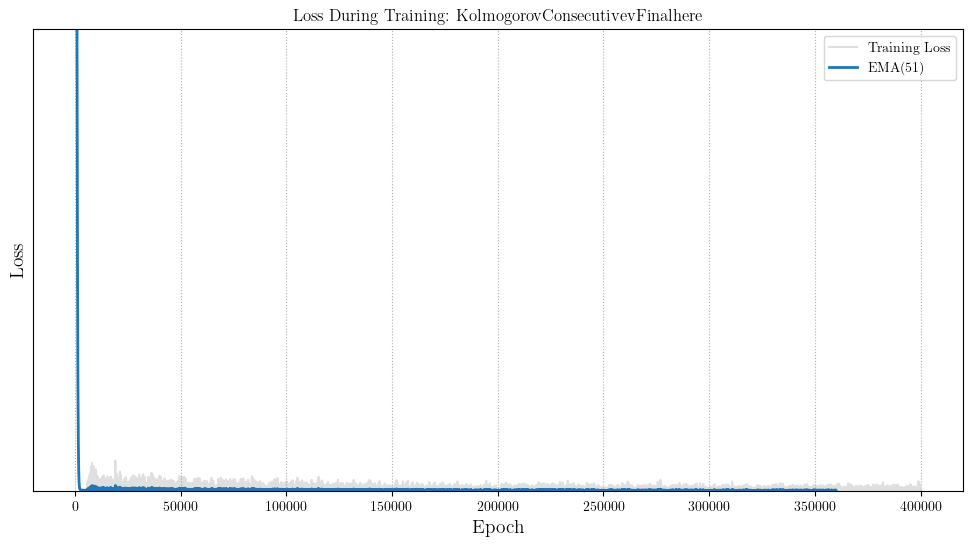

0.45658563373575317


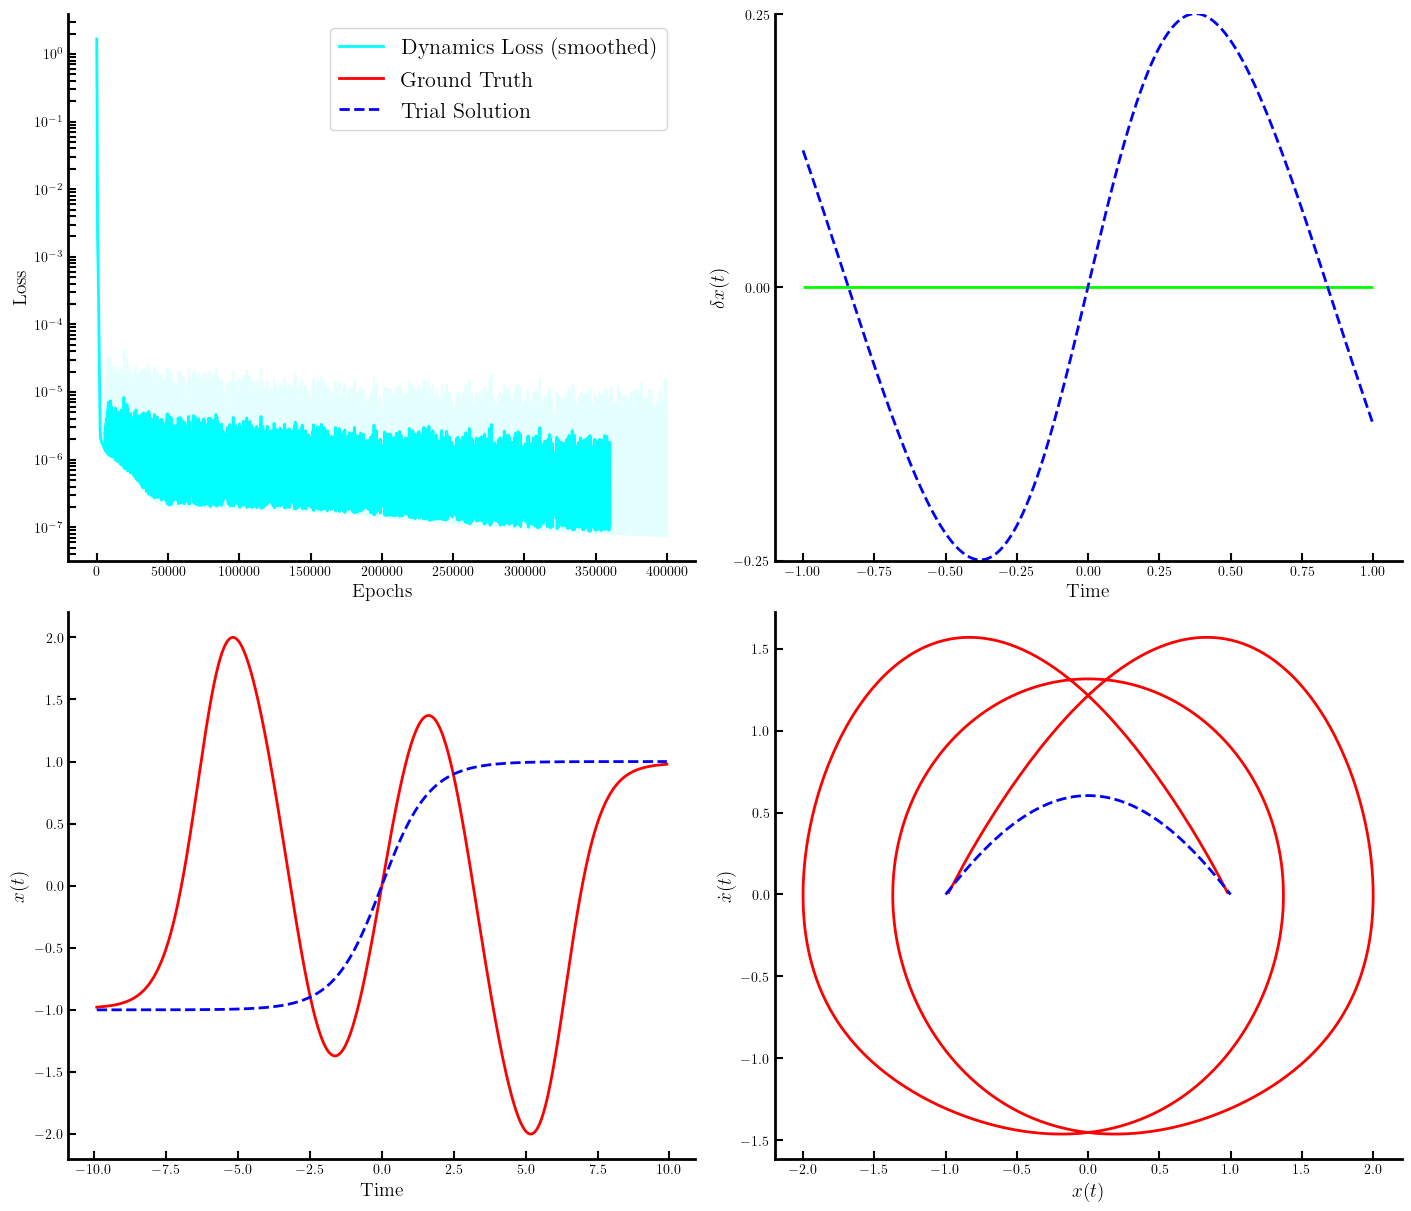

In [5]:
def main():
    lr_grid      = [5e-4]

    for lr in lr_grid:
            cfg = Configuration(
                seed=43365,
                features=[16, 16, 16],
                activation_function=th.nn.Tanh(),
                learning_rate=lr,
                epochs=400_000,
                steps=2_000,
            )

            system = KolmogorovConsecutive(
                domain=(-1 + 1e-10, 1 - 1e-10),
                initial_conditions={
                    "x": (-10, -1),   # x(-inf)
                    "y": (-10, 0),   # x'(.inf)
                    "z": (10, 1), # x(+inf)
                    "w": (10, 0), # x(+inf)
               }             # λ in the equation
            )

            model = Model(
                name="KolmogorovConsecutivevFinalhere",
                configuration=cfg,
                system_equations=system,
            )

            model.train()
            model.test5()


if __name__ == "__main__":
    main()

-1.0
Action over [-1000.0,1000.0]:  7.946487e+00


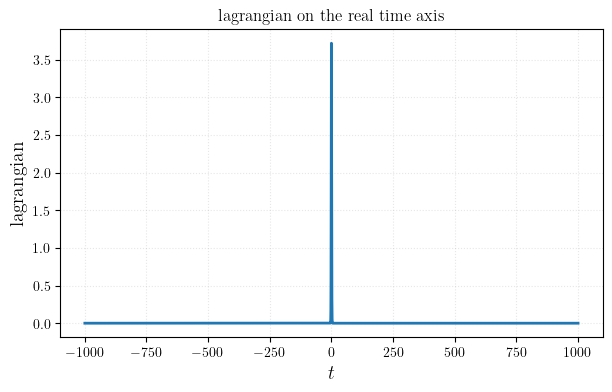

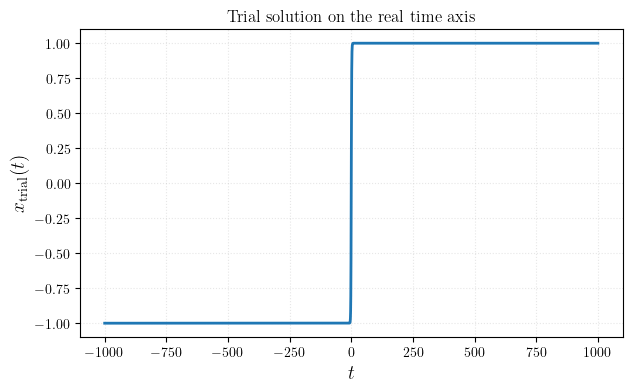

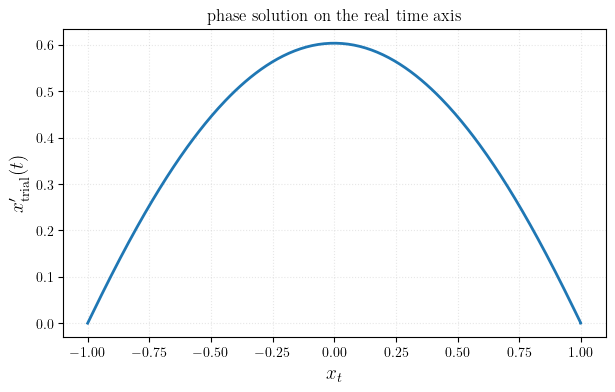

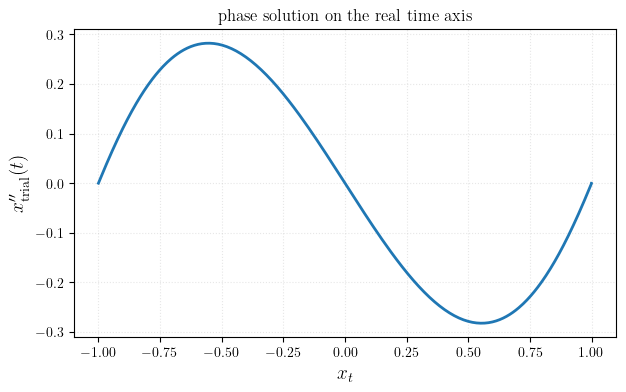

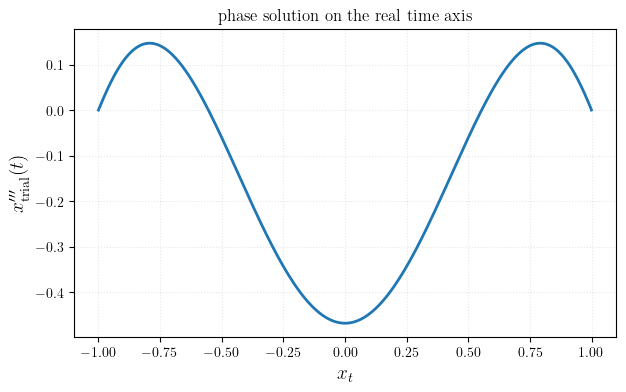

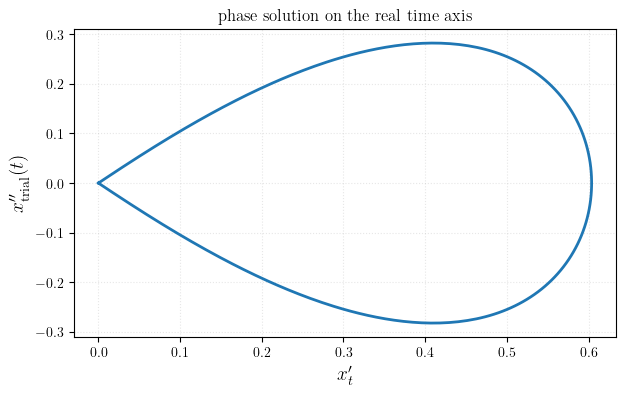

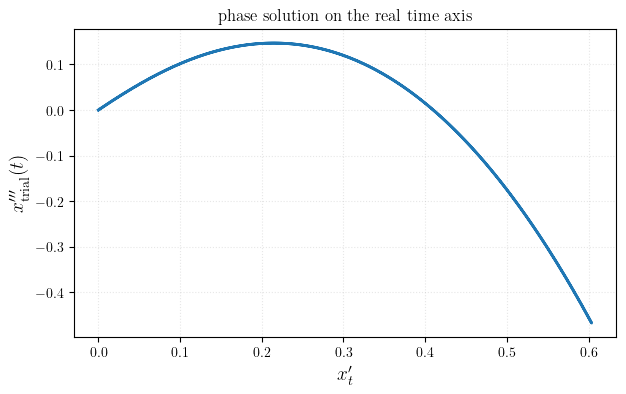

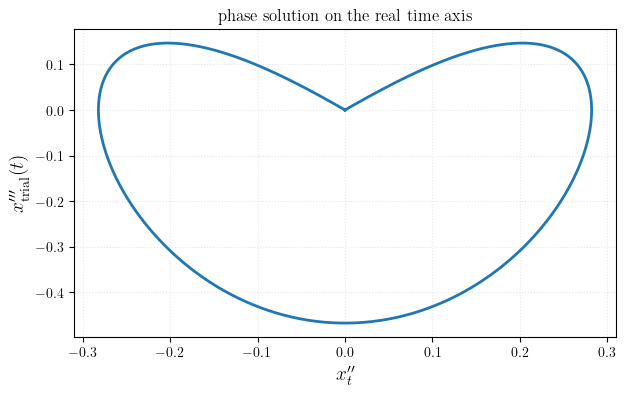

In [9]:
run_dir = r"Resultados_Finais_Considerados/fisher-kolmogorov-T/2025-06-13_20-59-42"

cfg = Configuration(seed=0, features=[16,16,16], activation_function=th.nn.Tanh(),
                    learning_rate=1e-3, epochs=0, steps=0)   # steps is ignored here
system = KolmogorovConsecutive(domain=(-1+1e-10, 1-1e-10), initial_conditions={}, L_scale=4.0)
model  = Model("post_plot", cfg, system)

model.load(os.path.join(run_dir, "model_best.pt"),
           os.path.join(run_dir, "optimizer_best.pt"))
model.model.eval()

L  = 4.0
t_min, t_max = -1000.0, 1000.0
Nplot = 100000

t_grid = np.linspace(t_min, t_max, Nplot)
s_grid = np.tanh(t_grid / L)

pred   = model.eval(s_grid)

x_t = pred["x"].ravel()
y_t = pred["y"].ravel()            # dx/dt
z_t = pred["z"].ravel()
w_t = pred["w"].ravel() 

print(x_t[1000])

lagrangian = 0.5*z_t**2 + 1.5*np.pi*y_t**2 + 1 + np.cos(np.pi*x_t)
action     = np.trapz(lagrangian, t_grid)

print(f"Action over [{t_min},{t_max}]:  {action:.6e}")

plt.figure(figsize=(7,4))
plt.plot(t_grid, lagrangian, lw=2)
plt.xlabel(r"$t$")
plt.ylabel(r"lagrangian")
plt.title("lagrangian on the real time axis")
plt.grid(alpha=0.3, ls=":")
plt.show()

plt.figure(figsize=(7,4))
plt.plot(t_grid, x_t, lw=2)
plt.xlabel(r"$t$")
plt.ylabel(r"$x_{\mathrm{trial}}(t)$")
plt.title("Trial solution on the real time axis")
plt.grid(alpha=0.3, ls=":")
plt.show()

plt.figure(figsize=(7,4))
plt.plot(x_t, y_t, lw=2)
plt.xlabel(r"$x_t$")
plt.ylabel(r"$x'_{\mathrm{trial}}(t)$")
plt.title("phase solution on the real time axis")
plt.grid(alpha=0.3, ls=":")
plt.show()

plt.figure(figsize=(7,4))
plt.plot(x_t, z_t, lw=2)
plt.xlabel(r"$x_t$")
plt.ylabel(r"$x''_{\mathrm{trial}}(t)$")
plt.title("phase solution on the real time axis")
plt.grid(alpha=0.3, ls=":")
plt.show()

plt.figure(figsize=(7,4))
plt.plot(x_t, w_t, lw=2)
plt.xlabel(r"$x_t$")
plt.ylabel(r"$x'''_{\mathrm{trial}}(t)$")
plt.title("phase solution on the real time axis")
plt.grid(alpha=0.3, ls=":")
plt.show()

plt.figure(figsize=(7,4))
plt.plot(y_t, z_t, lw=2)
plt.xlabel(r"$x'_t$")
plt.ylabel(r"$x''_{\mathrm{trial}}(t)$")
plt.title("phase solution on the real time axis")
plt.grid(alpha=0.3, ls=":")
plt.show()

plt.figure(figsize=(7,4))
plt.plot(y_t, w_t, lw=2)
plt.xlabel(r"$x'_t$")
plt.ylabel(r"$x'''_{\mathrm{trial}}(t)$")
plt.title("phase solution on the real time axis")
plt.grid(alpha=0.3, ls=":")
plt.show()

plt.figure(figsize=(7,4))
plt.plot(z_t, w_t, lw=2)
plt.xlabel(r"$x''_t$")
plt.ylabel(r"$x'''_{\mathrm{trial}}(t)$")
plt.title("phase solution on the real time axis")
plt.grid(alpha=0.3, ls=":")
plt.show()

In [ ]:
7.946487*3

In [ ]:
24.24471

In [ ]:
((24.24471-23.839461)/23.839461)*100